In [1]:
import sys
sys.path.append("../Envs/")

In [2]:
import pfrl
import torch.nn.functional as F
import torch.nn as nn
import torch
import random
import numpy
import datetime

In [3]:
from bc_env import BC5Env
from MarketClients.CSV.client import CSVClient

In [4]:
dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda:0


In [5]:
import threading
import pandas as pd
import os

class pt_logs:
    def __init__(self,env, root_path = './', folder='logs', save_obs = False):
        self.logs = []
        self.invalid_max = 0
        self.invalid_min = 0
        self.valid_max = -100
        self.valid_min = 100
        self.env = env
        self.__so = save_obs
        self.columns = env.columns.copy()
        self.columns.append("budgets")
        self.columns.append("coins")
        
        try:
            self.base_path = os.path.join(root_path, folder)
        except:
            print(f'specified path {root_path} {folder} is invalid')
        if not os.path.exists(self.base_path):
            os.makedirs(self.base_path)
            
        if self.__so:
            self.obs_path = os.path.join(self.base_path, 'obs')
            if not os.path.exists(self.obs_path):
                os.makedirs(self.obs_path)
            self.obs = pd.DataFrame([])

    def __check_logs(self, logs_df):
        ## check if reward is in range
        #TOTO change -1, 1 to min, max of env
        if logs_df.reward.max() > 1 or logs_df.reward.min() < -1:
            print(f"invalid reward at {self.env.get_data_index()-1}: {logs_df.reward.max()}")
        ## check is number of kind of actions is less than action_scpace
    
    def __check_obs(self, obs):
        #TOTO change -1, 1 to min, max of env
        max_value = obs.max()
        if max_value > 1:
            if self.invalid_max != max_value:
                self.invalid_max = max_value
                print(f"invalid valu in observations at {self.env.get_data_index()-1}: {self.invalid_max}")
        else:
            if max_value > self.valid_max:
                self.valid_max = max_value
            
        min_value = obs.min()
        if min_value < -1:
            if self.invalid_min != min_value:
                self.invalid_min = min_value
                print(f"invalid valu in observations at {self.env.get_data_index()-1}: {self.invalid_min}")
            else:
                if min_value < self.valid_min:
                    self.value_min = min_value
        
        ## check is obs is same as data obtained by index

    def store(self, obs, action, reward):
        log = {}
        log["index"] = self.env.get_data_index()-1
        log["ask"] = self.env.ask
        log["bid"] = self.env.bid
        log["act"] = action
        log["reward"] = reward
        self.logs.append(log)
        self.__check_obs(obs)
        if self.__so:
            self.obs = self.obs.append(pd.DataFrame(obs, columns=self.columns))
            
        
    def __save(self,logs, ep_num):
        content = pd.DataFrame(logs)
        try:
            path = os.path.join(self.base_path, f'episode_{ep_num}.csv')
            content.to_csv(path)
        except e:
            print(e)
        self.logs = []
        
        if self.__so:
            file = os.path.join(self.obs_path, f'episode_{ep_num}.csv')
            self.obs.to_csv(file)
            self.obs = pd.DataFrame([])
        
    def save(self, ep_num):
        logs = self.logs.copy()
        threading.Thread(target=self.__save(logs, ep_num))
        self.logs = []

In [5]:
def onehot_encode(label, device, n_class=10):
    eye = torch.eye(n_class, device=device)
    return eye[label].view(-1, n_class, 1,1)

In [14]:
torch.eye(10)[1].view(-1, 10, 1,1)

tensor([[[[0.]],

         [[1.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]],

         [[0.]]]])

In [5]:
data_client = CSVClient()
env = BC5Env(data_client, columns=["Open", "High", "Low", "Close"], useBudgetColumns=True)

In [6]:
import torch
import torch.nn as nn
from torch.optim import SGD
import math
import numpy as np

class PredictorSimple(nn.Module):
    def __init__(self, size, inputDim, n_actions, removeHistoryData = True):
        super().__init__()
        self.size = size
        self.rhd = removeHistoryData
        self.inDim = inputDim
        self.ActionHistoryDim = 3
        self.conv1 = nn.Conv1d(inputDim, inputDim*3, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(inputDim*3, inputDim*2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(inputDim*2*size, inputDim*size)
        self.fc2 = nn.Linear(inputDim*size, size)
        self.output_layer = nn.Linear(size, n_actions)
        self.softmax = nn.Softmax(1)

    def forward(self, inputs):
        batch_size, feature_len, seq_len  = inputs.shape[0], inputs.shape[1],inputs.shape[2]
        if self.rhd:
            out = inputs[:,0: feature_len - self.ActionHistoryDim, :]
        else:
            out = inputs
        out = torch.tanh(self.conv1(out))
        out = torch.tanh(self.conv2(out))
        out = out.view(-1, self.inDim*2*self.size)
        out = torch.tanh(self.fc1(out))
        out = torch.tanh(self.fc2(out))
        out = self.output_layer(out)
        return pfrl.action_value.DiscreteActionValue(out)

In [7]:
training_size = 1000 #traning dataのデータ数
epochs_num = 10000 #traningのepoch回数
hidden_size = 500 #LSTMの隠れ層の次元数
batch_size = 10

In [8]:
obs = env.reset()
inputDim = obs.shape[0]
size = obs.shape[1]

In [9]:
obs.shape

(6, 28)

In [10]:
model = PredictorSimple(size, inputDim, 3, False) #modelの宣言

#model = Predictor(6, hidden_size, 5) #modelの宣言
criterion = nn.MSELoss() #評価関数の宣言

In [11]:
#optimizer = SGD(model.parameters(), lr=0.0001) #最適化関数の宣言
optimizer = torch.optim.Adam(model.parameters(), eps=1e-4)
# Set the discount factor that discounts future rewards.
gamma = 0.9

# Use epsilon-greedy for exploration
explorer = pfrl.explorers.ConstantEpsilonGreedy(
    epsilon=0.1, random_action_func=env.action_space.sample)

# DQN uses Experience Replay.}
# Specify a replay buffer and its capacity.
replay_buffer = pfrl.replay_buffers.ReplayBuffer(capacity=batch_size)

# Since observations from CartPole-v0 is numpy.float64 while
# As PyTorch only accepts numpy.float32 by default, specify
# a converter as a feature extractor function phi.
phi = lambda x: x.astype(numpy.float32, copy=False)

# Set the device id to use GPU. To use CPU only, set it to -1.
gpu = -1

# Now create an agent that will interact with the environment.
agent = pfrl.agents.DoubleDQN(
    model,
    optimizer,
    replay_buffer,
    gamma,
    explorer,
    replay_start_size=batch_size,
    update_interval=1,
    target_update_interval=1,
    minibatch_size=1,
    phi=phi,
    gpu=gpu,
)

In [16]:
n_episodes = 20
max_step_len = 1000
mr = 0
pl = 0
ep_consumed_total_time = datetime.timedelta(0)
print(datetime.datetime.now(),'start episodes')

logger = pt_logs(env, folder='logs/bc_rl_5min_ohlc_budgets_v1')
## show details
##
for i in range(1, n_episodes + 1):
    obs = env.reset()
    #obs = obs.to('cpu').detach().numpy().copy()
    R = 0  # return (sum of rewards)
    t = 0  # time step
    logs = []
    ep_start_time = datetime.datetime.now()
    while True:
        # Uncomment to watch the behavior in a GUI window
        #env.render()
        action = agent.act(obs)
        obs, reward, done, ops = env.step(action)
        R += reward
        t += 1
        reset = t == max_step_len
        agent.observe(obs, reward, done, reset)
        logger.store(obs, action, reward)
        if reset or done:
            break
    ep_end_time = datetime.datetime.now()
    ep_consumed_time = ep_end_time - ep_start_time
    ep_consumed_total_time += ep_consumed_time
    logger.save(i)
    pl += env.pl
    mr += R/t
    if i % 10 == 0:
        print('statistics:', agent.get_statistics(), 'R:', R/t, 'Mean R:', mr/10, 'PL:', env.pl, 'Mean PL:', pl/10)
        print(f"consumed time: {ep_consumed_time}, may end on :{ep_end_time + (n_episodes -i) *  ep_consumed_total_time/i}")
        mr = 0
        pl = 0
print(f'Finished on {datetime.datetime.now()}')

2022-04-01 21:03:22.728662 start episodes
332523    5997996.0
332524    5993665.0
332525    5986344.0
332526    5975468.0
332527    5985758.0
332528    5982757.0
332529    5966144.0
332530    5970625.0
332531    5963627.0
332532    5964073.0
332533    5983714.0
332534    5976188.0
332535    5970772.0
332536    5953210.0
332537    5960000.0
332538    5952507.0
332539    5943173.0
332540    5927219.0
332541    5905491.0
332542    5892415.0
332543    5881577.0
332544    5863065.0
332545    5879450.0
332546    5878928.0
332547    5904139.0
332548    5898029.0
332549    5896592.0
332550    5880270.0
332551    5886277.0
Name: High, dtype: float64
invalid valu in observations: 48460.0
0     5997996.0
1     5993665.0
2     5986344.0
3     5975468.0
4     5985758.0
5     5982757.0
6     5966144.0
7     5970625.0
8     5963627.0
9     5964073.0
10    5983714.0
11    5976188.0
12    5970772.0
13    5953210.0
14    5960000.0
15    5952507.0
16    5943173.0
17    5927219.0
18    5905491.0
19    589

invalid valu in observations: 64734.0
0     5997996.0
1     5993665.0
2     5986344.0
3     5975468.0
4     5985758.0
5     5982757.0
6     5966144.0
7     5970625.0
8     5963627.0
9     5964073.0
10    5983714.0
11    5976188.0
12    5970772.0
13    5953210.0
14    5960000.0
15    5952507.0
16    5943173.0
17    5927219.0
18    5905491.0
19    5892415.0
20    5881577.0
21    5863065.0
22    5879450.0
23    5878928.0
24    5904139.0
25    5898029.0
26    5896592.0
27    5880270.0
28    5886277.0
29    5838284.0
30    5881051.0
31    5908806.0
32    5903709.0
33    5918806.0
34    5913152.0
35    5971336.0
36    5973071.0
37    5965831.0
38    5986635.0
39    6000000.0
40    5968064.0
41    5952546.0
Name: High, dtype: float64
invalid valu in observations: 64734.0
0     5997996.0
1     5993665.0
2     5986344.0
3     5975468.0
4     5985758.0
5     5982757.0
6     5966144.0
7     5970625.0
8     5963627.0
9     5964073.0
10    5983714.0
11    5976188.0
12    5970772.0
13    5953210.0
1

0     5997996.0
1     5993665.0
2     5986344.0
3     5975468.0
4     5985758.0
5     5982757.0
6     5966144.0
7     5970625.0
8     5963627.0
9     5964073.0
10    5983714.0
11    5976188.0
12    5970772.0
13    5953210.0
14    5960000.0
15    5952507.0
16    5943173.0
17    5927219.0
18    5905491.0
19    5892415.0
20    5881577.0
21    5863065.0
22    5879450.0
23    5878928.0
24    5904139.0
25    5898029.0
26    5896592.0
27    5880270.0
28    5886277.0
29    5838284.0
30    5881051.0
31    5908806.0
32    5903709.0
33    5918806.0
34    5913152.0
35    5971336.0
36    5973071.0
37    5965831.0
38    5986635.0
39    6000000.0
40    5968064.0
41    5952546.0
42    5971450.0
43    6017468.0
44    6024367.0
45    6020965.0
46    6009506.0
47    6005447.0
48    6022380.0
49    6030779.0
50    6003800.0
51    6023868.0
52    6021240.0
53    6010844.0
54    6013836.0
Name: High, dtype: float64
invalid valu in observations: 64734.0
0     5997996.0
1     5993665.0
2     5986344.0
3     5

invalid valu in observations: 73724.0
0     5997996.0
1     5993665.0
2     5986344.0
3     5975468.0
4     5985758.0
        ...    
74    6080000.0
75    6073176.0
76    6080000.0
77    6080220.0
78    6080000.0
Name: High, Length: 79, dtype: float64
invalid valu in observations: 73724.0
0     5997996.0
1     5993665.0
2     5986344.0
3     5975468.0
4     5985758.0
        ...    
75    6073176.0
76    6080000.0
77    6080220.0
78    6080000.0
79    6081456.0
Name: High, Length: 80, dtype: float64
invalid valu in observations: 73724.0
0     5997996.0
1     5993665.0
2     5986344.0
3     5975468.0
4     5985758.0
        ...    
76    6080000.0
77    6080220.0
78    6080000.0
79    6081456.0
80    6130000.0
Name: High, Length: 81, dtype: float64
invalid valu in observations: 73724.0
0     5997996.0
1     5993665.0
2     5986344.0
3     5975468.0
4     5985758.0
        ...    
77    6080220.0
78    6080000.0
79    6081456.0
80    6130000.0
81    6128232.0
Name: High, Length: 82, dty

invalid valu in observations: 24228.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
111    6098393.0
112    6085293.0
113    6074518.0
114    6041000.0
115    6029378.0
Name: High, Length: 116, dtype: float64
invalid valu in observations: 24228.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
112    6085293.0
113    6074518.0
114    6041000.0
115    6029378.0
116    6035669.0
Name: High, Length: 117, dtype: float64
invalid valu in observations: 24228.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
113    6074518.0
114    6041000.0
115    6029378.0
116    6035669.0
117    6031918.0
Name: High, Length: 118, dtype: float64
invalid valu in observations: 24228.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
114    6041000.0
115    6029378.0
116    6035669.0
117    6031918

invalid valu in observations: 51765.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
144    6049941.0
145    6043068.0
146    6039781.0
147    6037124.0
148    6035048.0
Name: High, Length: 149, dtype: float64
invalid valu in observations: 51765.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
145    6043068.0
146    6039781.0
147    6037124.0
148    6035048.0
149    6040000.0
Name: High, Length: 150, dtype: float64
invalid valu in observations: 51765.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
146    6039781.0
147    6037124.0
148    6035048.0
149    6040000.0
150    6045369.0
Name: High, Length: 151, dtype: float64
invalid valu in observations: 51765.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
147    6037124.0
148    6035048.0
149    6040000.0
150    6045369

invalid valu in observations: 34600.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
177    6131743.0
178    6133547.0
179    6121722.0
180    6121000.0
181    6155600.0
Name: High, Length: 182, dtype: float64
invalid valu in observations: 34600.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
178    6133547.0
179    6121722.0
180    6121000.0
181    6155600.0
182    6164999.0
Name: High, Length: 183, dtype: float64
invalid valu in observations: 34600.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
179    6121722.0
180    6121000.0
181    6155600.0
182    6164999.0
183    6162996.0
Name: High, Length: 184, dtype: float64
invalid valu in observations: 34600.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
180    6121000.0
181    6155600.0
182    6164999.0
183    6162996

invalid valu in observations: 24452.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
210    6127817.0
211    6115914.0
212    6109160.0
213    6114197.0
214    6127441.0
Name: High, Length: 215, dtype: float64
invalid valu in observations: 24452.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
211    6115914.0
212    6109160.0
213    6114197.0
214    6127441.0
215    6125781.0
Name: High, Length: 216, dtype: float64
invalid valu in observations: 24452.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
212    6109160.0
213    6114197.0
214    6127441.0
215    6125781.0
216    6112381.0
Name: High, Length: 217, dtype: float64
invalid valu in observations: 24452.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
213    6114197.0
214    6127441.0
215    6125781.0
216    6112381

invalid valu in observations: 26005.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
243    6058334.0
244    6057610.0
245    6050363.0
246    6051923.0
247    6049473.0
Name: High, Length: 248, dtype: float64
invalid valu in observations: 26005.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
244    6057610.0
245    6050363.0
246    6051923.0
247    6049473.0
248    6067000.0
Name: High, Length: 249, dtype: float64
invalid valu in observations: 26005.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
245    6050363.0
246    6051923.0
247    6049473.0
248    6067000.0
249    6078431.0
Name: High, Length: 250, dtype: float64
invalid valu in observations: 26005.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
246    6051923.0
247    6049473.0
248    6067000.0
249    6078431

invalid valu in observations: 31470.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
276    5962488.0
277    5992212.0
278    5996276.0
279    5999828.0
280    6002571.0
Name: High, Length: 281, dtype: float64
invalid valu in observations: 31470.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
277    5992212.0
278    5996276.0
279    5999828.0
280    6002571.0
281    6003755.0
Name: High, Length: 282, dtype: float64
invalid valu in observations: 31470.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
278    5996276.0
279    5999828.0
280    6002571.0
281    6003755.0
282    6001898.0
Name: High, Length: 283, dtype: float64
invalid valu in observations: 31470.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
279    5999828.0
280    6002571.0
281    6003755.0
282    6001898

invalid valu in observations: 51514.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
312    6014441.0
313    6005000.0
314    6026135.0
315    6023404.0
316    6014240.0
Name: High, Length: 317, dtype: float64
invalid valu in observations: 51514.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
313    6005000.0
314    6026135.0
315    6023404.0
316    6014240.0
317    6005120.0
Name: High, Length: 318, dtype: float64
invalid valu in observations: 51514.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
314    6026135.0
315    6023404.0
316    6014240.0
317    6005120.0
318    6017105.0
Name: High, Length: 319, dtype: float64
invalid valu in observations: 51514.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
315    6023404.0
316    6014240.0
317    6005120.0
318    6017105

invalid valu in observations: 29901.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
345    5955364.0
346    5946606.0
347    5926235.0
348    5928986.0
349    5935297.0
Name: High, Length: 350, dtype: float64
invalid valu in observations: 29901.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
346    5946606.0
347    5926235.0
348    5928986.0
349    5935297.0
350    5915111.0
Name: High, Length: 351, dtype: float64
invalid valu in observations: 29901.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
347    5926235.0
348    5928986.0
349    5935297.0
350    5915111.0
351    5914500.0
Name: High, Length: 352, dtype: float64
invalid valu in observations: 29901.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
348    5928986.0
349    5935297.0
350    5915111.0
351    5914500

invalid valu in observations: 50397.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
381    6007754.0
382    6023999.0
383    6074000.0
384    6099500.0
385    6092367.0
Name: High, Length: 386, dtype: float64
invalid valu in observations: 50001.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
382    6023999.0
383    6074000.0
384    6099500.0
385    6092367.0
386    6085244.0
Name: High, Length: 387, dtype: float64
invalid valu in observations: 50001.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
383    6074000.0
384    6099500.0
385    6092367.0
386    6085244.0
387    6082776.0
Name: High, Length: 388, dtype: float64
invalid valu in observations: 50001.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
384    6099500.0
385    6092367.0
386    6085244.0
387    6082776

invalid valu in observations: 20283.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
415    6036852.0
416    6039308.0
417    6035250.0
418    6035993.0
419    6032752.0
Name: High, Length: 420, dtype: float64
invalid valu in observations: 20283.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
416    6039308.0
417    6035250.0
418    6035993.0
419    6032752.0
420    6014975.0
Name: High, Length: 421, dtype: float64
invalid valu in observations: 20283.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
417    6035250.0
418    6035993.0
419    6032752.0
420    6014975.0
421    6016605.0
Name: High, Length: 422, dtype: float64
invalid valu in observations: 20298.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
418    6035993.0
419    6032752.0
420    6014975.0
421    6016605

0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
446    6009394.0
447    6012871.0
448    6013055.0
449    5991744.0
450    5985851.0
Name: High, Length: 451, dtype: float64
invalid valu in observations: 19342.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
447    6012871.0
448    6013055.0
449    5991744.0
450    5985851.0
451    5970197.0
Name: High, Length: 452, dtype: float64
invalid valu in observations: 19342.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
448    6013055.0
449    5991744.0
450    5985851.0
451    5970197.0
452    5962292.0
Name: High, Length: 453, dtype: float64
invalid valu in observations: 19342.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
449    5991744.0
450    5985851.0
451    5970197.0
452    5962292.0
453    5955052.0
Name: High, Length

invalid valu in observations: 36625.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
482    5874508.0
483    5874476.0
484    5863748.0
485    5866754.0
486    5847369.0
Name: High, Length: 487, dtype: float64
invalid valu in observations: 36625.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
483    5874476.0
484    5863748.0
485    5866754.0
486    5847369.0
487    5836739.0
Name: High, Length: 488, dtype: float64
invalid valu in observations: 36625.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
484    5863748.0
485    5866754.0
486    5847369.0
487    5836739.0
488    5834770.0
Name: High, Length: 489, dtype: float64
invalid valu in observations: 36625.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
485    5866754.0
486    5847369.0
487    5836739.0
488    5834770

invalid valu in observations: 53720.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
515    5887727.0
516    5887784.0
517    5878496.0
518    5889964.0
519    5884958.0
Name: High, Length: 520, dtype: float64
invalid valu in observations: 53720.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
516    5887784.0
517    5878496.0
518    5889964.0
519    5884958.0
520    5865698.0
Name: High, Length: 521, dtype: float64
invalid valu in observations: 53720.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
517    5878496.0
518    5889964.0
519    5884958.0
520    5865698.0
521    5825567.0
Name: High, Length: 522, dtype: float64
invalid valu in observations: 53720.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
518    5889964.0
519    5884958.0
520    5865698.0
521    5825567

invalid valu in observations: 52081.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
547    5853227.0
548    5846640.0
549    5852083.0
550    5884000.0
551    5871903.0
Name: High, Length: 552, dtype: float64
invalid valu in observations: 40523.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
548    5846640.0
549    5852083.0
550    5884000.0
551    5871903.0
552    5848375.0
Name: High, Length: 553, dtype: float64
invalid valu in observations: 40523.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
549    5852083.0
550    5884000.0
551    5871903.0
552    5848375.0
553    5845504.0
Name: High, Length: 554, dtype: float64
invalid valu in observations: 35622.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
550    5884000.0
551    5871903.0
552    5848375.0
553    5845504

invalid valu in observations: 35005.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
581    5900642.0
582    5901663.0
583    5871306.0
584    5866241.0
585    5859689.0
Name: High, Length: 586, dtype: float64
invalid valu in observations: 35005.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
582    5901663.0
583    5871306.0
584    5866241.0
585    5859689.0
586    5861328.0
Name: High, Length: 587, dtype: float64
invalid valu in observations: 35005.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
583    5871306.0
584    5866241.0
585    5859689.0
586    5861328.0
587    5875131.0
Name: High, Length: 588, dtype: float64
invalid valu in observations: 35005.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
584    5866241.0
585    5859689.0
586    5861328.0
587    5875131

invalid valu in observations: 42012.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
615    5866244.0
616    5880541.0
617    5876361.0
618    5868038.0
619    5869767.0
Name: High, Length: 620, dtype: float64
invalid valu in observations: 42012.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
616    5880541.0
617    5876361.0
618    5868038.0
619    5869767.0
620    5867274.0
Name: High, Length: 621, dtype: float64
invalid valu in observations: 42012.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
617    5876361.0
618    5868038.0
619    5869767.0
620    5867274.0
621    5882679.0
Name: High, Length: 622, dtype: float64
invalid valu in observations: 42012.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
618    5868038.0
619    5869767.0
620    5867274.0
621    5882679

invalid valu in observations: 68994.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
648    5996745.0
649    5979217.0
650    5970351.0
651    5966625.0
652    5965982.0
Name: High, Length: 653, dtype: float64
invalid valu in observations: 68994.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
649    5979217.0
650    5970351.0
651    5966625.0
652    5965982.0
653    5967543.0
Name: High, Length: 654, dtype: float64
invalid valu in observations: 68994.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
650    5970351.0
651    5966625.0
652    5965982.0
653    5967543.0
654    5941905.0
Name: High, Length: 655, dtype: float64
invalid valu in observations: 68994.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
651    5966625.0
652    5965982.0
653    5967543.0
654    5941905

0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
682    5889399.0
683    5892780.0
684    5897653.0
685    5895764.0
686    5890853.0
Name: High, Length: 687, dtype: float64
invalid valu in observations: 22699.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
683    5892780.0
684    5897653.0
685    5895764.0
686    5890853.0
687    5910000.0
Name: High, Length: 688, dtype: float64
invalid valu in observations: 22699.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
684    5897653.0
685    5895764.0
686    5890853.0
687    5910000.0
688    5914861.0
Name: High, Length: 689, dtype: float64
invalid valu in observations: 22699.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
685    5895764.0
686    5890853.0
687    5910000.0
688    5914861.0
689    5912231.0
Name: High, Length

invalid valu in observations: 37044.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
716    5782510.0
717    5752354.0
718    5767457.0
719    5783035.0
720    5779925.0
Name: High, Length: 721, dtype: float64
invalid valu in observations: 37044.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
717    5752354.0
718    5767457.0
719    5783035.0
720    5779925.0
721    5791012.0
Name: High, Length: 722, dtype: float64
invalid valu in observations: 30098.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
718    5767457.0
719    5783035.0
720    5779925.0
721    5791012.0
722    5788151.0
Name: High, Length: 723, dtype: float64
invalid valu in observations: 30098.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
719    5783035.0
720    5779925.0
721    5791012.0
722    5788151

invalid valu in observations: 95025.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
749    5582756.0
750    5546064.0
751    5583287.0
752    5589405.0
753    5618140.0
Name: High, Length: 754, dtype: float64
invalid valu in observations: 95025.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
750    5546064.0
751    5583287.0
752    5589405.0
753    5618140.0
754    5600000.0
Name: High, Length: 755, dtype: float64
invalid valu in observations: 95025.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
751    5583287.0
752    5589405.0
753    5618140.0
754    5600000.0
755    5581212.0
Name: High, Length: 756, dtype: float64
invalid valu in observations: 95025.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
752    5589405.0
753    5618140.0
754    5600000.0
755    5581212

invalid valu in observations: 49932.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
783    5602454.0
784    5584756.0
785    5584000.0
786    5584755.0
787    5601267.0
Name: High, Length: 788, dtype: float64
invalid valu in observations: 49932.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
784    5584756.0
785    5584000.0
786    5584755.0
787    5601267.0
788    5606531.0
Name: High, Length: 789, dtype: float64
invalid valu in observations: 49932.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
785    5584000.0
786    5584755.0
787    5601267.0
788    5606531.0
789    5600104.0
Name: High, Length: 790, dtype: float64
invalid valu in observations: 49932.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
786    5584755.0
787    5601267.0
788    5606531.0
789    5600104

invalid valu in observations: 142386.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
818    5325187.0
819    5363030.0
820    5369000.0
821    5380271.0
822    5417999.0
Name: High, Length: 823, dtype: float64
invalid valu in observations: 142386.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
819    5363030.0
820    5369000.0
821    5380271.0
822    5417999.0
823    5404527.0
Name: High, Length: 824, dtype: float64
invalid valu in observations: 142386.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
820    5369000.0
821    5380271.0
822    5417999.0
823    5404527.0
824    5393137.0
Name: High, Length: 825, dtype: float64
invalid valu in observations: 142386.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
821    5380271.0
822    5417999.0
823    5404527.0
824    539

invalid valu in observations: 42315.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
849    5295064.0
850    5312067.0
851    5320508.0
852    5350000.0
853    5337820.0
Name: High, Length: 854, dtype: float64
invalid valu in observations: 42315.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
850    5312067.0
851    5320508.0
852    5350000.0
853    5337820.0
854    5370000.0
Name: High, Length: 855, dtype: float64
invalid valu in observations: 42315.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
851    5320508.0
852    5350000.0
853    5337820.0
854    5370000.0
855    5360540.0
Name: High, Length: 856, dtype: float64
invalid valu in observations: 42315.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
852    5350000.0
853    5337820.0
854    5370000.0
855    5360540

invalid valu in observations: 53211.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
884    5187644.0
885    5185709.0
886    5201838.0
887    5218807.0
888    5211302.0
Name: High, Length: 889, dtype: float64
invalid valu in observations: 53211.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
885    5185709.0
886    5201838.0
887    5218807.0
888    5211302.0
889    5207746.0
Name: High, Length: 890, dtype: float64
invalid valu in observations: 53211.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
886    5201838.0
887    5218807.0
888    5211302.0
889    5207746.0
890    5207808.0
Name: High, Length: 891, dtype: float64
invalid valu in observations: 53211.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
887    5218807.0
888    5211302.0
889    5207746.0
890    5207808

Name: High, Length: 923, dtype: float64
invalid valu in observations: 54189.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
919    5365800.0
920    5379107.0
921    5387481.0
922    5391150.0
923    5409592.0
Name: High, Length: 924, dtype: float64
invalid valu in observations: 54189.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
920    5379107.0
921    5387481.0
922    5391150.0
923    5409592.0
924    5431175.0
Name: High, Length: 925, dtype: float64
invalid valu in observations: 54189.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
921    5387481.0
922    5391150.0
923    5409592.0
924    5431175.0
925    5431666.0
Name: High, Length: 926, dtype: float64
invalid valu in observations: 54189.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
922    5391150.0
923    5

invalid valu in observations: 48269.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
951    5281176.0
952    5289193.0
953    5284147.0
954    5314378.0
955    5314391.0
Name: High, Length: 956, dtype: float64
invalid valu in observations: 48269.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
952    5289193.0
953    5284147.0
954    5314378.0
955    5314391.0
956    5320796.0
Name: High, Length: 957, dtype: float64
invalid valu in observations: 48269.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
953    5284147.0
954    5314378.0
955    5314391.0
956    5320796.0
957    5330000.0
Name: High, Length: 958, dtype: float64
invalid valu in observations: 48269.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
954    5314378.0
955    5314391.0
956    5320796.0
957    5330000

invalid valu in observations: 34405.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
986    5385000.0
987    5389999.0
988    5384660.0
989    5380386.0
990    5369920.0
Name: High, Length: 991, dtype: float64
invalid valu in observations: 34405.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
987    5389999.0
988    5384660.0
989    5380386.0
990    5369920.0
991    5369000.0
Name: High, Length: 992, dtype: float64
invalid valu in observations: 34405.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
988    5384660.0
989    5380386.0
990    5369920.0
991    5369000.0
992    5401060.0
Name: High, Length: 993, dtype: float64
invalid valu in observations: 34405.0
0      5997996.0
1      5993665.0
2      5986344.0
3      5975468.0
4      5985758.0
         ...    
989    5380386.0
990    5369920.0
991    5369000.0
992    5401060

invalid valu in observations: 40682.0
0       5997996.0
1       5993665.0
2       5986344.0
3       5975468.0
4       5985758.0
          ...    
1021    5476310.0
1022    5487871.0
1023    5477766.0
1024    5495000.0
1025    5504000.0
Name: High, Length: 1026, dtype: float64
invalid valu in observations: 40682.0
0       5997996.0
1       5993665.0
2       5986344.0
3       5975468.0
4       5985758.0
          ...    
1022    5487871.0
1023    5477766.0
1024    5495000.0
1025    5504000.0
1026    5510000.0
Name: High, Length: 1027, dtype: float64
invalid valu in observations: 40682.0
0       5997996.0
1       5993665.0
2       5986344.0
3       5975468.0
4       5985758.0
          ...    
1023    5477766.0
1024    5495000.0
1025    5504000.0
1026    5510000.0
1027    5523999.0
Name: High, Length: 1028, dtype: float64
invalid valu in observations: 40682.0
20709    447566.0
20710    446290.0
20711    445500.0
20712    445000.0
20713    446103.0
20714    445299.0
20715    444479.0
20716

invalid valu in observations: 6080.0
0     447566.0
1     446290.0
2     445500.0
3     445000.0
4     446103.0
5     445299.0
6     444479.0
7     444599.0
8     443550.0
9     442790.0
10    442220.0
11    440410.0
12    440011.0
13    439005.0
14    437870.0
15    437530.0
16    437500.0
17    435372.0
18    432000.0
19    432262.0
20    432689.0
21    429990.0
22    431030.0
23    430417.0
24    429499.0
25    434110.0
26    437900.0
27    435816.0
28    435790.0
29    436380.0
30    435730.0
31    434779.0
32    434438.0
33    437315.0
34    441337.0
35    443000.0
36    445000.0
37    443000.0
38    442100.0
39    439490.0
40    441709.0
41    441110.0
42    441247.0
43    440290.0
Name: High, dtype: float64
invalid valu in observations: 6080.0
0     447566.0
1     446290.0
2     445500.0
3     445000.0
4     446103.0
5     445299.0
6     444479.0
7     444599.0
8     443550.0
9     442790.0
10    442220.0
11    440410.0
12    440011.0
13    439005.0
14    437870.0
15    437530.0

invalid valu in observations: 4414.0
0     447566.0
1     446290.0
2     445500.0
3     445000.0
4     446103.0
5     445299.0
6     444479.0
7     444599.0
8     443550.0
9     442790.0
10    442220.0
11    440410.0
12    440011.0
13    439005.0
14    437870.0
15    437530.0
16    437500.0
17    435372.0
18    432000.0
19    432262.0
20    432689.0
21    429990.0
22    431030.0
23    430417.0
24    429499.0
25    434110.0
26    437900.0
27    435816.0
28    435790.0
29    436380.0
30    435730.0
31    434779.0
32    434438.0
33    437315.0
34    441337.0
35    443000.0
36    445000.0
37    443000.0
38    442100.0
39    439490.0
40    441709.0
41    441110.0
42    441247.0
43    440290.0
44    439640.0
45    439100.0
46    438296.0
47    436610.0
48    435820.0
49    436361.0
50    436000.0
51    438480.0
52    438200.0
53    438155.0
54    437490.0
55    440900.0
56    440900.0
57    439890.0
Name: High, dtype: float64
invalid valu in observations: 4414.0
0     447566.0
1     446290.0

invalid valu in observations: 2621.0
0     447566.0
1     446290.0
2     445500.0
3     445000.0
4     446103.0
        ...   
82    441590.0
83    443480.0
84    445000.0
85    446080.0
86    445848.0
Name: High, Length: 87, dtype: float64
invalid valu in observations: 2621.0
0     447566.0
1     446290.0
2     445500.0
3     445000.0
4     446103.0
        ...   
83    443480.0
84    445000.0
85    446080.0
86    445848.0
87    444560.0
Name: High, Length: 88, dtype: float64
invalid valu in observations: 2621.0
0     447566.0
1     446290.0
2     445500.0
3     445000.0
4     446103.0
        ...   
84    445000.0
85    446080.0
86    445848.0
87    444560.0
88    444500.0
Name: High, Length: 89, dtype: float64
invalid valu in observations: 2621.0
0     447566.0
1     446290.0
2     445500.0
3     445000.0
4     446103.0
        ...   
85    446080.0
86    445848.0
87    444560.0
88    444500.0
89    444399.0
Name: High, Length: 90, dtype: float64
invalid valu in observations: 2621.0

invalid valu in observations: 1470.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
116    442000.0
117    441457.0
118    441500.0
119    440399.0
120    440032.0
Name: High, Length: 121, dtype: float64
invalid valu in observations: 1470.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
117    441457.0
118    441500.0
119    440399.0
120    440032.0
121    438900.0
Name: High, Length: 122, dtype: float64
invalid valu in observations: 1470.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
118    441500.0
119    440399.0
120    440032.0
121    438900.0
122    438900.0
Name: High, Length: 123, dtype: float64
invalid valu in observations: 1470.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
119    440399.0
120    440032.0
121    438900.0
122    438900.0
123    438799.0
Name: High, Length: 124, dty

invalid valu in observations: 1848.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
155    442000.0
156    442199.0
157    442052.0
158    443900.0
159    443745.0
Name: High, Length: 160, dtype: float64
invalid valu in observations: 1848.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
156    442199.0
157    442052.0
158    443900.0
159    443745.0
160    443910.0
Name: High, Length: 161, dtype: float64
invalid valu in observations: 1848.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
157    442052.0
158    443900.0
159    443745.0
160    443910.0
161    443990.0
Name: High, Length: 162, dtype: float64
invalid valu in observations: 1848.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
158    443900.0
159    443745.0
160    443910.0
161    443990.0
162    444000.0
Name: High, Length: 163, dty

invalid valu in observations: 2039.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
192    435180.0
193    435255.0
194    434690.0
195    433470.0
196    433541.0
Name: High, Length: 197, dtype: float64
invalid valu in observations: 2039.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
193    435255.0
194    434690.0
195    433470.0
196    433541.0
197    433009.0
Name: High, Length: 198, dtype: float64
invalid valu in observations: 2039.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
194    434690.0
195    433470.0
196    433541.0
197    433009.0
198    432950.0
Name: High, Length: 199, dtype: float64
invalid valu in observations: 3610.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
195    433470.0
196    433541.0
197    433009.0
198    432950.0
199    436560.0
Name: High, Length: 200, dty

invalid valu in observations: 2280.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
228    437000.0
229    436300.0
230    437127.0
231    438071.0
232    437998.0
Name: High, Length: 233, dtype: float64
invalid valu in observations: 2280.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
229    436300.0
230    437127.0
231    438071.0
232    437998.0
233    437600.0
Name: High, Length: 234, dtype: float64
invalid valu in observations: 2100.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
230    437127.0
231    438071.0
232    437998.0
233    437600.0
234    436600.0
Name: High, Length: 235, dtype: float64
invalid valu in observations: 2100.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
231    438071.0
232    437998.0
233    437600.0
234    436600.0
235    436625.0
Name: High, Length: 236, dty

invalid valu in observations: 3450.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
264    430334.0
265    429200.0
266    430708.0
267    430709.0
268    430000.0
Name: High, Length: 269, dtype: float64
invalid valu in observations: 3450.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
265    429200.0
266    430708.0
267    430709.0
268    430000.0
269    431154.0
Name: High, Length: 270, dtype: float64
invalid valu in observations: 3450.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
266    430708.0
267    430709.0
268    430000.0
269    431154.0
270    431140.0
Name: High, Length: 271, dtype: float64
invalid valu in observations: 3450.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
267    430709.0
268    430000.0
269    431154.0
270    431140.0
271    430337.0
Name: High, Length: 272, dty

invalid valu in observations: 1910.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
299    426000.0
300    425782.0
301    426690.0
302    426000.0
303    425100.0
Name: High, Length: 304, dtype: float64
invalid valu in observations: 1910.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
300    425782.0
301    426690.0
302    426000.0
303    425100.0
304    425900.0
Name: High, Length: 305, dtype: float64
invalid valu in observations: 1910.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
301    426690.0
302    426000.0
303    425100.0
304    425900.0
305    425750.0
Name: High, Length: 306, dtype: float64
invalid valu in observations: 1910.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
302    426000.0
303    425100.0
304    425900.0
305    425750.0
306    425654.0
Name: High, Length: 307, dty

invalid valu in observations: 3355.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
335    438500.0
336    437890.0
337    437430.0
338    438000.0
339    437590.0
Name: High, Length: 340, dtype: float64
invalid valu in observations: 3355.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
336    437890.0
337    437430.0
338    438000.0
339    437590.0
340    437259.0
Name: High, Length: 341, dtype: float64
invalid valu in observations: 3355.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
337    437430.0
338    438000.0
339    437590.0
340    437259.0
341    434840.0
Name: High, Length: 342, dtype: float64
invalid valu in observations: 3355.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
338    438000.0
339    437590.0
340    437259.0
341    434840.0
342    434783.0
Name: High, Length: 343, dty

invalid valu in observations: 1710.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
368    433040.0
369    433425.0
370    433235.0
371    434250.0
372    434779.0
Name: High, Length: 373, dtype: float64
invalid valu in observations: 1710.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
369    433425.0
370    433235.0
371    434250.0
372    434779.0
373    435750.0
Name: High, Length: 374, dtype: float64
invalid valu in observations: 1710.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
370    433235.0
371    434250.0
372    434779.0
373    435750.0
374    434498.0
Name: High, Length: 375, dtype: float64
invalid valu in observations: 1710.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
371    434250.0
372    434779.0
373    435750.0
374    434498.0
375    433151.0
Name: High, Length: 376, dty

invalid valu in observations: 3510.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
405    434380.0
406    434600.0
407    436490.0
408    440000.0
409    440707.0
Name: High, Length: 410, dtype: float64
invalid valu in observations: 3510.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
406    434600.0
407    436490.0
408    440000.0
409    440707.0
410    441500.0
Name: High, Length: 411, dtype: float64
invalid valu in observations: 3510.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
407    436490.0
408    440000.0
409    440707.0
410    441500.0
411    443520.0
Name: High, Length: 412, dtype: float64
invalid valu in observations: 3510.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
408    440000.0
409    440707.0
410    441500.0
411    443520.0
412    444451.0
Name: High, Length: 413, dty

invalid valu in observations: 1514.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
444    442416.0
445    443800.0
446    443432.0
447    442652.0
448    442479.0
Name: High, Length: 449, dtype: float64
invalid valu in observations: 1514.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
445    443800.0
446    443432.0
447    442652.0
448    442479.0
449    442340.0
Name: High, Length: 450, dtype: float64
invalid valu in observations: 1514.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
446    443432.0
447    442652.0
448    442479.0
449    442340.0
450    442388.0
Name: High, Length: 451, dtype: float64
invalid valu in observations: 1514.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
447    442652.0
448    442479.0
449    442340.0
450    442388.0
451    441611.0
Name: High, Length: 452, dty

invalid valu in observations: 1680.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
477    438740.0
478    438502.0
479    437900.0
480    437510.0
481    437690.0
Name: High, Length: 482, dtype: float64
invalid valu in observations: 1680.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
478    438502.0
479    437900.0
480    437510.0
481    437690.0
482    438995.0
Name: High, Length: 483, dtype: float64
invalid valu in observations: 1680.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
479    437900.0
480    437510.0
481    437690.0
482    438995.0
483    438720.0
Name: High, Length: 484, dtype: float64
invalid valu in observations: 1680.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
480    437510.0
481    437690.0
482    438995.0
483    438720.0
484    438139.0
Name: High, Length: 485, dty

invalid valu in observations: 2098.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
511    440000.0
512    439599.0
513    439600.0
514    439479.0
515    439050.0
Name: High, Length: 516, dtype: float64
invalid valu in observations: 2098.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
512    439599.0
513    439600.0
514    439479.0
515    439050.0
516    439480.0
Name: High, Length: 517, dtype: float64
invalid valu in observations: 2098.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
513    439600.0
514    439479.0
515    439050.0
516    439480.0
517    439247.0
Name: High, Length: 518, dtype: float64
invalid valu in observations: 2098.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
514    439479.0
515    439050.0
516    439480.0
517    439247.0
518    439480.0
Name: High, Length: 519, dty

invalid valu in observations: 2354.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
547    431900.0
548    431760.0
549    431860.0
550    430500.0
551    429590.0
Name: High, Length: 552, dtype: float64
invalid valu in observations: 2354.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
548    431760.0
549    431860.0
550    430500.0
551    429590.0
552    431651.0
Name: High, Length: 553, dtype: float64
invalid valu in observations: 2354.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
549    431860.0
550    430500.0
551    429590.0
552    431651.0
553    431359.0
Name: High, Length: 554, dtype: float64
invalid valu in observations: 2354.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
550    430500.0
551    429590.0
552    431651.0
553    431359.0
554    432767.0
Name: High, Length: 555, dty

invalid valu in observations: 3490.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
581    432490.0
582    432490.0
583    431893.0
584    432000.0
585    432209.0
Name: High, Length: 586, dtype: float64
invalid valu in observations: 3490.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
582    432490.0
583    431893.0
584    432000.0
585    432209.0
586    431761.0
Name: High, Length: 587, dtype: float64
invalid valu in observations: 3490.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
583    431893.0
584    432000.0
585    432209.0
586    431761.0
587    433100.0
Name: High, Length: 588, dtype: float64
invalid valu in observations: 3490.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
584    432000.0
585    432209.0
586    431761.0
587    433100.0
588    433535.0
Name: High, Length: 589, dty

invalid valu in observations: 1490.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
621    436440.0
622    435899.0
623    435999.0
624    435600.0
625    434609.0
Name: High, Length: 626, dtype: float64
invalid valu in observations: 1490.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
622    435899.0
623    435999.0
624    435600.0
625    434609.0
626    435240.0
Name: High, Length: 627, dtype: float64
invalid valu in observations: 1490.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
623    435999.0
624    435600.0
625    434609.0
626    435240.0
627    435239.0
Name: High, Length: 628, dtype: float64
invalid valu in observations: 1490.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
624    435600.0
625    434609.0
626    435240.0
627    435239.0
628    434729.0
Name: High, Length: 629, dty

invalid valu in observations: 1747.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
658    433584.0
659    433585.0
660    433429.0
661    433005.0
662    432780.0
Name: High, Length: 663, dtype: float64
invalid valu in observations: 1747.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
659    433585.0
660    433429.0
661    433005.0
662    432780.0
663    432901.0
Name: High, Length: 664, dtype: float64
invalid valu in observations: 1747.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
660    433429.0
661    433005.0
662    432780.0
663    432901.0
664    432710.0
Name: High, Length: 665, dtype: float64
invalid valu in observations: 1747.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
661    433005.0
662    432780.0
663    432901.0
664    432710.0
665    432800.0
Name: High, Length: 666, dty

invalid valu in observations: 1800.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
694    433000.0
695    433050.0
696    433129.0
697    432740.0
698    432800.0
Name: High, Length: 699, dtype: float64
invalid valu in observations: 1800.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
695    433050.0
696    433129.0
697    432740.0
698    432800.0
699    434001.0
Name: High, Length: 700, dtype: float64
invalid valu in observations: 1800.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
696    433129.0
697    432740.0
698    432800.0
699    434001.0
700    434290.0
Name: High, Length: 701, dtype: float64
invalid valu in observations: 1800.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
697    432740.0
698    432800.0
699    434001.0
700    434290.0
701    433500.0
Name: High, Length: 702, dty

invalid valu in observations: 3332.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
732    417490.0
733    416990.0
734    417800.0
735    420540.0
736    418569.0
Name: High, Length: 737, dtype: float64
invalid valu in observations: 3332.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
733    416990.0
734    417800.0
735    420540.0
736    418569.0
737    418569.0
Name: High, Length: 738, dtype: float64
invalid valu in observations: 3332.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
734    417800.0
735    420540.0
736    418569.0
737    418569.0
738    417850.0
Name: High, Length: 739, dtype: float64
invalid valu in observations: 3332.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
735    420540.0
736    418569.0
737    418569.0
738    417850.0
739    417850.0
Name: High, Length: 740, dty

invalid valu in observations: 2320.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
768    414240.0
769    413283.0
770    412509.0
771    411676.0
772    408860.0
Name: High, Length: 773, dtype: float64
invalid valu in observations: 2320.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
769    413283.0
770    412509.0
771    411676.0
772    408860.0
773    410050.0
Name: High, Length: 774, dtype: float64
invalid valu in observations: 2320.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
770    412509.0
771    411676.0
772    408860.0
773    410050.0
774    409300.0
Name: High, Length: 775, dtype: float64
invalid valu in observations: 2320.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
771    411676.0
772    408860.0
773    410050.0
774    409300.0
775    410490.0
Name: High, Length: 776, dty

invalid valu in observations: 2850.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
802    415500.0
803    415690.0
804    415690.0
805    414550.0
806    413749.0
Name: High, Length: 807, dtype: float64
invalid valu in observations: 2850.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
803    415690.0
804    415690.0
805    414550.0
806    413749.0
807    413210.0
Name: High, Length: 808, dtype: float64
invalid valu in observations: 2850.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
804    415690.0
805    414550.0
806    413749.0
807    413210.0
808    412170.0
Name: High, Length: 809, dtype: float64
invalid valu in observations: 2276.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
805    414550.0
806    413749.0
807    413210.0
808    412170.0
809    411000.0
Name: High, Length: 810, dty

invalid valu in observations: 1798.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
835    413670.0
836    413875.0
837    413555.0
838    412888.0
839    412689.0
Name: High, Length: 840, dtype: float64
invalid valu in observations: 1798.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
836    413875.0
837    413555.0
838    412888.0
839    412689.0
840    412329.0
Name: High, Length: 841, dtype: float64
invalid valu in observations: 1798.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
837    413555.0
838    412888.0
839    412689.0
840    412329.0
841    411999.0
Name: High, Length: 842, dtype: float64
invalid valu in observations: 1798.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
838    412888.0
839    412689.0
840    412329.0
841    411999.0
842    412299.0
Name: High, Length: 843, dty

invalid valu in observations: 1800.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
869    415560.0
870    416537.0
871    416656.0
872    416430.0
873    416226.0
Name: High, Length: 874, dtype: float64
invalid valu in observations: 1800.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
870    416537.0
871    416656.0
872    416430.0
873    416226.0
874    415860.0
Name: High, Length: 875, dtype: float64
invalid valu in observations: 1800.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
871    416656.0
872    416430.0
873    416226.0
874    415860.0
875    415860.0
Name: High, Length: 876, dtype: float64
invalid valu in observations: 1800.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
872    416430.0
873    416226.0
874    415860.0
875    415860.0
876    415428.0
Name: High, Length: 877, dty

invalid valu in observations: 2500.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
902    419338.0
903    417850.0
904    417000.0
905    416440.0
906    416440.0
Name: High, Length: 907, dtype: float64
invalid valu in observations: 2500.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
903    417850.0
904    417000.0
905    416440.0
906    416440.0
907    416001.0
Name: High, Length: 908, dtype: float64
invalid valu in observations: 2500.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
904    417000.0
905    416440.0
906    416440.0
907    416001.0
908    415430.0
Name: High, Length: 909, dtype: float64
invalid valu in observations: 2300.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
905    416440.0
906    416440.0
907    416001.0
908    415430.0
909    415878.0
Name: High, Length: 910, dty

invalid valu in observations: 1570.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
939    408540.0
940    407940.0
941    408130.0
942    406200.0
943    406200.0
Name: High, Length: 944, dtype: float64
invalid valu in observations: 1570.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
940    407940.0
941    408130.0
942    406200.0
943    406200.0
944    405489.0
Name: High, Length: 945, dtype: float64
invalid valu in observations: 2911.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
941    408130.0
942    406200.0
943    406200.0
944    405489.0
945    407040.0
Name: High, Length: 946, dtype: float64
invalid valu in observations: 2911.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
942    406200.0
943    406200.0
944    405489.0
945    407040.0
946    406450.0
Name: High, Length: 947, dty

invalid valu in observations: 2000.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
974    403800.0
975    403210.0
976    403184.0
977    402376.0
978    402890.0
Name: High, Length: 979, dtype: float64
invalid valu in observations: 2000.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
975    403210.0
976    403184.0
977    402376.0
978    402890.0
979    402900.0
Name: High, Length: 980, dtype: float64
invalid valu in observations: 2000.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
976    403184.0
977    402376.0
978    402890.0
979    402900.0
980    402460.0
Name: High, Length: 981, dtype: float64
invalid valu in observations: 2000.0
0      447566.0
1      446290.0
2      445500.0
3      445000.0
4      446103.0
         ...   
977    402376.0
978    402890.0
979    402900.0
980    402460.0
981    400500.0
Name: High, Length: 982, dty

invalid valu in observations: 2000.0
0       447566.0
1       446290.0
2       445500.0
3       445000.0
4       446103.0
          ...   
1013    401530.0
1014    401365.0
1015    401600.0
1016    403281.0
1017    402280.0
Name: High, Length: 1018, dtype: float64
invalid valu in observations: 2000.0
0       447566.0
1       446290.0
2       445500.0
3       445000.0
4       446103.0
          ...   
1014    401365.0
1015    401600.0
1016    403281.0
1017    402280.0
1018    402160.0
Name: High, Length: 1019, dtype: float64
invalid valu in observations: 2000.0
0       447566.0
1       446290.0
2       445500.0
3       445000.0
4       446103.0
          ...   
1015    401600.0
1016    403281.0
1017    402280.0
1018    402160.0
1019    400950.0
Name: High, Length: 1020, dtype: float64
invalid valu in observations: 2000.0
0       447566.0
1       446290.0
2       445500.0
3       445000.0
4       446103.0
          ...   
1016    403281.0
1017    402280.0
1018    402160.0
1019    400950.

invalid valu in observations: 17989.0
0     2815000.0
1     2801624.0
2     2797729.0
3     2801175.0
4     2799179.0
5     2807954.0
6     2813248.0
7     2818365.0
8     2816499.0
9     2814083.0
10    2815000.0
11    2825000.0
12    2819524.0
13    2807704.0
14    2806195.0
15    2805971.0
16    2801438.0
17    2800980.0
18    2799579.0
19    2795367.0
20    2798380.0
21    2792924.0
22    2796106.0
23    2798897.0
24    2792098.0
25    2803201.0
26    2803503.0
27    2800706.0
28    2809500.0
29    2808581.0
30    2804744.0
31    2800112.0
32    2799510.0
33    2801726.0
34    2800000.0
35    2788965.0
36    2793190.0
37    2792470.0
38    2791482.0
39    2787821.0
Name: High, dtype: float64
invalid valu in observations: 17989.0
0     2815000.0
1     2801624.0
2     2797729.0
3     2801175.0
4     2799179.0
5     2807954.0
6     2813248.0
7     2818365.0
8     2816499.0
9     2814083.0
10    2815000.0
11    2825000.0
12    2819524.0
13    2807704.0
14    2806195.0
15    2805971.0
1

invalid valu in observations: 17989.0
0     2815000.0
1     2801624.0
2     2797729.0
3     2801175.0
4     2799179.0
5     2807954.0
6     2813248.0
7     2818365.0
8     2816499.0
9     2814083.0
10    2815000.0
11    2825000.0
12    2819524.0
13    2807704.0
14    2806195.0
15    2805971.0
16    2801438.0
17    2800980.0
18    2799579.0
19    2795367.0
20    2798380.0
21    2792924.0
22    2796106.0
23    2798897.0
24    2792098.0
25    2803201.0
26    2803503.0
27    2800706.0
28    2809500.0
29    2808581.0
30    2804744.0
31    2800112.0
32    2799510.0
33    2801726.0
34    2800000.0
35    2788965.0
36    2793190.0
37    2792470.0
38    2791482.0
39    2787821.0
40    2788447.0
41    2791060.0
42    2788032.0
43    2789847.0
44    2792365.0
45    2801091.0
46    2801328.0
47    2798401.0
48    2806468.0
49    2810000.0
50    2812000.0
51    2811574.0
Name: High, dtype: float64
invalid valu in observations: 17989.0
0     2815000.0
1     2801624.0
2     2797729.0
3     2801175.0
4

invalid valu in observations: 12485.0
0     2815000.0
1     2801624.0
2     2797729.0
3     2801175.0
4     2799179.0
        ...    
61    2791355.0
62    2788218.0
63    2772688.0
64    2775523.0
65    2785555.0
Name: High, Length: 66, dtype: float64
invalid valu in observations: 13945.0
0     2815000.0
1     2801624.0
2     2797729.0
3     2801175.0
4     2799179.0
        ...    
62    2788218.0
63    2772688.0
64    2775523.0
65    2785555.0
66    2799500.0
Name: High, Length: 67, dtype: float64
invalid valu in observations: 13945.0
0     2815000.0
1     2801624.0
2     2797729.0
3     2801175.0
4     2799179.0
        ...    
63    2772688.0
64    2775523.0
65    2785555.0
66    2799500.0
67    2794949.0
Name: High, Length: 68, dtype: float64
invalid valu in observations: 13945.0
0     2815000.0
1     2801624.0
2     2797729.0
3     2801175.0
4     2799179.0
        ...    
64    2775523.0
65    2785555.0
66    2799500.0
67    2794949.0
68    2786335.0
Name: High, Length: 69, dty

invalid valu in observations: 11003.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
98     2773014.0
99     2771288.0
100    2775058.0
101    2773136.0
102    2768238.0
Name: High, Length: 103, dtype: float64
invalid valu in observations: 11003.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
99     2771288.0
100    2775058.0
101    2773136.0
102    2768238.0
103    2764956.0
Name: High, Length: 104, dtype: float64
invalid valu in observations: 14219.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
100    2775058.0
101    2773136.0
102    2768238.0
103    2764956.0
104    2779175.0
Name: High, Length: 105, dtype: float64
invalid valu in observations: 14335.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
101    2773136.0
102    2768238.0
103    2764956.0
104    2779175

invalid valu in observations: 14169.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
134    2822431.0
135    2821000.0
136    2825690.0
137    2827000.0
138    2822510.0
Name: High, Length: 139, dtype: float64
invalid valu in observations: 14169.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
135    2821000.0
136    2825690.0
137    2827000.0
138    2822510.0
139    2825000.0
Name: High, Length: 140, dtype: float64
invalid valu in observations: 14169.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
136    2825690.0
137    2827000.0
138    2822510.0
139    2825000.0
140    2827101.0
Name: High, Length: 141, dtype: float64
invalid valu in observations: 14169.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
137    2827000.0
138    2822510.0
139    2825000.0
140    2827101

invalid valu in observations: 19572.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
170    2808030.0
171    2808763.0
172    2813913.0
173    2814120.0
174    2822000.0
Name: High, Length: 175, dtype: float64
invalid valu in observations: 19572.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
171    2808763.0
172    2813913.0
173    2814120.0
174    2822000.0
175    2821779.0
Name: High, Length: 176, dtype: float64
invalid valu in observations: 19572.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
172    2813913.0
173    2814120.0
174    2822000.0
175    2821779.0
176    2820154.0
Name: High, Length: 177, dtype: float64
invalid valu in observations: 19572.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
173    2814120.0
174    2822000.0
175    2821779.0
176    2820154

invalid valu in observations: 13688.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
202    2812115.0
203    2803240.0
204    2808000.0
205    2806478.0
206    2811069.0
Name: High, Length: 207, dtype: float64
invalid valu in observations: 13688.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
203    2803240.0
204    2808000.0
205    2806478.0
206    2811069.0
207    2810126.0
Name: High, Length: 208, dtype: float64
invalid valu in observations: 13688.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
204    2808000.0
205    2806478.0
206    2811069.0
207    2810126.0
208    2805293.0
Name: High, Length: 209, dtype: float64
invalid valu in observations: 13688.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
205    2806478.0
206    2811069.0
207    2810126.0
208    2805293

invalid valu in observations: 19532.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
234    2769877.0
235    2765123.0
236    2777078.0
237    2773427.0
238    2791500.0
Name: High, Length: 239, dtype: float64
invalid valu in observations: 19532.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
235    2765123.0
236    2777078.0
237    2773427.0
238    2791500.0
239    2787131.0
Name: High, Length: 240, dtype: float64
invalid valu in observations: 19532.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
236    2777078.0
237    2773427.0
238    2791500.0
239    2787131.0
240    2792965.0
Name: High, Length: 241, dtype: float64
invalid valu in observations: 19532.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
237    2773427.0
238    2791500.0
239    2787131.0
240    2792965

invalid valu in observations: 9845.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
269    2778430.0
270    2778000.0
271    2771411.0
272    2776240.0
273    2778596.0
Name: High, Length: 274, dtype: float64
invalid valu in observations: 8298.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
270    2778000.0
271    2771411.0
272    2776240.0
273    2778596.0
274    2781100.0
Name: High, Length: 275, dtype: float64
invalid valu in observations: 8298.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
271    2771411.0
272    2776240.0
273    2778596.0
274    2781100.0
275    2783366.0
Name: High, Length: 276, dtype: float64
invalid valu in observations: 8298.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
272    2776240.0
273    2778596.0
274    2781100.0
275    2783366.0
2

invalid valu in observations: 14875.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
307    2756582.0
308    2755420.0
309    2751000.0
310    2740281.0
311    2747585.0
Name: High, Length: 312, dtype: float64
invalid valu in observations: 14875.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
308    2755420.0
309    2751000.0
310    2740281.0
311    2747585.0
312    2744568.0
Name: High, Length: 313, dtype: float64
invalid valu in observations: 14875.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
309    2751000.0
310    2740281.0
311    2747585.0
312    2744568.0
313    2729999.0
Name: High, Length: 314, dtype: float64
invalid valu in observations: 14875.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
310    2740281.0
311    2747585.0
312    2744568.0
313    2729999

invalid valu in observations: 16483.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
344    2723600.0
345    2722790.0
346    2733162.0
347    2739034.0
348    2752000.0
Name: High, Length: 349, dtype: float64
invalid valu in observations: 16483.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
345    2722790.0
346    2733162.0
347    2739034.0
348    2752000.0
349    2752867.0
Name: High, Length: 350, dtype: float64
invalid valu in observations: 14725.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
346    2733162.0
347    2739034.0
348    2752000.0
349    2752867.0
350    2753850.0
Name: High, Length: 351, dtype: float64
invalid valu in observations: 12966.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
347    2739034.0
348    2752000.0
349    2752867.0
350    2753850

invalid valu in observations: 17672.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
381    2776500.0
382    2775800.0
383    2774121.0
384    2776666.0
385    2780000.0
Name: High, Length: 386, dtype: float64
invalid valu in observations: 17672.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
382    2775800.0
383    2774121.0
384    2776666.0
385    2780000.0
386    2776800.0
Name: High, Length: 387, dtype: float64
invalid valu in observations: 17672.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
383    2774121.0
384    2776666.0
385    2780000.0
386    2776800.0
387    2775583.0
Name: High, Length: 388, dtype: float64
invalid valu in observations: 17672.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
384    2776666.0
385    2780000.0
386    2776800.0
387    2775583

invalid valu in observations: 22165.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
412    2794968.0
413    2793989.0
414    2788929.0
415    2789768.0
416    2795380.0
Name: High, Length: 417, dtype: float64
invalid valu in observations: 22165.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
413    2793989.0
414    2788929.0
415    2789768.0
416    2795380.0
417    2797000.0
Name: High, Length: 418, dtype: float64
invalid valu in observations: 22165.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
414    2788929.0
415    2789768.0
416    2795380.0
417    2797000.0
418    2790820.0
Name: High, Length: 419, dtype: float64
invalid valu in observations: 22165.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
415    2789768.0
416    2795380.0
417    2797000.0
418    2790820

invalid valu in observations: 13620.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
446    2743210.0
447    2742820.0
448    2736470.0
449    2726907.0
450    2730999.0
Name: High, Length: 451, dtype: float64
invalid valu in observations: 13620.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
447    2742820.0
448    2736470.0
449    2726907.0
450    2730999.0
451    2729000.0
Name: High, Length: 452, dtype: float64
invalid valu in observations: 13620.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
448    2736470.0
449    2726907.0
450    2730999.0
451    2729000.0
452    2735000.0
Name: High, Length: 453, dtype: float64
invalid valu in observations: 13620.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
449    2726907.0
450    2730999.0
451    2729000.0
452    2735000

invalid valu in observations: 16348.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
479    2757910.0
480    2753500.0
481    2753500.0
482    2765250.0
483    2769100.0
Name: High, Length: 484, dtype: float64
invalid valu in observations: 12822.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
480    2753500.0
481    2753500.0
482    2765250.0
483    2769100.0
484    2774228.0
Name: High, Length: 485, dtype: float64
invalid valu in observations: 12822.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
481    2753500.0
482    2765250.0
483    2769100.0
484    2774228.0
485    2774117.0
Name: High, Length: 486, dtype: float64
invalid valu in observations: 12822.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
482    2765250.0
483    2769100.0
484    2774228.0
485    2774117

0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
511    2790400.0
512    2786934.0
513    2783828.0
514    2784754.0
515    2786200.0
Name: High, Length: 516, dtype: float64
invalid valu in observations: 17741.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
512    2786934.0
513    2783828.0
514    2784754.0
515    2786200.0
516    2788217.0
Name: High, Length: 517, dtype: float64
invalid valu in observations: 17741.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
513    2783828.0
514    2784754.0
515    2786200.0
516    2788217.0
517    2803806.0
Name: High, Length: 518, dtype: float64
invalid valu in observations: 17741.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
514    2784754.0
515    2786200.0
516    2788217.0
517    2803806.0
518    2804000.0
Name: High, Length

invalid valu in observations: 13586.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
543    2865005.0
544    2876346.0
545    2877630.0
546    2878941.0
547    2874595.0
Name: High, Length: 548, dtype: float64
invalid valu in observations: 13586.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
544    2876346.0
545    2877630.0
546    2878941.0
547    2874595.0
548    2871446.0
Name: High, Length: 549, dtype: float64
invalid valu in observations: 13586.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
545    2877630.0
546    2878941.0
547    2874595.0
548    2871446.0
549    2868421.0
Name: High, Length: 550, dtype: float64
invalid valu in observations: 13586.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
546    2878941.0
547    2874595.0
548    2871446.0
549    2868421

0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
574    2881634.0
575    2895000.0
576    2898000.0
577    2909499.0
578    2899520.0
Name: High, Length: 579, dtype: float64
invalid valu in observations: 19400.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
575    2895000.0
576    2898000.0
577    2909499.0
578    2899520.0
579    2897462.0
Name: High, Length: 580, dtype: float64
invalid valu in observations: 19400.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
576    2898000.0
577    2909499.0
578    2899520.0
579    2897462.0
580    2895000.0
Name: High, Length: 581, dtype: float64
invalid valu in observations: 19400.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
577    2909499.0
578    2899520.0
579    2897462.0
580    2895000.0
581    2888916.0
Name: High, Length

invalid valu in observations: 13871.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
611    2892231.0
612    2898355.0
613    2894040.0
614    2898544.0
615    2898371.0
Name: High, Length: 616, dtype: float64
invalid valu in observations: 12022.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
612    2898355.0
613    2894040.0
614    2898544.0
615    2898371.0
616    2905000.0
Name: High, Length: 617, dtype: float64
invalid valu in observations: 18550.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
613    2894040.0
614    2898544.0
615    2898371.0
616    2905000.0
617    2923550.0
Name: High, Length: 618, dtype: float64
invalid valu in observations: 18550.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
614    2898544.0
615    2898371.0
616    2905000.0
617    2923550

invalid valu in observations: 14965.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
642    2901465.0
643    2900000.0
644    2891549.0
645    2878248.0
646    2869066.0
Name: High, Length: 647, dtype: float64
invalid valu in observations: 14965.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
643    2900000.0
644    2891549.0
645    2878248.0
646    2869066.0
647    2873974.0
Name: High, Length: 648, dtype: float64
invalid valu in observations: 14531.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
644    2891549.0
645    2878248.0
646    2869066.0
647    2873974.0
648    2859968.0
Name: High, Length: 649, dtype: float64
invalid valu in observations: 14531.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
645    2878248.0
646    2869066.0
647    2873974.0
648    2859968

invalid valu in observations: 15044.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
677    2881101.0
678    2873995.0
679    2861764.0
680    2859196.0
681    2865000.0
Name: High, Length: 682, dtype: float64
invalid valu in observations: 15044.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
678    2873995.0
679    2861764.0
680    2859196.0
681    2865000.0
682    2864998.0
Name: High, Length: 683, dtype: float64
invalid valu in observations: 15044.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
679    2861764.0
680    2859196.0
681    2865000.0
682    2864998.0
683    2873862.0
Name: High, Length: 684, dtype: float64
invalid valu in observations: 15044.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
680    2859196.0
681    2865000.0
682    2864998.0
683    2873862

invalid valu in observations: 11500.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
711    2884524.0
712    2882630.0
713    2880719.0
714    2890000.0
715    2889000.0
Name: High, Length: 716, dtype: float64
invalid valu in observations: 11500.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
712    2882630.0
713    2880719.0
714    2890000.0
715    2889000.0
716    2891943.0
Name: High, Length: 717, dtype: float64
invalid valu in observations: 11500.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
713    2880719.0
714    2890000.0
715    2889000.0
716    2891943.0
717    2896914.0
Name: High, Length: 718, dtype: float64
invalid valu in observations: 11500.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
714    2890000.0
715    2889000.0
716    2891943.0
717    2896914

invalid valu in observations: 14517.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
742    2903010.0
743    2904000.0
744    2914948.0
745    2910000.0
746    2904381.0
Name: High, Length: 747, dtype: float64
invalid valu in observations: 14517.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
743    2904000.0
744    2914948.0
745    2910000.0
746    2904381.0
747    2904988.0
Name: High, Length: 748, dtype: float64
invalid valu in observations: 14517.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
744    2914948.0
745    2910000.0
746    2904381.0
747    2904988.0
748    2911997.0
Name: High, Length: 749, dtype: float64
invalid valu in observations: 13157.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
745    2910000.0
746    2904381.0
747    2904988.0
748    2911997

invalid valu in observations: 31736.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
777    2952484.0
778    2954500.0
779    2953346.0
780    2952400.0
781    2944512.0
Name: High, Length: 782, dtype: float64
invalid valu in observations: 31736.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
778    2954500.0
779    2953346.0
780    2952400.0
781    2944512.0
782    2947216.0
Name: High, Length: 783, dtype: float64
invalid valu in observations: 31736.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
779    2953346.0
780    2952400.0
781    2944512.0
782    2947216.0
783    2950000.0
Name: High, Length: 784, dtype: float64
invalid valu in observations: 31736.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
780    2952400.0
781    2944512.0
782    2947216.0
783    2950000

invalid valu in observations: 10634.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
812    2957333.0
813    2956067.0
814    2954168.0
815    2951070.0
816    2953420.0
Name: High, Length: 817, dtype: float64
invalid valu in observations: 10634.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
813    2956067.0
814    2954168.0
815    2951070.0
816    2953420.0
817    2955000.0
Name: High, Length: 818, dtype: float64
invalid valu in observations: 10634.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
814    2954168.0
815    2951070.0
816    2953420.0
817    2955000.0
818    2949895.0
Name: High, Length: 819, dtype: float64
invalid valu in observations: 12478.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
815    2951070.0
816    2953420.0
817    2955000.0
818    2949895

invalid valu in observations: 22570.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
849    2945730.0
850    2960000.0
851    2964085.0
852    2959478.0
853    2955256.0
Name: High, Length: 854, dtype: float64
invalid valu in observations: 22570.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
850    2960000.0
851    2964085.0
852    2959478.0
853    2955256.0
854    2956469.0
Name: High, Length: 855, dtype: float64
invalid valu in observations: 22570.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
851    2964085.0
852    2959478.0
853    2955256.0
854    2956469.0
855    2957618.0
Name: High, Length: 856, dtype: float64
invalid valu in observations: 22570.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
852    2959478.0
853    2955256.0
854    2956469.0
855    2957618

invalid valu in observations: 11767.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
886    2983500.0
887    2985000.0
888    2981539.0
889    2980626.0
890    2982000.0
Name: High, Length: 891, dtype: float64
invalid valu in observations: 11767.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
887    2985000.0
888    2981539.0
889    2980626.0
890    2982000.0
891    2984000.0
Name: High, Length: 892, dtype: float64
invalid valu in observations: 11767.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
888    2981539.0
889    2980626.0
890    2982000.0
891    2984000.0
892    2983611.0
Name: High, Length: 893, dtype: float64
invalid valu in observations: 11767.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
889    2980626.0
890    2982000.0
891    2984000.0
892    2983611

invalid valu in observations: 9926.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
919    2986998.0
920    2987999.0
921    2988664.0
922    2988812.0
923    2988888.0
Name: High, Length: 924, dtype: float64
invalid valu in observations: 9926.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
920    2987999.0
921    2988664.0
922    2988812.0
923    2988888.0
924    2987422.0
Name: High, Length: 925, dtype: float64
invalid valu in observations: 13887.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
921    2988664.0
922    2988812.0
923    2988888.0
924    2987422.0
925    2987200.0
Name: High, Length: 926, dtype: float64
invalid valu in observations: 13887.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
922    2988812.0
923    2988888.0
924    2987422.0
925    2987200.0

invalid valu in observations: 15393.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
954    2982964.0
955    2985000.0
956    2983000.0
957    2982502.0
958    2982894.0
Name: High, Length: 959, dtype: float64
invalid valu in observations: 15393.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
955    2985000.0
956    2983000.0
957    2982502.0
958    2982894.0
959    2984227.0
Name: High, Length: 960, dtype: float64
invalid valu in observations: 15393.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
956    2983000.0
957    2982502.0
958    2982894.0
959    2984227.0
960    2982000.0
Name: High, Length: 961, dtype: float64
invalid valu in observations: 15393.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
957    2982502.0
958    2982894.0
959    2984227.0
960    2982000

invalid valu in observations: 36522.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
990    2927321.0
991    2920100.0
992    2947657.0
993    2937541.0
994    2936909.0
Name: High, Length: 995, dtype: float64
invalid valu in observations: 36522.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
991    2920100.0
992    2947657.0
993    2937541.0
994    2936909.0
995    2935707.0
Name: High, Length: 996, dtype: float64
invalid valu in observations: 36522.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
992    2947657.0
993    2937541.0
994    2936909.0
995    2935707.0
996    2930071.0
Name: High, Length: 997, dtype: float64
invalid valu in observations: 36522.0
0      2815000.0
1      2801624.0
2      2797729.0
3      2801175.0
4      2799179.0
         ...    
993    2937541.0
994    2936909.0
995    2935707.0
996    2930071

invalid valu in observations: 22798.0
0       2815000.0
1       2801624.0
2       2797729.0
3       2801175.0
4       2799179.0
          ...    
1020    2957221.0
1021    2950000.0
1022    2946072.0
1023    2946413.0
1024    2947570.0
Name: High, Length: 1025, dtype: float64
invalid valu in observations: 22798.0
0       2815000.0
1       2801624.0
2       2797729.0
3       2801175.0
4       2799179.0
          ...    
1021    2950000.0
1022    2946072.0
1023    2946413.0
1024    2947570.0
1025    2947570.0
Name: High, Length: 1026, dtype: float64
invalid valu in observations: 22798.0
0       2815000.0
1       2801624.0
2       2797729.0
3       2801175.0
4       2799179.0
          ...    
1022    2946072.0
1023    2946413.0
1024    2947570.0
1025    2947570.0
1026    2943308.0
Name: High, Length: 1027, dtype: float64
invalid valu in observations: 22798.0
0       2815000.0
1       2801624.0
2       2797729.0
3       2801175.0
4       2799179.0
          ...    
1023    2946413.0
1024 

invalid valu in observations: 10512.0
0     870896.0
1     871500.0
2     871015.0
3     870578.0
4     870522.0
5     869651.0
6     868816.0
7     869257.0
8     869528.0
9     869629.0
10    869514.0
11    869420.0
12    868714.0
13    869451.0
14    869400.0
15    869183.0
16    868184.0
17    868633.0
18    869059.0
19    868815.0
20    868815.0
21    868815.0
22    869197.0
23    869480.0
24    870510.0
25    870209.0
26    870277.0
27    868776.0
28    869300.0
29    868630.0
30    868295.0
31    869729.0
32    869908.0
33    869488.0
34    880000.0
35    881300.0
36    880090.0
37    881387.0
38    877857.0
39    876818.0
40    878280.0
41    878542.0
42    878360.0
43    877700.0
Name: High, dtype: float64
invalid valu in observations: 10512.0
0     870896.0
1     871500.0
2     871015.0
3     870578.0
4     870522.0
5     869651.0
6     868816.0
7     869257.0
8     869528.0
9     869629.0
10    869514.0
11    869420.0
12    868714.0
13    869451.0
14    869400.0
15    869183

invalid valu in observations: 10512.0
0     870896.0
1     871500.0
2     871015.0
3     870578.0
4     870522.0
        ...   
57    877636.0
58    878804.0
59    879654.0
60    878300.0
61    876000.0
Name: High, Length: 62, dtype: float64
invalid valu in observations: 9920.0
0     870896.0
1     871500.0
2     871015.0
3     870578.0
4     870522.0
        ...   
58    878804.0
59    879654.0
60    878300.0
61    876000.0
62    874848.0
Name: High, Length: 63, dtype: float64
invalid valu in observations: 2090.0
0     870896.0
1     871500.0
2     871015.0
3     870578.0
4     870522.0
        ...   
59    879654.0
60    878300.0
61    876000.0
62    874848.0
63    874639.0
Name: High, Length: 64, dtype: float64
invalid valu in observations: 2090.0
0     870896.0
1     871500.0
2     871015.0
3     870578.0
4     870522.0
        ...   
60    878300.0
61    876000.0
62    874848.0
63    874639.0
64    874920.0
Name: High, Length: 65, dtype: float64
invalid valu in observations: 2259.

invalid valu in observations: 3113.0
0     870896.0
1     871500.0
2     871015.0
3     870578.0
4     870522.0
        ...   
91    874150.0
92    874000.0
93    873401.0
94    873347.0
95    873830.0
Name: High, Length: 96, dtype: float64
invalid valu in observations: 3113.0
0     870896.0
1     871500.0
2     871015.0
3     870578.0
4     870522.0
        ...   
92    874000.0
93    873401.0
94    873347.0
95    873830.0
96    873610.0
Name: High, Length: 97, dtype: float64
invalid valu in observations: 3113.0
0     870896.0
1     871500.0
2     871015.0
3     870578.0
4     870522.0
        ...   
93    873401.0
94    873347.0
95    873830.0
96    873610.0
97    875536.0
Name: High, Length: 98, dtype: float64
invalid valu in observations: 3113.0
0     870896.0
1     871500.0
2     871015.0
3     870578.0
4     870522.0
        ...   
94    873347.0
95    873830.0
96    873610.0
97    875536.0
98    877820.0
Name: High, Length: 99, dtype: float64
invalid valu in observations: 3113.0

invalid valu in observations: 5499.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
126    880188.0
127    879929.0
128    879090.0
129    879113.0
130    878480.0
Name: High, Length: 131, dtype: float64
invalid valu in observations: 5499.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
127    879929.0
128    879090.0
129    879113.0
130    878480.0
131    878880.0
Name: High, Length: 132, dtype: float64
invalid valu in observations: 5499.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
128    879090.0
129    879113.0
130    878480.0
131    878880.0
132    877826.0
Name: High, Length: 133, dtype: float64
invalid valu in observations: 5499.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
129    879113.0
130    878480.0
131    878880.0
132    877826.0
133    877500.0
Name: High, Length: 134, dty

invalid valu in observations: 2662.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
161    880000.0
162    880000.0
163    880572.0
164    880338.0
165    880518.0
Name: High, Length: 166, dtype: float64
invalid valu in observations: 2662.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
162    880000.0
163    880572.0
164    880338.0
165    880518.0
166    880518.0
Name: High, Length: 167, dtype: float64
invalid valu in observations: 2662.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
163    880572.0
164    880338.0
165    880518.0
166    880518.0
167    880960.0
Name: High, Length: 168, dtype: float64
invalid valu in observations: 4040.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
164    880338.0
165    880518.0
166    880518.0
167    880960.0
168    885000.0
Name: High, Length: 169, dty

invalid valu in observations: 5699.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
200    881970.0
201    882718.0
202    882386.0
203    881789.0
204    882505.0
Name: High, Length: 205, dtype: float64
invalid valu in observations: 5699.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
201    882718.0
202    882386.0
203    881789.0
204    882505.0
205    882500.0
Name: High, Length: 206, dtype: float64
invalid valu in observations: 5699.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
202    882386.0
203    881789.0
204    882505.0
205    882500.0
206    883000.0
Name: High, Length: 207, dtype: float64
invalid valu in observations: 5699.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
203    881789.0
204    882505.0
205    882500.0
206    883000.0
207    882500.0
Name: High, Length: 208, dty

invalid valu in observations: 2499.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
238    884000.0
239    883493.0
240    884500.0
241    884397.0
242    885000.0
Name: High, Length: 243, dtype: float64
invalid valu in observations: 2499.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
239    883493.0
240    884500.0
241    884397.0
242    885000.0
243    884460.0
Name: High, Length: 244, dtype: float64
invalid valu in observations: 2499.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
240    884500.0
241    884397.0
242    885000.0
243    884460.0
244    883999.0
Name: High, Length: 245, dtype: float64
invalid valu in observations: 2499.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
241    884397.0
242    885000.0
243    884460.0
244    883999.0
245    884200.0
Name: High, Length: 246, dty

invalid valu in observations: 3910.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
272    884548.0
273    886500.0
274    888888.0
275    886739.0
276    885000.0
Name: High, Length: 277, dtype: float64
invalid valu in observations: 3910.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
273    886500.0
274    888888.0
275    886739.0
276    885000.0
277    885200.0
Name: High, Length: 278, dtype: float64
invalid valu in observations: 3910.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
274    888888.0
275    886739.0
276    885000.0
277    885200.0
278    885500.0
Name: High, Length: 279, dtype: float64
invalid valu in observations: 3910.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
275    886739.0
276    885000.0
277    885200.0
278    885500.0
279    885300.0
Name: High, Length: 280, dty

invalid valu in observations: 4376.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
308    887700.0
309    887700.0
310    887215.0
311    887168.0
312    887215.0
Name: High, Length: 313, dtype: float64
invalid valu in observations: 4376.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
309    887700.0
310    887215.0
311    887168.0
312    887215.0
313    887000.0
Name: High, Length: 314, dtype: float64
invalid valu in observations: 4376.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
310    887215.0
311    887168.0
312    887215.0
313    887000.0
314    886634.0
Name: High, Length: 315, dtype: float64
invalid valu in observations: 4376.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
311    887168.0
312    887215.0
313    887000.0
314    886634.0
315    886308.0
Name: High, Length: 316, dty

invalid valu in observations: 2606.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
346    892573.0
347    893254.0
348    894322.0
349    894499.0
350    893700.0
Name: High, Length: 351, dtype: float64
invalid valu in observations: 2606.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
347    893254.0
348    894322.0
349    894499.0
350    893700.0
351    892842.0
Name: High, Length: 352, dtype: float64
invalid valu in observations: 2606.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
348    894322.0
349    894499.0
350    893700.0
351    892842.0
352    892842.0
Name: High, Length: 353, dtype: float64
invalid valu in observations: 2606.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
349    894499.0
350    893700.0
351    892842.0
352    892842.0
353    892000.0
Name: High, Length: 354, dty

invalid valu in observations: 5961.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
386    898600.0
387    900000.0
388    901790.0
389    903131.0
390    903809.0
Name: High, Length: 391, dtype: float64
invalid valu in observations: 5961.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
387    900000.0
388    901790.0
389    903131.0
390    903809.0
391    903800.0
Name: High, Length: 392, dtype: float64
invalid valu in observations: 5961.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
388    901790.0
389    903131.0
390    903809.0
391    903800.0
392    902967.0
Name: High, Length: 393, dtype: float64
invalid valu in observations: 5961.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
389    903131.0
390    903809.0
391    903800.0
392    902967.0
393    903000.0
Name: High, Length: 394, dty

invalid valu in observations: 3368.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
425    895556.0
426    894340.0
427    892465.0
428    893000.0
429    892293.0
Name: High, Length: 430, dtype: float64
invalid valu in observations: 3368.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
426    894340.0
427    892465.0
428    893000.0
429    892293.0
430    893920.0
Name: High, Length: 431, dtype: float64
invalid valu in observations: 3368.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
427    892465.0
428    893000.0
429    892293.0
430    893920.0
431    893830.0
Name: High, Length: 432, dtype: float64
invalid valu in observations: 3368.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
428    893000.0
429    892293.0
430    893920.0
431    893830.0
432    893684.0
Name: High, Length: 433, dty

invalid valu in observations: 2815.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
463    898200.0
464    898594.0
465    899309.0
466    899300.0
467    898500.0
Name: High, Length: 468, dtype: float64
invalid valu in observations: 2815.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
464    898594.0
465    899309.0
466    899300.0
467    898500.0
468    898216.0
Name: High, Length: 469, dtype: float64
invalid valu in observations: 2815.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
465    899309.0
466    899300.0
467    898500.0
468    898216.0
469    897959.0
Name: High, Length: 470, dtype: float64
invalid valu in observations: 2815.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
466    899300.0
467    898500.0
468    898216.0
469    897959.0
470    897084.0
Name: High, Length: 471, dty

invalid valu in observations: 9134.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
500    914379.0
501    914500.0
502    915500.0
503    916560.0
504    915824.0
Name: High, Length: 505, dtype: float64
invalid valu in observations: 9134.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
501    914500.0
502    915500.0
503    916560.0
504    915824.0
505    914500.0
Name: High, Length: 506, dtype: float64
invalid valu in observations: 9134.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
502    915500.0
503    916560.0
504    915824.0
505    914500.0
506    914214.0
Name: High, Length: 507, dtype: float64
invalid valu in observations: 9134.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
503    916560.0
504    915824.0
505    914500.0
506    914214.0
507    914994.0
Name: High, Length: 508, dty

invalid valu in observations: 1748.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
536    915959.0
537    915818.0
538    915332.0
539    915599.0
540    915375.0
Name: High, Length: 541, dtype: float64
invalid valu in observations: 1654.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
537    915818.0
538    915332.0
539    915599.0
540    915375.0
541    915221.0
Name: High, Length: 542, dtype: float64
invalid valu in observations: 1077.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
538    915332.0
539    915599.0
540    915375.0
541    915221.0
542    914991.0
Name: High, Length: 543, dtype: float64
invalid valu in observations: 1077.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
539    915599.0
540    915375.0
541    915221.0
542    914991.0
543    915243.0
Name: High, Length: 544, dty

invalid valu in observations: 2231.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
573    916198.0
574    916100.0
575    916025.0
576    915363.0
577    915108.0
Name: High, Length: 578, dtype: float64
invalid valu in observations: 2231.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
574    916100.0
575    916025.0
576    915363.0
577    915108.0
578    915000.0
Name: High, Length: 579, dtype: float64
invalid valu in observations: 2231.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
575    916025.0
576    915363.0
577    915108.0
578    915000.0
579    914674.0
Name: High, Length: 580, dtype: float64
invalid valu in observations: 2231.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
576    915363.0
577    915108.0
578    915000.0
579    914674.0
580    914861.0
Name: High, Length: 581, dty

invalid valu in observations: 2133.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
609    918004.0
610    917486.0
611    918120.0
612    917909.0
613    919260.0
Name: High, Length: 614, dtype: float64
invalid valu in observations: 2133.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
610    917486.0
611    918120.0
612    917909.0
613    919260.0
614    920000.0
Name: High, Length: 615, dtype: float64
invalid valu in observations: 2133.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
611    918120.0
612    917909.0
613    919260.0
614    920000.0
615    921010.0
Name: High, Length: 616, dtype: float64
invalid valu in observations: 2133.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
612    917909.0
613    919260.0
614    920000.0
615    921010.0
616    920568.0
Name: High, Length: 617, dty

invalid valu in observations: 32350.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
643    951259.0
644    957420.0
645    958000.0
646    953697.0
647    953390.0
Name: High, Length: 648, dtype: float64
invalid valu in observations: 32350.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
644    957420.0
645    958000.0
646    953697.0
647    953390.0
648    952690.0
Name: High, Length: 649, dtype: float64
invalid valu in observations: 32350.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
645    958000.0
646    953697.0
647    953390.0
648    952690.0
649    951898.0
Name: High, Length: 650, dtype: float64
invalid valu in observations: 32350.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
646    953697.0
647    953390.0
648    952690.0
649    951898.0
650    953394.0
Name: High, Length: 651,

invalid valu in observations: 1700.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
680    952300.0
681    953500.0
682    953700.0
683    955400.0
684    955757.0
Name: High, Length: 685, dtype: float64
invalid valu in observations: 1700.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
681    953500.0
682    953700.0
683    955400.0
684    955757.0
685    954799.0
Name: High, Length: 686, dtype: float64
invalid valu in observations: 1700.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
682    953700.0
683    955400.0
684    955757.0
685    954799.0
686    956000.0
Name: High, Length: 687, dtype: float64
invalid valu in observations: 1700.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
683    955400.0
684    955757.0
685    954799.0
686    956000.0
687    955800.0
Name: High, Length: 688, dty

invalid valu in observations: 5223.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
717    955971.0
718    955703.0
719    957320.0
720    956998.0
721    956581.0
Name: High, Length: 722, dtype: float64
invalid valu in observations: 5178.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
718    955703.0
719    957320.0
720    956998.0
721    956581.0
722    958000.0
Name: High, Length: 723, dtype: float64
invalid valu in observations: 1848.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
719    957320.0
720    956998.0
721    956581.0
722    958000.0
723    957436.0
Name: High, Length: 724, dtype: float64
invalid valu in observations: 1848.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
720    956998.0
721    956581.0
722    958000.0
723    957436.0
724    956999.0
Name: High, Length: 725, dty

invalid valu in observations: 6498.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
752    958507.0
753    956012.0
754    952340.0
755    953999.0
756    954497.0
Name: High, Length: 757, dtype: float64
invalid valu in observations: 6498.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
753    956012.0
754    952340.0
755    953999.0
756    954497.0
757    954620.0
Name: High, Length: 758, dtype: float64
invalid valu in observations: 6498.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
754    952340.0
755    953999.0
756    954497.0
757    954620.0
758    953000.0
Name: High, Length: 759, dtype: float64
invalid valu in observations: 6498.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
755    953999.0
756    954497.0
757    954620.0
758    953000.0
759    952293.0
Name: High, Length: 760, dty

invalid valu in observations: 4883.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
788    941899.0
789    939122.0
790    936858.0
791    936998.0
792    934196.0
Name: High, Length: 793, dtype: float64
invalid valu in observations: 4883.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
789    939122.0
790    936858.0
791    936998.0
792    934196.0
793    932500.0
Name: High, Length: 794, dtype: float64
invalid valu in observations: 4883.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
790    936858.0
791    936998.0
792    934196.0
793    932500.0
794    933478.0
Name: High, Length: 795, dtype: float64
invalid valu in observations: 4883.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
791    936998.0
792    934196.0
793    932500.0
794    933478.0
795    934299.0
Name: High, Length: 796, dty

invalid valu in observations: 4767.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
821    945016.0
822    943880.0
823    944959.0
824    944940.0
825    944996.0
Name: High, Length: 826, dtype: float64
invalid valu in observations: 3157.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
822    943880.0
823    944959.0
824    944940.0
825    944996.0
826    946720.0
Name: High, Length: 827, dtype: float64
invalid valu in observations: 3157.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
823    944959.0
824    944940.0
825    944996.0
826    946720.0
827    945979.0
Name: High, Length: 828, dtype: float64
invalid valu in observations: 3157.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
824    944940.0
825    944996.0
826    946720.0
827    945979.0
828    944800.0
Name: High, Length: 829, dty

invalid valu in observations: 4880.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
858    945376.0
859    945853.0
860    947000.0
861    948040.0
862    946598.0
Name: High, Length: 863, dtype: float64
invalid valu in observations: 4880.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
859    945853.0
860    947000.0
861    948040.0
862    946598.0
863    946360.0
Name: High, Length: 864, dtype: float64
invalid valu in observations: 4880.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
860    947000.0
861    948040.0
862    946598.0
863    946360.0
864    945631.0
Name: High, Length: 865, dtype: float64
invalid valu in observations: 4880.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
861    948040.0
862    946598.0
863    946360.0
864    945631.0
865    944934.0
Name: High, Length: 866, dty

invalid valu in observations: 3590.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
897    947063.0
898    946269.0
899    945312.0
900    945900.0
901    946499.0
Name: High, Length: 902, dtype: float64
invalid valu in observations: 3590.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
898    946269.0
899    945312.0
900    945900.0
901    946499.0
902    944415.0
Name: High, Length: 903, dtype: float64
invalid valu in observations: 3590.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
899    945312.0
900    945900.0
901    946499.0
902    944415.0
903    943145.0
Name: High, Length: 904, dtype: float64
invalid valu in observations: 3590.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
900    945900.0
901    946499.0
902    944415.0
903    943145.0
904    946004.0
Name: High, Length: 905, dty

invalid valu in observations: 3497.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
932    951832.0
933    953499.0
934    953500.0
935    956499.0
936    956090.0
Name: High, Length: 937, dtype: float64
invalid valu in observations: 3497.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
933    953499.0
934    953500.0
935    956499.0
936    956090.0
937    955452.0
Name: High, Length: 938, dtype: float64
invalid valu in observations: 3021.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
934    953500.0
935    956499.0
936    956090.0
937    955452.0
938    956260.0
Name: High, Length: 939, dtype: float64
invalid valu in observations: 3021.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
935    956499.0
936    956090.0
937    955452.0
938    956260.0
939    955998.0
Name: High, Length: 940, dty

invalid valu in observations: 4163.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
965    953660.0
966    952992.0
967    953491.0
968    953487.0
969    953199.0
Name: High, Length: 970, dtype: float64
invalid valu in observations: 4163.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
966    952992.0
967    953491.0
968    953487.0
969    953199.0
970    953397.0
Name: High, Length: 971, dtype: float64
invalid valu in observations: 4163.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
967    953491.0
968    953487.0
969    953199.0
970    953397.0
971    953346.0
Name: High, Length: 972, dtype: float64
invalid valu in observations: 4163.0
0      870896.0
1      871500.0
2      871015.0
3      870578.0
4      870522.0
         ...   
968    953487.0
969    953199.0
970    953397.0
971    953346.0
972    954470.0
Name: High, Length: 973, dty

invalid valu in observations: 1375.0
0       870896.0
1       871500.0
2       871015.0
3       870578.0
4       870522.0
          ...   
998     952001.0
999     951000.0
1000    952200.0
1001    952500.0
1002    953343.0
Name: High, Length: 1003, dtype: float64
invalid valu in observations: 1375.0
0       870896.0
1       871500.0
2       871015.0
3       870578.0
4       870522.0
          ...   
999     951000.0
1000    952200.0
1001    952500.0
1002    953343.0
1003    953178.0
Name: High, Length: 1004, dtype: float64
invalid valu in observations: 1624.0
0       870896.0
1       871500.0
2       871015.0
3       870578.0
4       870522.0
          ...   
1000    952200.0
1001    952500.0
1002    953343.0
1003    953178.0
1004    954600.0
Name: High, Length: 1005, dtype: float64
invalid valu in observations: 1624.0
0       870896.0
1       871500.0
2       871015.0
3       870578.0
4       870522.0
          ...   
1001    952500.0
1002    953343.0
1003    953178.0
1004    954600.

invalid valu in observations: 2022.0
0     1133222.0
1     1132887.0
2     1133133.0
3     1132884.0
4     1133306.0
5     1133328.0
6     1133162.0
7     1133149.0
8     1133217.0
9     1132909.0
10    1132040.0
11    1132079.0
12    1132506.0
13    1133185.0
14    1133225.0
15    1133100.0
16    1133101.0
17    1134606.0
18    1134380.0
19    1133805.0
20    1133785.0
21    1134606.0
22    1134606.0
23    1134285.0
24    1134606.0
25    1134707.0
26    1136300.0
27    1135900.0
28    1134723.0
29    1132919.0
30    1133380.0
31    1133609.0
32    1134853.0
33    1135208.0
34    1134331.0
35    1133966.0
36    1135150.0
37    1135110.0
Name: High, dtype: float64
invalid valu in observations: 2022.0
0     1133222.0
1     1132887.0
2     1133133.0
3     1132884.0
4     1133306.0
5     1133328.0
6     1133162.0
7     1133149.0
8     1133217.0
9     1132909.0
10    1132040.0
11    1132079.0
12    1132506.0
13    1133185.0
14    1133225.0
15    1133100.0
16    1133101.0
17    1134606.0
18 

invalid valu in observations: 2022.0
0     1133222.0
1     1132887.0
2     1133133.0
3     1132884.0
4     1133306.0
5     1133328.0
6     1133162.0
7     1133149.0
8     1133217.0
9     1132909.0
10    1132040.0
11    1132079.0
12    1132506.0
13    1133185.0
14    1133225.0
15    1133100.0
16    1133101.0
17    1134606.0
18    1134380.0
19    1133805.0
20    1133785.0
21    1134606.0
22    1134606.0
23    1134285.0
24    1134606.0
25    1134707.0
26    1136300.0
27    1135900.0
28    1134723.0
29    1132919.0
30    1133380.0
31    1133609.0
32    1134853.0
33    1135208.0
34    1134331.0
35    1133966.0
36    1135150.0
37    1135110.0
38    1135351.0
39    1135687.0
40    1135567.0
41    1135138.0
42    1135138.0
43    1135673.0
44    1136000.0
45    1135486.0
46    1134787.0
47    1134745.0
48    1135051.0
49    1135799.0
50    1135997.0
51    1136680.0
52    1134915.0
Name: High, dtype: float64
invalid valu in observations: 2022.0
0     1133222.0
1     1132887.0
2     1133133.0
3  

0     1133222.0
1     1132887.0
2     1133133.0
3     1132884.0
4     1133306.0
        ...    
61    1137264.0
62    1139109.0
63    1138588.0
64    1140327.0
65    1141174.0
Name: High, Length: 66, dtype: float64
invalid valu in observations: 2111.0
0     1133222.0
1     1132887.0
2     1133133.0
3     1132884.0
4     1133306.0
        ...    
62    1139109.0
63    1138588.0
64    1140327.0
65    1141174.0
66    1141926.0
Name: High, Length: 67, dtype: float64
invalid valu in observations: 2111.0
0     1133222.0
1     1132887.0
2     1133133.0
3     1132884.0
4     1133306.0
        ...    
63    1138588.0
64    1140327.0
65    1141174.0
66    1141926.0
67    1141579.0
Name: High, Length: 68, dtype: float64
invalid valu in observations: 2111.0
0     1133222.0
1     1132887.0
2     1133133.0
3     1132884.0
4     1133306.0
        ...    
64    1140327.0
65    1141174.0
66    1141926.0
67    1141579.0
68    1141571.0
Name: High, Length: 69, dtype: float64
invalid valu in observations:

invalid valu in observations: 1013.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
98     1139736.0
99     1140500.0
100    1140748.0
101    1140748.0
102    1140914.0
Name: High, Length: 103, dtype: float64
invalid valu in observations: 1013.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
99     1140500.0
100    1140748.0
101    1140748.0
102    1140914.0
103    1140283.0
Name: High, Length: 104, dtype: float64
invalid valu in observations: 1013.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
100    1140748.0
101    1140748.0
102    1140914.0
103    1140283.0
104    1140732.0
Name: High, Length: 105, dtype: float64
invalid valu in observations: 1000.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
101    1140748.0
102    1140914.0
103    1140283.0
104    1140732.0
1

invalid valu in observations: 2532.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
135    1129979.0
136    1129840.0
137    1129360.0
138    1130000.0
139    1129165.0
Name: High, Length: 140, dtype: float64
invalid valu in observations: 2532.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
136    1129840.0
137    1129360.0
138    1130000.0
139    1129165.0
140    1129690.0
Name: High, Length: 141, dtype: float64
invalid valu in observations: 2532.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
137    1129360.0
138    1130000.0
139    1129165.0
140    1129690.0
141    1130390.0
Name: High, Length: 142, dtype: float64
invalid valu in observations: 2532.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
138    1130000.0
139    1129165.0
140    1129690.0
141    1130390.0
1

invalid valu in observations: 2594.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
170    1126126.0
171    1125184.0
172    1124953.0
173    1125208.0
174    1126251.0
Name: High, Length: 175, dtype: float64
invalid valu in observations: 2594.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
171    1125184.0
172    1124953.0
173    1125208.0
174    1126251.0
175    1126450.0
Name: High, Length: 176, dtype: float64
invalid valu in observations: 2594.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
172    1124953.0
173    1125208.0
174    1126251.0
175    1126450.0
176    1127000.0
Name: High, Length: 177, dtype: float64
invalid valu in observations: 2594.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
173    1125208.0
174    1126251.0
175    1126450.0
176    1127000.0
1

0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
201    1128500.0
202    1127520.0
203    1127762.0
204    1127500.0
205    1127404.0
Name: High, Length: 206, dtype: float64
invalid valu in observations: 4603.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
202    1127520.0
203    1127762.0
204    1127500.0
205    1127404.0
206    1127203.0
Name: High, Length: 207, dtype: float64
invalid valu in observations: 4603.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
203    1127762.0
204    1127500.0
205    1127404.0
206    1127203.0
207    1127980.0
Name: High, Length: 208, dtype: float64
invalid valu in observations: 4603.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
204    1127500.0
205    1127404.0
206    1127203.0
207    1127980.0
208    1128556.0
Name: High, Length: 2

invalid valu in observations: 5979.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
239    1126530.0
240    1129284.0
241    1135263.0
242    1134998.0
243    1137277.0
Name: High, Length: 244, dtype: float64
invalid valu in observations: 5979.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
240    1129284.0
241    1135263.0
242    1134998.0
243    1137277.0
244    1138174.0
Name: High, Length: 245, dtype: float64
invalid valu in observations: 5979.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
241    1135263.0
242    1134998.0
243    1137277.0
244    1138174.0
245    1138770.0
Name: High, Length: 246, dtype: float64
invalid valu in observations: 5979.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
242    1134998.0
243    1137277.0
244    1138174.0
245    1138770.0
2

0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
274    1135868.0
275    1136054.0
276    1135946.0
277    1135229.0
278    1134793.0
Name: High, Length: 279, dtype: float64
invalid valu in observations: 1595.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
275    1136054.0
276    1135946.0
277    1135229.0
278    1134793.0
279    1135021.0
Name: High, Length: 280, dtype: float64
invalid valu in observations: 1595.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
276    1135946.0
277    1135229.0
278    1134793.0
279    1135021.0
280    1134587.0
Name: High, Length: 281, dtype: float64
invalid valu in observations: 1595.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
277    1135229.0
278    1134793.0
279    1135021.0
280    1134587.0
281    1133004.0
Name: High, Length: 2

invalid valu in observations: 2086.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
307    1132626.0
308    1132666.0
309    1132958.0
310    1132958.0
311    1133290.0
Name: High, Length: 312, dtype: float64
invalid valu in observations: 2086.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
308    1132666.0
309    1132958.0
310    1132958.0
311    1133290.0
312    1134970.0
Name: High, Length: 313, dtype: float64
invalid valu in observations: 2086.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
309    1132958.0
310    1132958.0
311    1133290.0
312    1134970.0
313    1134845.0
Name: High, Length: 314, dtype: float64
invalid valu in observations: 2086.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
310    1132958.0
311    1133290.0
312    1134970.0
313    1134845.0
3

invalid valu in observations: 9932.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
342    1149464.0
343    1148644.0
344    1149500.0
345    1148330.0
346    1149214.0
Name: High, Length: 347, dtype: float64
invalid valu in observations: 9932.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
343    1148644.0
344    1149500.0
345    1148330.0
346    1149214.0
347    1149189.0
Name: High, Length: 348, dtype: float64
invalid valu in observations: 9932.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
344    1149500.0
345    1148330.0
346    1149214.0
347    1149189.0
348    1149782.0
Name: High, Length: 349, dtype: float64
invalid valu in observations: 9932.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
345    1148330.0
346    1149214.0
347    1149189.0
348    1149782.0
3

0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
375    1152343.0
376    1151640.0
377    1151406.0
378    1151013.0
379    1150000.0
Name: High, Length: 380, dtype: float64
invalid valu in observations: 2626.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
376    1151640.0
377    1151406.0
378    1151013.0
379    1150000.0
380    1149312.0
Name: High, Length: 381, dtype: float64
invalid valu in observations: 2626.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
377    1151406.0
378    1151013.0
379    1150000.0
380    1149312.0
381    1149485.0
Name: High, Length: 382, dtype: float64
invalid valu in observations: 2202.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
378    1151013.0
379    1150000.0
380    1149312.0
381    1149485.0
382    1149600.0
Name: High, Length: 3

invalid valu in observations: 2400.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
407    1151250.0
408    1150376.0
409    1148389.0
410    1147623.0
411    1146780.0
Name: High, Length: 412, dtype: float64
invalid valu in observations: 2400.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
408    1150376.0
409    1148389.0
410    1147623.0
411    1146780.0
412    1147025.0
Name: High, Length: 413, dtype: float64
invalid valu in observations: 2400.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
409    1148389.0
410    1147623.0
411    1146780.0
412    1147025.0
413    1147768.0
Name: High, Length: 414, dtype: float64
invalid valu in observations: 2400.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
410    1147623.0
411    1146780.0
412    1147025.0
413    1147768.0
4

invalid valu in observations: 2524.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
439    1146608.0
440    1146396.0
441    1147446.0
442    1148199.0
443    1149403.0
Name: High, Length: 444, dtype: float64
invalid valu in observations: 2524.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
440    1146396.0
441    1147446.0
442    1148199.0
443    1149403.0
444    1149163.0
Name: High, Length: 445, dtype: float64
invalid valu in observations: 2524.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
441    1147446.0
442    1148199.0
443    1149403.0
444    1149163.0
445    1149134.0
Name: High, Length: 446, dtype: float64
invalid valu in observations: 2524.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
442    1148199.0
443    1149403.0
444    1149163.0
445    1149134.0
4

invalid valu in observations: 2968.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
472    1148116.0
473    1148300.0
474    1150271.0
475    1149927.0
476    1148500.0
Name: High, Length: 477, dtype: float64
invalid valu in observations: 2968.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
473    1148300.0
474    1150271.0
475    1149927.0
476    1148500.0
477    1147766.0
Name: High, Length: 478, dtype: float64
invalid valu in observations: 2968.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
474    1150271.0
475    1149927.0
476    1148500.0
477    1147766.0
478    1147042.0
Name: High, Length: 479, dtype: float64
invalid valu in observations: 2968.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
475    1149927.0
476    1148500.0
477    1147766.0
478    1147042.0
4

0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
508    1150108.0
509    1150852.0
510    1149736.0
511    1151999.0
512    1152000.0
Name: High, Length: 513, dtype: float64
invalid valu in observations: 3369.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
509    1150852.0
510    1149736.0
511    1151999.0
512    1152000.0
513    1151999.0
Name: High, Length: 514, dtype: float64
invalid valu in observations: 3369.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
510    1149736.0
511    1151999.0
512    1152000.0
513    1151999.0
514    1151999.0
Name: High, Length: 515, dtype: float64
invalid valu in observations: 3369.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
511    1151999.0
512    1152000.0
513    1151999.0
514    1151999.0
515    1151963.0
Name: High, Length: 5

invalid valu in observations: 3546.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
541    1151000.0
542    1151000.0
543    1151577.0
544    1151576.0
545    1150452.0
Name: High, Length: 546, dtype: float64
invalid valu in observations: 3546.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
542    1151000.0
543    1151577.0
544    1151576.0
545    1150452.0
546    1150450.0
Name: High, Length: 547, dtype: float64
invalid valu in observations: 3546.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
543    1151577.0
544    1151576.0
545    1150452.0
546    1150450.0
547    1150165.0
Name: High, Length: 548, dtype: float64
invalid valu in observations: 3546.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
544    1151576.0
545    1150452.0
546    1150450.0
547    1150165.0
5

invalid valu in observations: 1282.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
573    1145929.0
574    1146760.0
575    1145590.0
576    1145000.0
577    1145583.0
Name: High, Length: 578, dtype: float64
invalid valu in observations: 1282.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
574    1146760.0
575    1145590.0
576    1145000.0
577    1145583.0
578    1145525.0
Name: High, Length: 579, dtype: float64
invalid valu in observations: 1024.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
575    1145590.0
576    1145000.0
577    1145583.0
578    1145525.0
579    1145545.0
Name: High, Length: 580, dtype: float64
invalid valu in observations: 2049.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
576    1145000.0
577    1145583.0
578    1145525.0
579    1145545.0
5

invalid valu in observations: 1354.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
609    1149000.0
610    1148944.0
611    1148384.0
612    1148494.0
613    1148000.0
Name: High, Length: 614, dtype: float64
invalid valu in observations: 1354.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
610    1148944.0
611    1148384.0
612    1148494.0
613    1148000.0
614    1147997.0
Name: High, Length: 615, dtype: float64
invalid valu in observations: 1354.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
611    1148384.0
612    1148494.0
613    1148000.0
614    1147997.0
615    1147914.0
Name: High, Length: 616, dtype: float64
invalid valu in observations: 1354.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
612    1148494.0
613    1148000.0
614    1147997.0
615    1147914.0
6

invalid valu in observations: 4371.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
646    1129653.0
647    1129561.0
648    1130092.0
649    1130230.0
650    1129895.0
Name: High, Length: 651, dtype: float64
invalid valu in observations: 4371.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
647    1129561.0
648    1130092.0
649    1130230.0
650    1129895.0
651    1128990.0
Name: High, Length: 652, dtype: float64
invalid valu in observations: 4371.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
648    1130092.0
649    1130230.0
650    1129895.0
651    1128990.0
652    1128939.0
Name: High, Length: 653, dtype: float64
invalid valu in observations: 4371.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
649    1130230.0
650    1129895.0
651    1128990.0
652    1128939.0
6

invalid valu in observations: 1669.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
683    1130325.0
684    1130780.0
685    1130821.0
686    1131510.0
687    1130888.0
Name: High, Length: 688, dtype: float64
invalid valu in observations: 1669.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
684    1130780.0
685    1130821.0
686    1131510.0
687    1130888.0
688    1130000.0
Name: High, Length: 689, dtype: float64
invalid valu in observations: 1669.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
685    1130821.0
686    1131510.0
687    1130888.0
688    1130000.0
689    1129766.0
Name: High, Length: 690, dtype: float64
invalid valu in observations: 1669.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
686    1131510.0
687    1130888.0
688    1130000.0
689    1129766.0
6

invalid valu in observations: 4100.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
717    1133600.0
718    1134468.0
719    1136537.0
720    1135569.0
721    1135569.0
Name: High, Length: 722, dtype: float64
invalid valu in observations: 4100.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
718    1134468.0
719    1136537.0
720    1135569.0
721    1135569.0
722    1134911.0
Name: High, Length: 723, dtype: float64
invalid valu in observations: 4100.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
719    1136537.0
720    1135569.0
721    1135569.0
722    1134911.0
723    1134458.0
Name: High, Length: 724, dtype: float64
invalid valu in observations: 4100.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
720    1135569.0
721    1135569.0
722    1134911.0
723    1134458.0
7

invalid valu in observations: 3235.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
750    1135360.0
751    1135800.0
752    1136134.0
753    1136354.0
754    1139570.0
Name: High, Length: 755, dtype: float64
invalid valu in observations: 3235.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
751    1135800.0
752    1136134.0
753    1136354.0
754    1139570.0
755    1138689.0
Name: High, Length: 756, dtype: float64
invalid valu in observations: 3235.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
752    1136134.0
753    1136354.0
754    1139570.0
755    1138689.0
756    1137542.0
Name: High, Length: 757, dtype: float64
invalid valu in observations: 3235.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
753    1136354.0
754    1139570.0
755    1138689.0
756    1137542.0
7

invalid valu in observations: 1987.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
787    1136530.0
788    1136158.0
789    1136135.0
790    1136250.0
791    1136690.0
Name: High, Length: 792, dtype: float64
invalid valu in observations: 1987.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
788    1136158.0
789    1136135.0
790    1136250.0
791    1136690.0
792    1138420.0
Name: High, Length: 793, dtype: float64
invalid valu in observations: 1987.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
789    1136135.0
790    1136250.0
791    1136690.0
792    1138420.0
793    1138385.0
Name: High, Length: 794, dtype: float64
invalid valu in observations: 1987.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
790    1136250.0
791    1136690.0
792    1138420.0
793    1138385.0
7

invalid valu in observations: 1616.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
824    1135209.0
825    1134000.0
826    1131303.0
827    1130077.0
828    1130955.0
Name: High, Length: 829, dtype: float64
invalid valu in observations: 1616.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
825    1134000.0
826    1131303.0
827    1130077.0
828    1130955.0
829    1130679.0
Name: High, Length: 830, dtype: float64
invalid valu in observations: 1616.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
826    1131303.0
827    1130077.0
828    1130955.0
829    1130679.0
830    1131037.0
Name: High, Length: 831, dtype: float64
invalid valu in observations: 1616.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
827    1130077.0
828    1130955.0
829    1130679.0
830    1131037.0
8

invalid valu in observations: 3242.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
861    1136554.0
862    1135470.0
863    1135227.0
864    1134636.0
865    1135489.0
Name: High, Length: 866, dtype: float64
invalid valu in observations: 3242.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
862    1135470.0
863    1135227.0
864    1134636.0
865    1135489.0
866    1136824.0
Name: High, Length: 867, dtype: float64
invalid valu in observations: 3242.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
863    1135227.0
864    1134636.0
865    1135489.0
866    1136824.0
867    1138499.0
Name: High, Length: 868, dtype: float64
invalid valu in observations: 3242.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
864    1134636.0
865    1135489.0
866    1136824.0
867    1138499.0
8

invalid valu in observations: 2482.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
897    1139199.0
898    1139045.0
899    1139045.0
900    1137803.0
901    1138000.0
Name: High, Length: 902, dtype: float64
invalid valu in observations: 2482.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
898    1139045.0
899    1139045.0
900    1137803.0
901    1138000.0
902    1137256.0
Name: High, Length: 903, dtype: float64
invalid valu in observations: 2482.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
899    1139045.0
900    1137803.0
901    1138000.0
902    1137256.0
903    1138000.0
Name: High, Length: 904, dtype: float64
invalid valu in observations: 2482.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
900    1137803.0
901    1138000.0
902    1137256.0
903    1138000.0
9

0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
929    1144600.0
930    1144675.0
931    1144000.0
932    1144417.0
933    1145000.0
Name: High, Length: 934, dtype: float64
invalid valu in observations: 4777.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
930    1144675.0
931    1144000.0
932    1144417.0
933    1145000.0
934    1145150.0
Name: High, Length: 935, dtype: float64
invalid valu in observations: 3710.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
931    1144000.0
932    1144417.0
933    1145000.0
934    1145150.0
935    1145279.0
Name: High, Length: 936, dtype: float64
invalid valu in observations: 2569.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
932    1144417.0
933    1145000.0
934    1145150.0
935    1145279.0
936    1143479.0
Name: High, Length: 9

invalid valu in observations: 1541.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
962    1138579.0
963    1138805.0
964    1138508.0
965    1137173.0
966    1137085.0
Name: High, Length: 967, dtype: float64
invalid valu in observations: 1541.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
963    1138805.0
964    1138508.0
965    1137173.0
966    1137085.0
967    1137128.0
Name: High, Length: 968, dtype: float64
invalid valu in observations: 1541.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
964    1138508.0
965    1137173.0
966    1137085.0
967    1137128.0
968    1134886.0
Name: High, Length: 969, dtype: float64
invalid valu in observations: 2013.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
965    1137173.0
966    1137085.0
967    1137128.0
968    1134886.0
9

invalid valu in observations: 1879.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
994    1132000.0
995    1132610.0
996    1133437.0
997    1133381.0
998    1133232.0
Name: High, Length: 999, dtype: float64
invalid valu in observations: 1530.0
0      1133222.0
1      1132887.0
2      1133133.0
3      1132884.0
4      1133306.0
         ...    
995    1132610.0
996    1133437.0
997    1133381.0
998    1133232.0
999    1132833.0
Name: High, Length: 1000, dtype: float64
invalid valu in observations: 1530.0
0       1133222.0
1       1132887.0
2       1133133.0
3       1132884.0
4       1133306.0
          ...    
996     1133437.0
997     1133381.0
998     1133232.0
999     1132833.0
1000    1132637.0
Name: High, Length: 1001, dtype: float64
invalid valu in observations: 1530.0
0       1133222.0
1       1132887.0
2       1133133.0
3       1132884.0
4       1133306.0
          ...    
997     1133381.0
998     1133232.0
999     113283

invalid valu in observations: 5163.0
0     1011499.0
1     1011591.0
2     1011000.0
3     1009132.0
4     1004209.0
5     1005000.0
6     1003644.0
7     1004841.0
8     1004489.0
9     1003111.0
10    1003690.0
11    1001000.0
12     999989.0
13     993600.0
14     988730.0
15     989600.0
16     988599.0
17     991940.0
18     991334.0
19     990222.0
20     989690.0
21     989853.0
22     994444.0
23     994979.0
24     994980.0
25     994500.0
26     995430.0
27     996300.0
28     995000.0
29     994451.0
30     992900.0
31     991095.0
32     992680.0
33     992000.0
34     991988.0
Name: High, dtype: float64
invalid valu in observations: 5163.0
0     1011499.0
1     1011591.0
2     1011000.0
3     1009132.0
4     1004209.0
5     1005000.0
6     1003644.0
7     1004841.0
8     1004489.0
9     1003111.0
10    1003690.0
11    1001000.0
12     999989.0
13     993600.0
14     988730.0
15     989600.0
16     988599.0
17     991940.0
18     991334.0
19     990222.0
20     989690.0
21 

invalid valu in observations: 5163.0
0     1011499.0
1     1011591.0
2     1011000.0
3     1009132.0
4     1004209.0
5     1005000.0
6     1003644.0
7     1004841.0
8     1004489.0
9     1003111.0
10    1003690.0
11    1001000.0
12     999989.0
13     993600.0
14     988730.0
15     989600.0
16     988599.0
17     991940.0
18     991334.0
19     990222.0
20     989690.0
21     989853.0
22     994444.0
23     994979.0
24     994980.0
25     994500.0
26     995430.0
27     996300.0
28     995000.0
29     994451.0
30     992900.0
31     991095.0
32     992680.0
33     992000.0
34     991988.0
35     991398.0
36     992000.0
37     993799.0
38     994419.0
39     994490.0
40     995517.0
41     996980.0
42     996300.0
43     995048.0
44     992774.0
45     993398.0
46     992593.0
47     994219.0
48     994101.0
49     995492.0
Name: High, dtype: float64
invalid valu in observations: 4594.0
0     1011499.0
1     1011591.0
2     1011000.0
3     1009132.0
4     1004209.0
5     1005000.0
6  

invalid valu in observations: 2578.0
0     1011499.0
1     1011591.0
2     1011000.0
3     1009132.0
4     1004209.0
        ...    
57     996840.0
58     998480.0
59     997575.0
60     997872.0
61     997263.0
Name: High, Length: 62, dtype: float64
invalid valu in observations: 2578.0
0     1011499.0
1     1011591.0
2     1011000.0
3     1009132.0
4     1004209.0
        ...    
58     998480.0
59     997575.0
60     997872.0
61     997263.0
62     996520.0
Name: High, Length: 63, dtype: float64
invalid valu in observations: 2578.0
0     1011499.0
1     1011591.0
2     1011000.0
3     1009132.0
4     1004209.0
        ...    
59     997575.0
60     997872.0
61     997263.0
62     996520.0
63     996223.0
Name: High, Length: 64, dtype: float64
invalid valu in observations: 2578.0
0     1011499.0
1     1011591.0
2     1011000.0
3     1009132.0
4     1004209.0
        ...    
60     997872.0
61     997263.0
62     996520.0
63     996223.0
64     995217.0
Name: High, Length: 65, dtype: 

invalid valu in observations: 3980.0
0     1011499.0
1     1011591.0
2     1011000.0
3     1009132.0
4     1004209.0
        ...    
93    1000874.0
94    1001852.0
95    1000274.0
96    1000000.0
97     999000.0
Name: High, Length: 98, dtype: float64
invalid valu in observations: 3980.0
0     1011499.0
1     1011591.0
2     1011000.0
3     1009132.0
4     1004209.0
        ...    
94    1001852.0
95    1000274.0
96    1000000.0
97     999000.0
98     999000.0
Name: High, Length: 99, dtype: float64
invalid valu in observations: 3980.0
0     1011499.0
1     1011591.0
2     1011000.0
3     1009132.0
4     1004209.0
        ...    
95    1000274.0
96    1000000.0
97     999000.0
98     999000.0
99    1001060.0
Name: High, Length: 100, dtype: float64
invalid valu in observations: 3980.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
96     1000000.0
97      999000.0
98      999000.0
99     1001060.0
100    1000900.0
Name: High, Length:

invalid valu in observations: 3674.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
132    1001944.0
133    1002996.0
134    1002035.0
135    1003000.0
136    1002985.0
Name: High, Length: 137, dtype: float64
invalid valu in observations: 3674.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
133    1002996.0
134    1002035.0
135    1003000.0
136    1002985.0
137    1002136.0
Name: High, Length: 138, dtype: float64
invalid valu in observations: 3674.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
134    1002035.0
135    1003000.0
136    1002985.0
137    1002136.0
138    1003000.0
Name: High, Length: 139, dtype: float64
invalid valu in observations: 3674.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
135    1003000.0
136    1002985.0
137    1002136.0
138    1003000.0
1

invalid valu in observations: 6327.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
171     997441.0
172     999299.0
173     999999.0
174     999288.0
175     997774.0
Name: High, Length: 176, dtype: float64
invalid valu in observations: 6327.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
172     999299.0
173     999999.0
174     999288.0
175     997774.0
176     997000.0
Name: High, Length: 177, dtype: float64
invalid valu in observations: 6327.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
173     999999.0
174     999288.0
175     997774.0
176     997000.0
177     996970.0
Name: High, Length: 178, dtype: float64
invalid valu in observations: 6327.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
174     999288.0
175     997774.0
176     997000.0
177     996970.0
1

invalid valu in observations: 3645.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
205     987545.0
206     983500.0
207     985797.0
208     986699.0
209     985248.0
Name: High, Length: 210, dtype: float64
invalid valu in observations: 3645.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
206     983500.0
207     985797.0
208     986699.0
209     985248.0
210     983887.0
Name: High, Length: 211, dtype: float64
invalid valu in observations: 3645.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
207     985797.0
208     986699.0
209     985248.0
210     983887.0
211     985520.0
Name: High, Length: 212, dtype: float64
invalid valu in observations: 3645.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
208     986699.0
209     985248.0
210     983887.0
211     985520.0
2

invalid valu in observations: 2652.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
244     995391.0
245     994910.0
246     996001.0
247     996242.0
248     995988.0
Name: High, Length: 249, dtype: float64
invalid valu in observations: 2538.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
245     994910.0
246     996001.0
247     996242.0
248     995988.0
249     995950.0
Name: High, Length: 250, dtype: float64
invalid valu in observations: 2538.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
246     996001.0
247     996242.0
248     995988.0
249     995950.0
250     995001.0
Name: High, Length: 251, dtype: float64
invalid valu in observations: 2538.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
247     996242.0
248     995988.0
249     995950.0
250     995001.0
2

invalid valu in observations: 4328.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
277     998370.0
278     997880.0
279     997980.0
280     998836.0
281     999999.0
Name: High, Length: 282, dtype: float64
invalid valu in observations: 4328.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
278     997880.0
279     997980.0
280     998836.0
281     999999.0
282    1000500.0
Name: High, Length: 283, dtype: float64
invalid valu in observations: 3969.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
279     997980.0
280     998836.0
281     999999.0
282    1000500.0
283     999378.0
Name: High, Length: 284, dtype: float64
invalid valu in observations: 3262.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
280     998836.0
281     999999.0
282    1000500.0
283     999378.0
2

invalid valu in observations: 5999.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
314    1011000.0
315    1010850.0
316    1012890.0
317    1011946.0
318    1013000.0
Name: High, Length: 319, dtype: float64
invalid valu in observations: 5999.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
315    1010850.0
316    1012890.0
317    1011946.0
318    1013000.0
319    1014377.0
Name: High, Length: 320, dtype: float64
invalid valu in observations: 5999.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
316    1012890.0
317    1011946.0
318    1013000.0
319    1014377.0
320    1014000.0
Name: High, Length: 321, dtype: float64
invalid valu in observations: 5999.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
317    1011946.0
318    1013000.0
319    1014377.0
320    1014000.0
3

invalid valu in observations: 17790.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
350    1015298.0
351    1016699.0
352    1015627.0
353    1017300.0
354    1016999.0
Name: High, Length: 355, dtype: float64
invalid valu in observations: 17790.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
351    1016699.0
352    1015627.0
353    1017300.0
354    1016999.0
355    1016557.0
Name: High, Length: 356, dtype: float64
invalid valu in observations: 17790.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
352    1015627.0
353    1017300.0
354    1016999.0
355    1016557.0
356    1016999.0
Name: High, Length: 357, dtype: float64
invalid valu in observations: 17790.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
353    1017300.0
354    1016999.0
355    1016557.0
356    1016999

invalid valu in observations: 3196.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
386    1015039.0
387    1016639.0
388    1015536.0
389    1013892.0
390    1015858.0
Name: High, Length: 391, dtype: float64
invalid valu in observations: 3196.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
387    1016639.0
388    1015536.0
389    1013892.0
390    1015858.0
391    1016478.0
Name: High, Length: 392, dtype: float64
invalid valu in observations: 3196.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
388    1015536.0
389    1013892.0
390    1015858.0
391    1016478.0
392    1016654.0
Name: High, Length: 393, dtype: float64
invalid valu in observations: 3196.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
389    1013892.0
390    1015858.0
391    1016478.0
392    1016654.0
3

invalid valu in observations: 3990.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
421    1013523.0
422    1014457.0
423    1014001.0
424    1016000.0
425    1019872.0
Name: High, Length: 426, dtype: float64
invalid valu in observations: 4079.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
422    1014457.0
423    1014001.0
424    1016000.0
425    1019872.0
426    1019148.0
Name: High, Length: 427, dtype: float64
invalid valu in observations: 4079.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
423    1014001.0
424    1016000.0
425    1019872.0
426    1019148.0
427    1018700.0
Name: High, Length: 428, dtype: float64
invalid valu in observations: 4079.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
424    1016000.0
425    1019872.0
426    1019148.0
427    1018700.0
4

invalid valu in observations: 3199.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
456    1016501.0
457    1016880.0
458    1018850.0
459    1019097.0
460    1019744.0
Name: High, Length: 461, dtype: float64
invalid valu in observations: 3199.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
457    1016880.0
458    1018850.0
459    1019097.0
460    1019744.0
461    1019436.0
Name: High, Length: 462, dtype: float64
invalid valu in observations: 3199.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
458    1018850.0
459    1019097.0
460    1019744.0
461    1019436.0
462    1019406.0
Name: High, Length: 463, dtype: float64
invalid valu in observations: 3199.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
459    1019097.0
460    1019744.0
461    1019436.0
462    1019406.0
4

invalid valu in observations: 2470.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
492    1019230.0
493    1018145.0
494    1019792.0
495    1020804.0
496    1021000.0
Name: High, Length: 497, dtype: float64
invalid valu in observations: 2470.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
493    1018145.0
494    1019792.0
495    1020804.0
496    1021000.0
497    1020696.0
Name: High, Length: 498, dtype: float64
invalid valu in observations: 2470.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
494    1019792.0
495    1020804.0
496    1021000.0
497    1020696.0
498    1020696.0
Name: High, Length: 499, dtype: float64
invalid valu in observations: 2470.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
495    1020804.0
496    1021000.0
497    1020696.0
498    1020696.0
4

invalid valu in observations: 1850.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
528    1014331.0
529    1015781.0
530    1016000.0
531    1016251.0
532    1015496.0
Name: High, Length: 533, dtype: float64
invalid valu in observations: 1850.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
529    1015781.0
530    1016000.0
531    1016251.0
532    1015496.0
533    1014482.0
Name: High, Length: 534, dtype: float64
invalid valu in observations: 1850.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
530    1016000.0
531    1016251.0
532    1015496.0
533    1014482.0
534    1012900.0
Name: High, Length: 535, dtype: float64
invalid valu in observations: 2259.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
531    1016251.0
532    1015496.0
533    1014482.0
534    1012900.0
5

invalid valu in observations: 4135.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
566    1010193.0
567    1009500.0
568    1009663.0
569    1010929.0
570    1012500.0
Name: High, Length: 571, dtype: float64
invalid valu in observations: 4260.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
567    1009500.0
568    1009663.0
569    1010929.0
570    1012500.0
571    1016760.0
Name: High, Length: 572, dtype: float64
invalid valu in observations: 4301.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
568    1009663.0
569    1010929.0
570    1012500.0
571    1016760.0
572    1018200.0
Name: High, Length: 573, dtype: float64
invalid valu in observations: 4301.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
569    1010929.0
570    1012500.0
571    1016760.0
572    1018200.0
5

invalid valu in observations: 2062.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
601    1014543.0
602    1014500.0
603    1015925.0
604    1017987.0
605    1017890.0
Name: High, Length: 606, dtype: float64
invalid valu in observations: 2062.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
602    1014500.0
603    1015925.0
604    1017987.0
605    1017890.0
606    1018000.0
Name: High, Length: 607, dtype: float64
invalid valu in observations: 2062.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
603    1015925.0
604    1017987.0
605    1017890.0
606    1018000.0
607    1017128.0
Name: High, Length: 608, dtype: float64
invalid valu in observations: 2062.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
604    1017987.0
605    1017890.0
606    1018000.0
607    1017128.0
6

invalid valu in observations: 2712.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
638    1015500.0
639    1015497.0
640    1016500.0
641    1016410.0
642    1015620.0
Name: High, Length: 643, dtype: float64
invalid valu in observations: 2712.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
639    1015497.0
640    1016500.0
641    1016410.0
642    1015620.0
643    1015460.0
Name: High, Length: 644, dtype: float64
invalid valu in observations: 2712.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
640    1016500.0
641    1016410.0
642    1015620.0
643    1015460.0
644    1015254.0
Name: High, Length: 645, dtype: float64
invalid valu in observations: 2712.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
641    1016410.0
642    1015620.0
643    1015460.0
644    1015254.0
6

invalid valu in observations: 6247.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
671     995260.0
672     995490.0
673     995000.0
674     995000.0
675     995000.0
Name: High, Length: 676, dtype: float64
invalid valu in observations: 6247.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
672     995490.0
673     995000.0
674     995000.0
675     995000.0
676     994000.0
Name: High, Length: 677, dtype: float64
invalid valu in observations: 6247.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
673     995000.0
674     995000.0
675     995000.0
676     994000.0
677     992402.0
Name: High, Length: 678, dtype: float64
invalid valu in observations: 6247.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
674     995000.0
675     995000.0
676     994000.0
677     992402.0
6

invalid valu in observations: 15623.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
706     992000.0
707     991490.0
708     991325.0
709     991005.0
710     990682.0
Name: High, Length: 711, dtype: float64
invalid valu in observations: 15623.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
707     991490.0
708     991325.0
709     991005.0
710     990682.0
711     989913.0
Name: High, Length: 712, dtype: float64
invalid valu in observations: 15623.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
708     991325.0
709     991005.0
710     990682.0
711     989913.0
712     989329.0
Name: High, Length: 713, dtype: float64
invalid valu in observations: 15623.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
709     991005.0
710     990682.0
711     989913.0
712     989329

invalid valu in observations: 5742.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
743     974999.0
744     973285.0
745     973000.0
746     971597.0
747     972166.0
Name: High, Length: 748, dtype: float64
invalid valu in observations: 5742.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
744     973285.0
745     973000.0
746     971597.0
747     972166.0
748     972493.0
Name: High, Length: 749, dtype: float64
invalid valu in observations: 5742.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
745     973000.0
746     971597.0
747     972166.0
748     972493.0
749     973000.0
Name: High, Length: 750, dtype: float64
invalid valu in observations: 5742.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
746     971597.0
747     972166.0
748     972493.0
749     973000.0
7

0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
779     974498.0
780     973925.0
781     974795.0
782     975620.0
783     975389.0
Name: High, Length: 784, dtype: float64
invalid valu in observations: 5341.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
780     973925.0
781     974795.0
782     975620.0
783     975389.0
784     974844.0
Name: High, Length: 785, dtype: float64
invalid valu in observations: 5341.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
781     974795.0
782     975620.0
783     975389.0
784     974844.0
785     974900.0
Name: High, Length: 786, dtype: float64
invalid valu in observations: 5341.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
782     975620.0
783     975389.0
784     974844.0
785     974900.0
786     975389.0
Name: High, Length: 7

invalid valu in observations: 3632.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
815     971500.0
816     966360.0
817     965012.0
818     967034.0
819     966501.0
Name: High, Length: 820, dtype: float64
invalid valu in observations: 3632.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
816     966360.0
817     965012.0
818     967034.0
819     966501.0
820     964243.0
Name: High, Length: 821, dtype: float64
invalid valu in observations: 3632.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
817     965012.0
818     967034.0
819     966501.0
820     964243.0
821     962980.0
Name: High, Length: 822, dtype: float64
invalid valu in observations: 3632.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
818     967034.0
819     966501.0
820     964243.0
821     962980.0
8

invalid valu in observations: 6468.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
850     954000.0
851     954599.0
852     957729.0
853     958080.0
854     957645.0
Name: High, Length: 855, dtype: float64
invalid valu in observations: 5294.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
851     954599.0
852     957729.0
853     958080.0
854     957645.0
855     954911.0
Name: High, Length: 856, dtype: float64
invalid valu in observations: 5294.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
852     957729.0
853     958080.0
854     957645.0
855     954911.0
856     956000.0
Name: High, Length: 857, dtype: float64
invalid valu in observations: 4998.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
853     958080.0
854     957645.0
855     954911.0
856     956000.0
8

invalid valu in observations: 4852.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
882     924151.0
883     927550.0
884     928800.0
885     927473.0
886     924870.0
Name: High, Length: 887, dtype: float64
invalid valu in observations: 4852.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
883     927550.0
884     928800.0
885     927473.0
886     924870.0
887     923830.0
Name: High, Length: 888, dtype: float64
invalid valu in observations: 4852.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
884     928800.0
885     927473.0
886     924870.0
887     923830.0
888     924657.0
Name: High, Length: 889, dtype: float64
invalid valu in observations: 4852.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
885     927473.0
886     924870.0
887     923830.0
888     924657.0
8

invalid valu in observations: 6501.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
918     939882.0
919     937592.0
920     937766.0
921     935646.0
922     932644.0
Name: High, Length: 923, dtype: float64
invalid valu in observations: 6501.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
919     937592.0
920     937766.0
921     935646.0
922     932644.0
923     931052.0
Name: High, Length: 924, dtype: float64
invalid valu in observations: 6501.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
920     937766.0
921     935646.0
922     932644.0
923     931052.0
924     934000.0
Name: High, Length: 925, dtype: float64
invalid valu in observations: 6501.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
921     935646.0
922     932644.0
923     931052.0
924     934000.0
9

invalid valu in observations: 3573.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
955     939000.0
956     940800.0
957     939740.0
958     940999.0
959     940999.0
Name: High, Length: 960, dtype: float64
invalid valu in observations: 3573.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
956     940800.0
957     939740.0
958     940999.0
959     940999.0
960     939147.0
Name: High, Length: 961, dtype: float64
invalid valu in observations: 3573.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
957     939740.0
958     940999.0
959     940999.0
960     939147.0
961     938763.0
Name: High, Length: 962, dtype: float64
invalid valu in observations: 3573.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
958     940999.0
959     940999.0
960     939147.0
961     938763.0
9

invalid valu in observations: 4467.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
992     919000.0
993     918351.0
994     913600.0
995     911800.0
996     909998.0
Name: High, Length: 997, dtype: float64
invalid valu in observations: 4467.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
993     918351.0
994     913600.0
995     911800.0
996     909998.0
997     909998.0
Name: High, Length: 998, dtype: float64
invalid valu in observations: 4498.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
994     913600.0
995     911800.0
996     909998.0
997     909998.0
998     914496.0
Name: High, Length: 999, dtype: float64
invalid valu in observations: 4498.0
0      1011499.0
1      1011591.0
2      1011000.0
3      1009132.0
4      1004209.0
         ...    
995     911800.0
996     909998.0
997     909998.0
998     914496.0
9

invalid valu in observations: 5105.0
169298    433689.0
169299    433599.0
169300    433595.0
169301    434110.0
169302    434159.0
169303    433933.0
169304    434060.0
169305    434000.0
169306    434358.0
169307    434132.0
169308    435501.0
169309    438000.0
169310    438074.0
169311    444300.0
169312    440840.0
169313    440476.0
169314    441010.0
169315    442696.0
169316    444443.0
169317    447500.0
169318    446738.0
169319    449000.0
169320    450000.0
169321    452230.0
169322    456550.0
169323    455920.0
169324    454245.0
169325    453759.0
169326    452489.0
Name: High, dtype: float64
invalid valu in observations: 6226.0
0     433689.0
1     433599.0
2     433595.0
3     434110.0
4     434159.0
5     433933.0
6     434060.0
7     434000.0
8     434358.0
9     434132.0
10    435501.0
11    438000.0
12    438074.0
13    444300.0
14    440840.0
15    440476.0
16    441010.0
17    442696.0
18    444443.0
19    447500.0
20    446738.0
21    449000.0
22    450000.0
23 

0     433689.0
1     433599.0
2     433595.0
3     434110.0
4     434159.0
5     433933.0
6     434060.0
7     434000.0
8     434358.0
9     434132.0
10    435501.0
11    438000.0
12    438074.0
13    444300.0
14    440840.0
15    440476.0
16    441010.0
17    442696.0
18    444443.0
19    447500.0
20    446738.0
21    449000.0
22    450000.0
23    452230.0
24    456550.0
25    455920.0
26    454245.0
27    453759.0
28    452489.0
29    452653.0
30    451377.0
31    451350.0
32    452120.0
33    452915.0
34    452569.0
35    451457.0
36    451264.0
37    451264.0
38    453685.0
39    455478.0
40    455478.0
41    455185.0
42    454989.0
Name: High, dtype: float64
invalid valu in observations: 4320.0
0     433689.0
1     433599.0
2     433595.0
3     434110.0
4     434159.0
5     433933.0
6     434060.0
7     434000.0
8     434358.0
9     434132.0
10    435501.0
11    438000.0
12    438074.0
13    444300.0
14    440840.0
15    440476.0
16    441010.0
17    442696.0
18    444443.0
19    

invalid valu in observations: 2421.0
0     433689.0
1     433599.0
2     433595.0
3     434110.0
4     434159.0
5     433933.0
6     434060.0
7     434000.0
8     434358.0
9     434132.0
10    435501.0
11    438000.0
12    438074.0
13    444300.0
14    440840.0
15    440476.0
16    441010.0
17    442696.0
18    444443.0
19    447500.0
20    446738.0
21    449000.0
22    450000.0
23    452230.0
24    456550.0
25    455920.0
26    454245.0
27    453759.0
28    452489.0
29    452653.0
30    451377.0
31    451350.0
32    452120.0
33    452915.0
34    452569.0
35    451457.0
36    451264.0
37    451264.0
38    453685.0
39    455478.0
40    455478.0
41    455185.0
42    454989.0
43    453230.0
44    453280.0
45    453044.0
46    453556.0
47    452893.0
48    454559.0
49    454999.0
50    455000.0
51    455479.0
52    455600.0
53    455882.0
54    457123.0
55    457999.0
56    458494.0
57    459000.0
58    457049.0
Name: High, dtype: float64
invalid valu in observations: 2421.0
0     433689.0

invalid valu in observations: 1099.0
0     433689.0
1     433599.0
2     433595.0
3     434110.0
4     434159.0
        ...   
83    454500.0
84    454500.0
85    454599.0
86    454592.0
87    454592.0
Name: High, Length: 88, dtype: float64
invalid valu in observations: 1099.0
0     433689.0
1     433599.0
2     433595.0
3     434110.0
4     434159.0
        ...   
84    454500.0
85    454599.0
86    454592.0
87    454592.0
88    454751.0
Name: High, Length: 89, dtype: float64
invalid valu in observations: 1099.0
0     433689.0
1     433599.0
2     433595.0
3     434110.0
4     434159.0
        ...   
85    454599.0
86    454592.0
87    454592.0
88    454751.0
89    454500.0
Name: High, Length: 90, dtype: float64
invalid valu in observations: 1099.0
0     433689.0
1     433599.0
2     433595.0
3     434110.0
4     434159.0
        ...   
86    454592.0
87    454592.0
88    454751.0
89    454500.0
90    454059.0
Name: High, Length: 91, dtype: float64
invalid valu in observations: 1099.0

invalid valu in observations: 665.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
120    456077.0
121    456500.0
122    456280.0
123    456402.0
124    456298.0
Name: High, Length: 125, dtype: float64
invalid valu in observations: 665.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
121    456500.0
122    456280.0
123    456402.0
124    456298.0
125    456352.0
Name: High, Length: 126, dtype: float64
invalid valu in observations: 665.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
122    456280.0
123    456402.0
124    456298.0
125    456352.0
126    456299.0
Name: High, Length: 127, dtype: float64
invalid valu in observations: 665.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
123    456402.0
124    456298.0
125    456352.0
126    456299.0
127    456229.0
Name: High, Length: 128, dtype: 

invalid valu in observations: 1798.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
154    458874.0
155    458823.0
156    459031.0
157    458611.0
158    459246.0
Name: High, Length: 159, dtype: float64
invalid valu in observations: 1798.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
155    458823.0
156    459031.0
157    458611.0
158    459246.0
159    459173.0
Name: High, Length: 160, dtype: float64
invalid valu in observations: 1798.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
156    459031.0
157    458611.0
158    459246.0
159    459173.0
160    459213.0
Name: High, Length: 161, dtype: float64
invalid valu in observations: 1798.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
157    458611.0
158    459246.0
159    459173.0
160    459213.0
161    459213.0
Name: High, Length: 162, dty

invalid valu in observations: 880.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
193    460000.0
194    460000.0
195    460005.0
196    459605.0
197    459605.0
Name: High, Length: 198, dtype: float64
invalid valu in observations: 880.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
194    460000.0
195    460005.0
196    459605.0
197    459605.0
198    459367.0
Name: High, Length: 199, dtype: float64
invalid valu in observations: 880.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
195    460005.0
196    459605.0
197    459605.0
198    459367.0
199    459149.0
Name: High, Length: 200, dtype: float64
invalid valu in observations: 880.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
196    459605.0
197    459605.0
198    459367.0
199    459149.0
200    458998.0
Name: High, Length: 201, dtype: 

invalid valu in observations: 895.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
228    456853.0
229    456916.0
230    457459.0
231    457500.0
232    457535.0
Name: High, Length: 233, dtype: float64
invalid valu in observations: 895.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
229    456916.0
230    457459.0
231    457500.0
232    457535.0
233    457651.0
Name: High, Length: 234, dtype: float64
invalid valu in observations: 895.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
230    457459.0
231    457500.0
232    457535.0
233    457651.0
234    457268.0
Name: High, Length: 235, dtype: float64
invalid valu in observations: 895.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
231    457500.0
232    457535.0
233    457651.0
234    457268.0
235    457298.0
Name: High, Length: 236, dtype: 

invalid valu in observations: 14805.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
265    445890.0
266    443784.0
267    424999.0
268    425900.0
269    423159.0
Name: High, Length: 270, dtype: float64
invalid valu in observations: 14805.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
266    443784.0
267    424999.0
268    425900.0
269    423159.0
270    418580.0
Name: High, Length: 271, dtype: float64
invalid valu in observations: 14805.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
267    424999.0
268    425900.0
269    423159.0
270    418580.0
271    422671.0
Name: High, Length: 272, dtype: float64
invalid valu in observations: 14805.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
268    425900.0
269    423159.0
270    418580.0
271    422671.0
272    427933.0
Name: High, Length: 273,

invalid valu in observations: 5427.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
304    417000.0
305    417300.0
306    417649.0
307    417999.0
308    417099.0
Name: High, Length: 309, dtype: float64
invalid valu in observations: 5427.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
305    417300.0
306    417649.0
307    417999.0
308    417099.0
309    417419.0
Name: High, Length: 310, dtype: float64
invalid valu in observations: 5427.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
306    417649.0
307    417999.0
308    417099.0
309    417419.0
310    416924.0
Name: High, Length: 311, dtype: float64
invalid valu in observations: 5427.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
307    417999.0
308    417099.0
309    417419.0
310    416924.0
311    415927.0
Name: High, Length: 312, dty

invalid valu in observations: 1389.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
337    417504.0
338    417745.0
339    417969.0
340    417997.0
341    418071.0
Name: High, Length: 342, dtype: float64
invalid valu in observations: 1389.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
338    417745.0
339    417969.0
340    417997.0
341    418071.0
342    418010.0
Name: High, Length: 343, dtype: float64
invalid valu in observations: 1389.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
339    417969.0
340    417997.0
341    418071.0
342    418010.0
343    417754.0
Name: High, Length: 344, dtype: float64
invalid valu in observations: 1389.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
340    417997.0
341    418071.0
342    418010.0
343    417754.0
344    417282.0
Name: High, Length: 345, dty

invalid valu in observations: 1928.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
373    416500.0
374    416490.0
375    417224.0
376    417400.0
377    417237.0
Name: High, Length: 378, dtype: float64
invalid valu in observations: 1928.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
374    416490.0
375    417224.0
376    417400.0
377    417237.0
378    417400.0
Name: High, Length: 379, dtype: float64
invalid valu in observations: 1928.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
375    417224.0
376    417400.0
377    417237.0
378    417400.0
379    417886.0
Name: High, Length: 380, dtype: float64
invalid valu in observations: 1238.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
376    417400.0
377    417237.0
378    417400.0
379    417886.0
380    418522.0
Name: High, Length: 381, dty

invalid valu in observations: 889.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
409    416999.0
410    416546.0
411    416821.0
412    416510.0
413    416548.0
Name: High, Length: 414, dtype: float64
invalid valu in observations: 889.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
410    416546.0
411    416821.0
412    416510.0
413    416548.0
414    416420.0
Name: High, Length: 415, dtype: float64
invalid valu in observations: 889.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
411    416821.0
412    416510.0
413    416548.0
414    416420.0
415    416463.0
Name: High, Length: 416, dtype: float64
invalid valu in observations: 737.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
412    416510.0
413    416548.0
414    416420.0
415    416463.0
416    416761.0
Name: High, Length: 417, dtype: 

invalid valu in observations: 1497.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
444    418249.0
445    417755.0
446    417284.0
447    417817.0
448    418300.0
Name: High, Length: 449, dtype: float64
invalid valu in observations: 1495.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
445    417755.0
446    417284.0
447    417817.0
448    418300.0
449    417964.0
Name: High, Length: 450, dtype: float64
invalid valu in observations: 1231.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
446    417284.0
447    417817.0
448    418300.0
449    417964.0
450    418444.0
Name: High, Length: 451, dtype: float64
invalid valu in observations: 1231.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
447    417817.0
448    418300.0
449    417964.0
450    418444.0
451    418372.0
Name: High, Length: 452, dty

invalid valu in observations: 926.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
482    417000.0
483    417481.0
484    418090.0
485    418439.0
486    417963.0
Name: High, Length: 487, dtype: float64
invalid valu in observations: 926.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
483    417481.0
484    418090.0
485    418439.0
486    417963.0
487    417417.0
Name: High, Length: 488, dtype: float64
invalid valu in observations: 926.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
484    418090.0
485    418439.0
486    417963.0
487    417417.0
488    417195.0
Name: High, Length: 489, dtype: float64
invalid valu in observations: 926.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
485    418439.0
486    417963.0
487    417417.0
488    417195.0
489    417299.0
Name: High, Length: 490, dtype: 

invalid valu in observations: 2905.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
515    419484.0
516    419347.0
517    419931.0
518    419228.0
519    419222.0
Name: High, Length: 520, dtype: float64
invalid valu in observations: 2905.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
516    419347.0
517    419931.0
518    419228.0
519    419222.0
520    419118.0
Name: High, Length: 521, dtype: float64
invalid valu in observations: 2905.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
517    419931.0
518    419228.0
519    419222.0
520    419118.0
521    418899.0
Name: High, Length: 522, dtype: float64
invalid valu in observations: 2905.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
518    419228.0
519    419222.0
520    419118.0
521    418899.0
522    418671.0
Name: High, Length: 523, dty

invalid valu in observations: 2200.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
548    420129.0
549    420155.0
550    420098.0
551    419986.0
552    419882.0
Name: High, Length: 553, dtype: float64
invalid valu in observations: 2200.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
549    420155.0
550    420098.0
551    419986.0
552    419882.0
553    418855.0
Name: High, Length: 554, dtype: float64
invalid valu in observations: 2200.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
550    420098.0
551    419986.0
552    419882.0
553    418855.0
554    418997.0
Name: High, Length: 555, dtype: float64
invalid valu in observations: 2200.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
551    419986.0
552    419882.0
553    418855.0
554    418997.0
555    418587.0
Name: High, Length: 556, dty

invalid valu in observations: 2881.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
584    423751.0
585    424585.0
586    425210.0
587    426000.0
588    425347.0
Name: High, Length: 589, dtype: float64
invalid valu in observations: 2881.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
585    424585.0
586    425210.0
587    426000.0
588    425347.0
589    425015.0
Name: High, Length: 590, dtype: float64
invalid valu in observations: 2881.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
586    425210.0
587    426000.0
588    425347.0
589    425015.0
590    426176.0
Name: High, Length: 591, dtype: float64
invalid valu in observations: 2881.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
587    426000.0
588    425347.0
589    425015.0
590    426176.0
591    426200.0
Name: High, Length: 592, dty

invalid valu in observations: 2127.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
622    426810.0
623    427177.0
624    427628.0
625    427652.0
626    427231.0
Name: High, Length: 627, dtype: float64
invalid valu in observations: 2127.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
623    427177.0
624    427628.0
625    427652.0
626    427231.0
627    427620.0
Name: High, Length: 628, dtype: float64
invalid valu in observations: 2127.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
624    427628.0
625    427652.0
626    427231.0
627    427620.0
628    427374.0
Name: High, Length: 629, dtype: float64
invalid valu in observations: 1265.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
625    427652.0
626    427231.0
627    427620.0
628    427374.0
629    425520.0
Name: High, Length: 630, dty

invalid valu in observations: 1672.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
656    424617.0
657    424500.0
658    424443.0
659    424601.0
660    424605.0
Name: High, Length: 661, dtype: float64
invalid valu in observations: 1672.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
657    424500.0
658    424443.0
659    424601.0
660    424605.0
661    424617.0
Name: High, Length: 662, dtype: float64
invalid valu in observations: 801.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
658    424443.0
659    424601.0
660    424605.0
661    424617.0
662    425000.0
Name: High, Length: 663, dtype: float64
invalid valu in observations: 801.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
659    424601.0
660    424605.0
661    424617.0
662    425000.0
663    424856.0
Name: High, Length: 664, dtype

invalid valu in observations: 803.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
690    423750.0
691    423750.0
692    423791.0
693    423791.0
694    423620.0
Name: High, Length: 695, dtype: float64
invalid valu in observations: 803.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
691    423750.0
692    423791.0
693    423791.0
694    423620.0
695    423771.0
Name: High, Length: 696, dtype: float64
invalid valu in observations: 803.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
692    423791.0
693    423791.0
694    423620.0
695    423771.0
696    423760.0
Name: High, Length: 697, dtype: float64
invalid valu in observations: 803.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
693    423791.0
694    423620.0
695    423771.0
696    423760.0
697    423715.0
Name: High, Length: 698, dtype: 

invalid valu in observations: 339.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
727    422797.0
728    422500.0
729    422200.0
730    422101.0
731    422100.0
Name: High, Length: 732, dtype: float64
invalid valu in observations: 339.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
728    422500.0
729    422200.0
730    422101.0
731    422100.0
732    422303.0
Name: High, Length: 733, dtype: float64
invalid valu in observations: 339.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
729    422200.0
730    422101.0
731    422100.0
732    422303.0
733    420653.0
Name: High, Length: 734, dtype: float64
invalid valu in observations: 2731.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
730    422101.0
731    422100.0
732    422303.0
733    420653.0
734    419850.0
Name: High, Length: 735, dtype:

invalid valu in observations: 985.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
765    419507.0
766    419695.0
767    419898.0
768    419936.0
769    419811.0
Name: High, Length: 770, dtype: float64
invalid valu in observations: 985.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
766    419695.0
767    419898.0
768    419936.0
769    419811.0
770    419796.0
Name: High, Length: 771, dtype: float64
invalid valu in observations: 761.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
767    419898.0
768    419936.0
769    419811.0
770    419796.0
771    419585.0
Name: High, Length: 772, dtype: float64
invalid valu in observations: 761.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
768    419936.0
769    419811.0
770    419796.0
771    419585.0
772    419574.0
Name: High, Length: 773, dtype: 

invalid valu in observations: 878.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
802    421599.0
803    421500.0
804    421497.0
805    421391.0
806    421020.0
Name: High, Length: 807, dtype: float64
invalid valu in observations: 878.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
803    421500.0
804    421497.0
805    421391.0
806    421020.0
807    421079.0
Name: High, Length: 808, dtype: float64
invalid valu in observations: 878.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
804    421497.0
805    421391.0
806    421020.0
807    421079.0
808    421360.0
Name: High, Length: 809, dtype: float64
invalid valu in observations: 878.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
805    421391.0
806    421020.0
807    421079.0
808    421360.0
809    421224.0
Name: High, Length: 810, dtype: 

invalid valu in observations: 554.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
838    419592.0
839    419850.0
840    419760.0
841    419500.0
842    419700.0
Name: High, Length: 843, dtype: float64
invalid valu in observations: 1800.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
839    419850.0
840    419760.0
841    419500.0
842    419700.0
843    421500.0
Name: High, Length: 844, dtype: float64
invalid valu in observations: 1800.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
840    419760.0
841    419500.0
842    419700.0
843    421500.0
844    421722.0
Name: High, Length: 845, dtype: float64
invalid valu in observations: 1800.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
841    419500.0
842    419700.0
843    421500.0
844    421722.0
845    422509.0
Name: High, Length: 846, dtyp

invalid valu in observations: 804.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
874    420247.0
875    420094.0
876    420339.0
877    420503.0
878    420095.0
Name: High, Length: 879, dtype: float64
invalid valu in observations: 804.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
875    420094.0
876    420339.0
877    420503.0
878    420095.0
879    419802.0
Name: High, Length: 880, dtype: float64
invalid valu in observations: 804.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
876    420339.0
877    420503.0
878    420095.0
879    419802.0
880    420096.0
Name: High, Length: 881, dtype: float64
invalid valu in observations: 804.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
877    420503.0
878    420095.0
879    419802.0
880    420096.0
881    420069.0
Name: High, Length: 882, dtype: 

invalid valu in observations: 1271.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
911    420350.0
912    420307.0
913    420356.0
914    420701.0
915    420921.0
Name: High, Length: 916, dtype: float64
invalid valu in observations: 1271.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
912    420307.0
913    420356.0
914    420701.0
915    420921.0
916    420887.0
Name: High, Length: 917, dtype: float64
invalid valu in observations: 1271.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
913    420356.0
914    420701.0
915    420921.0
916    420887.0
917    420753.0
Name: High, Length: 918, dtype: float64
invalid valu in observations: 1271.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
914    420701.0
915    420921.0
916    420887.0
917    420753.0
918    420752.0
Name: High, Length: 919, dty

invalid valu in observations: 1122.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
949    419759.0
950    419518.0
951    419544.0
952    419544.0
953    419543.0
Name: High, Length: 954, dtype: float64
invalid valu in observations: 1122.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
950    419518.0
951    419544.0
952    419544.0
953    419543.0
954    419561.0
Name: High, Length: 955, dtype: float64
invalid valu in observations: 1122.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
951    419544.0
952    419544.0
953    419543.0
954    419561.0
955    419857.0
Name: High, Length: 956, dtype: float64
invalid valu in observations: 1122.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
952    419544.0
953    419543.0
954    419561.0
955    419857.0
956    419873.0
Name: High, Length: 957, dty

invalid valu in observations: 790.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
985    419120.0
986    419355.0
987    419353.0
988    419200.0
989    419626.0
Name: High, Length: 990, dtype: float64
invalid valu in observations: 790.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
986    419355.0
987    419353.0
988    419200.0
989    419626.0
990    420146.0
Name: High, Length: 991, dtype: float64
invalid valu in observations: 790.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
987    419353.0
988    419200.0
989    419626.0
990    420146.0
991    420472.0
Name: High, Length: 992, dtype: float64
invalid valu in observations: 790.0
0      433689.0
1      433599.0
2      433595.0
3      434110.0
4      434159.0
         ...   
988    419200.0
989    419626.0
990    420146.0
991    420472.0
992    420424.0
Name: High, Length: 993, dtype: 

Name: High, Length: 1023, dtype: float64
invalid valu in observations: 551.0
0       433689.0
1       433599.0
2       433595.0
3       434110.0
4       434159.0
          ...   
1019    420260.0
1020    420300.0
1021    420473.0
1022    420300.0
1023    420612.0
Name: High, Length: 1024, dtype: float64
invalid valu in observations: 551.0
0       433689.0
1       433599.0
2       433595.0
3       434110.0
4       434159.0
          ...   
1020    420300.0
1021    420473.0
1022    420300.0
1023    420612.0
1024    420610.0
Name: High, Length: 1025, dtype: float64
invalid valu in observations: 551.0
0       433689.0
1       433599.0
2       433595.0
3       434110.0
4       434159.0
          ...   
1021    420473.0
1022    420300.0
1023    420612.0
1024    420610.0
1025    420398.0
Name: High, Length: 1026, dtype: float64
invalid valu in observations: 551.0
0       433689.0
1       433599.0
2       433595.0
3       434110.0
4       434159.0
          ...   
1022    420300.0
1023    4206

invalid valu in observations: 16923.0
0     2390000.0
1     2387141.0
2     2390000.0
3     2390236.0
4     2398231.0
5     2395431.0
6     2396462.0
7     2393512.0
8     2355558.0
9     2365113.0
10    2374602.0
11    2387000.0
12    2383409.0
13    2381499.0
14    2380166.0
15    2379999.0
16    2388236.0
17    2391230.0
18    2387412.0
19    2384930.0
20    2381862.0
21    2383600.0
22    2384500.0
23    2385303.0
24    2376114.0
25    2374917.0
26    2374471.0
27    2380579.0
28    2383784.0
29    2385479.0
30    2389990.0
31    2398560.0
32    2407612.0
33    2405717.0
34    2422640.0
35    2418628.0
36    2418000.0
37    2427500.0
38    2430520.0
39    2434000.0
40    2433798.0
41    2432000.0
42    2433643.0
Name: High, dtype: float64
invalid valu in observations: 16923.0
0     2390000.0
1     2387141.0
2     2390000.0
3     2390236.0
4     2398231.0
5     2395431.0
6     2396462.0
7     2393512.0
8     2355558.0
9     2365113.0
10    2374602.0
11    2387000.0
12    2383409.0
1

invalid valu in observations: 16923.0
0     2390000.0
1     2387141.0
2     2390000.0
3     2390236.0
4     2398231.0
5     2395431.0
6     2396462.0
7     2393512.0
8     2355558.0
9     2365113.0
10    2374602.0
11    2387000.0
12    2383409.0
13    2381499.0
14    2380166.0
15    2379999.0
16    2388236.0
17    2391230.0
18    2387412.0
19    2384930.0
20    2381862.0
21    2383600.0
22    2384500.0
23    2385303.0
24    2376114.0
25    2374917.0
26    2374471.0
27    2380579.0
28    2383784.0
29    2385479.0
30    2389990.0
31    2398560.0
32    2407612.0
33    2405717.0
34    2422640.0
35    2418628.0
36    2418000.0
37    2427500.0
38    2430520.0
39    2434000.0
40    2433798.0
41    2432000.0
42    2433643.0
43    2428157.0
44    2432973.0
45    2431000.0
46    2438900.0
47    2438125.0
48    2437000.0
49    2430000.0
50    2435000.0
51    2433333.0
52    2425236.0
53    2428760.0
54    2424900.0
Name: High, dtype: float64
invalid valu in observations: 16923.0
0     2390000.0
1

invalid valu in observations: 23232.0
0     2390000.0
1     2387141.0
2     2390000.0
3     2390236.0
4     2398231.0
        ...    
66    2390107.0
67    2393124.0
68    2399241.0
69    2395848.0
70    2395848.0
Name: High, Length: 71, dtype: float64
invalid valu in observations: 23232.0
0     2390000.0
1     2387141.0
2     2390000.0
3     2390236.0
4     2398231.0
        ...    
67    2393124.0
68    2399241.0
69    2395848.0
70    2395848.0
71    2412027.0
Name: High, Length: 72, dtype: float64
invalid valu in observations: 23232.0
0     2390000.0
1     2387141.0
2     2390000.0
3     2390236.0
4     2398231.0
        ...    
68    2399241.0
69    2395848.0
70    2395848.0
71    2412027.0
72    2416000.0
Name: High, Length: 73, dtype: float64
invalid valu in observations: 23232.0
0     2390000.0
1     2387141.0
2     2390000.0
3     2390236.0
4     2398231.0
        ...    
69    2395848.0
70    2395848.0
71    2412027.0
72    2416000.0
73    2410511.0
Name: High, Length: 74, dty

invalid valu in observations: 29897.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
102    2340100.0
103    2345113.0
104    2351000.0
105    2358500.0
106    2361510.0
Name: High, Length: 107, dtype: float64
invalid valu in observations: 29897.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
103    2345113.0
104    2351000.0
105    2358500.0
106    2361510.0
107    2358915.0
Name: High, Length: 108, dtype: float64
invalid valu in observations: 29897.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
104    2351000.0
105    2358500.0
106    2361510.0
107    2358915.0
108    2359500.0
Name: High, Length: 109, dtype: float64
invalid valu in observations: 29897.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
105    2358500.0
106    2361510.0
107    2358915.0
108    2359500

invalid valu in observations: 20668.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
140    2347964.0
141    2342185.0
142    2346220.0
143    2365000.0
144    2375745.0
Name: High, Length: 145, dtype: float64
invalid valu in observations: 20668.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
141    2342185.0
142    2346220.0
143    2365000.0
144    2375745.0
145    2378000.0
Name: High, Length: 146, dtype: float64
invalid valu in observations: 20668.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
142    2346220.0
143    2365000.0
144    2375745.0
145    2378000.0
146    2380372.0
Name: High, Length: 147, dtype: float64
invalid valu in observations: 20668.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
143    2365000.0
144    2375745.0
145    2378000.0
146    2380372

invalid valu in observations: 8702.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
171    2372836.0
172    2367615.0
173    2367445.0
174    2364885.0
175    2363071.0
Name: High, Length: 176, dtype: float64
invalid valu in observations: 8702.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
172    2367615.0
173    2367445.0
174    2364885.0
175    2363071.0
176    2362504.0
Name: High, Length: 177, dtype: float64
invalid valu in observations: 8702.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
173    2367445.0
174    2364885.0
175    2363071.0
176    2362504.0
177    2367142.0
Name: High, Length: 178, dtype: float64
invalid valu in observations: 8702.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
174    2364885.0
175    2363071.0
176    2362504.0
177    2367142.0
1

invalid valu in observations: 10387.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
206    2388691.0
207    2387031.0
208    2382549.0
209    2379720.0
210    2379778.0
Name: High, Length: 211, dtype: float64
invalid valu in observations: 10387.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
207    2387031.0
208    2382549.0
209    2379720.0
210    2379778.0
211    2376000.0
Name: High, Length: 212, dtype: float64
invalid valu in observations: 10387.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
208    2382549.0
209    2379720.0
210    2379778.0
211    2376000.0
212    2374959.0
Name: High, Length: 213, dtype: float64
invalid valu in observations: 10387.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
209    2379720.0
210    2379778.0
211    2376000.0
212    2374959

invalid valu in observations: 11115.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
237    2390218.0
238    2388652.0
239    2399000.0
240    2399231.0
241    2395997.0
Name: High, Length: 242, dtype: float64
invalid valu in observations: 11115.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
238    2388652.0
239    2399000.0
240    2399231.0
241    2395997.0
242    2393981.0
Name: High, Length: 243, dtype: float64
invalid valu in observations: 11115.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
239    2399000.0
240    2399231.0
241    2395997.0
242    2393981.0
243    2390236.0
Name: High, Length: 244, dtype: float64
invalid valu in observations: 11115.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
240    2399231.0
241    2395997.0
242    2393981.0
243    2390236

invalid valu in observations: 9575.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
269    2367594.0
270    2364607.0
271    2368807.0
272    2368970.0
273    2368119.0
Name: High, Length: 274, dtype: float64
invalid valu in observations: 9575.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
270    2364607.0
271    2368807.0
272    2368970.0
273    2368119.0
274    2362480.0
Name: High, Length: 275, dtype: float64
invalid valu in observations: 19800.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
271    2368807.0
272    2368970.0
273    2368119.0
274    2362480.0
275    2382280.0
Name: High, Length: 276, dtype: float64
invalid valu in observations: 19800.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
272    2368970.0
273    2368119.0
274    2362480.0
275    2382280.0

invalid valu in observations: 14700.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
307    2335983.0
308    2337610.0
309    2335531.0
310    2327183.0
311    2323326.0
Name: High, Length: 312, dtype: float64
invalid valu in observations: 14700.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
308    2337610.0
309    2335531.0
310    2327183.0
311    2323326.0
312    2325188.0
Name: High, Length: 313, dtype: float64
invalid valu in observations: 14700.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
309    2335531.0
310    2327183.0
311    2323326.0
312    2325188.0
313    2322000.0
Name: High, Length: 314, dtype: float64
invalid valu in observations: 14700.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
310    2327183.0
311    2323326.0
312    2325188.0
313    2322000

invalid valu in observations: 15998.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
343    2353250.0
344    2351583.0
345    2348285.0
346    2350016.0
347    2353140.0
Name: High, Length: 348, dtype: float64
invalid valu in observations: 11975.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
344    2351583.0
345    2348285.0
346    2350016.0
347    2353140.0
348    2354770.0
Name: High, Length: 349, dtype: float64
invalid valu in observations: 11975.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
345    2348285.0
346    2350016.0
347    2353140.0
348    2354770.0
349    2352751.0
Name: High, Length: 350, dtype: float64
invalid valu in observations: 10344.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
346    2350016.0
347    2353140.0
348    2354770.0
349    2352751

invalid valu in observations: 6526.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
375    2352000.0
376    2345252.0
377    2348036.0
378    2350000.0
379    2352267.0
Name: High, Length: 380, dtype: float64
invalid valu in observations: 6526.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
376    2345252.0
377    2348036.0
378    2350000.0
379    2352267.0
380    2353251.0
Name: High, Length: 381, dtype: float64
invalid valu in observations: 12259.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
377    2348036.0
378    2350000.0
379    2352267.0
380    2353251.0
381    2365510.0
Name: High, Length: 382, dtype: float64
invalid valu in observations: 12259.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
378    2350000.0
379    2352267.0
380    2353251.0
381    2365510.0

invalid valu in observations: 8654.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
411    2374949.0
412    2375000.0
413    2377260.0
414    2381266.0
415    2387000.0
Name: High, Length: 416, dtype: float64
invalid valu in observations: 8654.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
412    2375000.0
413    2377260.0
414    2381266.0
415    2387000.0
416    2388887.0
Name: High, Length: 417, dtype: float64
invalid valu in observations: 8654.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
413    2377260.0
414    2381266.0
415    2387000.0
416    2388887.0
417    2389000.0
Name: High, Length: 418, dtype: float64
invalid valu in observations: 8654.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
414    2381266.0
415    2387000.0
416    2388887.0
417    2389000.0
4

0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
444    2380070.0
445    2383500.0
446    2383913.0
447    2384752.0
448    2385103.0
Name: High, Length: 449, dtype: float64
invalid valu in observations: 9134.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
445    2383500.0
446    2383913.0
447    2384752.0
448    2385103.0
449    2391752.0
Name: High, Length: 450, dtype: float64
invalid valu in observations: 9134.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
446    2383913.0
447    2384752.0
448    2385103.0
449    2391752.0
450    2391372.0
Name: High, Length: 451, dtype: float64
invalid valu in observations: 9134.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
447    2384752.0
448    2385103.0
449    2391752.0
450    2391372.0
451    2391800.0
Name: High, Length: 4

0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
479    2380500.0
480    2379719.0
481    2379815.0
482    2377516.0
483    2376980.0
Name: High, Length: 484, dtype: float64
invalid valu in observations: 5012.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
480    2379719.0
481    2379815.0
482    2377516.0
483    2376980.0
484    2376980.0
Name: High, Length: 485, dtype: float64
invalid valu in observations: 5012.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
481    2379815.0
482    2377516.0
483    2376980.0
484    2376980.0
485    2373156.0
Name: High, Length: 486, dtype: float64
invalid valu in observations: 5012.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
482    2377516.0
483    2376980.0
484    2376980.0
485    2373156.0
486    2375250.0
Name: High, Length: 4

invalid valu in observations: 11888.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
517    2367576.0
518    2368500.0
519    2370000.0
520    2371507.0
521    2368685.0
Name: High, Length: 522, dtype: float64
invalid valu in observations: 11888.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
518    2368500.0
519    2370000.0
520    2371507.0
521    2368685.0
522    2368506.0
Name: High, Length: 523, dtype: float64
invalid valu in observations: 11888.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
519    2370000.0
520    2371507.0
521    2368685.0
522    2368506.0
523    2374510.0
Name: High, Length: 524, dtype: float64
invalid valu in observations: 11888.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
520    2371507.0
521    2368685.0
522    2368506.0
523    2374510

invalid valu in observations: 5521.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
552    2375000.0
553    2373685.0
554    2374060.0
555    2375969.0
556    2375750.0
Name: High, Length: 557, dtype: float64
invalid valu in observations: 5521.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
553    2373685.0
554    2374060.0
555    2375969.0
556    2375750.0
557    2372379.0
Name: High, Length: 558, dtype: float64
invalid valu in observations: 5521.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
554    2374060.0
555    2375969.0
556    2375750.0
557    2372379.0
558    2370997.0
Name: High, Length: 559, dtype: float64
invalid valu in observations: 5521.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
555    2375969.0
556    2375750.0
557    2372379.0
558    2370997.0
5

invalid valu in observations: 19841.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
587    2433905.0
588    2435000.0
589    2420000.0
590    2419000.0
591    2408449.0
Name: High, Length: 592, dtype: float64
invalid valu in observations: 19841.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
588    2435000.0
589    2420000.0
590    2419000.0
591    2408449.0
592    2413792.0
Name: High, Length: 593, dtype: float64
invalid valu in observations: 19841.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
589    2420000.0
590    2419000.0
591    2408449.0
592    2413792.0
593    2413174.0
Name: High, Length: 594, dtype: float64
invalid valu in observations: 19841.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
590    2419000.0
591    2408449.0
592    2413792.0
593    2413174

invalid valu in observations: 32969.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
621    2487302.0
622    2488000.0
623    2488862.0
624    2479860.0
625    2479087.0
Name: High, Length: 626, dtype: float64
invalid valu in observations: 32969.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
622    2488000.0
623    2488862.0
624    2479860.0
625    2479087.0
626    2476000.0
Name: High, Length: 627, dtype: float64
invalid valu in observations: 32969.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
623    2488862.0
624    2479860.0
625    2479087.0
626    2476000.0
627    2478888.0
Name: High, Length: 628, dtype: float64
invalid valu in observations: 32969.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
624    2479860.0
625    2479087.0
626    2476000.0
627    2478888

0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
656    2463000.0
657    2471112.0
658    2468490.0
659    2467096.0
660    2463296.0
Name: High, Length: 661, dtype: float64
invalid valu in observations: 10210.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
657    2471112.0
658    2468490.0
659    2467096.0
660    2463296.0
661    2463000.0
Name: High, Length: 662, dtype: float64
invalid valu in observations: 10210.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
658    2468490.0
659    2467096.0
660    2463296.0
661    2463000.0
662    2463000.0
Name: High, Length: 663, dtype: float64
invalid valu in observations: 10210.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
659    2467096.0
660    2463296.0
661    2463000.0
662    2463000.0
663    2464142.0
Name: High, Length

invalid valu in observations: 14510.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
694    2467848.0
695    2466041.0
696    2467658.0
697    2466626.0
698    2464379.0
Name: High, Length: 699, dtype: float64
invalid valu in observations: 14510.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
695    2466041.0
696    2467658.0
697    2466626.0
698    2464379.0
699    2463966.0
Name: High, Length: 700, dtype: float64
invalid valu in observations: 14510.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
696    2467658.0
697    2466626.0
698    2464379.0
699    2463966.0
700    2464300.0
Name: High, Length: 701, dtype: float64
invalid valu in observations: 14510.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
697    2466626.0
698    2464379.0
699    2463966.0
700    2464300

invalid valu in observations: 16023.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
726    2432281.0
727    2431200.0
728    2429200.0
729    2431169.0
730    2429022.0
Name: High, Length: 731, dtype: float64
invalid valu in observations: 16023.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
727    2431200.0
728    2429200.0
729    2431169.0
730    2429022.0
731    2425864.0
Name: High, Length: 732, dtype: float64
invalid valu in observations: 16023.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
728    2429200.0
729    2431169.0
730    2429022.0
731    2425864.0
732    2424823.0
Name: High, Length: 733, dtype: float64
invalid valu in observations: 16023.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
729    2431169.0
730    2429022.0
731    2425864.0
732    2424823

invalid valu in observations: 10240.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
762    2411760.0
763    2422000.0
764    2424244.0
765    2429970.0
766    2429669.0
Name: High, Length: 767, dtype: float64
invalid valu in observations: 10240.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
763    2422000.0
764    2424244.0
765    2429970.0
766    2429669.0
767    2430405.0
Name: High, Length: 768, dtype: float64
invalid valu in observations: 10240.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
764    2424244.0
765    2429970.0
766    2429669.0
767    2430405.0
768    2426950.0
Name: High, Length: 769, dtype: float64
invalid valu in observations: 10240.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
765    2429970.0
766    2429669.0
767    2430405.0
768    2426950

invalid valu in observations: 8700.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
796    2428358.0
797    2426000.0
798    2431191.0
799    2433948.0
800    2437129.0
Name: High, Length: 801, dtype: float64
invalid valu in observations: 8700.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
797    2426000.0
798    2431191.0
799    2433948.0
800    2437129.0
801    2436140.0
Name: High, Length: 802, dtype: float64
invalid valu in observations: 6491.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
798    2431191.0
799    2433948.0
800    2437129.0
801    2436140.0
802    2433440.0
Name: High, Length: 803, dtype: float64
invalid valu in observations: 6491.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
799    2433948.0
800    2437129.0
801    2436140.0
802    2433440.0
8

invalid valu in observations: 10529.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
828    2438000.0
829    2430000.0
830    2430381.0
831    2434674.0
832    2428914.0
Name: High, Length: 833, dtype: float64
invalid valu in observations: 6760.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
829    2430000.0
830    2430381.0
831    2434674.0
832    2428914.0
833    2427270.0
Name: High, Length: 834, dtype: float64
invalid valu in observations: 6760.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
830    2430381.0
831    2434674.0
832    2428914.0
833    2427270.0
834    2424560.0
Name: High, Length: 835, dtype: float64
invalid valu in observations: 6760.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
831    2434674.0
832    2428914.0
833    2427270.0
834    2424560.0


invalid valu in observations: 9517.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
867    2425498.0
868    2421978.0
869    2424000.0
870    2427986.0
871    2434554.0
Name: High, Length: 872, dtype: float64
invalid valu in observations: 9530.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
868    2421978.0
869    2424000.0
870    2427986.0
871    2434554.0
872    2436000.0
Name: High, Length: 873, dtype: float64
invalid valu in observations: 9530.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
869    2424000.0
870    2427986.0
871    2434554.0
872    2436000.0
873    2433527.0
Name: High, Length: 874, dtype: float64
invalid valu in observations: 9530.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
870    2427986.0
871    2434554.0
872    2436000.0
873    2433527.0
8

invalid valu in observations: 14184.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
903    2459374.0
904    2457993.0
905    2456338.0
906    2454525.0
907    2453235.0
Name: High, Length: 908, dtype: float64
invalid valu in observations: 14184.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
904    2457993.0
905    2456338.0
906    2454525.0
907    2453235.0
908    2450258.0
Name: High, Length: 909, dtype: float64
invalid valu in observations: 14184.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
905    2456338.0
906    2454525.0
907    2453235.0
908    2450258.0
909    2448353.0
Name: High, Length: 910, dtype: float64
invalid valu in observations: 14184.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
906    2454525.0
907    2453235.0
908    2450258.0
909    2448353

invalid valu in observations: 6950.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
937    2462038.0
938    2462040.0
939    2462697.0
940    2464992.0
941    2469999.0
Name: High, Length: 942, dtype: float64
invalid valu in observations: 6950.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
938    2462040.0
939    2462697.0
940    2464992.0
941    2469999.0
942    2468469.0
Name: High, Length: 943, dtype: float64
invalid valu in observations: 6950.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
939    2462697.0
940    2464992.0
941    2469999.0
942    2468469.0
943    2473800.0
Name: High, Length: 944, dtype: float64
invalid valu in observations: 6950.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
940    2464992.0
941    2469999.0
942    2468469.0
943    2473800.0
9

invalid valu in observations: 20420.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
968    2441782.0
969    2422172.0
970    2418622.0
971    2437990.0
972    2437999.0
Name: High, Length: 973, dtype: float64
invalid valu in observations: 20420.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
969    2422172.0
970    2418622.0
971    2437990.0
972    2437999.0
973    2437990.0
Name: High, Length: 974, dtype: float64
invalid valu in observations: 20420.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
970    2418622.0
971    2437990.0
972    2437999.0
973    2437990.0
974    2434241.0
Name: High, Length: 975, dtype: float64
invalid valu in observations: 20420.0
0      2390000.0
1      2387141.0
2      2390000.0
3      2390236.0
4      2398231.0
         ...    
971    2437990.0
972    2437999.0
973    2437990.0
974    2434241

invalid valu in observations: 12875.0
0       2390000.0
1       2387141.0
2       2390000.0
3       2390236.0
4       2398231.0
          ...    
1005    2450000.0
1006    2453120.0
1007    2454566.0
1008    2447859.0
1009    2446445.0
Name: High, Length: 1010, dtype: float64
invalid valu in observations: 12875.0
0       2390000.0
1       2387141.0
2       2390000.0
3       2390236.0
4       2398231.0
          ...    
1006    2453120.0
1007    2454566.0
1008    2447859.0
1009    2446445.0
1010    2448570.0
Name: High, Length: 1011, dtype: float64
invalid valu in observations: 12875.0
0       2390000.0
1       2387141.0
2       2390000.0
3       2390236.0
4       2398231.0
          ...    
1007    2454566.0
1008    2447859.0
1009    2446445.0
1010    2448570.0
1011    2450628.0
Name: High, Length: 1012, dtype: float64
invalid valu in observations: 12875.0
0       2390000.0
1       2387141.0
2       2390000.0
3       2390236.0
4       2398231.0
          ...    
1008    2447859.0
1009 

invalid valu in observations: 1689.0
0     361750.0
1     361950.0
2     362324.0
3     362232.0
4     362200.0
5     362300.0
6     362150.0
7     361911.0
8     361501.0
9     360969.0
10    361000.0
11    361550.0
12    361359.0
13    361100.0
14    360926.0
15    361000.0
16    360948.0
17    360662.0
18    360726.0
19    361741.0
20    361500.0
21    362700.0
22    362607.0
23    362500.0
24    363365.0
25    363700.0
26    363221.0
27    363039.0
28    363000.0
29    363469.0
30    364050.0
31    364370.0
32    364119.0
33    364000.0
34    363650.0
35    363830.0
36    363368.0
Name: High, dtype: float64
invalid valu in observations: 1689.0
0     361750.0
1     361950.0
2     362324.0
3     362232.0
4     362200.0
5     362300.0
6     362150.0
7     361911.0
8     361501.0
9     360969.0
10    361000.0
11    361550.0
12    361359.0
13    361100.0
14    360926.0
15    361000.0
16    360948.0
17    360662.0
18    360726.0
19    361741.0
20    361500.0
21    362700.0
22    362607.0

invalid valu in observations: 950.0
0     361750.0
1     361950.0
2     362324.0
3     362232.0
4     362200.0
5     362300.0
6     362150.0
7     361911.0
8     361501.0
9     360969.0
10    361000.0
11    361550.0
12    361359.0
13    361100.0
14    360926.0
15    361000.0
16    360948.0
17    360662.0
18    360726.0
19    361741.0
20    361500.0
21    362700.0
22    362607.0
23    362500.0
24    363365.0
25    363700.0
26    363221.0
27    363039.0
28    363000.0
29    363469.0
30    364050.0
31    364370.0
32    364119.0
33    364000.0
34    363650.0
35    363830.0
36    363368.0
37    363300.0
38    363020.0
39    363130.0
40    363360.0
41    363637.0
42    363143.0
43    363142.0
44    363000.0
45    362800.0
46    362550.0
47    362050.0
48    361900.0
49    362000.0
50    362055.0
51    361601.0
52    361860.0
Name: High, dtype: float64
invalid valu in observations: 950.0
0     361750.0
1     361950.0
2     362324.0
3     362232.0
4     362200.0
5     362300.0
6     362150.0
7

invalid valu in observations: 1006.0
0     361750.0
1     361950.0
2     362324.0
3     362232.0
4     362200.0
        ...   
60    363143.0
61    363026.0
62    362699.0
63    363380.0
64    363380.0
Name: High, Length: 65, dtype: float64
invalid valu in observations: 1006.0
0     361750.0
1     361950.0
2     362324.0
3     362232.0
4     362200.0
        ...   
61    363026.0
62    362699.0
63    363380.0
64    363380.0
65    363285.0
Name: High, Length: 66, dtype: float64
invalid valu in observations: 1006.0
0     361750.0
1     361950.0
2     362324.0
3     362232.0
4     362200.0
        ...   
62    362699.0
63    363380.0
64    363380.0
65    363285.0
66    363295.0
Name: High, Length: 67, dtype: float64
invalid valu in observations: 1006.0
0     361750.0
1     361950.0
2     362324.0
3     362232.0
4     362200.0
        ...   
63    363380.0
64    363380.0
65    363285.0
66    363295.0
67    363497.0
Name: High, Length: 68, dtype: float64
invalid valu in observations: 1006.0

invalid valu in observations: 2353.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
98     373333.0
99     372907.0
100    371000.0
101    371200.0
102    371000.0
Name: High, Length: 103, dtype: float64
invalid valu in observations: 2353.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
99     372907.0
100    371000.0
101    371200.0
102    371000.0
103    372140.0
Name: High, Length: 104, dtype: float64
invalid valu in observations: 2353.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
100    371000.0
101    371200.0
102    371000.0
103    372140.0
104    372124.0
Name: High, Length: 105, dtype: float64
invalid valu in observations: 2353.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
101    371200.0
102    371000.0
103    372140.0
104    372124.0
105    372499.0
Name: High, Length: 106, dty

invalid valu in observations: 2100.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
131    374180.0
132    374391.0
133    374274.0
134    373713.0
135    375000.0
Name: High, Length: 136, dtype: float64
invalid valu in observations: 2100.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
132    374391.0
133    374274.0
134    373713.0
135    375000.0
136    375191.0
Name: High, Length: 137, dtype: float64
invalid valu in observations: 2100.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
133    374274.0
134    373713.0
135    375000.0
136    375191.0
137    375700.0
Name: High, Length: 138, dtype: float64
invalid valu in observations: 2100.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
134    373713.0
135    375000.0
136    375191.0
137    375700.0
138    376620.0
Name: High, Length: 139, dty

invalid valu in observations: 1091.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
168    373815.0
169    373966.0
170    372917.0
171    372845.0
172    372830.0
Name: High, Length: 173, dtype: float64
invalid valu in observations: 1091.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
169    373966.0
170    372917.0
171    372845.0
172    372830.0
173    373000.0
Name: High, Length: 174, dtype: float64
invalid valu in observations: 1091.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
170    372917.0
171    372845.0
172    372830.0
173    373000.0
174    372835.0
Name: High, Length: 175, dtype: float64
invalid valu in observations: 1091.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
171    372845.0
172    372830.0
173    373000.0
174    372835.0
175    373159.0
Name: High, Length: 176, dty

invalid valu in observations: 1713.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
207    375000.0
208    374628.0
209    374500.0
210    374499.0
211    374208.0
Name: High, Length: 212, dtype: float64
invalid valu in observations: 1713.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
208    374628.0
209    374500.0
210    374499.0
211    374208.0
212    373933.0
Name: High, Length: 213, dtype: float64
invalid valu in observations: 1713.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
209    374500.0
210    374499.0
211    374208.0
212    373933.0
213    374240.0
Name: High, Length: 214, dtype: float64
invalid valu in observations: 1713.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
210    374499.0
211    374208.0
212    373933.0
213    374240.0
214    374260.0
Name: High, Length: 215, dty

invalid valu in observations: 1508.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
246    380607.0
247    380714.0
248    380105.0
249    380000.0
250    379628.0
Name: High, Length: 251, dtype: float64
invalid valu in observations: 1508.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
247    380714.0
248    380105.0
249    380000.0
250    379628.0
251    379299.0
Name: High, Length: 252, dtype: float64
invalid valu in observations: 1508.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
248    380105.0
249    380000.0
250    379628.0
251    379299.0
252    379448.0
Name: High, Length: 253, dtype: float64
invalid valu in observations: 1508.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
249    380000.0
250    379628.0
251    379299.0
252    379448.0
253    379357.0
Name: High, Length: 254, dty

invalid valu in observations: 1700.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
285    387000.0
286    387200.0
287    386874.0
288    387100.0
289    388700.0
Name: High, Length: 290, dtype: float64
invalid valu in observations: 1700.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
286    387200.0
287    386874.0
288    387100.0
289    388700.0
290    388999.0
Name: High, Length: 291, dtype: float64
invalid valu in observations: 1700.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
287    386874.0
288    387100.0
289    388700.0
290    388999.0
291    389870.0
Name: High, Length: 292, dtype: float64
invalid valu in observations: 1700.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
288    387100.0
289    388700.0
290    388999.0
291    389870.0
292    391560.0
Name: High, Length: 293, dty

invalid valu in observations: 2146.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
319    389000.0
320    388000.0
321    387893.0
322    388320.0
323    388200.0
Name: High, Length: 324, dtype: float64
invalid valu in observations: 2146.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
320    388000.0
321    387893.0
322    388320.0
323    388200.0
324    388200.0
Name: High, Length: 325, dtype: float64
invalid valu in observations: 2146.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
321    387893.0
322    388320.0
323    388200.0
324    388200.0
325    388500.0
Name: High, Length: 326, dtype: float64
invalid valu in observations: 2146.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
322    388320.0
323    388200.0
324    388200.0
325    388500.0
326    389499.0
Name: High, Length: 327, dty

invalid valu in observations: 1090.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
356    388751.0
357    388660.0
358    388867.0
359    388500.0
360    387836.0
Name: High, Length: 361, dtype: float64
invalid valu in observations: 1090.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
357    388660.0
358    388867.0
359    388500.0
360    387836.0
361    387001.0
Name: High, Length: 362, dtype: float64
invalid valu in observations: 1090.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
358    388867.0
359    388500.0
360    387836.0
361    387001.0
362    387000.0
Name: High, Length: 363, dtype: float64
invalid valu in observations: 1090.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
359    388500.0
360    387836.0
361    387001.0
362    387000.0
363    386940.0
Name: High, Length: 364, dty

invalid valu in observations: 1460.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
389    385700.0
390    386320.0
391    387120.0
392    387526.0
393    386974.0
Name: High, Length: 394, dtype: float64
invalid valu in observations: 1460.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
390    386320.0
391    387120.0
392    387526.0
393    386974.0
394    386429.0
Name: High, Length: 395, dtype: float64
invalid valu in observations: 1194.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
391    387120.0
392    387526.0
393    386974.0
394    386429.0
395    386360.0
Name: High, Length: 396, dtype: float64
invalid valu in observations: 1194.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
392    387526.0
393    386974.0
394    386429.0
395    386360.0
396    385564.0
Name: High, Length: 397, dty

invalid valu in observations: 3247.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
427    384627.0
428    385000.0
429    385713.0
430    385000.0
431    384539.0
Name: High, Length: 432, dtype: float64
invalid valu in observations: 3247.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
428    385000.0
429    385713.0
430    385000.0
431    384539.0
432    384970.0
Name: High, Length: 433, dtype: float64
invalid valu in observations: 3247.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
429    385713.0
430    385000.0
431    384539.0
432    384970.0
433    384966.0
Name: High, Length: 434, dtype: float64
invalid valu in observations: 3247.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
430    385000.0
431    384539.0
432    384970.0
433    384966.0
434    384296.0
Name: High, Length: 435, dty

invalid valu in observations: 2283.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
463    380028.0
464    380500.0
465    380001.0
466    379693.0
467    380030.0
Name: High, Length: 468, dtype: float64
invalid valu in observations: 2283.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
464    380500.0
465    380001.0
466    379693.0
467    380030.0
468    379265.0
Name: High, Length: 469, dtype: float64
invalid valu in observations: 2283.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
465    380001.0
466    379693.0
467    380030.0
468    379265.0
469    378086.0
Name: High, Length: 470, dtype: float64
invalid valu in observations: 2283.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
466    379693.0
467    380030.0
468    379265.0
469    378086.0
470    378500.0
Name: High, Length: 471, dty

invalid valu in observations: 5250.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
499    386258.0
500    385854.0
501    383580.0
502    383883.0
503    382884.0
Name: High, Length: 504, dtype: float64
invalid valu in observations: 5250.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
500    385854.0
501    383580.0
502    383883.0
503    382884.0
504    382800.0
Name: High, Length: 505, dtype: float64
invalid valu in observations: 4041.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
501    383580.0
502    383883.0
503    382884.0
504    382800.0
505    383196.0
Name: High, Length: 506, dtype: float64
invalid valu in observations: 2211.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
502    383883.0
503    382884.0
504    382800.0
505    383196.0
506    383700.0
Name: High, Length: 507, dty

invalid valu in observations: 1195.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
538    384803.0
539    385310.0
540    385364.0
541    385407.0
542    385202.0
Name: High, Length: 543, dtype: float64
invalid valu in observations: 1195.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
539    385310.0
540    385364.0
541    385407.0
542    385202.0
543    384700.0
Name: High, Length: 544, dtype: float64
invalid valu in observations: 1195.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
540    385364.0
541    385407.0
542    385202.0
543    384700.0
544    384550.0
Name: High, Length: 545, dtype: float64
invalid valu in observations: 1195.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
541    385407.0
542    385202.0
543    384700.0
544    384550.0
545    383850.0
Name: High, Length: 546, dty

invalid valu in observations: 1680.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
576    382499.0
577    382799.0
578    382600.0
579    382400.0
580    382769.0
Name: High, Length: 581, dtype: float64
invalid valu in observations: 1680.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
577    382799.0
578    382600.0
579    382400.0
580    382769.0
581    382715.0
Name: High, Length: 582, dtype: float64
invalid valu in observations: 1680.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
578    382600.0
579    382400.0
580    382769.0
581    382715.0
582    382546.0
Name: High, Length: 583, dtype: float64
invalid valu in observations: 1680.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
579    382400.0
580    382769.0
581    382715.0
582    382546.0
583    382480.0
Name: High, Length: 584, dty

invalid valu in observations: 901.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
614    381800.0
615    382510.0
616    382800.0
617    382400.0
618    382696.0
Name: High, Length: 619, dtype: float64
invalid valu in observations: 901.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
615    382510.0
616    382800.0
617    382400.0
618    382696.0
619    382749.0
Name: High, Length: 620, dtype: float64
invalid valu in observations: 901.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
616    382800.0
617    382400.0
618    382696.0
619    382749.0
620    382264.0
Name: High, Length: 621, dtype: float64
invalid valu in observations: 901.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
617    382400.0
618    382696.0
619    382749.0
620    382264.0
621    382127.0
Name: High, Length: 622, dtype: 

invalid valu in observations: 674.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
650    380112.0
651    379939.0
652    379772.0
653    378815.0
654    378410.0
Name: High, Length: 655, dtype: float64
invalid valu in observations: 674.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
651    379939.0
652    379772.0
653    378815.0
654    378410.0
655    377803.0
Name: High, Length: 656, dtype: float64
invalid valu in observations: 674.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
652    379772.0
653    378815.0
654    378410.0
655    377803.0
656    377170.0
Name: High, Length: 657, dtype: float64
invalid valu in observations: 674.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
653    378815.0
654    378410.0
655    377803.0
656    377170.0
657    377437.0
Name: High, Length: 658, dtype: 

invalid valu in observations: 2919.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
688    371430.0
689    372184.0
690    372000.0
691    371884.0
692    371376.0
Name: High, Length: 693, dtype: float64
invalid valu in observations: 2570.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
689    372184.0
690    372000.0
691    371884.0
692    371376.0
693    370900.0
Name: High, Length: 694, dtype: float64
invalid valu in observations: 2570.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
690    372000.0
691    371884.0
692    371376.0
693    370900.0
694    370110.0
Name: High, Length: 695, dtype: float64
invalid valu in observations: 2570.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
691    371884.0
692    371376.0
693    370900.0
694    370110.0
695    370060.0
Name: High, Length: 696, dty

invalid valu in observations: 2300.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
725    370668.0
726    369183.0
727    368810.0
728    367550.0
729    367441.0
Name: High, Length: 730, dtype: float64
invalid valu in observations: 2300.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
726    369183.0
727    368810.0
728    367550.0
729    367441.0
730    367220.0
Name: High, Length: 731, dtype: float64
invalid valu in observations: 2300.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
727    368810.0
728    367550.0
729    367441.0
730    367220.0
731    366970.0
Name: High, Length: 732, dtype: float64
invalid valu in observations: 2300.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
728    367550.0
729    367441.0
730    367220.0
731    366970.0
732    367720.0
Name: High, Length: 733, dty

invalid valu in observations: 1645.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
758    370770.0
759    371219.0
760    370947.0
761    370435.0
762    370720.0
Name: High, Length: 763, dtype: float64
invalid valu in observations: 1645.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
759    371219.0
760    370947.0
761    370435.0
762    370720.0
763    370286.0
Name: High, Length: 764, dtype: float64
invalid valu in observations: 1645.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
760    370947.0
761    370435.0
762    370720.0
763    370286.0
764    370286.0
Name: High, Length: 765, dtype: float64
invalid valu in observations: 1645.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
761    370435.0
762    370720.0
763    370286.0
764    370286.0
765    370326.0
Name: High, Length: 766, dty

invalid valu in observations: 1362.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
795    375141.0
796    375352.0
797    375615.0
798    375361.0
799    375900.0
Name: High, Length: 800, dtype: float64
invalid valu in observations: 1362.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
796    375352.0
797    375615.0
798    375361.0
799    375900.0
800    375617.0
Name: High, Length: 801, dtype: float64
invalid valu in observations: 1362.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
797    375615.0
798    375361.0
799    375900.0
800    375617.0
801    375132.0
Name: High, Length: 802, dtype: float64
invalid valu in observations: 1362.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
798    375361.0
799    375900.0
800    375617.0
801    375132.0
802    374613.0
Name: High, Length: 803, dty

invalid valu in observations: 1670.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
829    374609.0
830    374799.0
831    374800.0
832    373700.0
833    372900.0
Name: High, Length: 834, dtype: float64
invalid valu in observations: 1670.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
830    374799.0
831    374800.0
832    373700.0
833    372900.0
834    372500.0
Name: High, Length: 835, dtype: float64
invalid valu in observations: 1670.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
831    374800.0
832    373700.0
833    372900.0
834    372500.0
835    373180.0
Name: High, Length: 836, dtype: float64
invalid valu in observations: 1670.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
832    373700.0
833    372900.0
834    372500.0
835    373180.0
836    374000.0
Name: High, Length: 837, dty

invalid valu in observations: 1227.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
862    371838.0
863    371511.0
864    371229.0
865    371700.0
866    370839.0
Name: High, Length: 867, dtype: float64
invalid valu in observations: 1227.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
863    371511.0
864    371229.0
865    371700.0
866    370839.0
867    370749.0
Name: High, Length: 868, dtype: float64
invalid valu in observations: 1227.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
864    371229.0
865    371700.0
866    370839.0
867    370749.0
868    371954.0
Name: High, Length: 869, dtype: float64
invalid valu in observations: 1227.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
865    371700.0
866    370839.0
867    370749.0
868    371954.0
869    371900.0
Name: High, Length: 870, dty

invalid valu in observations: 950.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
901    374531.0
902    374198.0
903    374278.0
904    374280.0
905    374250.0
Name: High, Length: 906, dtype: float64
invalid valu in observations: 950.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
902    374198.0
903    374278.0
904    374280.0
905    374250.0
906    373951.0
Name: High, Length: 907, dtype: float64
invalid valu in observations: 950.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
903    374278.0
904    374280.0
905    374250.0
906    373951.0
907    373725.0
Name: High, Length: 908, dtype: float64
invalid valu in observations: 1696.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
904    374280.0
905    374250.0
906    373951.0
907    373725.0
908    374760.0
Name: High, Length: 909, dtype:

invalid valu in observations: 1297.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
934    380260.0
935    380207.0
936    379773.0
937    379654.0
938    379680.0
Name: High, Length: 939, dtype: float64
invalid valu in observations: 1297.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
935    380207.0
936    379773.0
937    379654.0
938    379680.0
939    380320.0
Name: High, Length: 940, dtype: float64
invalid valu in observations: 1297.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
936    379773.0
937    379654.0
938    379680.0
939    380320.0
940    380392.0
Name: High, Length: 941, dtype: float64
invalid valu in observations: 1297.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
937    379654.0
938    379680.0
939    380320.0
940    380392.0
941    380283.0
Name: High, Length: 942, dty

invalid valu in observations: 769.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
974    376799.0
975    377356.0
976    377597.0
977    377736.0
978    378400.0
Name: High, Length: 979, dtype: float64
invalid valu in observations: 769.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
975    377356.0
976    377597.0
977    377736.0
978    378400.0
979    378120.0
Name: High, Length: 980, dtype: float64
invalid valu in observations: 1431.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
976    377597.0
977    377736.0
978    378400.0
979    378120.0
980    379551.0
Name: High, Length: 981, dtype: float64
invalid valu in observations: 1504.0
0      361750.0
1      361950.0
2      362324.0
3      362232.0
4      362200.0
         ...   
977    377736.0
978    378400.0
979    378120.0
980    379551.0
981    379551.0
Name: High, Length: 982, dtype

invalid valu in observations: 859.0
0       361750.0
1       361950.0
2       362324.0
3       362232.0
4       362200.0
          ...   
1006    378775.0
1007    379119.0
1008    379197.0
1009    379320.0
1010    379350.0
Name: High, Length: 1011, dtype: float64
invalid valu in observations: 859.0
0       361750.0
1       361950.0
2       362324.0
3       362232.0
4       362200.0
          ...   
1007    379119.0
1008    379197.0
1009    379320.0
1010    379350.0
1011    379216.0
Name: High, Length: 1012, dtype: float64
invalid valu in observations: 859.0
0       361750.0
1       361950.0
2       362324.0
3       362232.0
4       362200.0
          ...   
1008    379197.0
1009    379320.0
1010    379350.0
1011    379216.0
1012    378944.0
Name: High, Length: 1013, dtype: float64
invalid valu in observations: 859.0
0       361750.0
1       361950.0
2       362324.0
3       362232.0
4       362200.0
          ...   
1009    379320.0
1010    379350.0
1011    379216.0
1012    378944.0
10

invalid valu in observations: 20154.0
0     6040000.0
1     6042222.0
2     6035000.0
3     6060532.0
4     6043932.0
5     6059999.0
6     6060685.0
7     6053239.0
8     6050454.0
9     6045819.0
10    6049302.0
11    6036201.0
12    6046668.0
13    6051843.0
14    6047936.0
15    6053191.0
16    6047499.0
17    6047000.0
18    6035203.0
19    6037499.0
20    6039997.0
21    6037499.0
22    6035445.0
23    6035448.0
24    6028390.0
25    6020557.0
26    6020146.0
27    6025578.0
28    6026428.0
29    6032708.0
30    6036270.0
31    6027380.0
32    6043256.0
33    6044536.0
34    6041089.0
Name: High, dtype: float64
invalid valu in observations: 20154.0
0     6040000.0
1     6042222.0
2     6035000.0
3     6060532.0
4     6043932.0
5     6059999.0
6     6060685.0
7     6053239.0
8     6050454.0
9     6045819.0
10    6049302.0
11    6036201.0
12    6046668.0
13    6051843.0
14    6047936.0
15    6053191.0
16    6047499.0
17    6047000.0
18    6035203.0
19    6037499.0
20    6039997.0
2

invalid valu in observations: 22410.0
0     6040000.0
1     6042222.0
2     6035000.0
3     6060532.0
4     6043932.0
5     6059999.0
6     6060685.0
7     6053239.0
8     6050454.0
9     6045819.0
10    6049302.0
11    6036201.0
12    6046668.0
13    6051843.0
14    6047936.0
15    6053191.0
16    6047499.0
17    6047000.0
18    6035203.0
19    6037499.0
20    6039997.0
21    6037499.0
22    6035445.0
23    6035448.0
24    6028390.0
25    6020557.0
26    6020146.0
27    6025578.0
28    6026428.0
29    6032708.0
30    6036270.0
31    6027380.0
32    6043256.0
33    6044536.0
34    6041089.0
35    6040759.0
36    6042664.0
37    6042014.0
38    6036244.0
39    6031759.0
40    6028770.0
41    6032980.0
42    6029981.0
43    6024973.0
44    6043865.0
45    6048003.0
46    6055226.0
47    6048395.0
Name: High, dtype: float64
invalid valu in observations: 22410.0
0     6040000.0
1     6042222.0
2     6035000.0
3     6060532.0
4     6043932.0
5     6059999.0
6     6060685.0
7     6053239.0
8

invalid valu in observations: 22410.0
0     6040000.0
1     6042222.0
2     6035000.0
3     6060532.0
4     6043932.0
        ...    
56    6062242.0
57    6066479.0
58    6075267.0
59    6080000.0
60    6081682.0
Name: High, Length: 61, dtype: float64
invalid valu in observations: 22410.0
0     6040000.0
1     6042222.0
2     6035000.0
3     6060532.0
4     6043932.0
        ...    
57    6066479.0
58    6075267.0
59    6080000.0
60    6081682.0
61    6082859.0
Name: High, Length: 62, dtype: float64
invalid valu in observations: 22410.0
0     6040000.0
1     6042222.0
2     6035000.0
3     6060532.0
4     6043932.0
        ...    
58    6075267.0
59    6080000.0
60    6081682.0
61    6082859.0
62    6076636.0
Name: High, Length: 63, dtype: float64
invalid valu in observations: 22410.0
0     6040000.0
1     6042222.0
2     6035000.0
3     6060532.0
4     6043932.0
        ...    
59    6080000.0
60    6081682.0
61    6082859.0
62    6076636.0
63    6064399.0
Name: High, Length: 64, dty

invalid valu in observations: 29728.0
0     6040000.0
1     6042222.0
2     6035000.0
3     6060532.0
4     6043932.0
        ...    
89    6018706.0
90    6019206.0
91    6023380.0
92    6025777.0
93    6034275.0
Name: High, Length: 94, dtype: float64
invalid valu in observations: 13077.0
0     6040000.0
1     6042222.0
2     6035000.0
3     6060532.0
4     6043932.0
        ...    
90    6019206.0
91    6023380.0
92    6025777.0
93    6034275.0
94    6035933.0
Name: High, Length: 95, dtype: float64
invalid valu in observations: 13077.0
0     6040000.0
1     6042222.0
2     6035000.0
3     6060532.0
4     6043932.0
        ...    
91    6023380.0
92    6025777.0
93    6034275.0
94    6035933.0
95    6040000.0
Name: High, Length: 96, dtype: float64
invalid valu in observations: 13077.0
0     6040000.0
1     6042222.0
2     6035000.0
3     6060532.0
4     6043932.0
        ...    
92    6025777.0
93    6034275.0
94    6035933.0
95    6040000.0
96    6035250.0
Name: High, Length: 97, dty

invalid valu in observations: 13401.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
122    6043214.0
123    6037504.0
124    6027659.0
125    6026748.0
126    6024805.0
Name: High, Length: 127, dtype: float64
invalid valu in observations: 13401.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
123    6037504.0
124    6027659.0
125    6026748.0
126    6024805.0
127    6020946.0
Name: High, Length: 128, dtype: float64
invalid valu in observations: 13401.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
124    6027659.0
125    6026748.0
126    6024805.0
127    6020946.0
128    6024282.0
Name: High, Length: 129, dtype: float64
invalid valu in observations: 13401.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
125    6026748.0
126    6024805.0
127    6020946.0
128    6024282

invalid valu in observations: 25495.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
157    6022434.0
158    6047890.0
159    6045000.0
160    6056853.0
161    6054991.0
Name: High, Length: 162, dtype: float64
invalid valu in observations: 25495.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
158    6047890.0
159    6045000.0
160    6056853.0
161    6054991.0
162    6051435.0
Name: High, Length: 163, dtype: float64
invalid valu in observations: 25495.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
159    6045000.0
160    6056853.0
161    6054991.0
162    6051435.0
163    6049967.0
Name: High, Length: 164, dtype: float64
invalid valu in observations: 25495.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
160    6056853.0
161    6054991.0
162    6051435.0
163    6049967

invalid valu in observations: 60000.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
194    6240005.0
195    6246927.0
196    6249794.0
197    6249800.0
198    6230000.0
Name: High, Length: 199, dtype: float64
invalid valu in observations: 60000.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
195    6246927.0
196    6249794.0
197    6249800.0
198    6230000.0
199    6228802.0
Name: High, Length: 200, dtype: float64
invalid valu in observations: 60000.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
196    6249794.0
197    6249800.0
198    6230000.0
199    6228802.0
200    6238110.0
Name: High, Length: 201, dtype: float64
invalid valu in observations: 60000.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
197    6249800.0
198    6230000.0
199    6228802.0
200    6238110

invalid valu in observations: 18162.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
229    6192322.0
230    6177659.0
231    6177758.0
232    6176093.0
233    6181200.0
Name: High, Length: 234, dtype: float64
invalid valu in observations: 18162.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
230    6177659.0
231    6177758.0
232    6176093.0
233    6181200.0
234    6181569.0
Name: High, Length: 235, dtype: float64
invalid valu in observations: 18162.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
231    6177758.0
232    6176093.0
233    6181200.0
234    6181569.0
235    6167363.0
Name: High, Length: 236, dtype: float64
invalid valu in observations: 18162.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
232    6176093.0
233    6181200.0
234    6181569.0
235    6167363

invalid valu in observations: 19983.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
261    6094999.0
262    6091932.0
263    6109536.0
264    6119943.0
265    6126932.0
Name: High, Length: 266, dtype: float64
invalid valu in observations: 19278.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
262    6091932.0
263    6109536.0
264    6119943.0
265    6126932.0
266    6116937.0
Name: High, Length: 267, dtype: float64
invalid valu in observations: 19278.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
263    6109536.0
264    6119943.0
265    6126932.0
266    6116937.0
267    6120000.0
Name: High, Length: 268, dtype: float64
invalid valu in observations: 19278.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
264    6119943.0
265    6126932.0
266    6116937.0
267    6120000

invalid valu in observations: 22995.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
292    6103193.0
293    6106246.0
294    6105015.0
295    6111602.0
296    6101864.0
Name: High, Length: 297, dtype: float64
invalid valu in observations: 22995.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
293    6106246.0
294    6105015.0
295    6111602.0
296    6101864.0
297    6098541.0
Name: High, Length: 298, dtype: float64
invalid valu in observations: 22995.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
294    6105015.0
295    6111602.0
296    6101864.0
297    6098541.0
298    6095044.0
Name: High, Length: 299, dtype: float64
invalid valu in observations: 22995.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
295    6111602.0
296    6101864.0
297    6098541.0
298    6095044

invalid valu in observations: 21683.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
330    6133077.0
331    6138898.0
332    6134594.0
333    6126124.0
334    6112389.0
Name: High, Length: 335, dtype: float64
invalid valu in observations: 21683.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
331    6138898.0
332    6134594.0
333    6126124.0
334    6112389.0
335    6112771.0
Name: High, Length: 336, dtype: float64
invalid valu in observations: 21683.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
332    6134594.0
333    6126124.0
334    6112389.0
335    6112771.0
336    6113099.0
Name: High, Length: 337, dtype: float64
invalid valu in observations: 21683.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
333    6126124.0
334    6112389.0
335    6112771.0
336    6113099

invalid valu in observations: 17563.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
367    6080076.0
368    6074995.0
369    6073774.0
370    6059386.0
371    6070033.0
Name: High, Length: 372, dtype: float64
invalid valu in observations: 17563.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
368    6074995.0
369    6073774.0
370    6059386.0
371    6070033.0
372    6059993.0
Name: High, Length: 373, dtype: float64
invalid valu in observations: 17563.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
369    6073774.0
370    6059386.0
371    6070033.0
372    6059993.0
373    6053147.0
Name: High, Length: 374, dtype: float64
invalid valu in observations: 12055.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
370    6059386.0
371    6070033.0
372    6059993.0
373    6053147

invalid valu in observations: 40584.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
398    6076673.0
399    6080000.0
400    6069999.0
401    6061873.0
402    6059332.0
Name: High, Length: 403, dtype: float64
invalid valu in observations: 40584.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
399    6080000.0
400    6069999.0
401    6061873.0
402    6059332.0
403    6057499.0
Name: High, Length: 404, dtype: float64
invalid valu in observations: 40584.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
400    6069999.0
401    6061873.0
402    6059332.0
403    6057499.0
404    6064660.0
Name: High, Length: 405, dtype: float64
invalid valu in observations: 40584.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
401    6061873.0
402    6059332.0
403    6057499.0
404    6064660

invalid valu in observations: 33586.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
433    6134120.0
434    6132994.0
435    6130451.0
436    6135121.0
437    6138438.0
Name: High, Length: 438, dtype: float64
invalid valu in observations: 33586.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
434    6132994.0
435    6130451.0
436    6135121.0
437    6138438.0
438    6134694.0
Name: High, Length: 439, dtype: float64
invalid valu in observations: 33586.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
435    6130451.0
436    6135121.0
437    6138438.0
438    6134694.0
439    6126258.0
Name: High, Length: 440, dtype: float64
invalid valu in observations: 33586.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
436    6135121.0
437    6138438.0
438    6134694.0
439    6126258

invalid valu in observations: 33080.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
465    6168233.0
466    6162499.0
467    6172300.0
468    6160249.0
469    6158358.0
Name: High, Length: 470, dtype: float64
invalid valu in observations: 33080.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
466    6162499.0
467    6172300.0
468    6160249.0
469    6158358.0
470    6166793.0
Name: High, Length: 471, dtype: float64
invalid valu in observations: 33080.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
467    6172300.0
468    6160249.0
469    6158358.0
470    6166793.0
471    6160503.0
Name: High, Length: 472, dtype: float64
invalid valu in observations: 33080.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
468    6160249.0
469    6158358.0
470    6166793.0
471    6160503

invalid valu in observations: 15184.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
499    6155009.0
500    6156092.0
501    6151066.0
502    6143922.0
503    6141364.0
Name: High, Length: 504, dtype: float64
invalid valu in observations: 15184.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
500    6156092.0
501    6151066.0
502    6143922.0
503    6141364.0
504    6130701.0
Name: High, Length: 505, dtype: float64
invalid valu in observations: 15184.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
501    6151066.0
502    6143922.0
503    6141364.0
504    6130701.0
505    6137026.0
Name: High, Length: 506, dtype: float64
invalid valu in observations: 15184.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
502    6143922.0
503    6141364.0
504    6130701.0
505    6137026

invalid valu in observations: 41051.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
531    6174999.0
532    6171685.0
533    6174666.0
534    6174038.0
535    6174524.0
Name: High, Length: 536, dtype: float64
invalid valu in observations: 41051.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
532    6171685.0
533    6174666.0
534    6174038.0
535    6174524.0
536    6172499.0
Name: High, Length: 537, dtype: float64
invalid valu in observations: 41051.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
533    6174666.0
534    6174038.0
535    6174524.0
536    6172499.0
537    6174999.0
Name: High, Length: 538, dtype: float64
invalid valu in observations: 41051.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
534    6174038.0
535    6174524.0
536    6172499.0
537    6174999

invalid valu in observations: 38549.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
562    6184312.0
563    6182499.0
564    6183749.0
565    6174999.0
566    6170585.0
Name: High, Length: 567, dtype: float64
invalid valu in observations: 32591.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
563    6182499.0
564    6183749.0
565    6174999.0
566    6170585.0
567    6165026.0
Name: High, Length: 568, dtype: float64
invalid valu in observations: 23769.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
564    6183749.0
565    6174999.0
566    6170585.0
567    6165026.0
568    6170301.0
Name: High, Length: 569, dtype: float64
invalid valu in observations: 23769.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
565    6174999.0
566    6170585.0
567    6165026.0
568    6170301

invalid valu in observations: 19591.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
594    6156841.0
595    6156526.0
596    6158287.0
597    6148722.0
598    6152000.0
Name: High, Length: 599, dtype: float64
invalid valu in observations: 19591.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
595    6156526.0
596    6158287.0
597    6148722.0
598    6152000.0
599    6148502.0
Name: High, Length: 600, dtype: float64
invalid valu in observations: 19591.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
596    6158287.0
597    6148722.0
598    6152000.0
599    6148502.0
600    6145970.0
Name: High, Length: 601, dtype: float64
invalid valu in observations: 19591.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
597    6148722.0
598    6152000.0
599    6148502.0
600    6145970

invalid valu in observations: 11455.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
629    6128093.0
630    6127087.0
631    6131967.0
632    6132499.0
633    6136508.0
Name: High, Length: 634, dtype: float64
invalid valu in observations: 11455.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
630    6127087.0
631    6131967.0
632    6132499.0
633    6136508.0
634    6140000.0
Name: High, Length: 635, dtype: float64
invalid valu in observations: 11455.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
631    6131967.0
632    6132499.0
633    6136508.0
634    6140000.0
635    6136388.0
Name: High, Length: 636, dtype: float64
invalid valu in observations: 11455.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
632    6132499.0
633    6136508.0
634    6140000.0
635    6136388

invalid valu in observations: 17785.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
667    6163929.0
668    6177242.0
669    6180699.0
670    6182566.0
671    6188000.0
Name: High, Length: 672, dtype: float64
invalid valu in observations: 14581.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
668    6177242.0
669    6180699.0
670    6182566.0
671    6188000.0
672    6182742.0
Name: High, Length: 673, dtype: float64
invalid valu in observations: 14581.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
669    6180699.0
670    6182566.0
671    6188000.0
672    6182742.0
673    6180872.0
Name: High, Length: 674, dtype: float64
invalid valu in observations: 14581.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
670    6182566.0
671    6188000.0
672    6182742.0
673    6180872

invalid valu in observations: 25871.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
705    6152400.0
706    6147499.0
707    6149462.0
708    6149071.0
709    6157912.0
Name: High, Length: 710, dtype: float64
invalid valu in observations: 25871.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
706    6147499.0
707    6149462.0
708    6149071.0
709    6157912.0
710    6154411.0
Name: High, Length: 711, dtype: float64
invalid valu in observations: 25871.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
707    6149462.0
708    6149071.0
709    6157912.0
710    6154411.0
711    6177799.0
Name: High, Length: 712, dtype: float64
invalid valu in observations: 25871.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
708    6149071.0
709    6157912.0
710    6154411.0
711    6177799

invalid valu in observations: 48802.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
741    6240001.0
742    6239530.0
743    6237261.0
744    6228000.0
745    6228884.0
Name: High, Length: 746, dtype: float64
invalid valu in observations: 48802.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
742    6239530.0
743    6237261.0
744    6228000.0
745    6228884.0
746    6230962.0
Name: High, Length: 747, dtype: float64
invalid valu in observations: 48802.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
743    6237261.0
744    6228000.0
745    6228884.0
746    6230962.0
747    6233558.0
Name: High, Length: 748, dtype: float64
invalid valu in observations: 48802.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
744    6228000.0
745    6228884.0
746    6230962.0
747    6233558

invalid valu in observations: 16760.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
772    6236852.0
773    6229415.0
774    6222213.0
775    6219898.0
776    6187105.0
Name: High, Length: 777, dtype: float64
invalid valu in observations: 22306.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
773    6229415.0
774    6222213.0
775    6219898.0
776    6187105.0
777    6186936.0
Name: High, Length: 778, dtype: float64
invalid valu in observations: 22306.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
774    6222213.0
775    6219898.0
776    6187105.0
777    6186936.0
778    6185020.0
Name: High, Length: 779, dtype: float64
invalid valu in observations: 22306.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
775    6219898.0
776    6187105.0
777    6186936.0
778    6185020

invalid valu in observations: 25898.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
806    6204039.0
807    6192999.0
808    6193918.0
809    6193408.0
810    6187423.0
Name: High, Length: 811, dtype: float64
invalid valu in observations: 25898.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
807    6192999.0
808    6193918.0
809    6193408.0
810    6187423.0
811    6187106.0
Name: High, Length: 812, dtype: float64
invalid valu in observations: 25898.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
808    6193918.0
809    6193408.0
810    6187423.0
811    6187106.0
812    6172680.0
Name: High, Length: 813, dtype: float64
invalid valu in observations: 25898.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
809    6193408.0
810    6187423.0
811    6187106.0
812    6172680

invalid valu in observations: 38489.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
842    6192346.0
843    6193534.0
844    6185050.0
845    6182417.0
846    6182209.0
Name: High, Length: 847, dtype: float64
invalid valu in observations: 38489.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
843    6193534.0
844    6185050.0
845    6182417.0
846    6182209.0
847    6190000.0
Name: High, Length: 848, dtype: float64
invalid valu in observations: 38489.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
844    6185050.0
845    6182417.0
846    6182209.0
847    6190000.0
848    6191040.0
Name: High, Length: 849, dtype: float64
invalid valu in observations: 38489.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
845    6182417.0
846    6182209.0
847    6190000.0
848    6191040

invalid valu in observations: 16755.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
874    6186456.0
875    6184671.0
876    6192111.0
877    6194867.0
878    6199442.0
Name: High, Length: 879, dtype: float64
invalid valu in observations: 16755.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
875    6184671.0
876    6192111.0
877    6194867.0
878    6199442.0
879    6198332.0
Name: High, Length: 880, dtype: float64
invalid valu in observations: 16755.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
876    6192111.0
877    6194867.0
878    6199442.0
879    6198332.0
880    6200134.0
Name: High, Length: 881, dtype: float64
invalid valu in observations: 16500.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
877    6194867.0
878    6199442.0
879    6198332.0
880    6200134

invalid valu in observations: 32000.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
911    6299977.0
912    6232497.0
913    6230902.0
914    6225695.0
915    6205900.0
Name: High, Length: 916, dtype: float64
invalid valu in observations: 32000.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
912    6232497.0
913    6230902.0
914    6225695.0
915    6205900.0
916    6212229.0
Name: High, Length: 917, dtype: float64
invalid valu in observations: 32000.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
913    6230902.0
914    6225695.0
915    6205900.0
916    6212229.0
917    6202222.0
Name: High, Length: 918, dtype: float64
invalid valu in observations: 32000.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
914    6225695.0
915    6205900.0
916    6212229.0
917    6202222

invalid valu in observations: 24803.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
942    6159466.0
943    6160000.0
944    6160851.0
945    6165460.0
946    6158758.0
Name: High, Length: 947, dtype: float64
invalid valu in observations: 19727.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
943    6160000.0
944    6160851.0
945    6165460.0
946    6158758.0
947    6153637.0
Name: High, Length: 948, dtype: float64
invalid valu in observations: 19727.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
944    6160851.0
945    6165460.0
946    6158758.0
947    6153637.0
948    6145695.0
Name: High, Length: 949, dtype: float64
invalid valu in observations: 19727.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
945    6165460.0
946    6158758.0
947    6153637.0
948    6145695

invalid valu in observations: 28024.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
980    6219912.0
981    6223851.0
982    6237499.0
983    6240000.0
984    6235977.0
Name: High, Length: 985, dtype: float64
invalid valu in observations: 28024.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
981    6223851.0
982    6237499.0
983    6240000.0
984    6235977.0
985    6239070.0
Name: High, Length: 986, dtype: float64
invalid valu in observations: 28024.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
982    6237499.0
983    6240000.0
984    6235977.0
985    6239070.0
986    6247449.0
Name: High, Length: 987, dtype: float64
invalid valu in observations: 28024.0
0      6040000.0
1      6042222.0
2      6035000.0
3      6060532.0
4      6043932.0
         ...    
983    6240000.0
984    6235977.0
985    6239070.0
986    6247449

invalid valu in observations: 28668.0
0       6040000.0
1       6042222.0
2       6035000.0
3       6060532.0
4       6043932.0
          ...    
1012    6359800.0
1013    6365000.0
1014    6366125.0
1015    6356567.0
1016    6357803.0
Name: High, Length: 1017, dtype: float64
invalid valu in observations: 28668.0
0       6040000.0
1       6042222.0
2       6035000.0
3       6060532.0
4       6043932.0
          ...    
1013    6365000.0
1014    6366125.0
1015    6356567.0
1016    6357803.0
1017    6359377.0
Name: High, Length: 1018, dtype: float64
invalid valu in observations: 28668.0
0       6040000.0
1       6042222.0
2       6035000.0
3       6060532.0
4       6043932.0
          ...    
1014    6366125.0
1015    6356567.0
1016    6357803.0
1017    6359377.0
1018    6348722.0
Name: High, Length: 1019, dtype: float64
invalid valu in observations: 28668.0
0       6040000.0
1       6042222.0
2       6035000.0
3       6060532.0
4       6043932.0
          ...    
1015    6356567.0
1016 

invalid valu in observations: 1906.0
0     1240000.0
1     1239500.0
2     1239827.0
3     1238919.0
4     1240000.0
5     1239867.0
6     1239877.0
7     1239888.0
8     1240882.0
9     1240999.0
10    1239151.0
11    1239341.0
12    1239560.0
13    1239148.0
14    1238341.0
15    1237854.0
16    1239110.0
17    1240036.0
18    1240036.0
19    1240126.0
20    1240126.0
21    1240573.0
22    1240948.0
23    1241250.0
24    1242500.0
25    1242336.0
26    1244230.0
27    1242230.0
28    1242367.0
29    1242460.0
30    1242046.0
31    1241546.0
32    1241154.0
33    1238714.0
34    1238983.0
35    1238883.0
36    1238501.0
37    1239000.0
38    1239049.0
39    1237000.0
Name: High, dtype: float64
invalid valu in observations: 1906.0
0     1240000.0
1     1239500.0
2     1239827.0
3     1238919.0
4     1240000.0
5     1239867.0
6     1239877.0
7     1239888.0
8     1240882.0
9     1240999.0
10    1239151.0
11    1239341.0
12    1239560.0
13    1239148.0
14    1238341.0
15    1237854.0
16 

invalid valu in observations: 2909.0
0     1240000.0
1     1239500.0
2     1239827.0
3     1238919.0
4     1240000.0
5     1239867.0
6     1239877.0
7     1239888.0
8     1240882.0
9     1240999.0
10    1239151.0
11    1239341.0
12    1239560.0
13    1239148.0
14    1238341.0
15    1237854.0
16    1239110.0
17    1240036.0
18    1240036.0
19    1240126.0
20    1240126.0
21    1240573.0
22    1240948.0
23    1241250.0
24    1242500.0
25    1242336.0
26    1244230.0
27    1242230.0
28    1242367.0
29    1242460.0
30    1242046.0
31    1241546.0
32    1241154.0
33    1238714.0
34    1238983.0
35    1238883.0
36    1238501.0
37    1239000.0
38    1239049.0
39    1237000.0
40    1235115.0
41    1235295.0
42    1236038.0
43    1235728.0
44    1234169.0
45    1233866.0
46    1232824.0
47    1231579.0
48    1231579.0
49    1231290.0
50    1232733.0
51    1232378.0
52    1233534.0
53    1232566.0
Name: High, dtype: float64
invalid valu in observations: 2909.0
0     1240000.0
1     1239500.0
2  

invalid valu in observations: 4108.0
0     1240000.0
1     1239500.0
2     1239827.0
3     1238919.0
4     1240000.0
        ...    
63    1228745.0
64    1231718.0
65    1232767.0
66    1232596.0
67    1233695.0
Name: High, Length: 68, dtype: float64
invalid valu in observations: 4108.0
0     1240000.0
1     1239500.0
2     1239827.0
3     1238919.0
4     1240000.0
        ...    
64    1231718.0
65    1232767.0
66    1232596.0
67    1233695.0
68    1233598.0
Name: High, Length: 69, dtype: float64
invalid valu in observations: 4108.0
0     1240000.0
1     1239500.0
2     1239827.0
3     1238919.0
4     1240000.0
        ...    
65    1232767.0
66    1232596.0
67    1233695.0
68    1233598.0
69    1233640.0
Name: High, Length: 70, dtype: float64
invalid valu in observations: 4108.0
0     1240000.0
1     1239500.0
2     1239827.0
3     1238919.0
4     1240000.0
        ...    
66    1232596.0
67    1233695.0
68    1233598.0
69    1233640.0
70    1233000.0
Name: High, Length: 71, dtype: 

invalid valu in observations: 4319.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
98     1240437.0
99     1239832.0
100    1239812.0
101    1239220.0
102    1239000.0
Name: High, Length: 103, dtype: float64
invalid valu in observations: 4319.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
99     1239832.0
100    1239812.0
101    1239220.0
102    1239000.0
103    1240020.0
Name: High, Length: 104, dtype: float64
invalid valu in observations: 4319.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
100    1239812.0
101    1239220.0
102    1239000.0
103    1240020.0
104    1239984.0
Name: High, Length: 105, dtype: float64
invalid valu in observations: 4319.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
101    1239220.0
102    1239000.0
103    1240020.0
104    1239984.0
1

invalid valu in observations: 3595.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
131    1219144.0
132    1215317.0
133    1216500.0
134    1216360.0
135    1217640.0
Name: High, Length: 136, dtype: float64
invalid valu in observations: 3595.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
132    1215317.0
133    1216500.0
134    1216360.0
135    1217640.0
136    1219736.0
Name: High, Length: 137, dtype: float64
invalid valu in observations: 3595.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
133    1216500.0
134    1216360.0
135    1217640.0
136    1219736.0
137    1219473.0
Name: High, Length: 138, dtype: float64
invalid valu in observations: 3595.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
134    1216360.0
135    1217640.0
136    1219736.0
137    1219473.0
1

invalid valu in observations: 4807.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
167    1207617.0
168    1205117.0
169    1206112.0
170    1206591.0
171    1206730.0
Name: High, Length: 172, dtype: float64
invalid valu in observations: 4807.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
168    1205117.0
169    1206112.0
170    1206591.0
171    1206730.0
172    1208003.0
Name: High, Length: 173, dtype: float64
invalid valu in observations: 4807.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
169    1206112.0
170    1206591.0
171    1206730.0
172    1208003.0
173    1207539.0
Name: High, Length: 174, dtype: float64
invalid valu in observations: 4807.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
170    1206591.0
171    1206730.0
172    1208003.0
173    1207539.0
1

invalid valu in observations: 5583.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
200    1206560.0
201    1207604.0
202    1204407.0
203    1205000.0
204    1203729.0
Name: High, Length: 205, dtype: float64
invalid valu in observations: 5583.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
201    1207604.0
202    1204407.0
203    1205000.0
204    1203729.0
205    1204433.0
Name: High, Length: 206, dtype: float64
invalid valu in observations: 5583.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
202    1204407.0
203    1205000.0
204    1203729.0
205    1204433.0
206    1203621.0
Name: High, Length: 207, dtype: float64
invalid valu in observations: 5583.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
203    1205000.0
204    1203729.0
205    1204433.0
206    1203621.0
2

invalid valu in observations: 3366.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
235    1213258.0
236    1212400.0
237    1212319.0
238    1211663.0
239    1212430.0
Name: High, Length: 240, dtype: float64
invalid valu in observations: 3366.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
236    1212400.0
237    1212319.0
238    1211663.0
239    1212430.0
240    1213053.0
Name: High, Length: 241, dtype: float64
invalid valu in observations: 3366.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
237    1212319.0
238    1211663.0
239    1212430.0
240    1213053.0
241    1212833.0
Name: High, Length: 242, dtype: float64
invalid valu in observations: 3366.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
238    1211663.0
239    1212430.0
240    1213053.0
241    1212833.0
2

invalid valu in observations: 3750.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
271    1211249.0
272    1211340.0
273    1211680.0
274    1213764.0
275    1214196.0
Name: High, Length: 276, dtype: float64
invalid valu in observations: 3750.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
272    1211340.0
273    1211680.0
274    1213764.0
275    1214196.0
276    1212668.0
Name: High, Length: 277, dtype: float64
invalid valu in observations: 3750.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
273    1211680.0
274    1213764.0
275    1214196.0
276    1212668.0
277    1212254.0
Name: High, Length: 278, dtype: float64
invalid valu in observations: 3750.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
274    1213764.0
275    1214196.0
276    1212668.0
277    1212254.0
2

invalid valu in observations: 2873.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
309    1211296.0
310    1213318.0
311    1213749.0
312    1214043.0
313    1214043.0
Name: High, Length: 314, dtype: float64
invalid valu in observations: 2873.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
310    1213318.0
311    1213749.0
312    1214043.0
313    1214043.0
314    1213301.0
Name: High, Length: 315, dtype: float64
invalid valu in observations: 2873.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
311    1213749.0
312    1214043.0
313    1214043.0
314    1213301.0
315    1212900.0
Name: High, Length: 316, dtype: float64
invalid valu in observations: 2873.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
312    1214043.0
313    1214043.0
314    1213301.0
315    1212900.0
3

invalid valu in observations: 2546.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
346    1210464.0
347    1210235.0
348    1210043.0
349    1210700.0
350    1210287.0
Name: High, Length: 351, dtype: float64
invalid valu in observations: 2546.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
347    1210235.0
348    1210043.0
349    1210700.0
350    1210287.0
351    1208909.0
Name: High, Length: 352, dtype: float64
invalid valu in observations: 2546.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
348    1210043.0
349    1210700.0
350    1210287.0
351    1208909.0
352    1208886.0
Name: High, Length: 353, dtype: float64
invalid valu in observations: 2546.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
349    1210700.0
350    1210287.0
351    1208909.0
352    1208886.0
3

invalid valu in observations: 4604.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
379    1214539.0
380    1213476.0
381    1214376.0
382    1214760.0
383    1216000.0
Name: High, Length: 384, dtype: float64
invalid valu in observations: 4604.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
380    1213476.0
381    1214376.0
382    1214760.0
383    1216000.0
384    1215631.0
Name: High, Length: 385, dtype: float64
invalid valu in observations: 4604.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
381    1214376.0
382    1214760.0
383    1216000.0
384    1215631.0
385    1216000.0
Name: High, Length: 386, dtype: float64
invalid valu in observations: 4604.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
382    1214760.0
383    1216000.0
384    1215631.0
385    1216000.0
3

invalid valu in observations: 9000.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
415    1206850.0
416    1207351.0
417    1215000.0
418    1224000.0
419    1223000.0
Name: High, Length: 420, dtype: float64
invalid valu in observations: 9000.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
416    1207351.0
417    1215000.0
418    1224000.0
419    1223000.0
420    1220795.0
Name: High, Length: 421, dtype: float64
invalid valu in observations: 9000.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
417    1215000.0
418    1224000.0
419    1223000.0
420    1220795.0
421    1220387.0
Name: High, Length: 422, dtype: float64
invalid valu in observations: 9000.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
418    1224000.0
419    1223000.0
420    1220795.0
421    1220387.0
4

invalid valu in observations: 1627.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
448    1216528.0
449    1216528.0
450    1216528.0
451    1216528.0
452    1216528.0
Name: High, Length: 453, dtype: float64
invalid valu in observations: 1261.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
449    1216528.0
450    1216528.0
451    1216528.0
452    1216528.0
453    1216528.0
Name: High, Length: 454, dtype: float64
invalid valu in observations: 792.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
450    1216528.0
451    1216528.0
452    1216528.0
453    1216528.0
454    1216528.0
Name: High, Length: 455, dtype: float64
invalid valu in observations: 792.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
451    1216528.0
452    1216528.0
453    1216528.0
454    1216528.0
455

0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
485    1216528.0
486    1216528.0
487    1216528.0
488    1216528.0
489    1216528.0
Name: High, Length: 490, dtype: float64
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
486    1216528.0
487    1216528.0
488    1216528.0
489    1216528.0
490    1216528.0
Name: High, Length: 491, dtype: float64
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
487    1216528.0
488    1216528.0
489    1216528.0
490    1216528.0
491    1216528.0
Name: High, Length: 492, dtype: float64
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
488    1216528.0
489    1216528.0
490    1216528.0
491    1216528.0
492    1216528.0
Name: High, Length: 493, dtype: float64
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
       

0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
526    1216528.0
527    1216528.0
528    1216528.0
529    1216528.0
530    1216528.0
Name: High, Length: 531, dtype: float64
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
527    1216528.0
528    1216528.0
529    1216528.0
530    1216528.0
531    1216528.0
Name: High, Length: 532, dtype: float64
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
528    1216528.0
529    1216528.0
530    1216528.0
531    1216528.0
532    1216528.0
Name: High, Length: 533, dtype: float64
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
529    1216528.0
530    1216528.0
531    1216528.0
532    1216528.0
533    1216528.0
Name: High, Length: 534, dtype: float64
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
       

0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
565    1216528.0
566    1216528.0
567    1216528.0
568    1216528.0
569    1216528.0
Name: High, Length: 570, dtype: float64
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
566    1216528.0
567    1216528.0
568    1216528.0
569    1216528.0
570    1216528.0
Name: High, Length: 571, dtype: float64
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
567    1216528.0
568    1216528.0
569    1216528.0
570    1216528.0
571    1216528.0
Name: High, Length: 572, dtype: float64
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
568    1216528.0
569    1216528.0
570    1216528.0
571    1216528.0
572    1216528.0
Name: High, Length: 573, dtype: float64
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
       

Name: High, Length: 609, dtype: float64
invalid valu in observations: 2500.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
605    1206247.0
606    1207152.0
607    1207029.0
608    1206207.0
609    1206099.0
Name: High, Length: 610, dtype: float64
invalid valu in observations: 2500.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
606    1207152.0
607    1207029.0
608    1206207.0
609    1206099.0
610    1205854.0
Name: High, Length: 611, dtype: float64
invalid valu in observations: 2500.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
607    1207029.0
608    1206207.0
609    1206099.0
610    1205854.0
611    1207884.0
Name: High, Length: 612, dtype: float64
invalid valu in observations: 2500.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
608    1206207.0
609    12060

invalid valu in observations: 1984.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
639    1210649.0
640    1210710.0
641    1209519.0
642    1209330.0
643    1210117.0
Name: High, Length: 644, dtype: float64
invalid valu in observations: 1984.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
640    1210710.0
641    1209519.0
642    1209330.0
643    1210117.0
644    1209956.0
Name: High, Length: 645, dtype: float64
invalid valu in observations: 1984.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
641    1209519.0
642    1209330.0
643    1210117.0
644    1209956.0
645    1210015.0
Name: High, Length: 646, dtype: float64
invalid valu in observations: 1984.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
642    1209330.0
643    1210117.0
644    1209956.0
645    1210015.0
6

invalid valu in observations: 5201.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
671    1209687.0
672    1208388.0
673    1208217.0
674    1207904.0
675    1206909.0
Name: High, Length: 676, dtype: float64
invalid valu in observations: 5201.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
672    1208388.0
673    1208217.0
674    1207904.0
675    1206909.0
676    1207074.0
Name: High, Length: 677, dtype: float64
invalid valu in observations: 5201.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
673    1208217.0
674    1207904.0
675    1206909.0
676    1207074.0
677    1206329.0
Name: High, Length: 678, dtype: float64
invalid valu in observations: 5201.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
674    1207904.0
675    1206909.0
676    1207074.0
677    1206329.0
6

invalid valu in observations: 9056.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
709    1206212.0
710    1207307.0
711    1207330.0
712    1207250.0
713    1207409.0
Name: High, Length: 714, dtype: float64
invalid valu in observations: 9056.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
710    1207307.0
711    1207330.0
712    1207250.0
713    1207409.0
714    1206282.0
Name: High, Length: 715, dtype: float64
invalid valu in observations: 9056.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
711    1207330.0
712    1207250.0
713    1207409.0
714    1206282.0
715    1205950.0
Name: High, Length: 716, dtype: float64
invalid valu in observations: 9056.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
712    1207250.0
713    1207409.0
714    1206282.0
715    1205950.0
7

invalid valu in observations: 5951.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
745    1203020.0
746    1201624.0
747    1200868.0
748    1198484.0
749    1197572.0
Name: High, Length: 750, dtype: float64
invalid valu in observations: 5951.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
746    1201624.0
747    1200868.0
748    1198484.0
749    1197572.0
750    1194939.0
Name: High, Length: 751, dtype: float64
invalid valu in observations: 5951.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
747    1200868.0
748    1198484.0
749    1197572.0
750    1194939.0
751    1194324.0
Name: High, Length: 752, dtype: float64
invalid valu in observations: 5951.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
748    1198484.0
749    1197572.0
750    1194939.0
751    1194324.0
7

invalid valu in observations: 4613.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
778    1201360.0
779    1204666.0
780    1205208.0
781    1206797.0
782    1205277.0
Name: High, Length: 783, dtype: float64
invalid valu in observations: 4613.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
779    1204666.0
780    1205208.0
781    1206797.0
782    1205277.0
783    1204497.0
Name: High, Length: 784, dtype: float64
invalid valu in observations: 4263.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
780    1205208.0
781    1206797.0
782    1205277.0
783    1204497.0
784    1205629.0
Name: High, Length: 785, dtype: float64
invalid valu in observations: 3975.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
781    1206797.0
782    1205277.0
783    1204497.0
784    1205629.0
7

invalid valu in observations: 2948.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
815    1206250.0
816    1206713.0
817    1208716.0
818    1208832.0
819    1210000.0
Name: High, Length: 820, dtype: float64
invalid valu in observations: 2948.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
816    1206713.0
817    1208716.0
818    1208832.0
819    1210000.0
820    1209984.0
Name: High, Length: 821, dtype: float64
invalid valu in observations: 2948.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
817    1208716.0
818    1208832.0
819    1210000.0
820    1209984.0
821    1208959.0
Name: High, Length: 822, dtype: float64
invalid valu in observations: 2948.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
818    1208832.0
819    1210000.0
820    1209984.0
821    1208959.0
8

invalid valu in observations: 3801.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
850    1217747.0
851    1219910.0
852    1218000.0
853    1217224.0
854    1216787.0
Name: High, Length: 855, dtype: float64
invalid valu in observations: 3801.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
851    1219910.0
852    1218000.0
853    1217224.0
854    1216787.0
855    1216873.0
Name: High, Length: 856, dtype: float64
invalid valu in observations: 3801.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
852    1218000.0
853    1217224.0
854    1216787.0
855    1216873.0
856    1216771.0
Name: High, Length: 857, dtype: float64
invalid valu in observations: 3801.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
853    1217224.0
854    1216787.0
855    1216873.0
856    1216771.0
8

invalid valu in observations: 1500.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
889    1213119.0
890    1212300.0
891    1212534.0
892    1212062.0
893    1212531.0
Name: High, Length: 894, dtype: float64
invalid valu in observations: 1500.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
890    1212300.0
891    1212534.0
892    1212062.0
893    1212531.0
894    1212835.0
Name: High, Length: 895, dtype: float64
invalid valu in observations: 1500.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
891    1212534.0
892    1212062.0
893    1212531.0
894    1212835.0
895    1213000.0
Name: High, Length: 896, dtype: float64
invalid valu in observations: 1967.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
892    1212062.0
893    1212531.0
894    1212835.0
895    1213000.0
8

0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
926    1211500.0
927    1211972.0
928    1210953.0
929    1211700.0
930    1212000.0
Name: High, Length: 931, dtype: float64
invalid valu in observations: 1604.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
927    1211972.0
928    1210953.0
929    1211700.0
930    1212000.0
931    1211689.0
Name: High, Length: 932, dtype: float64
invalid valu in observations: 1604.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
928    1210953.0
929    1211700.0
930    1212000.0
931    1211689.0
932    1210704.0
Name: High, Length: 933, dtype: float64
invalid valu in observations: 1604.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
929    1211700.0
930    1212000.0
931    1211689.0
932    1210704.0
933    1210789.0
Name: High, Length: 9

invalid valu in observations: 5702.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
963    1208738.0
964    1209260.0
965    1209375.0
966    1210510.0
967    1213000.0
Name: High, Length: 968, dtype: float64
invalid valu in observations: 5702.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
964    1209260.0
965    1209375.0
966    1210510.0
967    1213000.0
968    1211748.0
Name: High, Length: 969, dtype: float64
invalid valu in observations: 5702.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
965    1209375.0
966    1210510.0
967    1213000.0
968    1211748.0
969    1212658.0
Name: High, Length: 970, dtype: float64
invalid valu in observations: 5702.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
966    1210510.0
967    1213000.0
968    1211748.0
969    1212658.0
9

invalid valu in observations: 2267.0
0      1240000.0
1      1239500.0
2      1239827.0
3      1238919.0
4      1240000.0
         ...    
995    1212550.0
996    1212939.0
997    1212150.0
998    1210351.0
999    1209500.0
Name: High, Length: 1000, dtype: float64
invalid valu in observations: 2267.0
0       1240000.0
1       1239500.0
2       1239827.0
3       1238919.0
4       1240000.0
          ...    
996     1212939.0
997     1212150.0
998     1210351.0
999     1209500.0
1000    1209132.0
Name: High, Length: 1001, dtype: float64
invalid valu in observations: 2267.0
0       1240000.0
1       1239500.0
2       1239827.0
3       1238919.0
4       1240000.0
          ...    
997     1212150.0
998     1210351.0
999     1209500.0
1000    1209132.0
1001    1208449.0
Name: High, Length: 1002, dtype: float64
invalid valu in observations: 2267.0
0       1240000.0
1       1239500.0
2       1239827.0
3       1238919.0
4       1240000.0
          ...    
998     1210351.0
999     1209500.0
10

invalid valu in observations: 4709.0
0     1070000.0
1     1069893.0
2     1070259.0
3     1070260.0
4     1068498.0
5     1068272.0
6     1071000.0
7     1070999.0
8     1070930.0
9     1070769.0
10    1070558.0
11    1070390.0
12    1070490.0
13    1071518.0
14    1071518.0
15    1072534.0
16    1074200.0
17    1073999.0
18    1074949.0
19    1075612.0
20    1074246.0
21    1077390.0
22    1078470.0
23    1079000.0
24    1079121.0
25    1079118.0
26    1079116.0
27    1079680.0
28    1078556.0
29    1077516.0
30    1077637.0
31    1079480.0
32    1079263.0
33    1077950.0
34    1078760.0
35    1077559.0
Name: High, dtype: float64
invalid valu in observations: 4709.0
0     1070000.0
1     1069893.0
2     1070259.0
3     1070260.0
4     1068498.0
5     1068272.0
6     1071000.0
7     1070999.0
8     1070930.0
9     1070769.0
10    1070558.0
11    1070390.0
12    1070490.0
13    1071518.0
14    1071518.0
15    1072534.0
16    1074200.0
17    1073999.0
18    1074949.0
19    1075612.0
20 

invalid valu in observations: 2367.0
0     1070000.0
1     1069893.0
2     1070259.0
3     1070260.0
4     1068498.0
5     1068272.0
6     1071000.0
7     1070999.0
8     1070930.0
9     1070769.0
10    1070558.0
11    1070390.0
12    1070490.0
13    1071518.0
14    1071518.0
15    1072534.0
16    1074200.0
17    1073999.0
18    1074949.0
19    1075612.0
20    1074246.0
21    1077390.0
22    1078470.0
23    1079000.0
24    1079121.0
25    1079118.0
26    1079116.0
27    1079680.0
28    1078556.0
29    1077516.0
30    1077637.0
31    1079480.0
32    1079263.0
33    1077950.0
34    1078760.0
35    1077559.0
36    1076847.0
37    1076569.0
38    1077196.0
39    1077159.0
40    1074612.0
41    1074007.0
42    1072980.0
43    1073366.0
44    1074031.0
45    1074660.0
46    1073991.0
47    1073239.0
48    1072617.0
49    1072978.0
50    1072499.0
Name: High, dtype: float64
invalid valu in observations: 2367.0
0     1070000.0
1     1069893.0
2     1070259.0
3     1070260.0
4     1068498.0
5  

invalid valu in observations: 3674.0
0     1070000.0
1     1069893.0
2     1070259.0
3     1070260.0
4     1068498.0
        ...    
61    1071000.0
62    1071520.0
63    1071943.0
64    1071990.0
65    1073500.0
Name: High, Length: 66, dtype: float64
invalid valu in observations: 3674.0
0     1070000.0
1     1069893.0
2     1070259.0
3     1070260.0
4     1068498.0
        ...    
62    1071520.0
63    1071943.0
64    1071990.0
65    1073500.0
66    1074500.0
Name: High, Length: 67, dtype: float64
invalid valu in observations: 3674.0
0     1070000.0
1     1069893.0
2     1070259.0
3     1070260.0
4     1068498.0
        ...    
63    1071943.0
64    1071990.0
65    1073500.0
66    1074500.0
67    1075000.0
Name: High, Length: 68, dtype: float64
invalid valu in observations: 3674.0
0     1070000.0
1     1069893.0
2     1070259.0
3     1070260.0
4     1068498.0
        ...    
64    1071990.0
65    1073500.0
66    1074500.0
67    1075000.0
68    1075489.0
Name: High, Length: 69, dtype: 

invalid valu in observations: 18300.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
98     1068555.0
99     1077762.0
100    1085000.0
101    1082381.0
102    1080661.0
Name: High, Length: 103, dtype: float64
invalid valu in observations: 18300.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
99     1077762.0
100    1085000.0
101    1082381.0
102    1080661.0
103    1080296.0
Name: High, Length: 104, dtype: float64
invalid valu in observations: 18300.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
100    1085000.0
101    1082381.0
102    1080661.0
103    1080296.0
104    1079520.0
Name: High, Length: 105, dtype: float64
invalid valu in observations: 18300.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
101    1082381.0
102    1080661.0
103    1080296.0
104    1079520

0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
133    1071419.0
134    1072534.0
135    1072990.0
136    1069835.0
137    1071428.0
Name: High, Length: 138, dtype: float64
invalid valu in observations: 4308.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
134    1072534.0
135    1072990.0
136    1069835.0
137    1071428.0
138    1072490.0
Name: High, Length: 139, dtype: float64
invalid valu in observations: 4308.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
135    1072990.0
136    1069835.0
137    1071428.0
138    1072490.0
139    1072646.0
Name: High, Length: 140, dtype: float64
invalid valu in observations: 4308.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
136    1069835.0
137    1071428.0
138    1072490.0
139    1072646.0
140    1071934.0
Name: High, Length: 1

invalid valu in observations: 2391.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
165    1081000.0
166    1082089.0
167    1082184.0
168    1080591.0
169    1080168.0
Name: High, Length: 170, dtype: float64
invalid valu in observations: 2391.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
166    1082089.0
167    1082184.0
168    1080591.0
169    1080168.0
170    1078840.0
Name: High, Length: 171, dtype: float64
invalid valu in observations: 2391.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
167    1082184.0
168    1080591.0
169    1080168.0
170    1078840.0
171    1079810.0
Name: High, Length: 172, dtype: float64
invalid valu in observations: 2391.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
168    1080591.0
169    1080168.0
170    1078840.0
171    1079810.0
1

invalid valu in observations: 2971.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
197    1076500.0
198    1075724.0
199    1075700.0
200    1075470.0
201    1076990.0
Name: High, Length: 202, dtype: float64
invalid valu in observations: 2971.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
198    1075724.0
199    1075700.0
200    1075470.0
201    1076990.0
202    1078000.0
Name: High, Length: 203, dtype: float64
invalid valu in observations: 2971.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
199    1075700.0
200    1075470.0
201    1076990.0
202    1078000.0
203    1078521.0
Name: High, Length: 204, dtype: float64
invalid valu in observations: 2971.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
200    1075470.0
201    1076990.0
202    1078000.0
203    1078521.0
2

invalid valu in observations: 3693.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
234    1088730.0
235    1090375.0
236    1090000.0
237    1089160.0
238    1090249.0
Name: High, Length: 239, dtype: float64
invalid valu in observations: 3693.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
235    1090375.0
236    1090000.0
237    1089160.0
238    1090249.0
239    1087745.0
Name: High, Length: 240, dtype: float64
invalid valu in observations: 3693.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
236    1090000.0
237    1089160.0
238    1090249.0
239    1087745.0
240    1087904.0
Name: High, Length: 241, dtype: float64
invalid valu in observations: 3693.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
237    1089160.0
238    1090249.0
239    1087745.0
240    1087904.0
2

invalid valu in observations: 3014.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
267    1084307.0
268    1084400.0
269    1084999.0
270    1084000.0
271    1083665.0
Name: High, Length: 272, dtype: float64
invalid valu in observations: 3014.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
268    1084400.0
269    1084999.0
270    1084000.0
271    1083665.0
272    1083580.0
Name: High, Length: 273, dtype: float64
invalid valu in observations: 3014.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
269    1084999.0
270    1084000.0
271    1083665.0
272    1083580.0
273    1082543.0
Name: High, Length: 274, dtype: float64
invalid valu in observations: 3014.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
270    1084000.0
271    1083665.0
272    1083580.0
273    1082543.0
2

invalid valu in observations: 1972.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
301    1079255.0
302    1080266.0
303    1080610.0
304    1081455.0
305    1081278.0
Name: High, Length: 306, dtype: float64
invalid valu in observations: 1972.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
302    1080266.0
303    1080610.0
304    1081455.0
305    1081278.0
306    1081499.0
Name: High, Length: 307, dtype: float64
invalid valu in observations: 1972.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
303    1080610.0
304    1081455.0
305    1081278.0
306    1081499.0
307    1081700.0
Name: High, Length: 308, dtype: float64
invalid valu in observations: 1972.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
304    1081455.0
305    1081278.0
306    1081499.0
307    1081700.0
3

invalid valu in observations: 5593.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
336    1093579.0
337    1093433.0
338    1092963.0
339    1092500.0
340    1091431.0
Name: High, Length: 341, dtype: float64
invalid valu in observations: 5593.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
337    1093433.0
338    1092963.0
339    1092500.0
340    1091431.0
341    1093090.0
Name: High, Length: 342, dtype: float64
invalid valu in observations: 5593.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
338    1092963.0
339    1092500.0
340    1091431.0
341    1093090.0
342    1093000.0
Name: High, Length: 343, dtype: float64
invalid valu in observations: 5593.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
339    1092500.0
340    1091431.0
341    1093090.0
342    1093000.0
3

invalid valu in observations: 3426.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
372    1085500.0
373    1086500.0
374    1087798.0
375    1087397.0
376    1087398.0
Name: High, Length: 377, dtype: float64
invalid valu in observations: 3426.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
373    1086500.0
374    1087798.0
375    1087397.0
376    1087398.0
377    1087584.0
Name: High, Length: 378, dtype: float64
invalid valu in observations: 3426.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
374    1087798.0
375    1087397.0
376    1087398.0
377    1087584.0
378    1089599.0
Name: High, Length: 379, dtype: float64
invalid valu in observations: 3426.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
375    1087397.0
376    1087398.0
377    1087584.0
378    1089599.0
3

invalid valu in observations: 2562.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
406    1086892.0
407    1086085.0
408    1086745.0
409    1086900.0
410    1086700.0
Name: High, Length: 411, dtype: float64
invalid valu in observations: 2562.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
407    1086085.0
408    1086745.0
409    1086900.0
410    1086700.0
411    1086700.0
Name: High, Length: 412, dtype: float64
invalid valu in observations: 2562.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
408    1086745.0
409    1086900.0
410    1086700.0
411    1086700.0
412    1085894.0
Name: High, Length: 413, dtype: float64
invalid valu in observations: 2562.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
409    1086900.0
410    1086700.0
411    1086700.0
412    1085894.0
4

invalid valu in observations: 3754.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
441    1084969.0
442    1083210.0
443    1082648.0
444    1082726.0
445    1080834.0
Name: High, Length: 446, dtype: float64
invalid valu in observations: 3754.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
442    1083210.0
443    1082648.0
444    1082726.0
445    1080834.0
446    1080499.0
Name: High, Length: 447, dtype: float64
invalid valu in observations: 3754.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
443    1082648.0
444    1082726.0
445    1080834.0
446    1080499.0
447    1079170.0
Name: High, Length: 448, dtype: float64
invalid valu in observations: 3754.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
444    1082726.0
445    1080834.0
446    1080499.0
447    1079170.0
4

invalid valu in observations: 2390.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
474    1083038.0
475    1083014.0
476    1082993.0
477    1083699.0
478    1084298.0
Name: High, Length: 479, dtype: float64
invalid valu in observations: 2390.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
475    1083014.0
476    1082993.0
477    1083699.0
478    1084298.0
479    1084298.0
Name: High, Length: 480, dtype: float64
invalid valu in observations: 2390.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
476    1082993.0
477    1083699.0
478    1084298.0
479    1084298.0
480    1085349.0
Name: High, Length: 481, dtype: float64
invalid valu in observations: 2390.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
477    1083699.0
478    1084298.0
479    1084298.0
480    1085349.0
4

invalid valu in observations: 1386.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
511    1079194.0
512    1080266.0
513    1080276.0
514    1080325.0
515    1081376.0
Name: High, Length: 516, dtype: float64
invalid valu in observations: 1386.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
512    1080266.0
513    1080276.0
514    1080325.0
515    1081376.0
516    1081063.0
Name: High, Length: 517, dtype: float64
invalid valu in observations: 1386.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
513    1080276.0
514    1080325.0
515    1081376.0
516    1081063.0
517    1081389.0
Name: High, Length: 518, dtype: float64
invalid valu in observations: 1386.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
514    1080325.0
515    1081376.0
516    1081063.0
517    1081389.0
5

invalid valu in observations: 2845.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
551    1071718.0
552    1071700.0
553    1072730.0
554    1073660.0
555    1073000.0
Name: High, Length: 556, dtype: float64
invalid valu in observations: 2845.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
552    1071700.0
553    1072730.0
554    1073660.0
555    1073000.0
556    1074219.0
Name: High, Length: 557, dtype: float64
invalid valu in observations: 2845.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
553    1072730.0
554    1073660.0
555    1073000.0
556    1074219.0
557    1074000.0
Name: High, Length: 558, dtype: float64
invalid valu in observations: 2845.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
554    1073660.0
555    1073000.0
556    1074219.0
557    1074000.0
5

invalid valu in observations: 5176.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
587    1074170.0
588    1074478.0
589    1074100.0
590    1074318.0
591    1074439.0
Name: High, Length: 592, dtype: float64
invalid valu in observations: 5176.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
588    1074478.0
589    1074100.0
590    1074318.0
591    1074439.0
592    1074751.0
Name: High, Length: 593, dtype: float64
invalid valu in observations: 5176.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
589    1074100.0
590    1074318.0
591    1074439.0
592    1074751.0
593    1074194.0
Name: High, Length: 594, dtype: float64
invalid valu in observations: 5176.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
590    1074318.0
591    1074439.0
592    1074751.0
593    1074194.0
5

invalid valu in observations: 1925.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
621    1079250.0
622    1080000.0
623    1080430.0
624    1079987.0
625    1079922.0
Name: High, Length: 626, dtype: float64
invalid valu in observations: 1925.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
622    1080000.0
623    1080430.0
624    1079987.0
625    1079922.0
626    1079893.0
Name: High, Length: 627, dtype: float64
invalid valu in observations: 1925.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
623    1080430.0
624    1079987.0
625    1079922.0
626    1079893.0
627    1078956.0
Name: High, Length: 628, dtype: float64
invalid valu in observations: 1925.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
624    1079987.0
625    1079922.0
626    1079893.0
627    1078956.0
6

invalid valu in observations: 1601.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
655    1078590.0
656    1077752.0
657    1077082.0
658    1076955.0
659    1076164.0
Name: High, Length: 660, dtype: float64
invalid valu in observations: 1601.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
656    1077752.0
657    1077082.0
658    1076955.0
659    1076164.0
660    1075724.0
Name: High, Length: 661, dtype: float64
invalid valu in observations: 1601.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
657    1077082.0
658    1076955.0
659    1076164.0
660    1075724.0
661    1075748.0
Name: High, Length: 662, dtype: float64
invalid valu in observations: 1601.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
658    1076955.0
659    1076164.0
660    1075724.0
661    1075748.0
6

invalid valu in observations: 3165.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
691    1079109.0
692    1078854.0
693    1078930.0
694    1078702.0
695    1078338.0
Name: High, Length: 696, dtype: float64
invalid valu in observations: 3165.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
692    1078854.0
693    1078930.0
694    1078702.0
695    1078338.0
696    1078368.0
Name: High, Length: 697, dtype: float64
invalid valu in observations: 3165.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
693    1078930.0
694    1078702.0
695    1078338.0
696    1078368.0
697    1078343.0
Name: High, Length: 698, dtype: float64
invalid valu in observations: 3165.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
694    1078702.0
695    1078338.0
696    1078368.0
697    1078343.0
6

invalid valu in observations: 1596.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
723    1082845.0
724    1082340.0
725    1082611.0
726    1082387.0
727    1082581.0
Name: High, Length: 728, dtype: float64
invalid valu in observations: 1596.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
724    1082340.0
725    1082611.0
726    1082387.0
727    1082581.0
728    1082454.0
Name: High, Length: 729, dtype: float64
invalid valu in observations: 1596.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
725    1082611.0
726    1082387.0
727    1082581.0
728    1082454.0
729    1082019.0
Name: High, Length: 730, dtype: float64
invalid valu in observations: 1596.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
726    1082387.0
727    1082581.0
728    1082454.0
729    1082019.0
7

invalid valu in observations: 1994.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
758    1079853.0
759    1079081.0
760    1078708.0
761    1079729.0
762    1079768.0
Name: High, Length: 763, dtype: float64
invalid valu in observations: 1994.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
759    1079081.0
760    1078708.0
761    1079729.0
762    1079768.0
763    1078859.0
Name: High, Length: 764, dtype: float64
invalid valu in observations: 1994.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
760    1078708.0
761    1079729.0
762    1079768.0
763    1078859.0
764    1079632.0
Name: High, Length: 765, dtype: float64
invalid valu in observations: 1994.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
761    1079729.0
762    1079768.0
763    1078859.0
764    1079632.0
7

invalid valu in observations: 1270.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
793    1080951.0
794    1080981.0
795    1080985.0
796    1081500.0
797    1080897.0
Name: High, Length: 798, dtype: float64
invalid valu in observations: 1270.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
794    1080981.0
795    1080985.0
796    1081500.0
797    1080897.0
798    1081499.0
Name: High, Length: 799, dtype: float64
invalid valu in observations: 1270.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
795    1080985.0
796    1081500.0
797    1080897.0
798    1081499.0
799    1081900.0
Name: High, Length: 800, dtype: float64
invalid valu in observations: 1040.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
796    1081500.0
797    1080897.0
798    1081499.0
799    1081900.0
8

invalid valu in observations: 9041.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
830    1101940.0
831    1102890.0
832    1102890.0
833    1103030.0
834    1101674.0
Name: High, Length: 835, dtype: float64
invalid valu in observations: 9041.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
831    1102890.0
832    1102890.0
833    1103030.0
834    1101674.0
835    1103000.0
Name: High, Length: 836, dtype: float64
invalid valu in observations: 9041.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
832    1102890.0
833    1103030.0
834    1101674.0
835    1103000.0
836    1103500.0
Name: High, Length: 837, dtype: float64
invalid valu in observations: 9041.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
833    1103030.0
834    1101674.0
835    1103000.0
836    1103500.0
8

invalid valu in observations: 1681.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
865    1105000.0
866    1105000.0
867    1104800.0
868    1104863.0
869    1104324.0
Name: High, Length: 870, dtype: float64
invalid valu in observations: 1681.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
866    1105000.0
867    1104800.0
868    1104863.0
869    1104324.0
870    1105000.0
Name: High, Length: 871, dtype: float64
invalid valu in observations: 1681.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
867    1104800.0
868    1104863.0
869    1104324.0
870    1105000.0
871    1104761.0
Name: High, Length: 872, dtype: float64
invalid valu in observations: 1681.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
868    1104863.0
869    1104324.0
870    1105000.0
871    1104761.0
8

invalid valu in observations: 8693.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
902    1104104.0
903    1103905.0
904    1102820.0
905    1102645.0
906    1101380.0
Name: High, Length: 907, dtype: float64
invalid valu in observations: 8693.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
903    1103905.0
904    1102820.0
905    1102645.0
906    1101380.0
907    1100649.0
Name: High, Length: 908, dtype: float64
invalid valu in observations: 8693.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
904    1102820.0
905    1102645.0
906    1101380.0
907    1100649.0
908    1100501.0
Name: High, Length: 909, dtype: float64
invalid valu in observations: 8693.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
905    1102645.0
906    1101380.0
907    1100649.0
908    1100501.0
9

invalid valu in observations: 2209.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
936    1105290.0
937    1105280.0
938    1104900.0
939    1105290.0
940    1105490.0
Name: High, Length: 941, dtype: float64
invalid valu in observations: 2209.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
937    1105280.0
938    1104900.0
939    1105290.0
940    1105490.0
941    1105500.0
Name: High, Length: 942, dtype: float64
invalid valu in observations: 2209.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
938    1104900.0
939    1105290.0
940    1105490.0
941    1105500.0
942    1105963.0
Name: High, Length: 943, dtype: float64
invalid valu in observations: 2209.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
939    1105290.0
940    1105490.0
941    1105500.0
942    1105963.0
9

invalid valu in observations: 1574.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
971    1104961.0
972    1104874.0
973    1104543.0
974    1104778.0
975    1104431.0
Name: High, Length: 976, dtype: float64
invalid valu in observations: 1574.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
972    1104874.0
973    1104543.0
974    1104778.0
975    1104431.0
976    1104250.0
Name: High, Length: 977, dtype: float64
invalid valu in observations: 1574.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
973    1104543.0
974    1104778.0
975    1104431.0
976    1104250.0
977    1103801.0
Name: High, Length: 978, dtype: float64
invalid valu in observations: 1574.0
0      1070000.0
1      1069893.0
2      1070259.0
3      1070260.0
4      1068498.0
         ...    
974    1104778.0
975    1104431.0
976    1104250.0
977    1103801.0
9

invalid valu in observations: 2190.0
0       1070000.0
1       1069893.0
2       1070259.0
3       1070260.0
4       1068498.0
          ...    
1007    1102708.0
1008    1102131.0
1009    1102375.0
1010    1101874.0
1011    1101276.0
Name: High, Length: 1012, dtype: float64
invalid valu in observations: 2190.0
0       1070000.0
1       1069893.0
2       1070259.0
3       1070260.0
4       1068498.0
          ...    
1008    1102131.0
1009    1102375.0
1010    1101874.0
1011    1101276.0
1012    1100878.0
Name: High, Length: 1013, dtype: float64
invalid valu in observations: 2190.0
0       1070000.0
1       1069893.0
2       1070259.0
3       1070260.0
4       1068498.0
          ...    
1009    1102375.0
1010    1101874.0
1011    1101276.0
1012    1100878.0
1013    1100982.0
Name: High, Length: 1014, dtype: float64
invalid valu in observations: 2190.0
0       1070000.0
1       1069893.0
2       1070259.0
3       1070260.0
4       1068498.0
          ...    
1010    1101874.0
1011    1

invalid valu in observations: 2477.0
0     699122.0
1     698038.0
2     697980.0
3     697771.0
4     697580.0
5     698160.0
6     698500.0
7     699051.0
8     699106.0
9     698888.0
10    698458.0
11    697822.0
12    697013.0
13    697100.0
14    695789.0
15    695730.0
16    695683.0
17    696500.0
18    695725.0
19    696307.0
20    695046.0
21    696000.0
22    695184.0
23    694647.0
24    694997.0
25    695659.0
26    695310.0
27    696389.0
28    696440.0
29    696329.0
30    695932.0
31    695000.0
32    694227.0
33    694107.0
34    692857.0
35    692307.0
36    692540.0
37    692720.0
38    694000.0
39    694307.0
40    694101.0
Name: High, dtype: float64
invalid valu in observations: 2477.0
0     699122.0
1     698038.0
2     697980.0
3     697771.0
4     697580.0
5     698160.0
6     698500.0
7     699051.0
8     699106.0
9     698888.0
10    698458.0
11    697822.0
12    697013.0
13    697100.0
14    695789.0
15    695730.0
16    695683.0
17    696500.0
18    695725.0

0     699122.0
1     698038.0
2     697980.0
3     697771.0
4     697580.0
5     698160.0
6     698500.0
7     699051.0
8     699106.0
9     698888.0
10    698458.0
11    697822.0
12    697013.0
13    697100.0
14    695789.0
15    695730.0
16    695683.0
17    696500.0
18    695725.0
19    696307.0
20    695046.0
21    696000.0
22    695184.0
23    694647.0
24    694997.0
25    695659.0
26    695310.0
27    696389.0
28    696440.0
29    696329.0
30    695932.0
31    695000.0
32    694227.0
33    694107.0
34    692857.0
35    692307.0
36    692540.0
37    692720.0
38    694000.0
39    694307.0
40    694101.0
41    693691.0
42    692801.0
43    692684.0
44    692018.0
45    685999.0
46    680617.0
47    677860.0
48    678543.0
49    677850.0
50    677801.0
51    680000.0
52    680910.0
53    681920.0
54    682500.0
Name: High, dtype: float64
invalid valu in observations: 3703.0
0     699122.0
1     698038.0
2     697980.0
3     697771.0
4     697580.0
5     698160.0
6     698500.0
7     

invalid valu in observations: 3703.0
0     699122.0
1     698038.0
2     697980.0
3     697771.0
4     697580.0
        ...   
70    684080.0
71    683714.0
72    683447.0
73    682821.0
74    682884.0
Name: High, Length: 75, dtype: float64
invalid valu in observations: 3703.0
0     699122.0
1     698038.0
2     697980.0
3     697771.0
4     697580.0
        ...   
71    683714.0
72    683447.0
73    682821.0
74    682884.0
75    682996.0
Name: High, Length: 76, dtype: float64
invalid valu in observations: 3191.0
0     699122.0
1     698038.0
2     697980.0
3     697771.0
4     697580.0
        ...   
72    683447.0
73    682821.0
74    682884.0
75    682996.0
76    682876.0
Name: High, Length: 77, dtype: float64
invalid valu in observations: 3191.0
0     699122.0
1     698038.0
2     697980.0
3     697771.0
4     697580.0
        ...   
73    682821.0
74    682884.0
75    682996.0
76    682876.0
77    683475.0
Name: High, Length: 78, dtype: float64
invalid valu in observations: 3191.0

invalid valu in observations: 2321.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
107    684500.0
108    683903.0
109    683537.0
110    682182.0
111    682101.0
Name: High, Length: 112, dtype: float64
invalid valu in observations: 2321.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
108    683903.0
109    683537.0
110    682182.0
111    682101.0
112    680685.0
Name: High, Length: 113, dtype: float64
invalid valu in observations: 2321.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
109    683537.0
110    682182.0
111    682101.0
112    680685.0
113    679918.0
Name: High, Length: 114, dtype: float64
invalid valu in observations: 2321.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
110    682182.0
111    682101.0
112    680685.0
113    679918.0
114    680685.0
Name: High, Length: 115, dty

invalid valu in observations: 2184.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
144    682866.0
145    682461.0
146    682520.0
147    682666.0
148    682572.0
Name: High, Length: 149, dtype: float64
invalid valu in observations: 2184.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
145    682461.0
146    682520.0
147    682666.0
148    682572.0
149    682144.0
Name: High, Length: 150, dtype: float64
invalid valu in observations: 2184.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
146    682520.0
147    682666.0
148    682572.0
149    682144.0
150    682165.0
Name: High, Length: 151, dtype: float64
invalid valu in observations: 2184.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
147    682666.0
148    682572.0
149    682144.0
150    682165.0
151    680673.0
Name: High, Length: 152, dty

invalid valu in observations: 3381.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
178    678800.0
179    679888.0
180    680399.0
181    680256.0
182    681198.0
Name: High, Length: 183, dtype: float64
invalid valu in observations: 3381.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
179    679888.0
180    680399.0
181    680256.0
182    681198.0
183    680469.0
Name: High, Length: 184, dtype: float64
invalid valu in observations: 3381.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
180    680399.0
181    680256.0
182    681198.0
183    680469.0
184    680257.0
Name: High, Length: 185, dtype: float64
invalid valu in observations: 4189.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
181    680256.0
182    681198.0
183    680469.0
184    680257.0
185    683239.0
Name: High, Length: 186, dty

invalid valu in observations: 3144.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
213    671000.0
214    671678.0
215    671726.0
216    674870.0
217    674649.0
Name: High, Length: 218, dtype: float64
invalid valu in observations: 3144.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
214    671678.0
215    671726.0
216    674870.0
217    674649.0
218    674711.0
Name: High, Length: 219, dtype: float64
invalid valu in observations: 3144.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
215    671726.0
216    674870.0
217    674649.0
218    674711.0
219    674786.0
Name: High, Length: 220, dtype: float64
invalid valu in observations: 3144.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
216    674870.0
217    674649.0
218    674711.0
219    674786.0
220    674195.0
Name: High, Length: 221, dty

invalid valu in observations: 3980.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
246    668182.0
247    667425.0
248    665919.0
249    666466.0
250    667584.0
Name: High, Length: 251, dtype: float64
invalid valu in observations: 3980.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
247    667425.0
248    665919.0
249    666466.0
250    667584.0
251    667726.0
Name: High, Length: 252, dtype: float64
invalid valu in observations: 3980.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
248    665919.0
249    666466.0
250    667584.0
251    667726.0
252    668751.0
Name: High, Length: 253, dtype: float64
invalid valu in observations: 3980.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
249    666466.0
250    667584.0
251    667726.0
252    668751.0
253    669400.0
Name: High, Length: 254, dty

invalid valu in observations: 3538.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
281    669015.0
282    672000.0
283    670700.0
284    669800.0
285    670002.0
Name: High, Length: 286, dtype: float64
invalid valu in observations: 6818.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
282    672000.0
283    670700.0
284    669800.0
285    670002.0
286    676820.0
Name: High, Length: 287, dtype: float64
invalid valu in observations: 6818.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
283    670700.0
284    669800.0
285    670002.0
286    676820.0
287    675197.0
Name: High, Length: 288, dtype: float64
invalid valu in observations: 6818.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
284    669800.0
285    670002.0
286    676820.0
287    675197.0
288    680940.0
Name: High, Length: 289, dty

invalid valu in observations: 7784.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
314    710000.0
315    704708.0
316    705760.0
317    704381.0
318    704617.0
Name: High, Length: 319, dtype: float64
invalid valu in observations: 7784.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
315    704708.0
316    705760.0
317    704381.0
318    704617.0
319    705000.0
Name: High, Length: 320, dtype: float64
invalid valu in observations: 7784.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
316    705760.0
317    704381.0
318    704617.0
319    705000.0
320    704515.0
Name: High, Length: 321, dtype: float64
invalid valu in observations: 7784.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
317    704381.0
318    704617.0
319    705000.0
320    704515.0
321    704100.0
Name: High, Length: 322, dty

invalid valu in observations: 9945.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
347    714280.0
348    715200.0
349    715102.0
350    713300.0
351    713710.0
Name: High, Length: 352, dtype: float64
invalid valu in observations: 8107.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
348    715200.0
349    715102.0
350    713300.0
351    713710.0
352    713696.0
Name: High, Length: 353, dtype: float64
invalid valu in observations: 7000.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
349    715102.0
350    713300.0
351    713710.0
352    713696.0
353    712504.0
Name: High, Length: 354, dtype: float64
invalid valu in observations: 7000.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
350    713300.0
351    713710.0
352    713696.0
353    712504.0
354    710010.0
Name: High, Length: 355, dty

invalid valu in observations: 2107.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
385    713836.0
386    713201.0
387    713275.0
388    712700.0
389    711410.0
Name: High, Length: 390, dtype: float64
invalid valu in observations: 2107.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
386    713201.0
387    713275.0
388    712700.0
389    711410.0
390    711308.0
Name: High, Length: 391, dtype: float64
invalid valu in observations: 2107.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
387    713275.0
388    712700.0
389    711410.0
390    711308.0
391    710279.0
Name: High, Length: 392, dtype: float64
invalid valu in observations: 2107.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
388    712700.0
389    711410.0
390    711308.0
391    710279.0
392    710220.0
Name: High, Length: 393, dty

invalid valu in observations: 4970.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
419    718520.0
420    718709.0
421    717169.0
422    717195.0
423    716565.0
Name: High, Length: 424, dtype: float64
invalid valu in observations: 4970.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
420    718709.0
421    717169.0
422    717195.0
423    716565.0
424    716636.0
Name: High, Length: 425, dtype: float64
invalid valu in observations: 4970.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
421    717169.0
422    717195.0
423    716565.0
424    716636.0
425    716880.0
Name: High, Length: 426, dtype: float64
invalid valu in observations: 4970.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
422    717195.0
423    716565.0
424    716636.0
425    716880.0
426    718650.0
Name: High, Length: 427, dty

invalid valu in observations: 4862.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
454    716000.0
455    716626.0
456    716854.0
457    716900.0
458    717500.0
Name: High, Length: 459, dtype: float64
invalid valu in observations: 4862.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
455    716626.0
456    716854.0
457    716900.0
458    717500.0
459    717226.0
Name: High, Length: 460, dtype: float64
invalid valu in observations: 4862.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
456    716854.0
457    716900.0
458    717500.0
459    717226.0
460    717200.0
Name: High, Length: 461, dtype: float64
invalid valu in observations: 4862.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
457    716900.0
458    717500.0
459    717226.0
460    717200.0
461    717794.0
Name: High, Length: 462, dty

invalid valu in observations: 3382.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
491    717387.0
492    718630.0
493    717819.0
494    717494.0
495    715000.0
Name: High, Length: 496, dtype: float64
invalid valu in observations: 3382.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
492    718630.0
493    717819.0
494    717494.0
495    715000.0
496    715100.0
Name: High, Length: 497, dtype: float64
invalid valu in observations: 3382.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
493    717819.0
494    717494.0
495    715000.0
496    715100.0
497    715000.0
Name: High, Length: 498, dtype: float64
invalid valu in observations: 3382.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
494    717494.0
495    715000.0
496    715100.0
497    715000.0
498    715600.0
Name: High, Length: 499, dty

invalid valu in observations: 29500.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
530    745089.0
531    745590.0
532    745566.0
533    748500.0
534    778000.0
Name: High, Length: 535, dtype: float64
invalid valu in observations: 29500.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
531    745590.0
532    745566.0
533    748500.0
534    778000.0
535    775000.0
Name: High, Length: 536, dtype: float64
invalid valu in observations: 29500.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
532    745566.0
533    748500.0
534    778000.0
535    775000.0
536    769622.0
Name: High, Length: 537, dtype: float64
invalid valu in observations: 29500.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
533    748500.0
534    778000.0
535    775000.0
536    769622.0
537    766798.0
Name: High, Length: 538,

invalid valu in observations: 5827.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
569    736439.0
570    732267.0
571    731323.0
572    730984.0
573    733270.0
Name: High, Length: 574, dtype: float64
invalid valu in observations: 5827.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
570    732267.0
571    731323.0
572    730984.0
573    733270.0
574    733500.0
Name: High, Length: 575, dtype: float64
invalid valu in observations: 5827.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
571    731323.0
572    730984.0
573    733270.0
574    733500.0
575    730302.0
Name: High, Length: 576, dtype: float64
invalid valu in observations: 5827.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
572    730984.0
573    733270.0
574    733500.0
575    730302.0
576    727550.0
Name: High, Length: 577, dty

invalid valu in observations: 3851.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
607    740163.0
608    738484.0
609    738683.0
610    737800.0
611    736017.0
Name: High, Length: 612, dtype: float64
invalid valu in observations: 3772.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
608    738484.0
609    738683.0
610    737800.0
611    736017.0
612    734833.0
Name: High, Length: 613, dtype: float64
invalid valu in observations: 3772.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
609    738683.0
610    737800.0
611    736017.0
612    734833.0
613    733761.0
Name: High, Length: 614, dtype: float64
invalid valu in observations: 3772.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
610    737800.0
611    736017.0
612    734833.0
613    733761.0
614    734790.0
Name: High, Length: 615, dty

invalid valu in observations: 2568.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
642    735401.0
643    734997.0
644    734080.0
645    733454.0
646    734700.0
Name: High, Length: 647, dtype: float64
invalid valu in observations: 2568.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
643    734997.0
644    734080.0
645    733454.0
646    734700.0
647    734691.0
Name: High, Length: 648, dtype: float64
invalid valu in observations: 2809.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
644    734080.0
645    733454.0
646    734700.0
647    734691.0
648    737500.0
Name: High, Length: 649, dtype: float64
invalid valu in observations: 2809.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
645    733454.0
646    734700.0
647    734691.0
648    737500.0
649    737000.0
Name: High, Length: 650, dty

invalid valu in observations: 1947.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
678    734763.0
679    734987.0
680    733902.0
681    732580.0
682    732005.0
Name: High, Length: 683, dtype: float64
invalid valu in observations: 1947.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
679    734987.0
680    733902.0
681    732580.0
682    732005.0
683    731690.0
Name: High, Length: 684, dtype: float64
invalid valu in observations: 1947.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
680    733902.0
681    732580.0
682    732005.0
683    731690.0
684    731616.0
Name: High, Length: 685, dtype: float64
invalid valu in observations: 1947.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
681    732580.0
682    732005.0
683    731690.0
684    731616.0
685    732210.0
Name: High, Length: 686, dty

invalid valu in observations: 6678.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
714    756788.0
715    754500.0
716    750695.0
717    749500.0
718    748500.0
Name: High, Length: 719, dtype: float64
invalid valu in observations: 6678.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
715    754500.0
716    750695.0
717    749500.0
718    748500.0
719    748662.0
Name: High, Length: 720, dtype: float64
invalid valu in observations: 6678.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
716    750695.0
717    749500.0
718    748500.0
719    748662.0
720    747946.0
Name: High, Length: 721, dtype: float64
invalid valu in observations: 6678.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
717    749500.0
718    748500.0
719    748662.0
720    747946.0
721    746930.0
Name: High, Length: 722, dty

invalid valu in observations: 6240.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
751    757000.0
752    758820.0
753    758600.0
754    757924.0
755    758821.0
Name: High, Length: 756, dtype: float64
invalid valu in observations: 6240.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
752    758820.0
753    758600.0
754    757924.0
755    758821.0
756    759709.0
Name: High, Length: 757, dtype: float64
invalid valu in observations: 6240.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
753    758600.0
754    757924.0
755    758821.0
756    759709.0
757    758726.0
Name: High, Length: 758, dtype: float64
invalid valu in observations: 6240.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
754    757924.0
755    758821.0
756    759709.0
757    758726.0
758    758820.0
Name: High, Length: 759, dty

invalid valu in observations: 4159.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
785    748058.0
786    744907.0
787    746000.0
788    745927.0
789    744893.0
Name: High, Length: 790, dtype: float64
invalid valu in observations: 4159.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
786    744907.0
787    746000.0
788    745927.0
789    744893.0
790    743002.0
Name: High, Length: 791, dtype: float64
invalid valu in observations: 4159.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
787    746000.0
788    745927.0
789    744893.0
790    743002.0
791    741501.0
Name: High, Length: 792, dtype: float64
invalid valu in observations: 4159.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
788    745927.0
789    744893.0
790    743002.0
791    741501.0
792    741150.0
Name: High, Length: 793, dty

invalid valu in observations: 8593.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
819    726407.0
820    735000.0
821    738580.0
822    737433.0
823    734470.0
Name: High, Length: 824, dtype: float64
invalid valu in observations: 8593.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
820    735000.0
821    738580.0
822    737433.0
823    734470.0
824    734600.0
Name: High, Length: 825, dtype: float64
invalid valu in observations: 8593.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
821    738580.0
822    737433.0
823    734470.0
824    734600.0
825    732777.0
Name: High, Length: 826, dtype: float64
invalid valu in observations: 8593.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
822    737433.0
823    734470.0
824    734600.0
825    732777.0
826    732800.0
Name: High, Length: 827, dty

invalid valu in observations: 4629.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
854    733437.0
855    736993.0
856    735690.0
857    737000.0
858    739410.0
Name: High, Length: 859, dtype: float64
invalid valu in observations: 4629.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
855    736993.0
856    735690.0
857    737000.0
858    739410.0
859    739928.0
Name: High, Length: 860, dtype: float64
invalid valu in observations: 4629.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
856    735690.0
857    737000.0
858    739410.0
859    739928.0
860    739000.0
Name: High, Length: 861, dtype: float64
invalid valu in observations: 4629.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
857    737000.0
858    739410.0
859    739928.0
860    739000.0
861    737501.0
Name: High, Length: 862, dty

Name: High, Length: 895, dtype: float64
invalid valu in observations: 3598.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
891    735120.0
892    735120.0
893    736000.0
894    735689.0
895    735480.0
Name: High, Length: 896, dtype: float64
invalid valu in observations: 3598.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
892    735120.0
893    736000.0
894    735689.0
895    735480.0
896    737240.0
Name: High, Length: 897, dtype: float64
invalid valu in observations: 3598.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
893    736000.0
894    735689.0
895    735480.0
896    737240.0
897    736914.0
Name: High, Length: 898, dtype: float64
invalid valu in observations: 3598.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
894    735689.0
895    735480.0
896    737240.0
897    736914.0
898 

invalid valu in observations: 3858.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
927    736214.0
928    735900.0
929    735925.0
930    735515.0
931    734288.0
Name: High, Length: 932, dtype: float64
invalid valu in observations: 3858.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
928    735900.0
929    735925.0
930    735515.0
931    734288.0
932    733684.0
Name: High, Length: 933, dtype: float64
invalid valu in observations: 3858.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
929    735925.0
930    735515.0
931    734288.0
932    733684.0
933    733683.0
Name: High, Length: 934, dtype: float64
invalid valu in observations: 3858.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
930    735515.0
931    734288.0
932    733684.0
933    733683.0
934    733369.0
Name: High, Length: 935, dty

invalid valu in observations: 1645.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
961    733000.0
962    732698.0
963    733000.0
964    732109.0
965    731830.0
Name: High, Length: 966, dtype: float64
invalid valu in observations: 1645.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
962    732698.0
963    733000.0
964    732109.0
965    731830.0
966    732138.0
Name: High, Length: 967, dtype: float64
invalid valu in observations: 1645.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
963    733000.0
964    732109.0
965    731830.0
966    732138.0
967    732468.0
Name: High, Length: 968, dtype: float64
invalid valu in observations: 1645.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
964    732109.0
965    731830.0
966    732138.0
967    732468.0
968    732401.0
Name: High, Length: 969, dty

invalid valu in observations: 2568.0
0      699122.0
1      698038.0
2      697980.0
3      697771.0
4      697580.0
         ...   
995    731746.0
996    731717.0
997    731717.0
998    731633.0
999    732935.0
Name: High, Length: 1000, dtype: float64
invalid valu in observations: 1748.0
0       699122.0
1       698038.0
2       697980.0
3       697771.0
4       697580.0
          ...   
996     731717.0
997     731717.0
998     731633.0
999     732935.0
1000    732940.0
Name: High, Length: 1001, dtype: float64
invalid valu in observations: 1748.0
0       699122.0
1       698038.0
2       697980.0
3       697771.0
4       697580.0
          ...   
997     731717.0
998     731633.0
999     732935.0
1000    732940.0
1001    733450.0
Name: High, Length: 1002, dtype: float64
invalid valu in observations: 1748.0
0       699122.0
1       698038.0
2       697980.0
3       697771.0
4       697580.0
          ...   
998     731633.0
999     732935.0
1000    732940.0
1001    733450.0
1002    7

invalid valu in observations: 3822.0
0     583819.0
1     584599.0
2     585870.0
3     585403.0
4     583366.0
5     584671.0
6     586973.0
7     586762.0
8     586940.0
9     586662.0
10    587446.0
11    589420.0
12    589373.0
13    589447.0
14    586820.0
15    586190.0
16    586201.0
17    585930.0
18    585930.0
19    585930.0
20    584060.0
21    583412.0
22    584390.0
23    587120.0
24    587874.0
25    587401.0
26    585076.0
27    584420.0
28    586600.0
29    584720.0
30    584178.0
31    585800.0
32    585975.0
33    585970.0
Name: High, dtype: float64
invalid valu in observations: 3822.0
0     583819.0
1     584599.0
2     585870.0
3     585403.0
4     583366.0
5     584671.0
6     586973.0
7     586762.0
8     586940.0
9     586662.0
10    587446.0
11    589420.0
12    589373.0
13    589447.0
14    586820.0
15    586190.0
16    586201.0
17    585930.0
18    585930.0
19    585930.0
20    584060.0
21    583412.0
22    584390.0
23    587120.0
24    587874.0
25    587401.0

invalid valu in observations: 5235.0
0     583819.0
1     584599.0
2     585870.0
3     585403.0
4     583366.0
5     584671.0
6     586973.0
7     586762.0
8     586940.0
9     586662.0
10    587446.0
11    589420.0
12    589373.0
13    589447.0
14    586820.0
15    586190.0
16    586201.0
17    585930.0
18    585930.0
19    585930.0
20    584060.0
21    583412.0
22    584390.0
23    587120.0
24    587874.0
25    587401.0
26    585076.0
27    584420.0
28    586600.0
29    584720.0
30    584178.0
31    585800.0
32    585975.0
33    585970.0
34    587414.0
35    590575.0
36    595000.0
37    593112.0
38    594726.0
39    594174.0
40    595088.0
41    599800.0
42    601010.0
43    592390.0
44    590000.0
45    591400.0
46    590100.0
47    590452.0
48    594279.0
49    593336.0
50    593498.0
51    594500.0
52    592575.0
53    592600.0
Name: High, dtype: float64
invalid valu in observations: 5235.0
0     583819.0
1     584599.0
2     585870.0
3     585403.0
4     583366.0
5     584671.0

invalid valu in observations: 3827.0
0     583819.0
1     584599.0
2     585870.0
3     585403.0
4     583366.0
        ...   
70    590880.0
71    591459.0
72    590802.0
73    589080.0
74    589569.0
Name: High, Length: 75, dtype: float64
invalid valu in observations: 3827.0
0     583819.0
1     584599.0
2     585870.0
3     585403.0
4     583366.0
        ...   
71    591459.0
72    590802.0
73    589080.0
74    589569.0
75    588000.0
Name: High, Length: 76, dtype: float64
invalid valu in observations: 3149.0
0     583819.0
1     584599.0
2     585870.0
3     585403.0
4     583366.0
        ...   
72    590802.0
73    589080.0
74    589569.0
75    588000.0
76    583230.0
Name: High, Length: 77, dtype: float64
invalid valu in observations: 3149.0
0     583819.0
1     584599.0
2     585870.0
3     585403.0
4     583366.0
        ...   
73    589080.0
74    589569.0
75    588000.0
76    583230.0
77    584625.0
Name: High, Length: 78, dtype: float64
invalid valu in observations: 3149.0

invalid valu in observations: 2720.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
109    581000.0
110    580320.0
111    582459.0
112    582608.0
113    582000.0
Name: High, Length: 114, dtype: float64
invalid valu in observations: 2720.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
110    580320.0
111    582459.0
112    582608.0
113    582000.0
114    583100.0
Name: High, Length: 115, dtype: float64
invalid valu in observations: 2720.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
111    582459.0
112    582608.0
113    582000.0
114    583100.0
115    584450.0
Name: High, Length: 116, dtype: float64
invalid valu in observations: 2720.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
112    582608.0
113    582000.0
114    583100.0
115    584450.0
116    585000.0
Name: High, Length: 117, dty

invalid valu in observations: 2745.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
142    578020.0
143    578116.0
144    578437.0
145    577210.0
146    577552.0
Name: High, Length: 147, dtype: float64
invalid valu in observations: 2745.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
143    578116.0
144    578437.0
145    577210.0
146    577552.0
147    577088.0
Name: High, Length: 148, dtype: float64
invalid valu in observations: 2745.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
144    578437.0
145    577210.0
146    577552.0
147    577088.0
148    569680.0
Name: High, Length: 149, dtype: float64
invalid valu in observations: 2745.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
145    577210.0
146    577552.0
147    577088.0
148    569680.0
149    568538.0
Name: High, Length: 150, dty

invalid valu in observations: 5768.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
182    567400.0
183    567863.0
184    566270.0
185    564616.0
186    565100.0
Name: High, Length: 187, dtype: float64
invalid valu in observations: 5768.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
183    567863.0
184    566270.0
185    564616.0
186    565100.0
187    566310.0
Name: High, Length: 188, dtype: float64
invalid valu in observations: 5768.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
184    566270.0
185    564616.0
186    565100.0
187    566310.0
188    565660.0
Name: High, Length: 189, dtype: float64
invalid valu in observations: 5768.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
185    564616.0
186    565100.0
187    566310.0
188    565660.0
189    563704.0
Name: High, Length: 190, dty

invalid valu in observations: 6473.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
218    558769.0
219    559000.0
220    559005.0
221    556640.0
222    557352.0
Name: High, Length: 223, dtype: float64
invalid valu in observations: 6473.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
219    559000.0
220    559005.0
221    556640.0
222    557352.0
223    558206.0
Name: High, Length: 224, dtype: float64
invalid valu in observations: 6473.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
220    559005.0
221    556640.0
222    557352.0
223    558206.0
224    559710.0
Name: High, Length: 225, dtype: float64
invalid valu in observations: 6473.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
221    556640.0
222    557352.0
223    558206.0
224    559710.0
225    560390.0
Name: High, Length: 226, dty

invalid valu in observations: 15942.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
254    576010.0
255    576030.0
256    574256.0
257    575100.0
258    576100.0
Name: High, Length: 259, dtype: float64
invalid valu in observations: 15942.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
255    576030.0
256    574256.0
257    575100.0
258    576100.0
259    576510.0
Name: High, Length: 260, dtype: float64
invalid valu in observations: 15942.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
256    574256.0
257    575100.0
258    576100.0
259    576510.0
260    576441.0
Name: High, Length: 261, dtype: float64
invalid valu in observations: 15942.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
257    575100.0
258    576100.0
259    576510.0
260    576441.0
261    575665.0
Name: High, Length: 262,

0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
291    579860.0
292    577895.0
293    576100.0
294    574838.0
295    574680.0
Name: High, Length: 296, dtype: float64
invalid valu in observations: 7600.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
292    577895.0
293    576100.0
294    574838.0
295    574680.0
296    576170.0
Name: High, Length: 297, dtype: float64
invalid valu in observations: 7600.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
293    576100.0
294    574838.0
295    574680.0
296    576170.0
297    575411.0
Name: High, Length: 298, dtype: float64
invalid valu in observations: 7600.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
294    574838.0
295    574680.0
296    576170.0
297    575411.0
298    573580.0
Name: High, Length: 299, dtype: float64
invalid valu in observati

invalid valu in observations: 3854.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
325    583809.0
326    583770.0
327    583516.0
328    582630.0
329    583079.0
Name: High, Length: 330, dtype: float64
invalid valu in observations: 3854.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
326    583770.0
327    583516.0
328    582630.0
329    583079.0
330    584999.0
Name: High, Length: 331, dtype: float64
invalid valu in observations: 3459.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
327    583516.0
328    582630.0
329    583079.0
330    584999.0
331    584429.0
Name: High, Length: 332, dtype: float64
invalid valu in observations: 3459.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
328    582630.0
329    583079.0
330    584999.0
331    584429.0
332    585509.0
Name: High, Length: 333, dty

invalid valu in observations: 4000.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
363    591797.0
364    588648.0
365    589099.0
366    590000.0
367    589459.0
Name: High, Length: 368, dtype: float64
invalid valu in observations: 4000.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
364    588648.0
365    589099.0
366    590000.0
367    589459.0
368    588303.0
Name: High, Length: 369, dtype: float64
invalid valu in observations: 4000.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
365    589099.0
366    590000.0
367    589459.0
368    588303.0
369    586949.0
Name: High, Length: 370, dtype: float64
invalid valu in observations: 4000.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
366    590000.0
367    589459.0
368    588303.0
369    586949.0
370    585490.0
Name: High, Length: 371, dty

invalid valu in observations: 2786.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
401    582660.0
402    582443.0
403    584000.0
404    583500.0
405    585289.0
Name: High, Length: 406, dtype: float64
invalid valu in observations: 2786.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
402    582443.0
403    584000.0
404    583500.0
405    585289.0
406    585000.0
Name: High, Length: 407, dtype: float64
invalid valu in observations: 2786.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
403    584000.0
404    583500.0
405    585289.0
406    585000.0
407    583627.0
Name: High, Length: 408, dtype: float64
invalid valu in observations: 2786.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
404    583500.0
405    585289.0
406    585000.0
407    583627.0
408    582161.0
Name: High, Length: 409, dty

invalid valu in observations: 2475.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
439    588982.0
440    590000.0
441    590000.0
442    591250.0
443    588011.0
Name: High, Length: 444, dtype: float64
invalid valu in observations: 2475.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
440    590000.0
441    590000.0
442    591250.0
443    588011.0
444    588071.0
Name: High, Length: 445, dtype: float64
invalid valu in observations: 3248.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
441    590000.0
442    591250.0
443    588011.0
444    588071.0
445    589500.0
Name: High, Length: 446, dtype: float64
invalid valu in observations: 3248.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
442    591250.0
443    588011.0
444    588071.0
445    589500.0
446    589688.0
Name: High, Length: 447, dty

invalid valu in observations: 13350.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
476    605325.0
477    603200.0
478    605500.0
479    605650.0
480    619000.0
Name: High, Length: 481, dtype: float64
invalid valu in observations: 13350.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
477    603200.0
478    605500.0
479    605650.0
480    619000.0
481    620235.0
Name: High, Length: 482, dtype: float64
invalid valu in observations: 13350.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
478    605500.0
479    605650.0
480    619000.0
481    620235.0
482    615630.0
Name: High, Length: 483, dtype: float64
invalid valu in observations: 13350.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
479    605650.0
480    619000.0
481    620235.0
482    615630.0
483    617000.0
Name: High, Length: 484,

invalid valu in observations: 6420.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
511    637350.0
512    638751.0
513    643500.0
514    642000.0
515    641277.0
Name: High, Length: 516, dtype: float64
invalid valu in observations: 9383.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
512    638751.0
513    643500.0
514    642000.0
515    641277.0
516    648000.0
Name: High, Length: 517, dtype: float64
invalid valu in observations: 9383.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
513    643500.0
514    642000.0
515    641277.0
516    648000.0
517    649000.0
Name: High, Length: 518, dtype: float64
invalid valu in observations: 9383.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
514    642000.0
515    641277.0
516    648000.0
517    649000.0
518    650557.0
Name: High, Length: 519, dty

invalid valu in observations: 6127.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
545    654160.0
546    657195.0
547    655156.0
548    655950.0
549    654991.0
Name: High, Length: 550, dtype: float64
invalid valu in observations: 6127.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
546    657195.0
547    655156.0
548    655950.0
549    654991.0
550    657500.0
Name: High, Length: 551, dtype: float64
invalid valu in observations: 6127.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
547    655156.0
548    655950.0
549    654991.0
550    657500.0
551    657672.0
Name: High, Length: 552, dtype: float64
invalid valu in observations: 6127.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
548    655950.0
549    654991.0
550    657500.0
551    657672.0
552    659323.0
Name: High, Length: 553, dty

invalid valu in observations: 19260.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
581    698353.0
582    696513.0
583    696000.0
584    694258.0
585    694414.0
Name: High, Length: 586, dtype: float64
invalid valu in observations: 10097.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
582    696513.0
583    696000.0
584    694258.0
585    694414.0
586    694298.0
Name: High, Length: 587, dtype: float64
invalid valu in observations: 10097.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
583    696000.0
584    694258.0
585    694414.0
586    694298.0
587    689953.0
Name: High, Length: 588, dtype: float64
invalid valu in observations: 10097.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
584    694258.0
585    694414.0
586    694298.0
587    689953.0
588    688000.0
Name: High, Length: 589,

invalid valu in observations: 8148.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
615    694548.0
616    692828.0
617    692811.0
618    692596.0
619    695147.0
Name: High, Length: 620, dtype: float64
invalid valu in observations: 8148.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
616    692828.0
617    692811.0
618    692596.0
619    695147.0
620    695729.0
Name: High, Length: 621, dtype: float64
invalid valu in observations: 3611.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
617    692811.0
618    692596.0
619    695147.0
620    695729.0
621    695295.0
Name: High, Length: 622, dtype: float64
invalid valu in observations: 3611.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
618    692596.0
619    695147.0
620    695729.0
621    695295.0
622    696390.0
Name: High, Length: 623, dty

Name: High, Length: 655, dtype: float64
invalid valu in observations: 7740.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
651    699500.0
652    702223.0
653    701500.0
654    700850.0
655    698000.0
Name: High, Length: 656, dtype: float64
invalid valu in observations: 7740.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
652    702223.0
653    701500.0
654    700850.0
655    698000.0
656    697149.0
Name: High, Length: 657, dtype: float64
invalid valu in observations: 7740.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
653    701500.0
654    700850.0
655    698000.0
656    697149.0
657    696309.0
Name: High, Length: 658, dtype: float64
invalid valu in observations: 7740.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
654    700850.0
655    698000.0
656    697149.0
657    696309.0
658 

invalid valu in observations: 5750.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
684    683502.0
685    682000.0
686    681407.0
687    684428.0
688    683239.0
Name: High, Length: 689, dtype: float64
invalid valu in observations: 5750.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
685    682000.0
686    681407.0
687    684428.0
688    683239.0
689    681452.0
Name: High, Length: 690, dtype: float64
invalid valu in observations: 5750.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
686    681407.0
687    684428.0
688    683239.0
689    681452.0
690    680538.0
Name: High, Length: 691, dtype: float64
invalid valu in observations: 5750.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
687    684428.0
688    683239.0
689    681452.0
690    680538.0
691    679588.0
Name: High, Length: 692, dty

0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
721    689500.0
722    690982.0
723    690982.0
724    689916.0
725    687849.0
Name: High, Length: 726, dtype: float64
invalid valu in observations: 2794.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
722    690982.0
723    690982.0
724    689916.0
725    687849.0
726    685200.0
Name: High, Length: 727, dtype: float64
invalid valu in observations: 2794.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
723    690982.0
724    689916.0
725    687849.0
726    685200.0
727    686500.0
Name: High, Length: 728, dtype: float64
invalid valu in observations: 2794.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
724    689916.0
725    687849.0
726    685200.0
727    686500.0
728    685987.0
Name: High, Length: 729, dtype: float64
invalid valu in observati

invalid valu in observations: 22700.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
756    733846.0
757    736970.0
758    740000.0
759    738690.0
760    735979.0
Name: High, Length: 761, dtype: float64
invalid valu in observations: 22700.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
757    736970.0
758    740000.0
759    738690.0
760    735979.0
761    735362.0
Name: High, Length: 762, dtype: float64
invalid valu in observations: 22700.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
758    740000.0
759    738690.0
760    735979.0
761    735362.0
762    731939.0
Name: High, Length: 763, dtype: float64
invalid valu in observations: 22700.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
759    738690.0
760    735979.0
761    735362.0
762    731939.0
763    734792.0
Name: High, Length: 764,

invalid valu in observations: 7704.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
796    731008.0
797    728826.0
798    731870.0
799    732390.0
800    735670.0
Name: High, Length: 801, dtype: float64
invalid valu in observations: 7704.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
797    728826.0
798    731870.0
799    732390.0
800    735670.0
801    737437.0
Name: High, Length: 802, dtype: float64
invalid valu in observations: 7597.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
798    731870.0
799    732390.0
800    735670.0
801    737437.0
802    735892.0
Name: High, Length: 803, dtype: float64
invalid valu in observations: 7320.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
799    732390.0
800    735670.0
801    737437.0
802    735892.0
803    736890.0
Name: High, Length: 804, dty

invalid valu in observations: 9630.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
829    740869.0
830    743500.0
831    742574.0
832    738389.0
833    737673.0
Name: High, Length: 834, dtype: float64
invalid valu in observations: 9630.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
830    743500.0
831    742574.0
832    738389.0
833    737673.0
834    739999.0
Name: High, Length: 835, dtype: float64
invalid valu in observations: 9630.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
831    742574.0
832    738389.0
833    737673.0
834    739999.0
835    738540.0
Name: High, Length: 836, dtype: float64
invalid valu in observations: 9630.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
832    738389.0
833    737673.0
834    739999.0
835    738540.0
836    737500.0
Name: High, Length: 837, dty

invalid valu in observations: 7584.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
870    710044.0
871    706500.0
872    700100.0
873    697290.0
874    699554.0
Name: High, Length: 875, dtype: float64
invalid valu in observations: 7584.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
871    706500.0
872    700100.0
873    697290.0
874    699554.0
875    699000.0
Name: High, Length: 876, dtype: float64
invalid valu in observations: 7584.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
872    700100.0
873    697290.0
874    699554.0
875    699000.0
876    695950.0
Name: High, Length: 877, dtype: float64
invalid valu in observations: 7584.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
873    697290.0
874    699554.0
875    699000.0
876    695950.0
877    692358.0
Name: High, Length: 878, dty

invalid valu in observations: 29280.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
911    692000.0
912    696140.0
913    705000.0
914    709500.0
915    703260.0
Name: High, Length: 916, dtype: float64
invalid valu in observations: 29280.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
912    696140.0
913    705000.0
914    709500.0
915    703260.0
916    697002.0
Name: High, Length: 917, dtype: float64
invalid valu in observations: 29280.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
913    705000.0
914    709500.0
915    703260.0
916    697002.0
917    693379.0
Name: High, Length: 918, dtype: float64
invalid valu in observations: 29280.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
914    709500.0
915    703260.0
916    697002.0
917    693379.0
918    691961.0
Name: High, Length: 919,

invalid valu in observations: 7350.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
946    687238.0
947    688730.0
948    687671.0
949    686390.0
950    688000.0
Name: High, Length: 951, dtype: float64
invalid valu in observations: 5480.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
947    688730.0
948    687671.0
949    686390.0
950    688000.0
951    692799.0
Name: High, Length: 952, dtype: float64
invalid valu in observations: 5161.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
948    687671.0
949    686390.0
950    688000.0
951    692799.0
952    692000.0
Name: High, Length: 953, dtype: float64
invalid valu in observations: 5450.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
949    686390.0
950    688000.0
951    692799.0
952    692000.0
953    697450.0
Name: High, Length: 954, dty

invalid valu in observations: 4992.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
984    697577.0
985    700964.0
986    698550.0
987    696083.0
988    694000.0
Name: High, Length: 989, dtype: float64
invalid valu in observations: 4992.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
985    700964.0
986    698550.0
987    696083.0
988    694000.0
989    695440.0
Name: High, Length: 990, dtype: float64
invalid valu in observations: 4992.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
986    698550.0
987    696083.0
988    694000.0
989    695440.0
990    695780.0
Name: High, Length: 991, dtype: float64
invalid valu in observations: 4992.0
0      583819.0
1      584599.0
2      585870.0
3      585403.0
4      583366.0
         ...   
987    696083.0
988    694000.0
989    695440.0
990    695780.0
991    695898.0
Name: High, Length: 992, dty

invalid valu in observations: 4678.0
0       583819.0
1       584599.0
2       585870.0
3       585403.0
4       583366.0
          ...   
1019    692283.0
1020    693563.0
1021    690241.0
1022    688216.0
1023    685040.0
Name: High, Length: 1024, dtype: float64
invalid valu in observations: 4678.0
0       583819.0
1       584599.0
2       585870.0
3       585403.0
4       583366.0
          ...   
1020    693563.0
1021    690241.0
1022    688216.0
1023    685040.0
1024    686169.0
Name: High, Length: 1025, dtype: float64
invalid valu in observations: 4678.0
0       583819.0
1       584599.0
2       585870.0
3       585403.0
4       583366.0
          ...   
1021    690241.0
1022    688216.0
1023    685040.0
1024    686169.0
1025    683230.0
Name: High, Length: 1026, dtype: float64
invalid valu in observations: 4678.0
0       583819.0
1       584599.0
2       585870.0
3       585403.0
4       583366.0
          ...   
1022    688216.0
1023    685040.0
1024    686169.0
1025    683230.

invalid valu in observations: 2557.0
0     806679.0
1     806227.0
2     806589.0
3     807661.0
4     807099.0
5     807609.0
6     807999.0
7     808356.0
8     807965.0
9     807538.0
10    814250.0
11    811400.0
12    809278.0
13    807835.0
14    808517.0
15    808463.0
16    807410.0
17    808000.0
18    808400.0
19    808530.0
20    807352.0
21    805836.0
22    807200.0
23    808285.0
24    807811.0
25    807533.0
26    807819.0
27    807828.0
28    808480.0
29    809330.0
30    808809.0
31    808239.0
32    807592.0
33    807870.0
34    807381.0
35    807000.0
36    807135.0
37    806818.0
38    806187.0
39    806284.0
40    805938.0
Name: High, dtype: float64
invalid valu in observations: 2557.0
0     806679.0
1     806227.0
2     806589.0
3     807661.0
4     807099.0
5     807609.0
6     807999.0
7     808356.0
8     807965.0
9     807538.0
10    814250.0
11    811400.0
12    809278.0
13    807835.0
14    808517.0
15    808463.0
16    807410.0
17    808000.0
18    808400.0

invalid valu in observations: 1745.0
0     806679.0
1     806227.0
2     806589.0
3     807661.0
4     807099.0
5     807609.0
6     807999.0
7     808356.0
8     807965.0
9     807538.0
10    814250.0
11    811400.0
12    809278.0
13    807835.0
14    808517.0
15    808463.0
16    807410.0
17    808000.0
18    808400.0
19    808530.0
20    807352.0
21    805836.0
22    807200.0
23    808285.0
24    807811.0
25    807533.0
26    807819.0
27    807828.0
28    808480.0
29    809330.0
30    808809.0
31    808239.0
32    807592.0
33    807870.0
34    807381.0
35    807000.0
36    807135.0
37    806818.0
38    806187.0
39    806284.0
40    805938.0
41    806000.0
42    805993.0
43    805476.0
44    806315.0
45    805943.0
46    805140.0
47    804500.0
48    805330.0
49    806148.0
50    806265.0
51    806000.0
52    806838.0
53    805933.0
54    806636.0
55    806410.0
56    806000.0
Name: High, dtype: float64
invalid valu in observations: 1745.0
0     806679.0
1     806227.0
2     806589.0

invalid valu in observations: 3266.0
0     806679.0
1     806227.0
2     806589.0
3     807661.0
4     807099.0
        ...   
81    810832.0
82    809739.0
83    809079.0
84    809463.0
85    809961.0
Name: High, Length: 86, dtype: float64
invalid valu in observations: 3266.0
0     806679.0
1     806227.0
2     806589.0
3     807661.0
4     807099.0
        ...   
82    809739.0
83    809079.0
84    809463.0
85    809961.0
86    810210.0
Name: High, Length: 87, dtype: float64
invalid valu in observations: 3266.0
0     806679.0
1     806227.0
2     806589.0
3     807661.0
4     807099.0
        ...   
83    809079.0
84    809463.0
85    809961.0
86    810210.0
87    810742.0
Name: High, Length: 88, dtype: float64
invalid valu in observations: 3266.0
0     806679.0
1     806227.0
2     806589.0
3     807661.0
4     807099.0
        ...   
84    809463.0
85    809961.0
86    810210.0
87    810742.0
88    811284.0
Name: High, Length: 89, dtype: float64
invalid valu in observations: 3266.0

invalid valu in observations: 5433.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
120    805092.0
121    804679.0
122    805638.0
123    806890.0
124    806033.0
Name: High, Length: 125, dtype: float64
invalid valu in observations: 5433.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
121    804679.0
122    805638.0
123    806890.0
124    806033.0
125    805451.0
Name: High, Length: 126, dtype: float64
invalid valu in observations: 5433.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
122    805638.0
123    806890.0
124    806033.0
125    805451.0
126    805242.0
Name: High, Length: 127, dtype: float64
invalid valu in observations: 5433.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
123    806890.0
124    806033.0
125    805451.0
126    805242.0
127    807216.0
Name: High, Length: 128, dty

invalid valu in observations: 1973.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
156    808961.0
157    809937.0
158    810560.0
159    811759.0
160    812168.0
Name: High, Length: 161, dtype: float64
invalid valu in observations: 1973.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
157    809937.0
158    810560.0
159    811759.0
160    812168.0
161    811140.0
Name: High, Length: 162, dtype: float64
invalid valu in observations: 2918.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
158    810560.0
159    811759.0
160    812168.0
161    811140.0
162    814000.0
Name: High, Length: 163, dtype: float64
invalid valu in observations: 3049.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
159    811759.0
160    812168.0
161    811140.0
162    814000.0
163    814150.0
Name: High, Length: 164, dty

invalid valu in observations: 2345.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
198    814491.0
199    814284.0
200    813231.0
201    812911.0
202    813000.0
Name: High, Length: 203, dtype: float64
invalid valu in observations: 2345.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
199    814284.0
200    813231.0
201    812911.0
202    813000.0
203    813448.0
Name: High, Length: 204, dtype: float64
invalid valu in observations: 2345.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
200    813231.0
201    812911.0
202    813000.0
203    813448.0
204    813446.0
Name: High, Length: 205, dtype: float64
invalid valu in observations: 2345.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
201    812911.0
202    813000.0
203    813448.0
204    813446.0
205    814490.0
Name: High, Length: 206, dty

invalid valu in observations: 5099.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
231    815681.0
232    813176.0
233    812693.0
234    810520.0
235    811269.0
Name: High, Length: 236, dtype: float64
invalid valu in observations: 5099.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
232    813176.0
233    812693.0
234    810520.0
235    811269.0
236    811000.0
Name: High, Length: 237, dtype: float64
invalid valu in observations: 5099.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
233    812693.0
234    810520.0
235    811269.0
236    811000.0
237    811156.0
Name: High, Length: 238, dtype: float64
invalid valu in observations: 5099.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
234    810520.0
235    811269.0
236    811000.0
237    811156.0
238    812645.0
Name: High, Length: 239, dty

invalid valu in observations: 2153.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
271    800074.0
272    799844.0
273    800789.0
274    800782.0
275    800103.0
Name: High, Length: 276, dtype: float64
invalid valu in observations: 2153.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
272    799844.0
273    800789.0
274    800782.0
275    800103.0
276    800512.0
Name: High, Length: 277, dtype: float64
invalid valu in observations: 2153.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
273    800789.0
274    800782.0
275    800103.0
276    800512.0
277    799697.0
Name: High, Length: 278, dtype: float64
invalid valu in observations: 2153.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
274    800782.0
275    800103.0
276    800512.0
277    799697.0
278    799357.0
Name: High, Length: 279, dty

invalid valu in observations: 1335.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
307    799943.0
308    799666.0
309    799184.0
310    799109.0
311    798852.0
Name: High, Length: 312, dtype: float64
invalid valu in observations: 1335.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
308    799666.0
309    799184.0
310    799109.0
311    798852.0
312    799000.0
Name: High, Length: 313, dtype: float64
invalid valu in observations: 1335.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
309    799184.0
310    799109.0
311    798852.0
312    799000.0
313    798575.0
Name: High, Length: 314, dtype: float64
invalid valu in observations: 1335.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
310    799109.0
311    798852.0
312    799000.0
313    798575.0
314    798563.0
Name: High, Length: 315, dty

invalid valu in observations: 3525.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
348    801500.0
349    801996.0
350    801950.0
351    800936.0
352    800603.0
Name: High, Length: 353, dtype: float64
invalid valu in observations: 3525.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
349    801996.0
350    801950.0
351    800936.0
352    800603.0
353    800397.0
Name: High, Length: 354, dtype: float64
invalid valu in observations: 2640.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
350    801950.0
351    800936.0
352    800603.0
353    800397.0
354    799569.0
Name: High, Length: 355, dtype: float64
invalid valu in observations: 2640.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
351    800936.0
352    800603.0
353    800397.0
354    799569.0
355    800333.0
Name: High, Length: 356, dty

invalid valu in observations: 1717.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
383    797188.0
384    797206.0
385    796864.0
386    797172.0
387    796898.0
Name: High, Length: 388, dtype: float64
invalid valu in observations: 1717.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
384    797206.0
385    796864.0
386    797172.0
387    796898.0
388    796895.0
Name: High, Length: 389, dtype: float64
invalid valu in observations: 1717.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
385    796864.0
386    797172.0
387    796898.0
388    796895.0
389    796699.0
Name: High, Length: 390, dtype: float64
invalid valu in observations: 2214.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
386    797172.0
387    796898.0
388    796895.0
389    796699.0
390    798913.0
Name: High, Length: 391, dty

Name: High, Length: 424, dtype: float64
invalid valu in observations: 3366.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
420    799594.0
421    798997.0
422    799072.0
423    799480.0
424    798990.0
Name: High, Length: 425, dtype: float64
invalid valu in observations: 3366.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
421    798997.0
422    799072.0
423    799480.0
424    798990.0
425    797006.0
Name: High, Length: 426, dtype: float64
invalid valu in observations: 3366.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
422    799072.0
423    799480.0
424    798990.0
425    797006.0
426    796665.0
Name: High, Length: 427, dtype: float64
invalid valu in observations: 3366.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
423    799480.0
424    798990.0
425    797006.0
426    796665.0
427 

invalid valu in observations: 3050.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
456    782845.0
457    782048.0
458    781144.0
459    781821.0
460    782239.0
Name: High, Length: 461, dtype: float64
invalid valu in observations: 3050.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
457    782048.0
458    781144.0
459    781821.0
460    782239.0
461    781621.0
Name: High, Length: 462, dtype: float64
invalid valu in observations: 3050.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
458    781144.0
459    781821.0
460    782239.0
461    781621.0
462    781531.0
Name: High, Length: 463, dtype: float64
invalid valu in observations: 3050.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
459    781821.0
460    782239.0
461    781621.0
462    781531.0
463    782093.0
Name: High, Length: 464, dty

invalid valu in observations: 2780.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
490    778769.0
491    778002.0
492    776998.0
493    776600.0
494    777000.0
Name: High, Length: 495, dtype: float64
invalid valu in observations: 2780.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
491    778002.0
492    776998.0
493    776600.0
494    777000.0
495    776997.0
Name: High, Length: 496, dtype: float64
invalid valu in observations: 2780.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
492    776998.0
493    776600.0
494    777000.0
495    776997.0
496    777307.0
Name: High, Length: 497, dtype: float64
invalid valu in observations: 2780.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
493    776600.0
494    777000.0
495    776997.0
496    777307.0
497    777070.0
Name: High, Length: 498, dty

invalid valu in observations: 1578.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
531    782490.0
532    783499.0
533    782750.0
534    782925.0
535    784079.0
Name: High, Length: 536, dtype: float64
invalid valu in observations: 1578.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
532    783499.0
533    782750.0
534    782925.0
535    784079.0
536    784079.0
Name: High, Length: 537, dtype: float64
invalid valu in observations: 1578.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
533    782750.0
534    782925.0
535    784079.0
536    784079.0
537    783255.0
Name: High, Length: 538, dtype: float64
invalid valu in observations: 1578.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
534    782925.0
535    784079.0
536    784079.0
537    783255.0
538    783993.0
Name: High, Length: 539, dty

invalid valu in observations: 3679.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
567    783700.0
568    783700.0
569    784488.0
570    784500.0
571    784500.0
Name: High, Length: 572, dtype: float64
invalid valu in observations: 3679.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
568    783700.0
569    784488.0
570    784500.0
571    784500.0
572    784500.0
Name: High, Length: 573, dtype: float64
invalid valu in observations: 3679.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
569    784488.0
570    784500.0
571    784500.0
572    784500.0
573    784000.0
Name: High, Length: 574, dtype: float64
invalid valu in observations: 3679.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
570    784500.0
571    784500.0
572    784500.0
573    784000.0
574    784000.0
Name: High, Length: 575, dty

0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
601    829900.0
602    830000.0
603    824126.0
604    822000.0
605    822149.0
Name: High, Length: 606, dtype: float64
invalid valu in observations: 21707.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
602    830000.0
603    824126.0
604    822000.0
605    822149.0
606    821500.0
Name: High, Length: 607, dtype: float64
invalid valu in observations: 21707.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
603    824126.0
604    822000.0
605    822149.0
606    821500.0
607    824000.0
Name: High, Length: 608, dtype: float64
invalid valu in observations: 21707.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
604    822000.0
605    822149.0
606    821500.0
607    824000.0
608    824000.0
Name: High, Length: 609, dtype: float64
invalid valu in observ

invalid valu in observations: 2419.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
634    819088.0
635    819000.0
636    818999.0
637    818460.0
638    817846.0
Name: High, Length: 639, dtype: float64
invalid valu in observations: 2419.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
635    819000.0
636    818999.0
637    818460.0
638    817846.0
639    817000.0
Name: High, Length: 640, dtype: float64
invalid valu in observations: 2419.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
636    818999.0
637    818460.0
638    817846.0
639    817000.0
640    816860.0
Name: High, Length: 641, dtype: float64
invalid valu in observations: 2419.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
637    818460.0
638    817846.0
639    817000.0
640    816860.0
641    816800.0
Name: High, Length: 642, dty

invalid valu in observations: 2018.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
671    813100.0
672    813406.0
673    813672.0
674    813393.0
675    812998.0
Name: High, Length: 676, dtype: float64
invalid valu in observations: 2018.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
672    813406.0
673    813672.0
674    813393.0
675    812998.0
676    813674.0
Name: High, Length: 677, dtype: float64
invalid valu in observations: 2018.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
673    813672.0
674    813393.0
675    812998.0
676    813674.0
677    814764.0
Name: High, Length: 678, dtype: float64
invalid valu in observations: 6235.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
674    813393.0
675    812998.0
676    813674.0
677    814764.0
678    820999.0
Name: High, Length: 679, dty

invalid valu in observations: 3486.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
709    823555.0
710    823950.0
711    822369.0
712    821345.0
713    821830.0
Name: High, Length: 714, dtype: float64
invalid valu in observations: 3486.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
710    823950.0
711    822369.0
712    821345.0
713    821830.0
714    822465.0
Name: High, Length: 715, dtype: float64
invalid valu in observations: 3486.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
711    822369.0
712    821345.0
713    821830.0
714    822465.0
715    822698.0
Name: High, Length: 716, dtype: float64
invalid valu in observations: 3486.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
712    821345.0
713    821830.0
714    822465.0
715    822698.0
716    820576.0
Name: High, Length: 717, dty

invalid valu in observations: 2980.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
743    813330.0
744    814647.0
745    814500.0
746    814498.0
747    813540.0
Name: High, Length: 748, dtype: float64
invalid valu in observations: 2980.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
744    814647.0
745    814500.0
746    814498.0
747    813540.0
748    813261.0
Name: High, Length: 749, dtype: float64
invalid valu in observations: 2980.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
745    814500.0
746    814498.0
747    813540.0
748    813261.0
749    813500.0
Name: High, Length: 750, dtype: float64
invalid valu in observations: 2980.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
746    814498.0
747    813540.0
748    813261.0
749    813500.0
750    814068.0
Name: High, Length: 751, dty

invalid valu in observations: 4963.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
777    820927.0
778    820000.0
779    820940.0
780    820231.0
781    819100.0
Name: High, Length: 782, dtype: float64
invalid valu in observations: 4963.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
778    820000.0
779    820940.0
780    820231.0
781    819100.0
782    819400.0
Name: High, Length: 783, dtype: float64
invalid valu in observations: 4963.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
779    820940.0
780    820231.0
781    819100.0
782    819400.0
783    820347.0
Name: High, Length: 784, dtype: float64
invalid valu in observations: 4963.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
780    820231.0
781    819100.0
782    819400.0
783    820347.0
784    823380.0
Name: High, Length: 785, dty

invalid valu in observations: 2215.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
813    820000.0
814    819984.0
815    819600.0
816    819788.0
817    820000.0
Name: High, Length: 818, dtype: float64
invalid valu in observations: 2215.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
814    819984.0
815    819600.0
816    819788.0
817    820000.0
818    819823.0
Name: High, Length: 819, dtype: float64
invalid valu in observations: 2215.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
815    819600.0
816    819788.0
817    820000.0
818    819823.0
819    818500.0
Name: High, Length: 820, dtype: float64
invalid valu in observations: 2215.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
816    819788.0
817    820000.0
818    819823.0
819    818500.0
820    818388.0
Name: High, Length: 821, dty

invalid valu in observations: 2537.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
848    817093.0
849    816700.0
850    816693.0
851    816696.0
852    816375.0
Name: High, Length: 853, dtype: float64
invalid valu in observations: 2537.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
849    816700.0
850    816693.0
851    816696.0
852    816375.0
853    817101.0
Name: High, Length: 854, dtype: float64
invalid valu in observations: 2537.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
850    816693.0
851    816696.0
852    816375.0
853    817101.0
854    817000.0
Name: High, Length: 855, dtype: float64
invalid valu in observations: 2537.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
851    816696.0
852    816375.0
853    817101.0
854    817000.0
855    816401.0
Name: High, Length: 856, dty

0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
887    821761.0
888    824004.0
889    822444.0
890    822800.0
891    822590.0
Name: High, Length: 892, dtype: float64
invalid valu in observations: 2243.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
888    824004.0
889    822444.0
890    822800.0
891    822590.0
892    821936.0
Name: High, Length: 893, dtype: float64
invalid valu in observations: 2243.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
889    822444.0
890    822800.0
891    822590.0
892    821936.0
893    822000.0
Name: High, Length: 894, dtype: float64
invalid valu in observations: 2243.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
890    822800.0
891    822590.0
892    821936.0
893    822000.0
894    821794.0
Name: High, Length: 895, dtype: float64
invalid valu in observati

invalid valu in observations: 1516.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
925    820461.0
926    818333.0
927    817922.0
928    814270.0
929    813735.0
Name: High, Length: 930, dtype: float64
invalid valu in observations: 1516.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
926    818333.0
927    817922.0
928    814270.0
929    813735.0
930    809363.0
Name: High, Length: 931, dtype: float64
invalid valu in observations: 1516.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
927    817922.0
928    814270.0
929    813735.0
930    809363.0
931    806994.0
Name: High, Length: 932, dtype: float64
invalid valu in observations: 1516.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
928    814270.0
929    813735.0
930    809363.0
931    806994.0
932    804791.0
Name: High, Length: 933, dty

invalid valu in observations: 2323.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
960    802036.0
961    802082.0
962    803010.0
963    802840.0
964    802587.0
Name: High, Length: 965, dtype: float64
invalid valu in observations: 2030.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
961    802082.0
962    803010.0
963    802840.0
964    802587.0
965    802944.0
Name: High, Length: 966, dtype: float64
invalid valu in observations: 1350.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
962    803010.0
963    802840.0
964    802587.0
965    802944.0
966    802706.0
Name: High, Length: 967, dtype: float64
invalid valu in observations: 1350.0
0      806679.0
1      806227.0
2      806589.0
3      807661.0
4      807099.0
         ...   
963    802840.0
964    802587.0
965    802944.0
966    802706.0
967    802549.0
Name: High, Length: 968, dty

invalid valu in observations: 1897.0
0       806679.0
1       806227.0
2       806589.0
3       807661.0
4       807099.0
          ...   
997     805258.0
998     804765.0
999     805624.0
1000    806344.0
1001    805495.0
Name: High, Length: 1002, dtype: float64
invalid valu in observations: 1897.0
0       806679.0
1       806227.0
2       806589.0
3       807661.0
4       807099.0
          ...   
998     804765.0
999     805624.0
1000    806344.0
1001    805495.0
1002    804488.0
Name: High, Length: 1003, dtype: float64
invalid valu in observations: 1897.0
0       806679.0
1       806227.0
2       806589.0
3       807661.0
4       807099.0
          ...   
999     805624.0
1000    806344.0
1001    805495.0
1002    804488.0
1003    804483.0
Name: High, Length: 1004, dtype: float64
invalid valu in observations: 1897.0
0       806679.0
1       806227.0
2       806589.0
3       807661.0
4       807099.0
          ...   
1000    806344.0
1001    805495.0
1002    804488.0
1003    804483.

invalid valu in observations: 4438.0
0     678926.0
1     677080.0
2     676557.0
3     676190.0
4     676583.0
5     675655.0
6     676768.0
7     677199.0
8     678405.0
9     678641.0
10    679790.0
11    681980.0
12    679195.0
13    678194.0
14    677676.0
15    680440.0
16    682919.0
17    682596.0
18    681758.0
19    682460.0
20    681920.0
21    680462.0
22    679349.0
23    680750.0
24    680420.0
25    680999.0
26    681621.0
27    686059.0
28    687999.0
29    686270.0
30    684000.0
31    682008.0
32    681358.0
33    683390.0
34    685688.0
35    689000.0
Name: High, dtype: float64
invalid valu in observations: 4438.0
0     678926.0
1     677080.0
2     676557.0
3     676190.0
4     676583.0
5     675655.0
6     676768.0
7     677199.0
8     678405.0
9     678641.0
10    679790.0
11    681980.0
12    679195.0
13    678194.0
14    677676.0
15    680440.0
16    682919.0
17    682596.0
18    681758.0
19    682460.0
20    681920.0
21    680462.0
22    679349.0
23    680750.0

invalid valu in observations: 5102.0
0     678926.0
1     677080.0
2     676557.0
3     676190.0
4     676583.0
5     675655.0
6     676768.0
7     677199.0
8     678405.0
9     678641.0
10    679790.0
11    681980.0
12    679195.0
13    678194.0
14    677676.0
15    680440.0
16    682919.0
17    682596.0
18    681758.0
19    682460.0
20    681920.0
21    680462.0
22    679349.0
23    680750.0
24    680420.0
25    680999.0
26    681621.0
27    686059.0
28    687999.0
29    686270.0
30    684000.0
31    682008.0
32    681358.0
33    683390.0
34    685688.0
35    689000.0
36    692239.0
37    692924.0
38    692154.0
39    688924.0
40    689417.0
41    691055.0
42    691769.0
43    692930.0
44    695089.0
45    697056.0
46    694741.0
47    694335.0
48    692127.0
49    693160.0
50    692618.0
51    691492.0
52    692299.0
53    692593.0
Name: High, dtype: float64
invalid valu in observations: 5102.0
0     678926.0
1     677080.0
2     676557.0
3     676190.0
4     676583.0
5     675655.0

invalid valu in observations: 4780.0
0     678926.0
1     677080.0
2     676557.0
3     676190.0
4     676583.0
        ...   
65    694000.0
66    694883.0
67    696929.0
68    696252.0
69    699770.0
Name: High, Length: 70, dtype: float64
invalid valu in observations: 4780.0
0     678926.0
1     677080.0
2     676557.0
3     676190.0
4     676583.0
        ...   
66    694883.0
67    696929.0
68    696252.0
69    699770.0
70    699999.0
Name: High, Length: 71, dtype: float64
invalid valu in observations: 4780.0
0     678926.0
1     677080.0
2     676557.0
3     676190.0
4     676583.0
        ...   
67    696929.0
68    696252.0
69    699770.0
70    699999.0
71    701512.0
Name: High, Length: 72, dtype: float64
invalid valu in observations: 4780.0
0     678926.0
1     677080.0
2     676557.0
3     676190.0
4     676583.0
        ...   
68    696252.0
69    699770.0
70    699999.0
71    701512.0
72    699774.0
Name: High, Length: 73, dtype: float64
invalid valu in observations: 3518.0

invalid valu in observations: 8162.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
100    707202.0
101    707327.0
102    706593.0
103    707326.0
104    706413.0
Name: High, Length: 105, dtype: float64
invalid valu in observations: 8162.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
101    707327.0
102    706593.0
103    707326.0
104    706413.0
105    705000.0
Name: High, Length: 106, dtype: float64
invalid valu in observations: 8162.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
102    706593.0
103    707326.0
104    706413.0
105    705000.0
106    703965.0
Name: High, Length: 107, dtype: float64
invalid valu in observations: 8162.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
103    707326.0
104    706413.0
105    705000.0
106    703965.0
107    704665.0
Name: High, Length: 108, dty

invalid valu in observations: 5003.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
135    714648.0
136    716245.0
137    716630.0
138    714695.0
139    714254.0
Name: High, Length: 140, dtype: float64
invalid valu in observations: 5003.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
136    716245.0
137    716630.0
138    714695.0
139    714254.0
140    715882.0
Name: High, Length: 141, dtype: float64
invalid valu in observations: 5003.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
137    716630.0
138    714695.0
139    714254.0
140    715882.0
141    717499.0
Name: High, Length: 142, dtype: float64
invalid valu in observations: 5003.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
138    714695.0
139    714254.0
140    715882.0
141    717499.0
142    719744.0
Name: High, Length: 143, dty

invalid valu in observations: 8180.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
171    704630.0
172    703223.0
173    705499.0
174    704556.0
175    703470.0
Name: High, Length: 176, dtype: float64
invalid valu in observations: 8180.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
172    703223.0
173    705499.0
174    704556.0
175    703470.0
176    702371.0
Name: High, Length: 177, dtype: float64
invalid valu in observations: 8180.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
173    705499.0
174    704556.0
175    703470.0
176    702371.0
177    703394.0
Name: High, Length: 178, dtype: float64
invalid valu in observations: 8180.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
174    704556.0
175    703470.0
176    702371.0
177    703394.0
178    703888.0
Name: High, Length: 179, dty

invalid valu in observations: 1911.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
209    705380.0
210    704510.0
211    704710.0
212    704800.0
213    703698.0
Name: High, Length: 214, dtype: float64
invalid valu in observations: 1911.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
210    704510.0
211    704710.0
212    704800.0
213    703698.0
214    703930.0
Name: High, Length: 215, dtype: float64
invalid valu in observations: 1911.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
211    704710.0
212    704800.0
213    703698.0
214    703930.0
215    704504.0
Name: High, Length: 216, dtype: float64
invalid valu in observations: 1911.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
212    704800.0
213    703698.0
214    703930.0
215    704504.0
216    705000.0
Name: High, Length: 217, dty

invalid valu in observations: 11998.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
244    726368.0
245    727610.0
246    730000.0
247    729585.0
248    728024.0
Name: High, Length: 249, dtype: float64
invalid valu in observations: 11998.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
245    727610.0
246    730000.0
247    729585.0
248    728024.0
249    727709.0
Name: High, Length: 250, dtype: float64
invalid valu in observations: 11998.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
246    730000.0
247    729585.0
248    728024.0
249    727709.0
250    726199.0
Name: High, Length: 251, dtype: float64
invalid valu in observations: 11998.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
247    729585.0
248    728024.0
249    727709.0
250    726199.0
251    726570.0
Name: High, Length: 252,

invalid valu in observations: 3041.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
278    720890.0
279    721083.0
280    718097.0
281    711360.0
282    706900.0
Name: High, Length: 283, dtype: float64
invalid valu in observations: 3041.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
279    721083.0
280    718097.0
281    711360.0
282    706900.0
283    702428.0
Name: High, Length: 284, dtype: float64
invalid valu in observations: 4277.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
280    718097.0
281    711360.0
282    706900.0
283    702428.0
284    704703.0
Name: High, Length: 285, dtype: float64
invalid valu in observations: 4277.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
281    711360.0
282    706900.0
283    702428.0
284    704703.0
285    704500.0
Name: High, Length: 286, dty

invalid valu in observations: 3302.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
318    706128.0
319    702440.0
320    703524.0
321    703511.0
322    701000.0
Name: High, Length: 323, dtype: float64
invalid valu in observations: 3302.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
319    702440.0
320    703524.0
321    703511.0
322    701000.0
323    695000.0
Name: High, Length: 324, dtype: float64
invalid valu in observations: 3302.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
320    703524.0
321    703511.0
322    701000.0
323    695000.0
324    694080.0
Name: High, Length: 325, dtype: float64
invalid valu in observations: 3302.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
321    703511.0
322    701000.0
323    695000.0
324    694080.0
325    694628.0
Name: High, Length: 326, dty

invalid valu in observations: 2951.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
356    695206.0
357    696434.0
358    697080.0
359    698000.0
360    697670.0
Name: High, Length: 361, dtype: float64
invalid valu in observations: 2951.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
357    696434.0
358    697080.0
359    698000.0
360    697670.0
361    697538.0
Name: High, Length: 362, dtype: float64
invalid valu in observations: 2866.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
358    697080.0
359    698000.0
360    697670.0
361    697538.0
362    697052.0
Name: High, Length: 363, dtype: float64
invalid valu in observations: 2866.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
359    698000.0
360    697670.0
361    697538.0
362    697052.0
363    697155.0
Name: High, Length: 364, dty

invalid valu in observations: 3252.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
390    701151.0
391    701188.0
392    700000.0
393    700024.0
394    700063.0
Name: High, Length: 395, dtype: float64
invalid valu in observations: 3252.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
391    701188.0
392    700000.0
393    700024.0
394    700063.0
395    699460.0
Name: High, Length: 396, dtype: float64
invalid valu in observations: 2114.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
392    700000.0
393    700024.0
394    700063.0
395    699460.0
396    699367.0
Name: High, Length: 397, dtype: float64
invalid valu in observations: 2114.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
393    700024.0
394    700063.0
395    699460.0
396    699367.0
397    698519.0
Name: High, Length: 398, dty

invalid valu in observations: 7839.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
427    707499.0
428    709315.0
429    710000.0
430    711600.0
431    710995.0
Name: High, Length: 432, dtype: float64
invalid valu in observations: 7839.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
428    709315.0
429    710000.0
430    711600.0
431    710995.0
432    709987.0
Name: High, Length: 433, dtype: float64
invalid valu in observations: 7839.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
429    710000.0
430    711600.0
431    710995.0
432    709987.0
433    709619.0
Name: High, Length: 434, dtype: float64
invalid valu in observations: 7839.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
430    711600.0
431    710995.0
432    709987.0
433    709619.0
434    709549.0
Name: High, Length: 435, dty

Name: High, Length: 472, dtype: float64
invalid valu in observations: 8257.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
468    713775.0
469    713893.0
470    713380.0
471    714625.0
472    714706.0
Name: High, Length: 473, dtype: float64
invalid valu in observations: 8257.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
469    713893.0
470    713380.0
471    714625.0
472    714706.0
473    713573.0
Name: High, Length: 474, dtype: float64
invalid valu in observations: 8257.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
470    713380.0
471    714625.0
472    714706.0
473    713573.0
474    714161.0
Name: High, Length: 475, dtype: float64
invalid valu in observations: 8257.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
471    714625.0
472    714706.0
473    713573.0
474    714161.0
475 

invalid valu in observations: 2498.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
506    705000.0
507    703992.0
508    702431.0
509    702551.0
510    703500.0
Name: High, Length: 511, dtype: float64
invalid valu in observations: 4211.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
507    703992.0
508    702431.0
509    702551.0
510    703500.0
511    705000.0
Name: High, Length: 512, dtype: float64
invalid valu in observations: 5000.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
508    702431.0
509    702551.0
510    703500.0
511    705000.0
512    710000.0
Name: High, Length: 513, dtype: float64
invalid valu in observations: 5000.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
509    702551.0
510    703500.0
511    705000.0
512    710000.0
513    709504.0
Name: High, Length: 514, dty

invalid valu in observations: 3150.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
541    715000.0
542    716630.0
543    713074.0
544    710679.0
545    711672.0
Name: High, Length: 546, dtype: float64
invalid valu in observations: 3150.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
542    716630.0
543    713074.0
544    710679.0
545    711672.0
546    711118.0
Name: High, Length: 547, dtype: float64
invalid valu in observations: 2698.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
543    713074.0
544    710679.0
545    711672.0
546    711118.0
547    710529.0
Name: High, Length: 548, dtype: float64
invalid valu in observations: 2698.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
544    710679.0
545    711672.0
546    711118.0
547    710529.0
548    710122.0
Name: High, Length: 549, dty

invalid valu in observations: 1844.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
579    705370.0
580    704599.0
581    702039.0
582    699100.0
583    695610.0
Name: High, Length: 584, dtype: float64
invalid valu in observations: 1985.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
580    704599.0
581    702039.0
582    699100.0
583    695610.0
584    695618.0
Name: High, Length: 585, dtype: float64
invalid valu in observations: 3073.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
581    702039.0
582    699100.0
583    695610.0
584    695618.0
585    697354.0
Name: High, Length: 586, dtype: float64
invalid valu in observations: 3073.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
582    699100.0
583    695610.0
584    695618.0
585    697354.0
586    696280.0
Name: High, Length: 587, dty

invalid valu in observations: 2097.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
616    701559.0
617    702980.0
618    703799.0
619    703318.0
620    703595.0
Name: High, Length: 621, dtype: float64
invalid valu in observations: 2630.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
617    702980.0
618    703799.0
619    703318.0
620    703595.0
621    705810.0
Name: High, Length: 622, dtype: float64
invalid valu in observations: 2630.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
618    703799.0
619    703318.0
620    703595.0
621    705810.0
622    704941.0
Name: High, Length: 623, dtype: float64
invalid valu in observations: 2630.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
619    703318.0
620    703595.0
621    705810.0
622    704941.0
623    705263.0
Name: High, Length: 624, dty

invalid valu in observations: 5100.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
654    714447.0
655    713194.0
656    711866.0
657    713800.0
658    713183.0
Name: High, Length: 659, dtype: float64
invalid valu in observations: 5100.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
655    713194.0
656    711866.0
657    713800.0
658    713183.0
659    714000.0
Name: High, Length: 660, dtype: float64
invalid valu in observations: 5100.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
656    711866.0
657    713800.0
658    713183.0
659    714000.0
660    714970.0
Name: High, Length: 661, dtype: float64
invalid valu in observations: 5100.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
657    713800.0
658    713183.0
659    714000.0
660    714970.0
661    714076.0
Name: High, Length: 662, dty

invalid valu in observations: 4660.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
688    715482.0
689    717000.0
690    715238.0
691    715513.0
692    716267.0
Name: High, Length: 693, dtype: float64
invalid valu in observations: 4660.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
689    717000.0
690    715238.0
691    715513.0
692    716267.0
693    717828.0
Name: High, Length: 694, dtype: float64
invalid valu in observations: 4660.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
690    715238.0
691    715513.0
692    716267.0
693    717828.0
694    718510.0
Name: High, Length: 695, dtype: float64
invalid valu in observations: 4660.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
691    715513.0
692    716267.0
693    717828.0
694    718510.0
695    719000.0
Name: High, Length: 696, dty

invalid valu in observations: 2197.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
724    718996.0
725    718478.0
726    717675.0
727    719110.0
728    718118.0
Name: High, Length: 729, dtype: float64
invalid valu in observations: 2197.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
725    718478.0
726    717675.0
727    719110.0
728    718118.0
729    717801.0
Name: High, Length: 730, dtype: float64
invalid valu in observations: 2579.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
726    717675.0
727    719110.0
728    718118.0
729    717801.0
730    720380.0
Name: High, Length: 731, dtype: float64
invalid valu in observations: 2579.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
727    719110.0
728    718118.0
729    717801.0
730    720380.0
731    721250.0
Name: High, Length: 732, dty

invalid valu in observations: 2770.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
762    716594.0
763    715510.0
764    715379.0
765    714814.0
766    716470.0
Name: High, Length: 767, dtype: float64
invalid valu in observations: 2770.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
763    715510.0
764    715379.0
765    714814.0
766    716470.0
767    716198.0
Name: High, Length: 768, dtype: float64
invalid valu in observations: 2770.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
764    715379.0
765    714814.0
766    716470.0
767    716198.0
768    718000.0
Name: High, Length: 769, dtype: float64
invalid valu in observations: 2770.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
765    714814.0
766    716470.0
767    716198.0
768    718000.0
769    718000.0
Name: High, Length: 770, dty

invalid valu in observations: 2410.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
800    716737.0
801    717528.0
802    718000.0
803    717820.0
804    718299.0
Name: High, Length: 805, dtype: float64
invalid valu in observations: 2410.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
801    717528.0
802    718000.0
803    717820.0
804    718299.0
805    720000.0
Name: High, Length: 806, dtype: float64
invalid valu in observations: 2410.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
802    718000.0
803    717820.0
804    718299.0
805    720000.0
806    718823.0
Name: High, Length: 807, dtype: float64
invalid valu in observations: 2410.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
803    717820.0
804    718299.0
805    720000.0
806    718823.0
807    720370.0
Name: High, Length: 808, dty

invalid valu in observations: 2844.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
834    720640.0
835    719997.0
836    719121.0
837    719205.0
838    718343.0
Name: High, Length: 839, dtype: float64
invalid valu in observations: 2844.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
835    719997.0
836    719121.0
837    719205.0
838    718343.0
839    717920.0
Name: High, Length: 840, dtype: float64
invalid valu in observations: 2844.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
836    719121.0
837    719205.0
838    718343.0
839    717920.0
840    717630.0
Name: High, Length: 841, dtype: float64
invalid valu in observations: 2844.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
837    719205.0
838    718343.0
839    717920.0
840    717630.0
841    719261.0
Name: High, Length: 842, dty

invalid valu in observations: 2451.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
874    719599.0
875    719373.0
876    719598.0
877    718878.0
878    719499.0
Name: High, Length: 879, dtype: float64
invalid valu in observations: 2451.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
875    719373.0
876    719598.0
877    718878.0
878    719499.0
879    721000.0
Name: High, Length: 880, dtype: float64
invalid valu in observations: 2451.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
876    719598.0
877    718878.0
878    719499.0
879    721000.0
880    721998.0
Name: High, Length: 881, dtype: float64
invalid valu in observations: 2451.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
877    718878.0
878    719499.0
879    721000.0
880    721998.0
881    722500.0
Name: High, Length: 882, dty

invalid valu in observations: 2594.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
912    728850.0
913    728996.0
914    729999.0
915    731800.0
916    733000.0
Name: High, Length: 917, dtype: float64
invalid valu in observations: 2547.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
913    728996.0
914    729999.0
915    731800.0
916    733000.0
917    732900.0
Name: High, Length: 918, dtype: float64
invalid valu in observations: 2547.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
914    729999.0
915    731800.0
916    733000.0
917    732900.0
918    732000.0
Name: High, Length: 919, dtype: float64
invalid valu in observations: 2547.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
915    731800.0
916    733000.0
917    732900.0
918    732000.0
919    732999.0
Name: High, Length: 920, dty

invalid valu in observations: 2516.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
947    723264.0
948    722971.0
949    723499.0
950    722607.0
951    722999.0
Name: High, Length: 952, dtype: float64
invalid valu in observations: 2516.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
948    722971.0
949    723499.0
950    722607.0
951    722999.0
952    723500.0
Name: High, Length: 953, dtype: float64
invalid valu in observations: 2516.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
949    723499.0
950    722607.0
951    722999.0
952    723500.0
953    724000.0
Name: High, Length: 954, dtype: float64
invalid valu in observations: 2516.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
950    722607.0
951    722999.0
952    723500.0
953    724000.0
954    724000.0
Name: High, Length: 955, dty

invalid valu in observations: 2429.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
981    723615.0
982    723002.0
983    722608.0
984    722608.0
985    722442.0
Name: High, Length: 986, dtype: float64
invalid valu in observations: 2429.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
982    723002.0
983    722608.0
984    722608.0
985    722442.0
986    721958.0
Name: High, Length: 987, dtype: float64
invalid valu in observations: 2429.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
983    722608.0
984    722608.0
985    722442.0
986    721958.0
987    721958.0
Name: High, Length: 988, dtype: float64
invalid valu in observations: 2429.0
0      678926.0
1      677080.0
2      676557.0
3      676190.0
4      676583.0
         ...   
984    722608.0
985    722442.0
986    721958.0
987    721958.0
988    721956.0
Name: High, Length: 989, dty

invalid valu in observations: 1799.0
0       678926.0
1       677080.0
2       676557.0
3       676190.0
4       676583.0
          ...   
1014    720283.0
1015    721008.0
1016    720903.0
1017    721684.0
1018    722300.0
Name: High, Length: 1019, dtype: float64
invalid valu in observations: 1799.0
0       678926.0
1       677080.0
2       676557.0
3       676190.0
4       676583.0
          ...   
1015    721008.0
1016    720903.0
1017    721684.0
1018    722300.0
1019    722300.0
Name: High, Length: 1020, dtype: float64
invalid valu in observations: 1799.0
0       678926.0
1       677080.0
2       676557.0
3       676190.0
4       676583.0
          ...   
1016    720903.0
1017    721684.0
1018    722300.0
1019    722300.0
1020    721562.0
Name: High, Length: 1021, dtype: float64
invalid valu in observations: 1799.0
0       678926.0
1       677080.0
2       676557.0
3       676190.0
4       676583.0
          ...   
1017    721684.0
1018    722300.0
1019    722300.0
1020    721562.

invalid valu in observations: 462.0
0     444933.0
1     445000.0
2     445000.0
3     444998.0
4     444998.0
5     444965.0
6     444948.0
7     444817.0
8     444799.0
9     444498.0
10    444490.0
11    443999.0
12    443960.0
13    443800.0
14    443972.0
15    443970.0
16    443928.0
17    443995.0
18    443974.0
19    443970.0
20    443969.0
21    443974.0
22    444399.0
23    444399.0
24    444790.0
25    444700.0
26    444900.0
27    445196.0
28    445087.0
29    445100.0
30    445211.0
31    445467.0
32    445467.0
33    445500.0
34    445768.0
35    445999.0
36    446208.0
37    446244.0
38    445999.0
39    445572.0
40    445928.0
41    445671.0
42    445816.0
43    445818.0
44    445817.0
Name: High, dtype: float64
invalid valu in observations: 462.0
0     444933.0
1     445000.0
2     445000.0
3     444998.0
4     444998.0
5     444965.0
6     444948.0
7     444817.0
8     444799.0
9     444498.0
10    444490.0
11    443999.0
12    443960.0
13    443800.0
14    443972.0
1

invalid valu in observations: 462.0
0     444933.0
1     445000.0
2     445000.0
3     444998.0
4     444998.0
        ...   
56    445500.0
57    445296.0
58    445287.0
59    445139.0
60    444910.0
Name: High, Length: 61, dtype: float64
invalid valu in observations: 440.0
0     444933.0
1     445000.0
2     445000.0
3     444998.0
4     444998.0
        ...   
57    445296.0
58    445287.0
59    445139.0
60    444910.0
61    444460.0
Name: High, Length: 62, dtype: float64
invalid valu in observations: 440.0
0     444933.0
1     445000.0
2     445000.0
3     444998.0
4     444998.0
        ...   
58    445287.0
59    445139.0
60    444910.0
61    444460.0
62    443399.0
Name: High, Length: 63, dtype: float64
invalid valu in observations: 582.0
0     444933.0
1     445000.0
2     445000.0
3     444998.0
4     444998.0
        ...   
59    445139.0
60    444910.0
61    444460.0
62    443399.0
63    443005.0
Name: High, Length: 64, dtype: float64
invalid valu in observations: 582.0
0   

invalid valu in observations: 500.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
96     443004.0
97     442565.0
98     442660.0
99     442705.0
100    442919.0
Name: High, Length: 101, dtype: float64
invalid valu in observations: 500.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
97     442565.0
98     442660.0
99     442705.0
100    442919.0
101    442914.0
Name: High, Length: 102, dtype: float64
invalid valu in observations: 448.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
98     442660.0
99     442705.0
100    442919.0
101    442914.0
102    442747.0
Name: High, Length: 103, dtype: float64
invalid valu in observations: 448.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
99     442705.0
100    442919.0
101    442914.0
102    442747.0
103    442519.0
Name: High, Length: 104, dtype: 

invalid valu in observations: 569.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
132    443227.0
133    443011.0
134    442907.0
135    443130.0
136    443037.0
Name: High, Length: 137, dtype: float64
invalid valu in observations: 558.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
133    443011.0
134    442907.0
135    443130.0
136    443037.0
137    443005.0
Name: High, Length: 138, dtype: float64
invalid valu in observations: 558.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
134    442907.0
135    443130.0
136    443037.0
137    443005.0
138    443217.0
Name: High, Length: 139, dtype: float64
invalid valu in observations: 558.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
135    443130.0
136    443037.0
137    443005.0
138    443217.0
139    443148.0
Name: High, Length: 140, dtype: 

invalid valu in observations: 666.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
172    443000.0
173    443000.0
174    442884.0
175    443115.0
176    443148.0
Name: High, Length: 177, dtype: float64
invalid valu in observations: 666.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
173    443000.0
174    442884.0
175    443115.0
176    443148.0
177    443494.0
Name: High, Length: 178, dtype: float64
invalid valu in observations: 666.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
174    442884.0
175    443115.0
176    443148.0
177    443494.0
178    443500.0
Name: High, Length: 179, dtype: float64
invalid valu in observations: 588.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
175    443115.0
176    443148.0
177    443494.0
178    443500.0
179    443553.0
Name: High, Length: 180, dtype: 

invalid valu in observations: 785.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
208    441989.0
209    441620.0
210    442022.0
211    441941.0
212    441782.0
Name: High, Length: 213, dtype: float64
invalid valu in observations: 785.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
209    441620.0
210    442022.0
211    441941.0
212    441782.0
213    441785.0
Name: High, Length: 214, dtype: float64
invalid valu in observations: 785.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
210    442022.0
211    441941.0
212    441782.0
213    441785.0
214    441900.0
Name: High, Length: 215, dtype: float64
invalid valu in observations: 785.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
211    441941.0
212    441782.0
213    441785.0
214    441900.0
215    441928.0
Name: High, Length: 216, dtype: 

invalid valu in observations: 623.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
244    440509.0
245    440500.0
246    440433.0
247    440484.0
248    440400.0
Name: High, Length: 249, dtype: float64
invalid valu in observations: 623.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
245    440500.0
246    440433.0
247    440484.0
248    440400.0
249    440200.0
Name: High, Length: 250, dtype: float64
invalid valu in observations: 623.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
246    440433.0
247    440484.0
248    440400.0
249    440200.0
250    440476.0
Name: High, Length: 251, dtype: float64
invalid valu in observations: 623.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
247    440484.0
248    440400.0
249    440200.0
250    440476.0
251    440299.0
Name: High, Length: 252, dtype: 

invalid valu in observations: 682.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
278    439992.0
279    440000.0
280    440300.0
281    440117.0
282    440299.0
Name: High, Length: 283, dtype: float64
invalid valu in observations: 682.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
279    440000.0
280    440300.0
281    440117.0
282    440299.0
283    440000.0
Name: High, Length: 284, dtype: float64
invalid valu in observations: 682.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
280    440300.0
281    440117.0
282    440299.0
283    440000.0
284    440000.0
Name: High, Length: 285, dtype: float64
invalid valu in observations: 682.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
281    440117.0
282    440299.0
283    440000.0
284    440000.0
285    440000.0
Name: High, Length: 286, dtype: 

invalid valu in observations: 438.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
311    439919.0
312    439919.0
313    439910.0
314    439919.0
315    439919.0
Name: High, Length: 316, dtype: float64
invalid valu in observations: 438.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
312    439919.0
313    439910.0
314    439919.0
315    439919.0
316    439919.0
Name: High, Length: 317, dtype: float64
invalid valu in observations: 438.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
313    439910.0
314    439919.0
315    439919.0
316    439919.0
317    439918.0
Name: High, Length: 318, dtype: float64
invalid valu in observations: 438.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
314    439919.0
315    439919.0
316    439919.0
317    439918.0
318    439685.0
Name: High, Length: 319, dtype: 

invalid valu in observations: 652.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
348    441124.0
349    441127.0
350    441127.0
351    441112.0
352    440815.0
Name: High, Length: 353, dtype: float64
invalid valu in observations: 652.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
349    441127.0
350    441127.0
351    441112.0
352    440815.0
353    440260.0
Name: High, Length: 354, dtype: float64
invalid valu in observations: 606.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
350    441127.0
351    441112.0
352    440815.0
353    440260.0
354    440505.0
Name: High, Length: 355, dtype: float64
invalid valu in observations: 606.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
351    441112.0
352    440815.0
353    440260.0
354    440505.0
355    440688.0
Name: High, Length: 356, dtype: 

invalid valu in observations: 748.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
383    441816.0
384    441401.0
385    441700.0
386    441692.0
387    441354.0
Name: High, Length: 388, dtype: float64
invalid valu in observations: 748.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
384    441401.0
385    441700.0
386    441692.0
387    441354.0
388    441549.0
Name: High, Length: 389, dtype: float64
invalid valu in observations: 748.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
385    441700.0
386    441692.0
387    441354.0
388    441549.0
389    441597.0
Name: High, Length: 390, dtype: float64
invalid valu in observations: 748.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
386    441692.0
387    441354.0
388    441549.0
389    441597.0
390    441635.0
Name: High, Length: 391, dtype: 

Name: High, Length: 422, dtype: float64
invalid valu in observations: 515.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
418    441448.0
419    441300.0
420    441520.0
421    441650.0
422    441516.0
Name: High, Length: 423, dtype: float64
invalid valu in observations: 515.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
419    441300.0
420    441520.0
421    441650.0
422    441516.0
423    441495.0
Name: High, Length: 424, dtype: float64
invalid valu in observations: 515.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
420    441520.0
421    441650.0
422    441516.0
423    441495.0
424    441430.0
Name: High, Length: 425, dtype: float64
invalid valu in observations: 515.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
421    441650.0
422    441516.0
423    441495.0
424    441430.0
425    4

invalid valu in observations: 551.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
458    442453.0
459    442256.0
460    442444.0
461    442442.0
462    442297.0
Name: High, Length: 463, dtype: float64
invalid valu in observations: 551.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
459    442256.0
460    442444.0
461    442442.0
462    442297.0
463    442480.0
Name: High, Length: 464, dtype: float64
invalid valu in observations: 466.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
460    442444.0
461    442442.0
462    442297.0
463    442480.0
464    442565.0
Name: High, Length: 465, dtype: float64
invalid valu in observations: 458.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
461    442442.0
462    442297.0
463    442480.0
464    442565.0
465    443000.0
Name: High, Length: 466, dtype: 

invalid valu in observations: 1098.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
492    442998.0
493    442800.0
494    443241.0
495    443500.0
496    443396.0
Name: High, Length: 497, dtype: float64
invalid valu in observations: 1098.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
493    442800.0
494    443241.0
495    443500.0
496    443396.0
497    443100.0
Name: High, Length: 498, dtype: float64
invalid valu in observations: 1098.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
494    443241.0
495    443500.0
496    443396.0
497    443100.0
498    443100.0
Name: High, Length: 499, dtype: float64
invalid valu in observations: 1098.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
495    443500.0
496    443396.0
497    443100.0
498    443100.0
499    442800.0
Name: High, Length: 500, dty

invalid valu in observations: 965.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
525    445700.0
526    445592.0
527    445697.0
528    445641.0
529    445700.0
Name: High, Length: 530, dtype: float64
invalid valu in observations: 965.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
526    445592.0
527    445697.0
528    445641.0
529    445700.0
530    445507.0
Name: High, Length: 531, dtype: float64
invalid valu in observations: 965.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
527    445697.0
528    445641.0
529    445700.0
530    445507.0
531    445687.0
Name: High, Length: 532, dtype: float64
invalid valu in observations: 965.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
528    445641.0
529    445700.0
530    445507.0
531    445687.0
532    445523.0
Name: High, Length: 533, dtype: 

invalid valu in observations: 1048.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
560    440582.0
561    441329.0
562    441288.0
563    440910.0
564    441048.0
Name: High, Length: 565, dtype: float64
invalid valu in observations: 1048.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
561    441329.0
562    441288.0
563    440910.0
564    441048.0
565    441374.0
Name: High, Length: 566, dtype: float64
invalid valu in observations: 1048.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
562    441288.0
563    440910.0
564    441048.0
565    441374.0
566    441199.0
Name: High, Length: 567, dtype: float64
invalid valu in observations: 1048.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
563    440910.0
564    441048.0
565    441374.0
566    441199.0
567    441200.0
Name: High, Length: 568, dty

invalid valu in observations: 694.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
597    442181.0
598    441903.0
599    441760.0
600    441246.0
601    441118.0
Name: High, Length: 602, dtype: float64
invalid valu in observations: 694.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
598    441903.0
599    441760.0
600    441246.0
601    441118.0
602    441105.0
Name: High, Length: 603, dtype: float64
invalid valu in observations: 694.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
599    441760.0
600    441246.0
601    441118.0
602    441105.0
603    440992.0
Name: High, Length: 604, dtype: float64
invalid valu in observations: 694.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
600    441246.0
601    441118.0
602    441105.0
603    440992.0
604    441085.0
Name: High, Length: 605, dtype: 

invalid valu in observations: 1971.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
630    440986.0
631    440990.0
632    440903.0
633    440992.0
634    441105.0
Name: High, Length: 635, dtype: float64
invalid valu in observations: 1971.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
631    440990.0
632    440903.0
633    440992.0
634    441105.0
635    441333.0
Name: High, Length: 636, dtype: float64
invalid valu in observations: 1971.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
632    440903.0
633    440992.0
634    441105.0
635    441333.0
636    441380.0
Name: High, Length: 637, dtype: float64
invalid valu in observations: 1971.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
633    440992.0
634    441105.0
635    441333.0
636    441380.0
637    442000.0
Name: High, Length: 638, dty

invalid valu in observations: 705.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
669    441400.0
670    441580.0
671    441512.0
672    441507.0
673    441230.0
Name: High, Length: 674, dtype: float64
invalid valu in observations: 597.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
670    441580.0
671    441512.0
672    441507.0
673    441230.0
674    441202.0
Name: High, Length: 675, dtype: float64
invalid valu in observations: 597.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
671    441512.0
672    441507.0
673    441230.0
674    441202.0
675    441445.0
Name: High, Length: 676, dtype: float64
invalid valu in observations: 597.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
672    441507.0
673    441230.0
674    441202.0
675    441445.0
676    440987.0
Name: High, Length: 677, dtype: 

invalid valu in observations: 405.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
709    441397.0
710    441349.0
711    441328.0
712    441298.0
713    441218.0
Name: High, Length: 714, dtype: float64
invalid valu in observations: 405.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
710    441349.0
711    441328.0
712    441298.0
713    441218.0
714    441083.0
Name: High, Length: 715, dtype: float64
invalid valu in observations: 405.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
711    441328.0
712    441298.0
713    441218.0
714    441083.0
715    441100.0
Name: High, Length: 716, dtype: float64
invalid valu in observations: 405.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
712    441298.0
713    441218.0
714    441083.0
715    441100.0
716    441100.0
Name: High, Length: 717, dtype: 

invalid valu in observations: 1386.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
743    442803.0
744    442743.0
745    443000.0
746    443000.0
747    443200.0
Name: High, Length: 748, dtype: float64
invalid valu in observations: 1386.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
744    442743.0
745    443000.0
746    443000.0
747    443200.0
748    443205.0
Name: High, Length: 749, dtype: float64
invalid valu in observations: 1386.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
745    443000.0
746    443000.0
747    443200.0
748    443205.0
749    443149.0
Name: High, Length: 750, dtype: float64
invalid valu in observations: 1386.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
746    443000.0
747    443200.0
748    443205.0
749    443149.0
750    443007.0
Name: High, Length: 751, dty

invalid valu in observations: 748.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
782    442554.0
783    442750.0
784    442554.0
785    442600.0
786    442580.0
Name: High, Length: 787, dtype: float64
invalid valu in observations: 748.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
783    442750.0
784    442554.0
785    442600.0
786    442580.0
787    442409.0
Name: High, Length: 788, dtype: float64
invalid valu in observations: 748.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
784    442554.0
785    442600.0
786    442580.0
787    442409.0
788    442909.0
Name: High, Length: 789, dtype: float64
invalid valu in observations: 748.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
785    442600.0
786    442580.0
787    442409.0
788    442909.0
789    443029.0
Name: High, Length: 790, dtype: 

invalid valu in observations: 500.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
816    441519.0
817    441810.0
818    441811.0
819    442000.0
820    441948.0
Name: High, Length: 821, dtype: float64
invalid valu in observations: 500.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
817    441810.0
818    441811.0
819    442000.0
820    441948.0
821    441713.0
Name: High, Length: 822, dtype: float64
invalid valu in observations: 500.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
818    441811.0
819    442000.0
820    441948.0
821    441713.0
822    441501.0
Name: High, Length: 823, dtype: float64
invalid valu in observations: 500.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
819    442000.0
820    441948.0
821    441713.0
822    441501.0
823    441483.0
Name: High, Length: 824, dtype: 

invalid valu in observations: 998.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
852    440993.0
853    440982.0
854    441031.0
855    441033.0
856    440855.0
Name: High, Length: 857, dtype: float64
invalid valu in observations: 998.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
853    440982.0
854    441031.0
855    441033.0
856    440855.0
857    440786.0
Name: High, Length: 858, dtype: float64
invalid valu in observations: 998.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
854    441031.0
855    441033.0
856    440855.0
857    440786.0
858    440700.0
Name: High, Length: 859, dtype: float64
invalid valu in observations: 998.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
855    441033.0
856    440855.0
857    440786.0
858    440700.0
859    440501.0
Name: High, Length: 860, dtype: 

invalid valu in observations: 665.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
886    440608.0
887    440800.0
888    441113.0
889    441124.0
890    440981.0
Name: High, Length: 891, dtype: float64
invalid valu in observations: 665.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
887    440800.0
888    441113.0
889    441124.0
890    440981.0
891    440973.0
Name: High, Length: 892, dtype: float64
invalid valu in observations: 665.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
888    441113.0
889    441124.0
890    440981.0
891    440973.0
892    440965.0
Name: High, Length: 893, dtype: float64
invalid valu in observations: 665.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
889    441124.0
890    440981.0
891    440973.0
892    440965.0
893    440978.0
Name: High, Length: 894, dtype: 

invalid valu in observations: 760.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
920    441420.0
921    441335.0
922    441403.0
923    441326.0
924    441650.0
Name: High, Length: 925, dtype: float64
invalid valu in observations: 760.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
921    441335.0
922    441403.0
923    441326.0
924    441650.0
925    441810.0
Name: High, Length: 926, dtype: float64
invalid valu in observations: 760.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
922    441403.0
923    441326.0
924    441650.0
925    441810.0
926    441999.0
Name: High, Length: 927, dtype: float64
invalid valu in observations: 760.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
923    441326.0
924    441650.0
925    441810.0
926    441999.0
927    441976.0
Name: High, Length: 928, dtype: 

invalid valu in observations: 937.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
954    443026.0
955    442273.0
956    442470.0
957    442353.0
958    442117.0
Name: High, Length: 959, dtype: float64
invalid valu in observations: 937.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
955    442273.0
956    442470.0
957    442353.0
958    442117.0
959    442061.0
Name: High, Length: 960, dtype: float64
invalid valu in observations: 937.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
956    442470.0
957    442353.0
958    442117.0
959    442061.0
960    442498.0
Name: High, Length: 961, dtype: float64
invalid valu in observations: 937.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
957    442353.0
958    442117.0
959    442061.0
960    442498.0
961    442500.0
Name: High, Length: 962, dtype: 

Name: High, Length: 993, dtype: float64
invalid valu in observations: 1064.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
989    444569.0
990    444166.0
991    444407.0
992    444298.0
993    444288.0
Name: High, Length: 994, dtype: float64
invalid valu in observations: 1064.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
990    444166.0
991    444407.0
992    444298.0
993    444288.0
994    444740.0
Name: High, Length: 995, dtype: float64
invalid valu in observations: 1064.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
991    444407.0
992    444298.0
993    444288.0
994    444740.0
995    444955.0
Name: High, Length: 996, dtype: float64
invalid valu in observations: 1064.0
0      444933.0
1      445000.0
2      445000.0
3      444998.0
4      444998.0
         ...   
992    444298.0
993    444288.0
994    444740.0
995    444955.0
996 

invalid valu in observations: 548.0
0       444933.0
1       445000.0
2       445000.0
3       444998.0
4       444998.0
          ...   
1023    444054.0
1024    443992.0
1025    444355.0
1026    444244.0
1027    444145.0
Name: High, Length: 1028, dtype: float64
invalid valu in observations: 548.0
342938    4333135.0
342939    4336664.0
342940    4334148.0
342941    4340000.0
342942    4332636.0
342943    4332470.0
342944    4324998.0
342945    4327163.0
342946    4328000.0
342947    4330162.0
342948    4328057.0
342949    4332039.0
342950    4333718.0
342951    4340968.0
342952    4338632.0
342953    4335507.0
342954    4342954.0
342955    4355973.0
342956    4365562.0
342957    4379500.0
342958    4383296.0
342959    4384124.0
342960    4398904.0
342961    4389299.0
342962    4382008.0
342963    4376352.0
342964    4389196.0
342965    4383519.0
342966    4381516.0
Name: High, dtype: float64
invalid valu in observations: 18525.0
0     4333135.0
1     4336664.0
2     4334148.0
3     4

invalid valu in observations: 24738.0
0     4333135.0
1     4336664.0
2     4334148.0
3     4340000.0
4     4332636.0
5     4332470.0
6     4324998.0
7     4327163.0
8     4328000.0
9     4330162.0
10    4328057.0
11    4332039.0
12    4333718.0
13    4340968.0
14    4338632.0
15    4335507.0
16    4342954.0
17    4355973.0
18    4365562.0
19    4379500.0
20    4383296.0
21    4384124.0
22    4398904.0
23    4389299.0
24    4382008.0
25    4376352.0
26    4389196.0
27    4383519.0
28    4381516.0
29    4383238.0
30    4377222.0
31    4340765.0
32    4336592.0
33    4324954.0
34    4296815.0
35    4305664.0
36    4309500.0
37    4308900.0
38    4290178.0
39    4285221.0
40    4276592.0
41    4259025.0
42    4262254.0
43    4279032.0
Name: High, dtype: float64
invalid valu in observations: 24738.0
0     4333135.0
1     4336664.0
2     4334148.0
3     4340000.0
4     4332636.0
5     4332470.0
6     4324998.0
7     4327163.0
8     4328000.0
9     4330162.0
10    4328057.0
11    4332039.0
1

invalid valu in observations: 24738.0
0     4333135.0
1     4336664.0
2     4334148.0
3     4340000.0
4     4332636.0
5     4332470.0
6     4324998.0
7     4327163.0
8     4328000.0
9     4330162.0
10    4328057.0
11    4332039.0
12    4333718.0
13    4340968.0
14    4338632.0
15    4335507.0
16    4342954.0
17    4355973.0
18    4365562.0
19    4379500.0
20    4383296.0
21    4384124.0
22    4398904.0
23    4389299.0
24    4382008.0
25    4376352.0
26    4389196.0
27    4383519.0
28    4381516.0
29    4383238.0
30    4377222.0
31    4340765.0
32    4336592.0
33    4324954.0
34    4296815.0
35    4305664.0
36    4309500.0
37    4308900.0
38    4290178.0
39    4285221.0
40    4276592.0
41    4259025.0
42    4262254.0
43    4279032.0
44    4272538.0
45    4269030.0
46    4275000.0
47    4272045.0
48    4288904.0
49    4290889.0
50    4289464.0
51    4293251.0
52    4287027.0
53    4282537.0
54    4285000.0
55    4269338.0
56    4277011.0
57    4249165.0
58    4230935.0
59    4222752.0
Na

invalid valu in observations: 41226.0
0     4333135.0
1     4336664.0
2     4334148.0
3     4340000.0
4     4332636.0
        ...    
88    4231912.0
89    4273138.0
90    4252324.0
91    4258231.0
92    4232483.0
Name: High, Length: 93, dtype: float64
invalid valu in observations: 41226.0
0     4333135.0
1     4336664.0
2     4334148.0
3     4340000.0
4     4332636.0
        ...    
89    4273138.0
90    4252324.0
91    4258231.0
92    4232483.0
93    4246566.0
Name: High, Length: 94, dtype: float64
invalid valu in observations: 41226.0
0     4333135.0
1     4336664.0
2     4334148.0
3     4340000.0
4     4332636.0
        ...    
90    4252324.0
91    4258231.0
92    4232483.0
93    4246566.0
94    4246502.0
Name: High, Length: 95, dtype: float64
invalid valu in observations: 41226.0
0     4333135.0
1     4336664.0
2     4334148.0
3     4340000.0
4     4332636.0
        ...    
91    4258231.0
92    4232483.0
93    4246566.0
94    4246502.0
95    4247248.0
Name: High, Length: 96, dty

invalid valu in observations: 23704.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
123    4240113.0
124    4240758.0
125    4246000.0
126    4246000.0
127    4259843.0
Name: High, Length: 128, dtype: float64
invalid valu in observations: 23704.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
124    4240758.0
125    4246000.0
126    4246000.0
127    4259843.0
128    4251896.0
Name: High, Length: 129, dtype: float64
invalid valu in observations: 23704.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
125    4246000.0
126    4246000.0
127    4259843.0
128    4251896.0
129    4242000.0
Name: High, Length: 130, dtype: float64
invalid valu in observations: 23704.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
126    4246000.0
127    4259843.0
128    4251896.0
129    4242000

invalid valu in observations: 25163.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
156    4292634.0
157    4286792.0
158    4300514.0
159    4317111.0
160    4300576.0
Name: High, Length: 161, dtype: float64
invalid valu in observations: 25163.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
157    4286792.0
158    4300514.0
159    4317111.0
160    4300576.0
161    4298445.0
Name: High, Length: 162, dtype: float64
invalid valu in observations: 25163.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
158    4300514.0
159    4317111.0
160    4300576.0
161    4298445.0
162    4297787.0
Name: High, Length: 163, dtype: float64
invalid valu in observations: 24780.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
159    4317111.0
160    4300576.0
161    4298445.0
162    4297787

invalid valu in observations: 37265.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
189    4153594.0
190    4148247.0
191    4154176.0
192    4130544.0
193    4137893.0
Name: High, Length: 194, dtype: float64
invalid valu in observations: 37265.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
190    4148247.0
191    4154176.0
192    4130544.0
193    4137893.0
194    4134985.0
Name: High, Length: 195, dtype: float64
invalid valu in observations: 37265.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
191    4154176.0
192    4130544.0
193    4137893.0
194    4134985.0
195    4135217.0
Name: High, Length: 196, dtype: float64
invalid valu in observations: 37265.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
192    4130544.0
193    4137893.0
194    4134985.0
195    4135217

invalid valu in observations: 36857.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
227    4120194.0
228    4127810.0
229    4123756.0
230    4148932.0
231    4180824.0
Name: High, Length: 232, dtype: float64
invalid valu in observations: 36857.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
228    4127810.0
229    4123756.0
230    4148932.0
231    4180824.0
232    4181267.0
Name: High, Length: 233, dtype: float64
invalid valu in observations: 36857.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
229    4123756.0
230    4148932.0
231    4180824.0
232    4181267.0
233    4188888.0
Name: High, Length: 234, dtype: float64
invalid valu in observations: 36857.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
230    4148932.0
231    4180824.0
232    4181267.0
233    4188888

invalid valu in observations: 44496.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
263    4248061.0
264    4276291.0
265    4279991.0
266    4260891.0
267    4263000.0
Name: High, Length: 268, dtype: float64
invalid valu in observations: 44496.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
264    4276291.0
265    4279991.0
266    4260891.0
267    4263000.0
268    4267000.0
Name: High, Length: 269, dtype: float64
invalid valu in observations: 44496.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
265    4279991.0
266    4260891.0
267    4263000.0
268    4267000.0
269    4260746.0
Name: High, Length: 270, dtype: float64
invalid valu in observations: 44496.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
266    4260891.0
267    4263000.0
268    4267000.0
269    4260746

invalid valu in observations: 38236.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
300    4332314.0
301    4320490.0
302    4326188.0
303    4330815.0
304    4344000.0
Name: High, Length: 305, dtype: float64
invalid valu in observations: 38236.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
301    4320490.0
302    4326188.0
303    4330815.0
304    4344000.0
305    4353191.0
Name: High, Length: 306, dtype: float64
invalid valu in observations: 38236.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
302    4326188.0
303    4330815.0
304    4344000.0
305    4353191.0
306    4363545.0
Name: High, Length: 307, dtype: float64
invalid valu in observations: 38236.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
303    4330815.0
304    4344000.0
305    4353191.0
306    4363545

invalid valu in observations: 34513.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
334    4420000.0
335    4420800.0
336    4412857.0
337    4416763.0
338    4401023.0
Name: High, Length: 339, dtype: float64
invalid valu in observations: 34513.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
335    4420800.0
336    4412857.0
337    4416763.0
338    4401023.0
339    4400000.0
Name: High, Length: 340, dtype: float64
invalid valu in observations: 34513.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
336    4412857.0
337    4416763.0
338    4401023.0
339    4400000.0
340    4405547.0
Name: High, Length: 341, dtype: float64
invalid valu in observations: 34513.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
337    4416763.0
338    4401023.0
339    4400000.0
340    4405547

invalid valu in observations: 24097.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
365    4281381.0
366    4281125.0
367    4280990.0
368    4282489.0
369    4306586.0
Name: High, Length: 370, dtype: float64
invalid valu in observations: 24097.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
366    4281125.0
367    4280990.0
368    4282489.0
369    4306586.0
370    4300327.0
Name: High, Length: 371, dtype: float64
invalid valu in observations: 24097.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
367    4280990.0
368    4282489.0
369    4306586.0
370    4300327.0
371    4297418.0
Name: High, Length: 372, dtype: float64
invalid valu in observations: 24097.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
368    4282489.0
369    4306586.0
370    4300327.0
371    4297418

invalid valu in observations: 18879.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
401    4264884.0
402    4262275.0
403    4259634.0
404    4266572.0
405    4254741.0
Name: High, Length: 406, dtype: float64
invalid valu in observations: 18879.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
402    4262275.0
403    4259634.0
404    4266572.0
405    4254741.0
406    4257452.0
Name: High, Length: 407, dtype: float64
invalid valu in observations: 18879.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
403    4259634.0
404    4266572.0
405    4254741.0
406    4257452.0
407    4252161.0
Name: High, Length: 408, dtype: float64
invalid valu in observations: 18879.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
404    4266572.0
405    4254741.0
406    4257452.0
407    4252161

0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
433    4275592.0
434    4265341.0
435    4257571.0
436    4243885.0
437    4248171.0
Name: High, Length: 438, dtype: float64
invalid valu in observations: 43004.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
434    4265341.0
435    4257571.0
436    4243885.0
437    4248171.0
438    4266799.0
Name: High, Length: 439, dtype: float64
invalid valu in observations: 43004.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
435    4257571.0
436    4243885.0
437    4248171.0
438    4266799.0
439    4261110.0
Name: High, Length: 440, dtype: float64
invalid valu in observations: 43004.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
436    4243885.0
437    4248171.0
438    4266799.0
439    4261110.0
440    4256995.0
Name: High, Length

invalid valu in observations: 38353.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
465    4191828.0
466    4194136.0
467    4206247.0
468    4211624.0
469    4213036.0
Name: High, Length: 470, dtype: float64
invalid valu in observations: 38353.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
466    4194136.0
467    4206247.0
468    4211624.0
469    4213036.0
470    4207188.0
Name: High, Length: 471, dtype: float64
invalid valu in observations: 38353.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
467    4206247.0
468    4211624.0
469    4213036.0
470    4207188.0
471    4209000.0
Name: High, Length: 472, dtype: float64
invalid valu in observations: 38353.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
468    4211624.0
469    4213036.0
470    4207188.0
471    4209000

invalid valu in observations: 25093.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
496    4195725.0
497    4215252.0
498    4198130.0
499    4194733.0
500    4184991.0
Name: High, Length: 501, dtype: float64
invalid valu in observations: 25093.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
497    4215252.0
498    4198130.0
499    4194733.0
500    4184991.0
501    4174608.0
Name: High, Length: 502, dtype: float64
invalid valu in observations: 25093.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
498    4198130.0
499    4194733.0
500    4184991.0
501    4174608.0
502    4157397.0
Name: High, Length: 503, dtype: float64
invalid valu in observations: 25093.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
499    4194733.0
500    4184991.0
501    4174608.0
502    4157397

invalid valu in observations: 20180.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
530    4068727.0
531    4083325.0
532    4074125.0
533    4074469.0
534    4063350.0
Name: High, Length: 535, dtype: float64
invalid valu in observations: 20412.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
531    4083325.0
532    4074125.0
533    4074469.0
534    4063350.0
535    4070984.0
Name: High, Length: 536, dtype: float64
invalid valu in observations: 26454.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
532    4074125.0
533    4074469.0
534    4063350.0
535    4070984.0
536    4093800.0
Name: High, Length: 537, dtype: float64
invalid valu in observations: 28472.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
533    4074469.0
534    4063350.0
535    4070984.0
536    4093800

invalid valu in observations: 33005.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
566    3958550.0
567    3987124.0
568    3982563.0
569    3972030.0
570    3966873.0
Name: High, Length: 571, dtype: float64
invalid valu in observations: 33005.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
567    3987124.0
568    3982563.0
569    3972030.0
570    3966873.0
571    3954901.0
Name: High, Length: 572, dtype: float64
invalid valu in observations: 33005.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
568    3982563.0
569    3972030.0
570    3966873.0
571    3954901.0
572    3964795.0
Name: High, Length: 573, dtype: float64
invalid valu in observations: 33005.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
569    3972030.0
570    3966873.0
571    3954901.0
572    3964795

invalid valu in observations: 79260.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
597    4039998.0
598    4064191.0
599    4062083.0
600    4047576.0
601    4033311.0
Name: High, Length: 602, dtype: float64
invalid valu in observations: 79260.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
598    4064191.0
599    4062083.0
600    4047576.0
601    4033311.0
602    4039206.0
Name: High, Length: 603, dtype: float64
invalid valu in observations: 79260.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
599    4062083.0
600    4047576.0
601    4033311.0
602    4039206.0
603    4030000.0
Name: High, Length: 604, dtype: float64
invalid valu in observations: 79260.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
600    4047576.0
601    4033311.0
602    4039206.0
603    4030000

invalid valu in observations: 55737.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
629    4063392.0
630    4036000.0
631    4042675.0
632    4048783.0
633    4047433.0
Name: High, Length: 634, dtype: float64
invalid valu in observations: 42280.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
630    4036000.0
631    4042675.0
632    4048783.0
633    4047433.0
634    4055774.0
Name: High, Length: 635, dtype: float64
invalid valu in observations: 23836.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
631    4042675.0
632    4048783.0
633    4047433.0
634    4055774.0
635    4057175.0
Name: High, Length: 636, dtype: float64
invalid valu in observations: 23836.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
632    4048783.0
633    4047433.0
634    4055774.0
635    4057175

invalid valu in observations: 27738.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
663    3994400.0
664    3990218.0
665    3974067.0
666    3976644.0
667    3946815.0
Name: High, Length: 668, dtype: float64
invalid valu in observations: 27738.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
664    3990218.0
665    3974067.0
666    3976644.0
667    3946815.0
668    3941000.0
Name: High, Length: 669, dtype: float64
invalid valu in observations: 27738.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
665    3974067.0
666    3976644.0
667    3946815.0
668    3941000.0
669    3932924.0
Name: High, Length: 670, dtype: float64
invalid valu in observations: 27738.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
666    3976644.0
667    3946815.0
668    3941000.0
669    3932924

invalid valu in observations: 33654.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
694    3987000.0
695    3969450.0
696    3957940.0
697    3924409.0
698    3916878.0
Name: High, Length: 699, dtype: float64
invalid valu in observations: 33654.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
695    3969450.0
696    3957940.0
697    3924409.0
698    3916878.0
699    3912321.0
Name: High, Length: 700, dtype: float64
invalid valu in observations: 33654.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
696    3957940.0
697    3924409.0
698    3916878.0
699    3912321.0
700    3894375.0
Name: High, Length: 701, dtype: float64
invalid valu in observations: 33654.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
697    3924409.0
698    3916878.0
699    3912321.0
700    3894375

invalid valu in observations: 27368.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
727    3888316.0
728    3888551.0
729    3899731.0
730    3899674.0
731    3910000.0
Name: High, Length: 732, dtype: float64
invalid valu in observations: 33795.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
728    3888551.0
729    3899731.0
730    3899674.0
731    3910000.0
732    3941194.0
Name: High, Length: 733, dtype: float64
invalid valu in observations: 33795.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
729    3899731.0
730    3899674.0
731    3910000.0
732    3941194.0
733    3935085.0
Name: High, Length: 734, dtype: float64
invalid valu in observations: 33795.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
730    3899674.0
731    3910000.0
732    3941194.0
733    3935085

invalid valu in observations: 42784.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
760    3999640.0
761    4026717.0
762    4026113.0
763    4012680.0
764    4017983.0
Name: High, Length: 765, dtype: float64
invalid valu in observations: 42784.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
761    4026717.0
762    4026113.0
763    4012680.0
764    4017983.0
765    4008701.0
Name: High, Length: 766, dtype: float64
invalid valu in observations: 42784.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
762    4026113.0
763    4012680.0
764    4017983.0
765    4008701.0
766    4007432.0
Name: High, Length: 767, dtype: float64
invalid valu in observations: 42784.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
763    4012680.0
764    4017983.0
765    4008701.0
766    4007432

invalid valu in observations: 34273.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
794    4003678.0
795    4007937.0
796    3997165.0
797    3964738.0
798    3962156.0
Name: High, Length: 799, dtype: float64
invalid valu in observations: 34273.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
795    4007937.0
796    3997165.0
797    3964738.0
798    3962156.0
799    3981893.0
Name: High, Length: 800, dtype: float64
invalid valu in observations: 59649.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
796    3997165.0
797    3964738.0
798    3962156.0
799    3981893.0
800    4035568.0
Name: High, Length: 801, dtype: float64
invalid valu in observations: 59649.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
797    3964738.0
798    3962156.0
799    3981893.0
800    4035568

invalid valu in observations: 17006.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
829    4016985.0
830    3987184.0
831    3996040.0
832    3993490.0
833    3993158.0
Name: High, Length: 834, dtype: float64
invalid valu in observations: 17006.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
830    3987184.0
831    3996040.0
832    3993490.0
833    3993158.0
834    3999553.0
Name: High, Length: 835, dtype: float64
invalid valu in observations: 17006.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
831    3996040.0
832    3993490.0
833    3993158.0
834    3999553.0
835    3994459.0
Name: High, Length: 836, dtype: float64
invalid valu in observations: 17754.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
832    3993490.0
833    3993158.0
834    3999553.0
835    3994459

invalid valu in observations: 26067.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
860    3887001.0
861    3887340.0
862    3894770.0
863    3883778.0
864    3892577.0
Name: High, Length: 865, dtype: float64
invalid valu in observations: 26067.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
861    3887340.0
862    3894770.0
863    3883778.0
864    3892577.0
865    3905659.0
Name: High, Length: 866, dtype: float64
invalid valu in observations: 26067.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
862    3894770.0
863    3883778.0
864    3892577.0
865    3905659.0
866    3890498.0
Name: High, Length: 867, dtype: float64
invalid valu in observations: 26067.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
863    3883778.0
864    3892577.0
865    3905659.0
866    3890498

invalid valu in observations: 77752.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
897    3823537.0
898    3821000.0
899    3811292.0
900    3796731.0
901    3805212.0
Name: High, Length: 902, dtype: float64
invalid valu in observations: 77752.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
898    3821000.0
899    3811292.0
900    3796731.0
901    3805212.0
902    3804000.0
Name: High, Length: 903, dtype: float64
invalid valu in observations: 77752.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
899    3811292.0
900    3796731.0
901    3805212.0
902    3804000.0
903    3820015.0
Name: High, Length: 904, dtype: float64
invalid valu in observations: 22819.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
900    3796731.0
901    3805212.0
902    3804000.0
903    3820015

invalid valu in observations: 29862.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
933    3793033.0
934    3793391.0
935    3795328.0
936    3810000.0
937    3818537.0
Name: High, Length: 938, dtype: float64
invalid valu in observations: 29862.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
934    3793391.0
935    3795328.0
936    3810000.0
937    3818537.0
938    3817495.0
Name: High, Length: 939, dtype: float64
invalid valu in observations: 29862.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
935    3795328.0
936    3810000.0
937    3818537.0
938    3817495.0
939    3815544.0
Name: High, Length: 940, dtype: float64
invalid valu in observations: 41745.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
936    3810000.0
937    3818537.0
938    3817495.0
939    3815544

invalid valu in observations: 23611.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
970    3726288.0
971    3730052.0
972    3750915.0
973    3751344.0
974    3753405.0
Name: High, Length: 975, dtype: float64
invalid valu in observations: 23611.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
971    3730052.0
972    3750915.0
973    3751344.0
974    3753405.0
975    3775353.0
Name: High, Length: 976, dtype: float64
invalid valu in observations: 23611.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
972    3750915.0
973    3751344.0
974    3753405.0
975    3775353.0
976    3769956.0
Name: High, Length: 977, dtype: float64
invalid valu in observations: 23611.0
0      4333135.0
1      4336664.0
2      4334148.0
3      4340000.0
4      4332636.0
         ...    
973    3751344.0
974    3753405.0
975    3775353.0
976    3769956

invalid valu in observations: 34779.0
0       4333135.0
1       4336664.0
2       4334148.0
3       4340000.0
4       4332636.0
          ...    
1005    3809628.0
1006    3816793.0
1007    3817460.0
1008    3824999.0
1009    3817407.0
Name: High, Length: 1010, dtype: float64
invalid valu in observations: 34779.0
0       4333135.0
1       4336664.0
2       4334148.0
3       4340000.0
4       4332636.0
          ...    
1006    3816793.0
1007    3817460.0
1008    3824999.0
1009    3817407.0
1010    3818718.0
Name: High, Length: 1011, dtype: float64
invalid valu in observations: 34779.0
0       4333135.0
1       4336664.0
2       4334148.0
3       4340000.0
4       4332636.0
          ...    
1007    3817460.0
1008    3824999.0
1009    3817407.0
1010    3818718.0
1011    3817156.0
Name: High, Length: 1012, dtype: float64
invalid valu in observations: 34779.0
0       4333135.0
1       4336664.0
2       4334148.0
3       4340000.0
4       4332636.0
          ...    
1008    3824999.0
1009 

invalid valu in observations: 25643.0
0     3616000.0
1     3620639.0
2     3651388.0
3     3649381.0
4     3646508.0
5     3650000.0
6     3650872.0
7     3658834.0
8     3651996.0
9     3652549.0
10    3647252.0
11    3645186.0
12    3638515.0
13    3633534.0
14    3621275.0
15    3612954.0
16    3613561.0
17    3615551.0
18    3616120.0
19    3610029.0
20    3606308.0
21    3606044.0
22    3605000.0
23    3609323.0
24    3603867.0
25    3611323.0
26    3613857.0
27    3639500.0
28    3635058.0
29    3635927.0
30    3630548.0
31    3622397.0
32    3600482.0
33    3602554.0
34    3605029.0
35    3605902.0
36    3599390.0
37    3599390.0
Name: High, dtype: float64
invalid valu in observations: 25643.0
0     3616000.0
1     3620639.0
2     3651388.0
3     3649381.0
4     3646508.0
5     3650000.0
6     3650872.0
7     3658834.0
8     3651996.0
9     3652549.0
10    3647252.0
11    3645186.0
12    3638515.0
13    3633534.0
14    3621275.0
15    3612954.0
16    3613561.0
17    3615551.0
1

invalid valu in observations: 25643.0
0     3616000.0
1     3620639.0
2     3651388.0
3     3649381.0
4     3646508.0
5     3650000.0
6     3650872.0
7     3658834.0
8     3651996.0
9     3652549.0
10    3647252.0
11    3645186.0
12    3638515.0
13    3633534.0
14    3621275.0
15    3612954.0
16    3613561.0
17    3615551.0
18    3616120.0
19    3610029.0
20    3606308.0
21    3606044.0
22    3605000.0
23    3609323.0
24    3603867.0
25    3611323.0
26    3613857.0
27    3639500.0
28    3635058.0
29    3635927.0
30    3630548.0
31    3622397.0
32    3600482.0
33    3602554.0
34    3605029.0
35    3605902.0
36    3599390.0
37    3599390.0
38    3602638.0
39    3602311.0
40    3610439.0
41    3616416.0
42    3617789.0
43    3622700.0
44    3602272.0
45    3616659.0
46    3624439.0
47    3628588.0
48    3624889.0
49    3636921.0
50    3629206.0
51    3626856.0
Name: High, dtype: float64
invalid valu in observations: 25643.0
0     3616000.0
1     3620639.0
2     3651388.0
3     3649381.0
4

invalid valu in observations: 19381.0
0     3616000.0
1     3620639.0
2     3651388.0
3     3649381.0
4     3646508.0
        ...    
61    3608457.0
62    3608648.0
63    3597407.0
64    3594666.0
65    3596443.0
Name: High, Length: 66, dtype: float64
invalid valu in observations: 19381.0
0     3616000.0
1     3620639.0
2     3651388.0
3     3649381.0
4     3646508.0
        ...    
62    3608648.0
63    3597407.0
64    3594666.0
65    3596443.0
66    3594773.0
Name: High, Length: 67, dtype: float64
invalid valu in observations: 19381.0
0     3616000.0
1     3620639.0
2     3651388.0
3     3649381.0
4     3646508.0
        ...    
63    3597407.0
64    3594666.0
65    3596443.0
66    3594773.0
67    3594535.0
Name: High, Length: 68, dtype: float64
invalid valu in observations: 19381.0
0     3616000.0
1     3620639.0
2     3651388.0
3     3649381.0
4     3646508.0
        ...    
64    3594666.0
65    3596443.0
66    3594773.0
67    3594535.0
68    3593180.0
Name: High, Length: 69, dty

invalid valu in observations: 59944.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
99     3537781.0
100    3542123.0
101    3550000.0
102    3549996.0
103    3519368.0
Name: High, Length: 104, dtype: float64
invalid valu in observations: 59944.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
100    3542123.0
101    3550000.0
102    3549996.0
103    3519368.0
104    3517030.0
Name: High, Length: 105, dtype: float64
invalid valu in observations: 59944.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
101    3550000.0
102    3549996.0
103    3519368.0
104    3517030.0
105    3526158.0
Name: High, Length: 106, dtype: float64
invalid valu in observations: 59944.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
102    3549996.0
103    3519368.0
104    3517030.0
105    3526158

invalid valu in observations: 38133.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
131    3572390.0
132    3569000.0
133    3589896.0
134    3586898.0
135    3586898.0
Name: High, Length: 136, dtype: float64
invalid valu in observations: 38133.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
132    3569000.0
133    3589896.0
134    3586898.0
135    3586898.0
136    3598499.0
Name: High, Length: 137, dtype: float64
invalid valu in observations: 38133.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
133    3589896.0
134    3586898.0
135    3586898.0
136    3598499.0
137    3593259.0
Name: High, Length: 138, dtype: float64
invalid valu in observations: 38133.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
134    3586898.0
135    3586898.0
136    3598499.0
137    3593259

invalid valu in observations: 54491.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
168    3691630.0
169    3680634.0
170    3678246.0
171    3678310.0
172    3675397.0
Name: High, Length: 173, dtype: float64
invalid valu in observations: 54491.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
169    3680634.0
170    3678246.0
171    3678310.0
172    3675397.0
173    3689728.0
Name: High, Length: 174, dtype: float64
invalid valu in observations: 54491.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
170    3678246.0
171    3678310.0
172    3675397.0
173    3689728.0
174    3688124.0
Name: High, Length: 175, dtype: float64
invalid valu in observations: 54491.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
171    3678310.0
172    3675397.0
173    3689728.0
174    3688124

invalid valu in observations: 13017.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
199    3620884.0
200    3628929.0
201    3637395.0
202    3629100.0
203    3624477.0
Name: High, Length: 204, dtype: float64
invalid valu in observations: 13017.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
200    3628929.0
201    3637395.0
202    3629100.0
203    3624477.0
204    3622847.0
Name: High, Length: 205, dtype: float64
invalid valu in observations: 13017.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
201    3637395.0
202    3629100.0
203    3624477.0
204    3622847.0
205    3617734.0
Name: High, Length: 206, dtype: float64
invalid valu in observations: 13017.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
202    3629100.0
203    3624477.0
204    3622847.0
205    3617734

invalid valu in observations: 56247.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
237    3609616.0
238    3615937.0
239    3619353.0
240    3616794.0
241    3610554.0
Name: High, Length: 242, dtype: float64
invalid valu in observations: 56247.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
238    3615937.0
239    3619353.0
240    3616794.0
241    3610554.0
242    3615527.0
Name: High, Length: 243, dtype: float64
invalid valu in observations: 56247.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
239    3619353.0
240    3616794.0
241    3610554.0
242    3615527.0
243    3600198.0
Name: High, Length: 244, dtype: float64
invalid valu in observations: 56247.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
240    3616794.0
241    3610554.0
242    3615527.0
243    3600198

invalid valu in observations: 40061.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
274    3740000.0
275    3750000.0
276    3765000.0
277    3756292.0
278    3777752.0
Name: High, Length: 279, dtype: float64
invalid valu in observations: 40061.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
275    3750000.0
276    3765000.0
277    3756292.0
278    3777752.0
279    3780843.0
Name: High, Length: 280, dtype: float64
invalid valu in observations: 40061.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
276    3765000.0
277    3756292.0
278    3777752.0
279    3780843.0
280    3768916.0
Name: High, Length: 281, dtype: float64
invalid valu in observations: 40061.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
277    3756292.0
278    3777752.0
279    3780843.0
280    3768916

invalid valu in observations: 27240.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
310    3764219.0
311    3758648.0
312    3755677.0
313    3743575.0
314    3738500.0
Name: High, Length: 315, dtype: float64
invalid valu in observations: 27240.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
311    3758648.0
312    3755677.0
313    3743575.0
314    3738500.0
315    3740637.0
Name: High, Length: 316, dtype: float64
invalid valu in observations: 27240.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
312    3755677.0
313    3743575.0
314    3738500.0
315    3740637.0
316    3736245.0
Name: High, Length: 317, dtype: float64
invalid valu in observations: 27240.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
313    3743575.0
314    3738500.0
315    3740637.0
316    3736245

invalid valu in observations: 22937.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
346    3840795.0
347    3833667.0
348    3828981.0
349    3834465.0
350    3824001.0
Name: High, Length: 351, dtype: float64
invalid valu in observations: 22937.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
347    3833667.0
348    3828981.0
349    3834465.0
350    3824001.0
351    3827730.0
Name: High, Length: 352, dtype: float64
invalid valu in observations: 24926.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
348    3828981.0
349    3834465.0
350    3824001.0
351    3827730.0
352    3848000.0
Name: High, Length: 353, dtype: float64
invalid valu in observations: 25123.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
349    3834465.0
350    3824001.0
351    3827730.0
352    3848000

invalid valu in observations: 130501.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
382    4002263.0
383    4004999.0
384    4010000.0
385    4004841.0
386    3996886.0
Name: High, Length: 387, dtype: float64
invalid valu in observations: 130501.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
383    4004999.0
384    4010000.0
385    4004841.0
386    3996886.0
387    3987026.0
Name: High, Length: 388, dtype: float64
invalid valu in observations: 130501.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
384    4010000.0
385    4004841.0
386    3996886.0
387    3987026.0
388    3993333.0
Name: High, Length: 389, dtype: float64
invalid valu in observations: 130501.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
385    4004841.0
386    3996886.0
387    3987026.0
388    399

invalid valu in observations: 29422.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
416    3982807.0
417    3969638.0
418    3950500.0
419    3970000.0
420    3960867.0
Name: High, Length: 421, dtype: float64
invalid valu in observations: 29422.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
417    3969638.0
418    3950500.0
419    3970000.0
420    3960867.0
421    3962656.0
Name: High, Length: 422, dtype: float64
invalid valu in observations: 29422.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
418    3950500.0
419    3970000.0
420    3960867.0
421    3962656.0
422    3937213.0
Name: High, Length: 423, dtype: float64
invalid valu in observations: 29422.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
419    3970000.0
420    3960867.0
421    3962656.0
422    3937213

invalid valu in observations: 32614.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
449    4018260.0
450    3988401.0
451    3989680.0
452    4002779.0
453    4002081.0
Name: High, Length: 454, dtype: float64
invalid valu in observations: 32614.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
450    3988401.0
451    3989680.0
452    4002779.0
453    4002081.0
454    4024135.0
Name: High, Length: 455, dtype: float64
invalid valu in observations: 32614.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
451    3989680.0
452    4002779.0
453    4002081.0
454    4024135.0
455    4031008.0
Name: High, Length: 456, dtype: float64
invalid valu in observations: 32614.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
452    4002779.0
453    4002081.0
454    4024135.0
455    4031008

invalid valu in observations: 35338.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
481    4109922.0
482    4130000.0
483    4098224.0
484    4080934.0
485    4074015.0
Name: High, Length: 486, dtype: float64
invalid valu in observations: 35338.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
482    4130000.0
483    4098224.0
484    4080934.0
485    4074015.0
486    4069000.0
Name: High, Length: 487, dtype: float64
invalid valu in observations: 35338.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
483    4098224.0
484    4080934.0
485    4074015.0
486    4069000.0
487    4087457.0
Name: High, Length: 488, dtype: float64
invalid valu in observations: 35338.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
484    4080934.0
485    4074015.0
486    4069000.0
487    4087457

invalid valu in observations: 18509.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
515    4069645.0
516    4068529.0
517    4076491.0
518    4095000.0
519    4101856.0
Name: High, Length: 520, dtype: float64
invalid valu in observations: 18509.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
516    4068529.0
517    4076491.0
518    4095000.0
519    4101856.0
520    4103396.0
Name: High, Length: 521, dtype: float64
invalid valu in observations: 18509.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
517    4076491.0
518    4095000.0
519    4101856.0
520    4103396.0
521    4109415.0
Name: High, Length: 522, dtype: float64
invalid valu in observations: 18509.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
518    4095000.0
519    4101856.0
520    4103396.0
521    4109415

invalid valu in observations: 20707.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
547    4023801.0
548    4017558.0
549    4021618.0
550    4029998.0
551    4027302.0
Name: High, Length: 552, dtype: float64
invalid valu in observations: 20707.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
548    4017558.0
549    4021618.0
550    4029998.0
551    4027302.0
552    4026741.0
Name: High, Length: 553, dtype: float64
invalid valu in observations: 20707.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
549    4021618.0
550    4029998.0
551    4027302.0
552    4026741.0
553    4038583.0
Name: High, Length: 554, dtype: float64
invalid valu in observations: 20707.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
550    4029998.0
551    4027302.0
552    4026741.0
553    4038583

invalid valu in observations: 22827.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
581    4045189.0
582    4048274.0
583    4043240.0
584    4039294.0
585    4019635.0
Name: High, Length: 586, dtype: float64
invalid valu in observations: 22827.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
582    4048274.0
583    4043240.0
584    4039294.0
585    4019635.0
586    4003666.0
Name: High, Length: 587, dtype: float64
invalid valu in observations: 22827.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
583    4043240.0
584    4039294.0
585    4019635.0
586    4003666.0
587    3989468.0
Name: High, Length: 588, dtype: float64
invalid valu in observations: 16457.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
584    4039294.0
585    4019635.0
586    4003666.0
587    3989468

invalid valu in observations: 88630.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
619    4156000.0
620    4145164.0
621    4140272.0
622    4145966.0
623    4145293.0
Name: High, Length: 624, dtype: float64
invalid valu in observations: 88630.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
620    4145164.0
621    4140272.0
622    4145966.0
623    4145293.0
624    4158529.0
Name: High, Length: 625, dtype: float64
invalid valu in observations: 88630.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
621    4140272.0
622    4145966.0
623    4145293.0
624    4158529.0
625    4157822.0
Name: High, Length: 626, dtype: float64
invalid valu in observations: 88630.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
622    4145966.0
623    4145293.0
624    4158529.0
625    4157822

invalid valu in observations: 37508.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
650    4179369.0
651    4165529.0
652    4119869.0
653    4119757.0
654    4095795.0
Name: High, Length: 655, dtype: float64
invalid valu in observations: 37508.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
651    4165529.0
652    4119869.0
653    4119757.0
654    4095795.0
655    4090238.0
Name: High, Length: 656, dtype: float64
invalid valu in observations: 37508.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
652    4119869.0
653    4119757.0
654    4095795.0
655    4090238.0
656    4085172.0
Name: High, Length: 657, dtype: float64
invalid valu in observations: 37508.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
653    4119757.0
654    4095795.0
655    4090238.0
656    4085172

invalid valu in observations: 15580.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
686    4041635.0
687    4040196.0
688    4017822.0
689    4023151.0
690    4019084.0
Name: High, Length: 691, dtype: float64
invalid valu in observations: 15580.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
687    4040196.0
688    4017822.0
689    4023151.0
690    4019084.0
691    4018564.0
Name: High, Length: 692, dtype: float64
invalid valu in observations: 16913.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
688    4017822.0
689    4023151.0
690    4019084.0
691    4018564.0
692    3987955.0
Name: High, Length: 693, dtype: float64
invalid valu in observations: 34567.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
689    4023151.0
690    4019084.0
691    4018564.0
692    3987955

invalid valu in observations: 24094.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
718    4013551.0
719    4024648.0
720    4023392.0
721    4020712.0
722    4010904.0
Name: High, Length: 723, dtype: float64
invalid valu in observations: 24094.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
719    4024648.0
720    4023392.0
721    4020712.0
722    4010904.0
723    3987637.0
Name: High, Length: 724, dtype: float64
invalid valu in observations: 24094.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
720    4023392.0
721    4020712.0
722    4010904.0
723    3987637.0
724    3968946.0
Name: High, Length: 725, dtype: float64
invalid valu in observations: 24094.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
721    4020712.0
722    4010904.0
723    3987637.0
724    3968946

invalid valu in observations: 35976.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
754    4020405.0
755    4027253.0
756    4035326.0
757    4040828.0
758    4042359.0
Name: High, Length: 759, dtype: float64
invalid valu in observations: 35976.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
755    4027253.0
756    4035326.0
757    4040828.0
758    4042359.0
759    4041127.0
Name: High, Length: 760, dtype: float64
invalid valu in observations: 35976.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
756    4035326.0
757    4040828.0
758    4042359.0
759    4041127.0
760    4048250.0
Name: High, Length: 761, dtype: float64
invalid valu in observations: 35976.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
757    4040828.0
758    4042359.0
759    4041127.0
760    4048250

invalid valu in observations: 56223.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
786    3975465.0
787    3966000.0
788    3971040.0
789    3973517.0
790    3980000.0
Name: High, Length: 791, dtype: float64
invalid valu in observations: 56223.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
787    3966000.0
788    3971040.0
789    3973517.0
790    3980000.0
791    3993599.0
Name: High, Length: 792, dtype: float64
invalid valu in observations: 56223.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
788    3971040.0
789    3973517.0
790    3980000.0
791    3993599.0
792    3983727.0
Name: High, Length: 793, dtype: float64
invalid valu in observations: 56223.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
789    3973517.0
790    3980000.0
791    3993599.0
792    3983727

invalid valu in observations: 43771.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
819    4032727.0
820    4033644.0
821    4031021.0
822    4024541.0
823    4024541.0
Name: High, Length: 824, dtype: float64
invalid valu in observations: 43771.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
820    4033644.0
821    4031021.0
822    4024541.0
823    4024541.0
824    4033133.0
Name: High, Length: 825, dtype: float64
invalid valu in observations: 43771.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
821    4031021.0
822    4024541.0
823    4024541.0
824    4033133.0
825    4056000.0
Name: High, Length: 826, dtype: float64
invalid valu in observations: 43771.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
822    4024541.0
823    4024541.0
824    4033133.0
825    4056000

invalid valu in observations: 24289.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
853    4018931.0
854    4011829.0
855    4000775.0
856    4003826.0
857    4019826.0
Name: High, Length: 858, dtype: float64
invalid valu in observations: 21022.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
854    4011829.0
855    4000775.0
856    4003826.0
857    4019826.0
858    4016037.0
Name: High, Length: 859, dtype: float64
invalid valu in observations: 16000.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
855    4000775.0
856    4003826.0
857    4019826.0
858    4016037.0
859    4026493.0
Name: High, Length: 860, dtype: float64
invalid valu in observations: 43507.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
856    4003826.0
857    4019826.0
858    4016037.0
859    4026493

invalid valu in observations: 44066.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
887    4070625.0
888    4064479.0
889    4069760.0
890    4113826.0
891    4112607.0
Name: High, Length: 892, dtype: float64
invalid valu in observations: 44066.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
888    4064479.0
889    4069760.0
890    4113826.0
891    4112607.0
892    4108000.0
Name: High, Length: 893, dtype: float64
invalid valu in observations: 44066.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
889    4069760.0
890    4113826.0
891    4112607.0
892    4108000.0
893    4106305.0
Name: High, Length: 894, dtype: float64
invalid valu in observations: 44066.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
890    4113826.0
891    4112607.0
892    4108000.0
893    4106305

invalid valu in observations: 13334.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
920    4091210.0
921    4091210.0
922    4087866.0
923    4101200.0
924    4102209.0
Name: High, Length: 925, dtype: float64
invalid valu in observations: 13334.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
921    4091210.0
922    4087866.0
923    4101200.0
924    4102209.0
925    4102326.0
Name: High, Length: 926, dtype: float64
invalid valu in observations: 13334.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
922    4087866.0
923    4101200.0
924    4102209.0
925    4102326.0
926    4106793.0
Name: High, Length: 927, dtype: float64
invalid valu in observations: 13334.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
923    4101200.0
924    4102209.0
925    4102326.0
926    4106793

invalid valu in observations: 16863.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
956    4066519.0
957    4066503.0
958    4067250.0
959    4062852.0
960    4045092.0
Name: High, Length: 961, dtype: float64
invalid valu in observations: 16863.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
957    4066503.0
958    4067250.0
959    4062852.0
960    4045092.0
961    4047920.0
Name: High, Length: 962, dtype: float64
invalid valu in observations: 17606.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
958    4067250.0
959    4062852.0
960    4045092.0
961    4047920.0
962    4058171.0
Name: High, Length: 963, dtype: float64
invalid valu in observations: 17606.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
959    4062852.0
960    4045092.0
961    4047920.0
962    4058171

invalid valu in observations: 19860.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
987    4050445.0
988    4046153.0
989    4053127.0
990    4053000.0
991    4052110.0
Name: High, Length: 992, dtype: float64
invalid valu in observations: 19860.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
988    4046153.0
989    4053127.0
990    4053000.0
991    4052110.0
992    4049716.0
Name: High, Length: 993, dtype: float64
invalid valu in observations: 19860.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
989    4053127.0
990    4053000.0
991    4052110.0
992    4049716.0
993    4053876.0
Name: High, Length: 994, dtype: float64
invalid valu in observations: 19860.0
0      3616000.0
1      3620639.0
2      3651388.0
3      3649381.0
4      3646508.0
         ...    
990    4053000.0
991    4052110.0
992    4049716.0
993    4053876

invalid valu in observations: 30895.0
0       3616000.0
1       3620639.0
2       3651388.0
3       3649381.0
4       3646508.0
          ...    
1019    4097000.0
1020    4098579.0
1021    4086113.0
1022    4085785.0
1023    4093998.0
Name: High, Length: 1024, dtype: float64
invalid valu in observations: 16750.0
0       3616000.0
1       3620639.0
2       3651388.0
3       3649381.0
4       3646508.0
          ...    
1020    4098579.0
1021    4086113.0
1022    4085785.0
1023    4093998.0
1024    4090947.0
Name: High, Length: 1025, dtype: float64
invalid valu in observations: 16750.0
0       3616000.0
1       3620639.0
2       3651388.0
3       3649381.0
4       3646508.0
          ...    
1021    4086113.0
1022    4085785.0
1023    4093998.0
1024    4090947.0
1025    4090388.0
Name: High, Length: 1026, dtype: float64
invalid valu in observations: 12544.0
0       3616000.0
1       3620639.0
2       3651388.0
3       3649381.0
4       3646508.0
          ...    
1022    4085785.0
1023 

invalid valu in observations: 2370.0
0     853509.0
1     854670.0
2     855260.0
3     854711.0
4     855680.0
5     855112.0
6     853777.0
7     853463.0
8     850924.0
9     851480.0
10    851222.0
11    851471.0
12    851019.0
13    849710.0
14    850010.0
15    850490.0
16    851960.0
17    851923.0
18    851960.0
19    851499.0
20    851750.0
21    852590.0
22    853399.0
23    853480.0
24    854480.0
25    854871.0
26    854579.0
27    853951.0
28    853290.0
29    853016.0
30    852703.0
31    851854.0
32    850001.0
33    850282.0
34    851108.0
35    851025.0
36    850436.0
37    849805.0
38    845672.0
39    846000.0
40    846151.0
Name: High, dtype: float64
invalid valu in observations: 2370.0
0     853509.0
1     854670.0
2     855260.0
3     854711.0
4     855680.0
5     855112.0
6     853777.0
7     853463.0
8     850924.0
9     851480.0
10    851222.0
11    851471.0
12    851019.0
13    849710.0
14    850010.0
15    850490.0
16    851960.0
17    851923.0
18    851960.0

invalid valu in observations: 7000.0
0     853509.0
1     854670.0
2     855260.0
3     854711.0
4     855680.0
5     855112.0
6     853777.0
7     853463.0
8     850924.0
9     851480.0
10    851222.0
11    851471.0
12    851019.0
13    849710.0
14    850010.0
15    850490.0
16    851960.0
17    851923.0
18    851960.0
19    851499.0
20    851750.0
21    852590.0
22    853399.0
23    853480.0
24    854480.0
25    854871.0
26    854579.0
27    853951.0
28    853290.0
29    853016.0
30    852703.0
31    851854.0
32    850001.0
33    850282.0
34    851108.0
35    851025.0
36    850436.0
37    849805.0
38    845672.0
39    846000.0
40    846151.0
41    844898.0
42    843500.0
43    846980.0
44    848860.0
45    851310.0
46    850913.0
47    850747.0
48    855970.0
49    858500.0
50    860020.0
51    859140.0
52    860195.0
53    859730.0
54    860500.0
55    859289.0
Name: High, dtype: float64
invalid valu in observations: 7000.0
0     853509.0
1     854670.0
2     855260.0
3     854711.0

invalid valu in observations: 8920.0
0     853509.0
1     854670.0
2     855260.0
3     854711.0
4     855680.0
        ...   
72    875420.0
73    876371.0
74    879825.0
75    878350.0
76    881055.0
Name: High, Length: 77, dtype: float64
invalid valu in observations: 8920.0
0     853509.0
1     854670.0
2     855260.0
3     854711.0
4     855680.0
        ...   
73    876371.0
74    879825.0
75    878350.0
76    881055.0
77    881171.0
Name: High, Length: 78, dtype: float64
invalid valu in observations: 8920.0
0     853509.0
1     854670.0
2     855260.0
3     854711.0
4     855680.0
        ...   
74    879825.0
75    878350.0
76    881055.0
77    881171.0
78    878100.0
Name: High, Length: 79, dtype: float64
invalid valu in observations: 8920.0
0     853509.0
1     854670.0
2     855260.0
3     854711.0
4     855680.0
        ...   
75    878350.0
76    881055.0
77    881171.0
78    878100.0
79    871857.0
Name: High, Length: 80, dtype: float64
invalid valu in observations: 8920.0

invalid valu in observations: 5300.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
107    879620.0
108    879167.0
109    877910.0
110    877638.0
111    876804.0
Name: High, Length: 112, dtype: float64
invalid valu in observations: 5300.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
108    879167.0
109    877910.0
110    877638.0
111    876804.0
112    875500.0
Name: High, Length: 113, dtype: float64
invalid valu in observations: 5300.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
109    877910.0
110    877638.0
111    876804.0
112    875500.0
113    873460.0
Name: High, Length: 114, dtype: float64
invalid valu in observations: 5300.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
110    877638.0
111    876804.0
112    875500.0
113    873460.0
114    872362.0
Name: High, Length: 115, dty

invalid valu in observations: 9530.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
144    898264.0
145    898570.0
146    897650.0
147    900470.0
148    910000.0
Name: High, Length: 149, dtype: float64
invalid valu in observations: 9530.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
145    898570.0
146    897650.0
147    900470.0
148    910000.0
149    910550.0
Name: High, Length: 150, dtype: float64
invalid valu in observations: 9530.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
146    897650.0
147    900470.0
148    910000.0
149    910550.0
150    912560.0
Name: High, Length: 151, dtype: float64
invalid valu in observations: 9530.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
147    900470.0
148    910000.0
149    910550.0
150    912560.0
151    912000.0
Name: High, Length: 152, dty

invalid valu in observations: 4191.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
182    902480.0
183    903350.0
184    902357.0
185    902439.0
186    902118.0
Name: High, Length: 187, dtype: float64
invalid valu in observations: 4191.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
183    903350.0
184    902357.0
185    902439.0
186    902118.0
187    903500.0
Name: High, Length: 188, dtype: float64
invalid valu in observations: 4191.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
184    902357.0
185    902439.0
186    902118.0
187    903500.0
188    904176.0
Name: High, Length: 189, dtype: float64
invalid valu in observations: 4191.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
185    902439.0
186    902118.0
187    903500.0
188    904176.0
189    902964.0
Name: High, Length: 190, dty

invalid valu in observations: 2729.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
216    905408.0
217    904070.0
218    903001.0
219    903284.0
220    903842.0
Name: High, Length: 221, dtype: float64
invalid valu in observations: 2729.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
217    904070.0
218    903001.0
219    903284.0
220    903842.0
221    902999.0
Name: High, Length: 222, dtype: float64
invalid valu in observations: 2729.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
218    903001.0
219    903284.0
220    903842.0
221    902999.0
222    904097.0
Name: High, Length: 223, dtype: float64
invalid valu in observations: 2729.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
219    903284.0
220    903842.0
221    902999.0
222    904097.0
223    903907.0
Name: High, Length: 224, dty

invalid valu in observations: 2430.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
252    901545.0
253    902000.0
254    901932.0
255    900998.0
256    900998.0
Name: High, Length: 257, dtype: float64
invalid valu in observations: 2430.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
253    902000.0
254    901932.0
255    900998.0
256    900998.0
257    900180.0
Name: High, Length: 258, dtype: float64
invalid valu in observations: 2430.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
254    901932.0
255    900998.0
256    900998.0
257    900180.0
258    900169.0
Name: High, Length: 259, dtype: float64
invalid valu in observations: 3310.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
255    900998.0
256    900998.0
257    900180.0
258    900169.0
259    903000.0
Name: High, Length: 260, dty

invalid valu in observations: 2038.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
287    904575.0
288    905300.0
289    905620.0
290    905373.0
291    904505.0
Name: High, Length: 292, dtype: float64
invalid valu in observations: 2038.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
288    905300.0
289    905620.0
290    905373.0
291    904505.0
292    903940.0
Name: High, Length: 293, dtype: float64
invalid valu in observations: 2038.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
289    905620.0
290    905373.0
291    904505.0
292    903940.0
293    903001.0
Name: High, Length: 294, dtype: float64
invalid valu in observations: 2038.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
290    905373.0
291    904505.0
292    903940.0
293    903001.0
294    902630.0
Name: High, Length: 295, dty

invalid valu in observations: 9681.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
323    900695.0
324    899229.0
325    898274.0
326    901975.0
327    906260.0
Name: High, Length: 328, dtype: float64
invalid valu in observations: 9681.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
324    899229.0
325    898274.0
326    901975.0
327    906260.0
328    906258.0
Name: High, Length: 329, dtype: float64
invalid valu in observations: 6459.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
325    898274.0
326    901975.0
327    906260.0
328    906258.0
329    905211.0
Name: High, Length: 330, dtype: float64
invalid valu in observations: 6459.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
326    901975.0
327    906260.0
328    906258.0
329    905211.0
330    904140.0
Name: High, Length: 331, dty

invalid valu in observations: 4091.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
363    879950.0
364    879542.0
365    878859.0
366    878139.0
367    878139.0
Name: High, Length: 368, dtype: float64
invalid valu in observations: 4091.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
364    879542.0
365    878859.0
366    878139.0
367    878139.0
368    878139.0
Name: High, Length: 369, dtype: float64
invalid valu in observations: 4091.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
365    878859.0
366    878139.0
367    878139.0
368    878139.0
369    878609.0
Name: High, Length: 370, dtype: float64
invalid valu in observations: 4091.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
366    878139.0
367    878139.0
368    878139.0
369    878609.0
370    879380.0
Name: High, Length: 371, dty

invalid valu in observations: 7258.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
397    874768.0
398    872390.0
399    872661.0
400    871860.0
401    871173.0
Name: High, Length: 402, dtype: float64
invalid valu in observations: 7258.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
398    872390.0
399    872661.0
400    871860.0
401    871173.0
402    873287.0
Name: High, Length: 403, dtype: float64
invalid valu in observations: 7258.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
399    872661.0
400    871860.0
401    871173.0
402    873287.0
403    874000.0
Name: High, Length: 404, dtype: float64
invalid valu in observations: 7258.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
400    871860.0
401    871173.0
402    873287.0
403    874000.0
404    873500.0
Name: High, Length: 405, dty

invalid valu in observations: 3541.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
431    870950.0
432    871950.0
433    870513.0
434    869120.0
435    871970.0
Name: High, Length: 436, dtype: float64
invalid valu in observations: 3541.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
432    871950.0
433    870513.0
434    869120.0
435    871970.0
436    872389.0
Name: High, Length: 437, dtype: float64
invalid valu in observations: 3541.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
433    870513.0
434    869120.0
435    871970.0
436    872389.0
437    871800.0
Name: High, Length: 438, dtype: float64
invalid valu in observations: 3541.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
434    869120.0
435    871970.0
436    872389.0
437    871800.0
438    869373.0
Name: High, Length: 439, dty

invalid valu in observations: 3088.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
468    871369.0
469    870187.0
470    869310.0
471    870104.0
472    869180.0
Name: High, Length: 473, dtype: float64
invalid valu in observations: 2107.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
469    870187.0
470    869310.0
471    870104.0
472    869180.0
473    868185.0
Name: High, Length: 474, dtype: float64
invalid valu in observations: 1987.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
470    869310.0
471    870104.0
472    869180.0
473    868185.0
474    868600.0
Name: High, Length: 475, dtype: float64
invalid valu in observations: 1893.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
471    870104.0
472    869180.0
473    868185.0
474    868600.0
475    869135.0
Name: High, Length: 476, dty

invalid valu in observations: 2237.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
506    865000.0
507    864460.0
508    864255.0
509    864500.0
510    864759.0
Name: High, Length: 511, dtype: float64
invalid valu in observations: 2237.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
507    864460.0
508    864255.0
509    864500.0
510    864759.0
511    865020.0
Name: High, Length: 512, dtype: float64
invalid valu in observations: 2237.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
508    864255.0
509    864500.0
510    864759.0
511    865020.0
512    864799.0
Name: High, Length: 513, dtype: float64
invalid valu in observations: 2237.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
509    864500.0
510    864759.0
511    865020.0
512    864799.0
513    865020.0
Name: High, Length: 514, dty

invalid valu in observations: 2321.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
543    863542.0
544    862400.0
545    862397.0
546    861717.0
547    861400.0
Name: High, Length: 548, dtype: float64
invalid valu in observations: 2321.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
544    862400.0
545    862397.0
546    861717.0
547    861400.0
548    863238.0
Name: High, Length: 549, dtype: float64
invalid valu in observations: 2321.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
545    862397.0
546    861717.0
547    861400.0
548    863238.0
549    865080.0
Name: High, Length: 550, dtype: float64
invalid valu in observations: 2407.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
546    861717.0
547    861400.0
548    863238.0
549    865080.0
550    866832.0
Name: High, Length: 551, dty

invalid valu in observations: 1790.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
577    862990.0
578    864780.0
579    864770.0
580    864000.0
581    863500.0
Name: High, Length: 582, dtype: float64
invalid valu in observations: 1790.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
578    864780.0
579    864770.0
580    864000.0
581    863500.0
582    863330.0
Name: High, Length: 583, dtype: float64
invalid valu in observations: 1870.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
579    864770.0
580    864000.0
581    863500.0
582    863330.0
583    864660.0
Name: High, Length: 584, dtype: float64
invalid valu in observations: 1870.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
580    864000.0
581    863500.0
582    863330.0
583    864660.0
584    864795.0
Name: High, Length: 585, dty

Name: High, Length: 617, dtype: float64
invalid valu in observations: 2636.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
613    865229.0
614    865835.0
615    865804.0
616    865372.0
617    866600.0
Name: High, Length: 618, dtype: float64
invalid valu in observations: 2636.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
614    865835.0
615    865804.0
616    865372.0
617    866600.0
618    866800.0
Name: High, Length: 619, dtype: float64
invalid valu in observations: 2636.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
615    865804.0
616    865372.0
617    866600.0
618    866800.0
619    866781.0
Name: High, Length: 620, dtype: float64
invalid valu in observations: 2636.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
616    865372.0
617    866600.0
618    866800.0
619    866781.0
620 

invalid valu in observations: 3650.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
649    855500.0
650    856450.0
651    856181.0
652    855339.0
653    854950.0
Name: High, Length: 654, dtype: float64
invalid valu in observations: 3650.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
650    856450.0
651    856181.0
652    855339.0
653    854950.0
654    855310.0
Name: High, Length: 655, dtype: float64
invalid valu in observations: 3650.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
651    856181.0
652    855339.0
653    854950.0
654    855310.0
655    855001.0
Name: High, Length: 656, dtype: float64
invalid valu in observations: 3650.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
652    855339.0
653    854950.0
654    855310.0
655    855001.0
656    855001.0
Name: High, Length: 657, dty

invalid valu in observations: 5638.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
687    855397.0
688    855310.0
689    854620.0
690    854000.0
691    855840.0
Name: High, Length: 692, dtype: float64
invalid valu in observations: 5638.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
688    855310.0
689    854620.0
690    854000.0
691    855840.0
692    854901.0
Name: High, Length: 693, dtype: float64
invalid valu in observations: 5638.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
689    854620.0
690    854000.0
691    855840.0
692    854901.0
693    854800.0
Name: High, Length: 694, dtype: float64
invalid valu in observations: 5638.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
690    854000.0
691    855840.0
692    854901.0
693    854800.0
694    854341.0
Name: High, Length: 695, dty

invalid valu in observations: 2051.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
725    858316.0
726    856269.0
727    856998.0
728    856706.0
729    856079.0
Name: High, Length: 730, dtype: float64
invalid valu in observations: 2051.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
726    856269.0
727    856998.0
728    856706.0
729    856079.0
730    855507.0
Name: High, Length: 731, dtype: float64
invalid valu in observations: 2051.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
727    856998.0
728    856706.0
729    856079.0
730    855507.0
731    855440.0
Name: High, Length: 732, dtype: float64
invalid valu in observations: 2051.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
728    856706.0
729    856079.0
730    855507.0
731    855440.0
732    854723.0
Name: High, Length: 733, dty

invalid valu in observations: 1871.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
760    852570.0
761    852641.0
762    853000.0
763    853015.0
764    852240.0
Name: High, Length: 765, dtype: float64
invalid valu in observations: 1871.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
761    852641.0
762    853000.0
763    853015.0
764    852240.0
765    851425.0
Name: High, Length: 766, dtype: float64
invalid valu in observations: 1871.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
762    853000.0
763    853015.0
764    852240.0
765    851425.0
766    851200.0
Name: High, Length: 767, dtype: float64
invalid valu in observations: 1871.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
763    853015.0
764    852240.0
765    851425.0
766    851200.0
767    850538.0
Name: High, Length: 768, dty

invalid valu in observations: 2440.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
800    844920.0
801    844053.0
802    844750.0
803    845144.0
804    846350.0
Name: High, Length: 805, dtype: float64
invalid valu in observations: 2440.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
801    844053.0
802    844750.0
803    845144.0
804    846350.0
805    846018.0
Name: High, Length: 806, dtype: float64
invalid valu in observations: 2440.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
802    844750.0
803    845144.0
804    846350.0
805    846018.0
806    845212.0
Name: High, Length: 807, dtype: float64
invalid valu in observations: 2440.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
803    845144.0
804    846350.0
805    846018.0
806    845212.0
807    844701.0
Name: High, Length: 808, dty

invalid valu in observations: 5829.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
838    846129.0
839    848350.0
840    850740.0
841    850740.0
842    848680.0
Name: High, Length: 843, dtype: float64
invalid valu in observations: 5829.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
839    848350.0
840    850740.0
841    850740.0
842    848680.0
843    848112.0
Name: High, Length: 844, dtype: float64
invalid valu in observations: 5829.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
840    850740.0
841    850740.0
842    848680.0
843    848112.0
844    849700.0
Name: High, Length: 845, dtype: float64
invalid valu in observations: 5829.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
841    850740.0
842    848680.0
843    848112.0
844    849700.0
845    849715.0
Name: High, Length: 846, dty

invalid valu in observations: 3135.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
875    863925.0
876    867060.0
877    867000.0
878    868000.0
879    867676.0
Name: High, Length: 880, dtype: float64
invalid valu in observations: 3135.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
876    867060.0
877    867000.0
878    868000.0
879    867676.0
880    865997.0
Name: High, Length: 881, dtype: float64
invalid valu in observations: 3135.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
877    867000.0
878    868000.0
879    867676.0
880    865997.0
881    864000.0
Name: High, Length: 882, dtype: float64
invalid valu in observations: 3135.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
878    868000.0
879    867676.0
880    865997.0
881    864000.0
882    863827.0
Name: High, Length: 883, dty

invalid valu in observations: 7075.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
912    876500.0
913    878000.0
914    876470.0
915    876439.0
916    875235.0
Name: High, Length: 917, dtype: float64
invalid valu in observations: 7075.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
913    878000.0
914    876470.0
915    876439.0
916    875235.0
917    872380.0
Name: High, Length: 918, dtype: float64
invalid valu in observations: 7075.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
914    876470.0
915    876439.0
916    875235.0
917    872380.0
918    870500.0
Name: High, Length: 919, dtype: float64
invalid valu in observations: 7075.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
915    876439.0
916    875235.0
917    872380.0
918    870500.0
919    869210.0
Name: High, Length: 920, dty

invalid valu in observations: 7237.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
946    885000.0
947    885760.0
948    886250.0
949    883970.0
950    881770.0
Name: High, Length: 951, dtype: float64
invalid valu in observations: 7237.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
947    885760.0
948    886250.0
949    883970.0
950    881770.0
951    881262.0
Name: High, Length: 952, dtype: float64
invalid valu in observations: 7237.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
948    886250.0
949    883970.0
950    881770.0
951    881262.0
952    883894.0
Name: High, Length: 953, dtype: float64
invalid valu in observations: 7237.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
949    883970.0
950    881770.0
951    881262.0
952    883894.0
953    883299.0
Name: High, Length: 954, dty

invalid valu in observations: 4364.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
985    881273.0
986    883500.0
987    884333.0
988    882960.0
989    882215.0
Name: High, Length: 990, dtype: float64
invalid valu in observations: 4364.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
986    883500.0
987    884333.0
988    882960.0
989    882215.0
990    883210.0
Name: High, Length: 991, dtype: float64
invalid valu in observations: 4364.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
987    884333.0
988    882960.0
989    882215.0
990    883210.0
991    883111.0
Name: High, Length: 992, dtype: float64
invalid valu in observations: 4364.0
0      853509.0
1      854670.0
2      855260.0
3      854711.0
4      855680.0
         ...   
988    882960.0
989    882215.0
990    883210.0
991    883111.0
992    882940.0
Name: High, Length: 993, dty

0       853509.0
1       854670.0
2       855260.0
3       854711.0
4       855680.0
          ...   
1021    902444.0
1022    900679.0
1023    901530.0
1024    900586.0
1025    899479.0
Name: High, Length: 1026, dtype: float64
invalid valu in observations: 4820.0
0       853509.0
1       854670.0
2       855260.0
3       854711.0
4       855680.0
          ...   
1022    900679.0
1023    901530.0
1024    900586.0
1025    899479.0
1026    899870.0
Name: High, Length: 1027, dtype: float64
invalid valu in observations: 4820.0
0       853509.0
1       854670.0
2       855260.0
3       854711.0
4       855680.0
          ...   
1023    901530.0
1024    900586.0
1025    899479.0
1026    899870.0
1027    898100.0
Name: High, Length: 1028, dtype: float64
invalid valu in observations: 4820.0
statistics: [('average_q', 0.0027488717), ('average_loss', 9.936464026929492e-06), ('cumulative_steps', 20720), ('n_updates', 20711), ('rlen', 10)] R: -0.0004245620186574158 Mean R: 0.00021815653016569897 

In [26]:
import pandas as pd

In [41]:
test = pd.DataFrame(logs)

<AxesSubplot:>

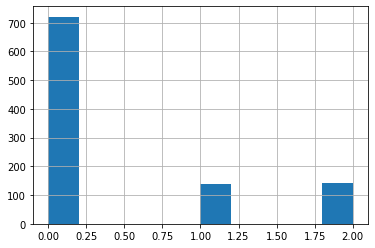

In [42]:
test.act.hist()

In [18]:
torch.save(model.state_dict(), 'bc_rl_5min_macd-bolinger_with_budgets_v1')

In [12]:
model.load_state_dict(torch.load('fx_rl_5min_macd_v1', map_location=device))

<All keys matched successfully>

### DoubleDQN with LSTM

In [6]:
data_client = CSVClient()
env = BC5Env(data_client, columns=["macd"], useBudgetColumns=True, featureFirst=False,use_diff=True)

In [7]:
training_size = 1000 #traning dataのデータ数
epochs_num = 10000 #traningのepoch回数
hidden_size = 500 #LSTMの隠れ層の次元数
batch_size = 32

In [8]:
obs = env.reset()
size = obs.shape[0]
inputDim = obs.shape[1]

In [9]:
import torch
import torch.nn as nn
from torch.optim import SGD
import math
import numpy as np

class PredictorLSTM(nn.Module):
    def __init__(self, inputDim, hiddenDim, num_layers, n_actions, delete):
        super(PredictorLSTM, self).__init__()
        self.ActionHistoryDim = 2
        self.rnn = nn.LSTM(input_size = inputDim - self.ActionHistoryDim,
                            hidden_size = hiddenDim,
                            batch_first=True,
                            num_layers=num_layers)
        self.rnn.to(device)
        self.output_layer = nn.Linear(hiddenDim, n_actions)#+self.ActionHistoryDim, n_actions)
        self.output_layer.to(device)
    
    def forward(self, inputs, hidden0=None):
        batch_size, seq_len, feature_len = inputs.shape[0], inputs.shape[1],inputs.shape[2]
        ohlc_inputs = inputs[:,:, 0: feature_len - self.ActionHistoryDim]
        last_actions = inputs[:, -1, -self.ActionHistoryDim:] # [1, ActionHistoryDim] (ex.torch.Size([1, 3]))
        output, (hidden, cell) = self.rnn(ohlc_inputs, hidden0) #LSTM層
        output = output[:, -1, :] # [1, hidden_size] (ex. torch.Size([1, 50]))
        #output = torch.cat((output, last_actions), dim=1) #[1, hidden_size+ActionHistoryDim] (ex.torch.Size([1, 53]))
        output = self.output_layer(output) #全結合層
        return pfrl.action_value.DiscreteActionValue(output)

In [18]:
model = PredictorLSTM(inputDim, inputDim, 30,3) #modelの宣言

#model = Predictor(6, hidden_size, 5) #modelの宣言
criterion = nn.MSELoss() #評価関数の宣言

In [11]:
training_size = 1000 #traning dataのデータ数
epochs_num = 10000 #traningのepoch回数
hidden_size = 500 #LSTMの隠れ層の次元数
batch_size = 32

In [23]:
#optimizer = SGD(model.parameters(), lr=0.0001) #最適化関数の宣言
optimizer = torch.optim.Adam(model.parameters(), eps=1e-8)
# Set the discount factor that discounts future rewards.
gamma = 0.9

# Use epsilon-greedy for exploration
explorer = pfrl.explorers.ConstantEpsilonGreedy(
    epsilon=0.1, random_action_func=env.action_space.sample)

# DQN uses Experience Replay.
# Specify a replay buffer and its capacity.
#replay_buffer = pfrl.replay_buffers.ReplayBuffer(capacity=batch_size)
replay_buffer = pfrl.replay_buffers.ReplayBuffer(capacity=batch_size)

# Since observations from CartPole-v0 is numpy.float64 while
# As PyTorch only accepts numpy.float32 by default, specify
# a converter as a feature extractor function phi.
phi = lambda x: x.astype(numpy.float32, copy=False)

# Set the device id to use GPU. To use CPU only, set it to -1.
gpu = 0

# Now create an agent that will interact with the environment.
agent = pfrl.agents.DoubleDQN(
    model,
    optimizer,
    replay_buffer,
    gamma,
    explorer,
    replay_start_size=batch_size,
    update_interval=5,
    target_update_interval=10,
    phi=phi,
    gpu=gpu
)

In [22]:
n_episodes = 1000
max_step_len = 1000
mr = 0
pl = 0
ep_consumed_total_time = datetime.timedelta(0)
print(datetime.datetime.now(),'start episodes')

logger = pt_logs(env, folder='logs/tests/bc_rl_5min_macd_budgets_v2', save_obs = True)
## show details
##
for i in range(1, n_episodes + 1):
    obs = env.reset()
    #obs = obs.to('cpu').detach().numpy().copy()
    R = 0  # return (sum of rewards)
    t = 0  # time step
    logs = []
    ep_start_time = datetime.datetime.now()
    while True:
        # Uncomment to watch the behavior in a GUI window
        #env.render()
        action = agent.act(obs)
        obs, reward, done, ops = env.step(action)
        R += reward
        t += 1
        reset = t == max_step_len
        agent.observe(obs, reward, done, reset)
        logger.store(obs, action, reward)
        if reset or done:
            break
    ep_end_time = datetime.datetime.now()
    ep_consumed_time = ep_end_time - ep_start_time
    ep_consumed_total_time += ep_consumed_time
    logger.save(i)
    pl += env.pl
    mr += R/t
    if i % 10 == 0:
        print('statistics:', agent.get_statistics(), 'R:', R/t, 'Mean R:', mr/10, 'PL:', env.pl, 'Mean PL:', pl/10)
        print(f"consumed time: {ep_consumed_time}, may end on :{ep_end_time + (n_episodes -i) *  ep_consumed_total_time/10}")
        ep_consumed_total_time = datetime.timedelta(0)
        mr = 0
        pl = 0
print(f'Finished on {datetime.datetime.now()}')

2022-04-05 00:21:18.172491 start episodes
statistics: [('average_q', -0.000104359075), ('average_loss', 2.9523709450230635e-07), ('cumulative_steps', 208365), ('n_updates', 41667), ('rlen', 32)] R: 0.000539933253972452 Mean R: 9.543864485563687e-05 PL: 0.9129332539724524 Mean PL: 0.26613864485563293
consumed time: 0:01:01.315678, may end on :2022-04-05 17:27:36.252024
statistics: [('average_q', -8.546193e-05), ('average_loss', 6.216639060461465e-08), ('cumulative_steps', 218365), ('n_updates', 43667), ('rlen', 32)] R: -5.788895232991876e-05 Mean R: 0.0008638290800908957 PL: -0.0008889523299187205 Mean PL: 0.999929080090905
consumed time: 0:01:01.494529, may end on :2022-04-05 17:31:47.147594
statistics: [('average_q', -0.00020662123), ('average_loss', 1.7881909222832218e-06), ('cumulative_steps', 228365), ('n_updates', 45667), ('rlen', 32)] R: -0.00014455389562747288 Mean R: 0.0001302663602240685 PL: -0.09355389562747288 Mean PL: 0.2861663602240629
consumed time: 0:01:00.785355, may en

statistics: [('average_q', -0.00014945563), ('average_loss', 2.6626440079594967e-06), ('cumulative_steps', 457925), ('n_updates', 91579), ('rlen', 32)] R: -0.00010114834144887726 Mean R: 0.0006146802110815368 PL: -0.029148341448877207 Mean PL: 0.7793802110815464
consumed time: 0:01:02.116380, may end on :2022-04-05 17:20:10.727400
statistics: [('average_q', -0.00011172178), ('average_loss', 6.385578318893228e-07), ('cumulative_steps', 467925), ('n_updates', 93579), ('rlen', 32)] R: -0.00011144163025032745 Mean R: -0.00021394149391180972 PL: -0.05444163025032741 Mean PL: -0.14114149391180966
consumed time: 0:01:03.362199, may end on :2022-04-05 17:30:31.651347
statistics: [('average_q', -7.145347e-05), ('average_loss', 4.837314362205732e-07), ('cumulative_steps', 477925), ('n_updates', 95579), ('rlen', 32)] R: 0.005232809439282649 Mean R: 0.0016185792178494474 PL: 5.6908094392828 Mean PL: 1.814079217849438
consumed time: 0:01:01.419563, may end on :2022-04-05 17:21:12.168702
statistics:

statistics: [('average_q', -0.000350816), ('average_loss', 4.468849994537031e-06), ('cumulative_steps', 707925), ('n_updates', 141579), ('rlen', 32)] R: -0.000869083954824745 Mean R: 0.0012743694377373939 PL: -0.8160839548247449 Mean PL: 1.4525694377373648
consumed time: 0:01:00.082863, may end on :2022-04-05 17:20:33.291891
statistics: [('average_q', -4.150574e-05), ('average_loss', 4.23299572745922e-08), ('cumulative_steps', 717925), ('n_updates', 143579), ('rlen', 32)] R: -7.175841995758203e-05 Mean R: 0.0003584899181265604 PL: -0.018758419957582026 Mean PL: 0.45528991812657427
consumed time: 0:01:01.753923, may end on :2022-04-05 17:19:26.153886
statistics: [('average_q', -0.00019726978), ('average_loss', 2.189703986044684e-06), ('cumulative_steps', 727925), ('n_updates', 145579), ('rlen', 32)] R: 0.0006258611993644324 Mean R: -9.051940472291521e-05 PL: 1.002861199364418 Mean PL: 0.037880595277083415
consumed time: 0:01:00.263855, may end on :2022-04-05 17:18:16.315743
statistics: 

statistics: [('average_q', -0.000108610264), ('average_loss', 2.4657633788509485e-06), ('cumulative_steps', 956350), ('n_updates', 191264), ('rlen', 32)] R: -0.0008461530092881352 Mean R: 0.0015396063133856612 PL: -0.7931530092881351 Mean PL: 1.7475063133856394
consumed time: 0:00:59.933955, may end on :2022-04-05 17:20:56.233549
statistics: [('average_q', -4.1478248e-05), ('average_loss', 9.889167739251154e-08), ('cumulative_steps', 966350), ('n_updates', 193264), ('rlen', 32)] R: -7.007291300422977e-05 Mean R: 0.00033805224695410526 PL: -0.02107291300422974 Mean PL: 0.4571522469541021
consumed time: 0:00:59.954503, may end on :2022-04-05 17:19:20.648673
statistics: [('average_q', -0.00015211866), ('average_loss', 1.0368524082351243e-07), ('cumulative_steps', 976350), ('n_updates', 195264), ('rlen', 32)] R: -7.084889577326363e-05 Mean R: 0.0012413558936861238 PL: -0.01884889577326358 Mean PL: 1.370255893686093
consumed time: 0:01:00.119049, may end on :2022-04-05 17:18:52.385340
stati

statistics: [('average_q', -6.70567e-05), ('average_loss', 4.927852388247896e-07), ('cumulative_steps', 1195627), ('n_updates', 239119), ('rlen', 32)] R: -8.142303007160723e-05 Mean R: 0.0007667396173664193 PL: -0.049423030071607206 Mean PL: 0.9077396173663954
consumed time: 0:01:00.814161, may end on :2022-04-05 17:20:01.191286
Finished on 2022-04-05 17:20:01.539251


In [15]:
reward

-0.001

In [47]:
short_ema = env.data_client.data.Close.rolling(12).mean()
long_ema = env.data_client.data.Close.rolling(26).mean()

In [49]:
(short_ema - long_ema).pct_change()

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
            ...    
378610    -1.013928
378611    93.826307
378612     0.579697
378613    -0.090381
378614    -0.064410
Name: Close, Length: 378615, dtype: float64

In [21]:
obs

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.]])